In [1]:
#imports
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
import mkl
mkl.set_num_threads(40)
import matplotlib
#necessary for plotly interactivity. dont ask me why
matplotlib.use('nbagg')
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from scipy import special
from random import gauss
#import hdf5storage
import h5py
import timeit
#from numba import jit
#from sympy.solvers.solveset import nonlinsolve
#from sympy.core.symbol import symbols
#from sympy import exp
from scipy import stats, io, sparse
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from core.analysis import *
from core.simulation import *
import similaritymeasures as sm
sp.__version__

'1.11.1'

# Construct connectome (no need to rerun)

In [ ]:
#(if needed) construct some necessary properties from the 'Fibers' matlab data
#note that the function is set to utilize the data in 'fgCC', following selen's instruction
#however, another fiber dataset is present inside 'Fibers', called 'fg'.
#the other dataset can be selected manually from inside the function
construct_fibers_from_data(
                #data from Selen Atasoy
                filepath_data='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/100307_Laplace.mat',
                filepath_Fibers='G:/Macbook Stuff/Downloads/Fibers.mat',
                           
                savefiles=True,
                bundle_size=7,
                output_filepath_fiber_edges='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_bundles.npy',
                output_filepath_fiber_lengths='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_lengths.npy',                       
                output_filepath_fiber_dist_starts='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_dist_starts.npy',
                output_filepath_fiber_dist_ends='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_dist_ends.npy',
                output_filepath_fiber_ends='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_ends.npy')    

In [ ]:
#(if needed) construct the mesh + DTI adjacency directly from the 'faces' and 'fibers' datasets
#the subcortical nodes and edges are excluded at the end of the procedure
#if the 'visual' option is selected, the function also returns datasets in suitable format for plotly
mesh_DTI_adjacency, Xn, Yn, Zn, iN, jN, kN,  Xe, Ye, Ze = construct_adjacency_matrix_from_data(
                                #data from Selen Atasoy
                                filepath_data='/home/aqil/NFModel/100307_Laplace.mat',
                                
                                #results of previous cell
                                filepath_fiber_edges=['/home/aqil/NFModel/fgCCfix_fiber_edges.npy'],#'/home/aqil/NFModel/fg_fiber_edges.npy'],
                                filepath_fiber_lengths=['/home/aqil/NFModel/fgCCfix_fiber_lengths.npy'],#'/home/aqil/NFModel/fg_fiber_lengths.npy'],
                                filepath_fiber_ends=['/home/aqil/NFModel/fgCCfix_fiber_ends.npy'],#'/home/aqil/NFModel/fg_fiber_ends.npy'],
                                
                                include_subcortex=True,
                                add_DTI=True,
                                fiber_speed_factor=50,
    
                                threshold=False,
                                max_dist=10,
                                filepath_fiber_dist_starts=['/home/aqil/NFModel/fgCCfix_fiber_dist_starts.npy'],#'/home/aqil/NFModel/fg_fiber_dist_starts.npy'],
                                filepath_fiber_dist_ends=['/home/aqil/NFModel/fgCCfix_fiber_dist_ends.npy'],#'/home/aqil/NFModel/fg_fiber_dist_ends.npy'],

                                visual=True,
                                plot_subcortex=True,
                                plot_DTI_edges=True)

In [ ]:
f = h5py.File('/home/aqil/NFModel/100307_Laplace.mat', 'r')
CC = np.asarray(f['CC']['restInds'], dtype=int)
indices = np.array([elem[0] for elem in CC])-1

In [ ]:
DTI_edges.shape

In [ ]:
np.save('/home/aqil/NFModel/subcortical_indices.npy', indices)

In [ ]:
#(if needed) construct graph Laplacian from mesh data and diagonalize it
binary = False
#this is the same procedure used for regular graphs
AdjMatrix=mesh_DTI_adjacency.toarray()
#convert mm^2 to m^2
if binary:
    AdjMatrix[AdjMatrix>0] = 1
else:
    #convert mm^2 to m^2
    AdjMatrix*=1000000
    
Deg=np.sum(AdjMatrix, axis=0)
Degree_Matrix=sp.sparse.diags(Deg)
regLap = Degree_Matrix - sp.sparse.csc_matrix(AdjMatrix)
Laplacian=-regLap.toarray()

vecs=True

if vecs==False:    
    eigenvalues=np.linalg.eigvalsh(Laplacian)
    eigenvalues[-1]=0
    eigenvalues=eigenvalues[::-1]
    #np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvals_DTI_full_200short.npy', eigenvalues)
else:
    eigenvalues,eigenvectors=np.linalg.eigh(Laplacian)
    #eigenvalues[-1]=0
    #note that the eigenvectors come out 2-normalized
    eigenvalues=eigenvalues[::-1]
    eigenvectors=eigenvectors[:,::-1]
    np.save('/home/aqil/NFModel/eigvals_DTI_fgCCfix_subcortex_dti50.npy', eigenvalues)
    np.save('/home/aqil/NFModel/eigvecs_DTI_fgCCfix_subcortex_dti50.npy', eigenvectors)


# Load previously constructed connectome

In [2]:
#len(np.nonzero(mesh_DTI_adjacency.toarray())[0])/2
#np.shape(mesh_DTI_adjacency.toarray())
f = h5py.File('/home/aqil/NFModel/100307_Laplace.mat', 'r')
CC = np.asarray(f['CC']['restInds'], dtype=int)
indices = np.array([elem[0] for elem in CC])-1
AllVet=np.asarray(f['vertices']['all'])

#u_0=np.heaviside(AllVet[0,indices],0)
f.close()
#no_sub=mesh_DTI_adjacency[indices,:]
#no_sub=no_sub[:,indices]
#len(np.nonzero(no_sub.toarray())[0])/2
#mesh_DTI_adjacency=np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/metric_cortical_DTI_bundles_full_all_fibers.npy')
#mesh_DTI_adjacency=mesh_DTI_adjacency[indices,:]
#mesh_DTI_adjacency=mesh_DTI_adjacency[:,indices]
#mesh_DTI_adjacency.toarray().shape

In [ ]:
##np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/metric_cortical_DTI_bundles_full_all_fibers.npy', mesh_DTI_adjacency)

In [3]:
#Alternatively, if previously known, read eigenvalues and eigenvectors from file
#this is what i used for the thesis. note that it has to be loaded with a minus sign
#eigenvalues_thesis = -np.load('E:/My Documents/Dropbox/Amsterdam Math/Rikkert Hindriks/Graph-Stochastic-Wilson-Cowan-Model/data/eigvals.npy')
#this should be the corresponding eigenvectors. they appear to be 1-normalized
#eigenvectors_thesis = -np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvecs.npy')

#eigenvalues = np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvals_DTI_fgCC_200short.npy')

#paper
#eigenvalues = np.load('/home/aqil/NFModel/eigvals_DTI_fgCCfix_200short_metres.npy')
#eigenvectors = np.load('/home/aqil/NFModel/eigvecs_DTI_fgCCfix_200short_metres.npy')

#these are all in metres unless otherwise specified
# eigenvalues = np.load('/home/aqil/NFModel/eigvals_DTI_fgCCfix_fg_subcortex.npy')
# eigenvectors = np.load('/home/aqil/NFModel/eigvecs_DTI_fgCCfix_fg_subcortex.npy')

# eigenvalues = np.load('/home/aqil/NFModel/eigvals_DTI_fgCCfix_fg_subcortex_dti50.npy')
# eigenvectors = np.load('/home/aqil/NFModel/eigvecs_DTI_fgCCfix_fg_subcortex_dti50.npy')

#eigenvalues = np.load('/home/aqil/NFModel/eigvals_DTI_fgCCfix_fg_subcortex_dti1.npy')
#eigenvectors = np.load('/home/aqil/NFModel/eigvecs_DTI_fgCCfix_fg_subcortex_dti1.npy')

#unused
# eigenvalues = np.load('/home/aqil/NFModel/eigvals_DTI_fgCCfix_subcortex_dti1_mm.npy')
# eigenvectors = np.load('/home/aqil/NFModel/eigvecs_DTI_fgCCfix_subcortex_dti1_mm.npy')

#eigenvalues = np.load('/home/aqil/NFModel/eigvals_DTI_fgCCfix_subcortex_dti10.npy')
#eigenvectors = np.load('/home/aqil/NFModel/eigvecs_DTI_fgCCfix_subcortex_dti10.npy')

#best so far
eigenvalues = np.load('/home/aqil/NFModel/eigvals_DTI_fgCCfix_subcortex_dti50.npy')
eigenvectors = np.load('/home/aqil/NFModel/eigvecs_DTI_fgCCfix_subcortex_dti50.npy')

#eigenvalues = -np.load('E:/My Documents/Dropbox/Amsterdam Math/Rikkert Hindriks/Graph-Stochastic-Wilson-Cowan-Model/data/eigvals.npy')
len(eigenvalues)
#np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvals_DTI_fgCC_200short_metres.npy', eigenvalues)
#print(eigenvalues)
#print(eigenvalues2)

20484

In [ ]:
eigenvalues[0]

In [12]:
#Set parameters and bounds for minimization algorithms
Graph_Kernel='Damped Wave'

aEE, bnds_aEE = 140, (0,1e3)
aIE, bnds_aIE = 155, (0,1e3)
aEI, bnds_aEI = 165, (0,1e3)
aII, bnds_aII = 140, (0,1e3)
dE, bnds_dE = 2, (0,1e3)
dI, bnds_dI = 2, (0,1e3)
P, bnds_P = 0, (0,1e3)
Q, bnds_Q = 0, (0,1e3)
sEE, bnds_sEE = 6, (0,1e-2)
sIE, bnds_sIE = 10, (0,1e-2)
sEI, bnds_sEI = 10, (0,1e-2)
sII, bnds_sII = 50, (0,1e-2)
#D, bnds_D = 1, (0.1,10)             #unchanged
tE, bnds_tE = 1, (0,1e3)          
tI, bnds_tI = 1, (0,1e3)          
#snE, bnds_snE = 1, (1,10)        #unchanged
#snI, bnds_snI = 1, (1,10)         #unchanged

initial_guess=[aEE,aIE,aEI,aII,dE,dI,P,Q,sEE,sIE,sEI,sII,tE,tI]#,snE])#,snI]) 
bnds=[bnds_aEE,bnds_aIE,bnds_aEI,bnds_aII,bnds_dE,bnds_dI,bnds_P,bnds_Q,bnds_sEE,bnds_sIE,bnds_sEI,bnds_sII,bnds_tE,bnds_tI]#,bnds_snE]#,bnds_snI]


if Graph_Kernel == 'Damped Wave':
    aDW_EE, bnds_aDW_EE = 0, (0,1e3)
    aDW_IE, bnds_aDW_IE = 0, (0,1e3)
    aDW_EI, bnds_aDW_EI = 0, (0,1e3)
    aDW_II, bnds_aDW_II = 0, (0,1e3)
    bDW_EE, bnds_bDW_EE = 0, (0,1e3)
    bDW_IE, bnds_bDW_IE = 0, (0,1e3)
    bDW_EI, bnds_bDW_EI = 0, (0,1e3)
    bDW_II, bnds_bDW_II = 0, (0,1e3)
    initial_guess += [aDW_EE,aDW_IE,aDW_EI,aDW_II,bDW_EE,bDW_IE,bDW_EI,bDW_II]
    bnds += [bnds_aDW_EE,bnds_aDW_IE,bnds_aDW_EI,bnds_aDW_II,bnds_bDW_EE,bnds_bDW_IE,bnds_bDW_EI,bnds_bDW_II]

In [5]:

#thesis values
first_k=2
last_k=5000
thesis_spatial_spectrum = 15*(np.arange(first_k,last_k)**(-0.3))

#post-thesis work
first_k=3
last_k=len(eigenvalues)
x_t = np.log(np.arange(first_k,last_k))
new_spatial_spectrum = 10**(-0.012*x_t**(2.2) + 0.6 + 0.5*x_t**(-0.3))#0.02*x_t**(1.1)+1.1)# + x_t**(-1.5)+10)
#more similar to fluctuations power data from selen
new_spatial_spectrum = 10**(-0.018*x_t**(2.2) + 0.5 + 0.5*x_t**(-0.3))

#empirical SPS
first_k=1
last_k=10000#len(eigenvalues)
f = sp.io.loadmat('/home/aqil/NFModel/100307_REST1_LR_selenyeo10k.mat')

if len(eigenvalues)==18715:
    timecourse = np.nan_to_num(np.concatenate((f['selenyeo10kts_lh'],f['selenyeo10kts_rh']), axis=0)[indices])
else:
    timecourse = np.nan_to_num(np.concatenate((f['selenyeo10kts_lh'],f['selenyeo10kts_rh']), axis=0))
#errors = np.nan_to_num(np.concatenate((f['selenyeo10kts_lh_stderr'],f['selenyeo10kts_rh_stderr']), axis=0)[indices])

#the Laplace coefficient of the zero-mean timecourses
coeffs = np.dot(eigenvectors.T,(timecourse-timecourse.mean(1)[...,np.newaxis]))
#the Laplace coefficient of the z-scored timecourses
#coeffs_zscore = np.dot(eigenvectors.T,np.nan_to_num(sp.stats.zscore(timecourse, axis=1)))

#here i define logspace binning
bins = np.unique(np.logspace(np.log10(first_k), np.log10(last_k), num=300, dtype=int))[:-1]
bins_positions = np.array([elem.mean() for elem in np.array_split(np.arange(first_k,last_k), bins)])
def median_binning(data,bins):
    return np.array([np.median(elem) for elem in np.array_split(data, bins)])

In [ ]:
#from matplotlib import cm
#colors = cm.get_cmap('RdBu')(np.linspace(0,1,220))

In [ ]:
# plt.figure()
# for c,i in enumerate(np.arange(0,1100,5)):
    
#     empirical_SPS=(np.abs(coeffs[:,i:(i+60)])**2).mean(1)[first_k:last_k]
#     bins = np.unique(np.logspace(np.log10(first_k), np.log10(last_k), num=300, dtype=int))[:-1]
#     binned_SPS = np.array([np.median(elem) for elem in np.array_split(empirical_SPS, bins)])
#     binned_SPS_points = np.array([elem.mean() for elem in np.array_split(np.arange(first_k,last_k), bins)])

#     plt.loglog(binned_SPS_points,binned_SPS,c=colors[c],alpha=0.5,lw=0.5)

In [6]:
#empirical_SPS_errors = np.abs(np.dot(eigenvectors.T,errors)).mean(1)
empirical_SPS=(np.abs(coeffs)**2).mean(1)[first_k:last_k]
#keep the [:-1] to avoid empty slice problems
bins = np.unique(np.logspace(np.log10(first_k), np.log10(last_k), num=300, dtype=int))[:-1]
binned_SPS = np.array([np.median(elem) for elem in np.array_split(empirical_SPS, bins)])
binned_SPS_points = np.array([elem.mean() for elem in np.array_split(np.arange(first_k,last_k), bins)])
binned_SPS_err = np.array([sp.stats.sem(elem) for elem in np.array_split(empirical_SPS, bins)])
len(bins)

/home/aqil/.conda/envs/py310/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/aqil/.conda/envs/py310/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


217

In [7]:

plt.figure()
plt.yscale('log')
plt.xscale('log')
plt.title("Spatial Power Spectrum  $P(k)$")
plt.xlabel("Spatial Eigenmode ($k$)")
#plt.errorbar(x=np.arange(len(empirical_SPS)), y=empirical_SPS, yerr=0, fmt='ks', markersize=1, zorder=1)
plt.errorbar(x=binned_SPS_points, y=binned_SPS, yerr=binned_SPS_err, zorder=2, fmt='yo',markersize=3)

plt.loglog(np.arange(first_k, last_k), empirical_SPS, marker='s', linestyle='', markersize=2, zorder=0, color=[0.267004, 0.004874, 0.329415, 1.])
plot_bins = np.unique(np.logspace(0, np.log10(20000), num=300, dtype=int))[:-1]
y_bins = np.unique(np.logspace(0, np.log10(len(eigenvalues)), num=200, dtype=int))[:-1]
plt.hist2d(np.arange(first_k, last_k), empirical_SPS, (plot_bins, y_bins), cmap='viridis',zorder=1,cmin=2)

fit_to_median=True
if fit_to_median:
    True_Spatial_Spectrum = binned_SPS
    Bins=bins
else:
    True_Spatial_Spectrum = empirical_SPS
    Bins=None
        
LSA=True
Visual=False
SaveFiles=False
FilePath=' '

Min_omega=5*(2*np.pi)
Max_omega=50*(2*np.pi)
Delta_omega=0.1*(2*np.pi)

freqs=np.arange(Min_omega,Max_omega,Delta_omega)/(2*np.pi)

#higher gaussian TPS
higher_gaussian_TPS=100000/(100*freqs+10000)+5*np.exp((-(freqs-10)**2)/(2*0.9**2))
#lower gaussian TPS
lower_gaussian_TPS=100000/(100*freqs+10000)+3*np.exp((-(freqs-10)**2)/(2*1.2**2)) #too complex: 10*(1/(0.1*freqs+0.4)+0.7*np.exp((-(freqs-10)**2)/(2*0.9**2))+0.3*np.exp((-(freqs-22)**2)/(2*3**2)))
#even lower gaussian TPS
even_lower_gaussian_TPS=100000/(100*freqs+10000)+1.5*np.exp((-(freqs-10)**2)/(2*1.8**2))
#lowest gaussian TPS
lowest_gaussian_TPS=100000/(100*freqs+10000)+0.5*np.exp((-(freqs-10)**2)/(2*2.5**2))
#no gaussian TPS
no_gaussian_TPS=100000/(100*freqs+10000)

#new TPS, inspired by ketamine paper. suitable for loglog plotting, so multiplicative factor
new_TPS=2.5*freqs**(-1.25)+1.2*np.exp((-(freqs-10)**2)/(2*0.7**2)) + 0.06*np.exp((-(freqs-20)**2)/(2*0.7**2))
new_TPS[np.where((freqs>20) & (freqs<=40))] = 35*freqs[np.where((freqs>20) & (freqs<=40))]**(-2.17) +0.06*np.exp((-(freqs[np.where((freqs>20) & (freqs<=40))]-20)**2)/(2*0.7**2))
new_TPS[np.where(freqs>40)] = 1.17*freqs[np.where(freqs>40)]**(-1.25)

#empirical TPS from Rikkert MEG data
MEG_PS_data = sp.io.loadmat('/home/aqil/NFModel/MEG_powerspectrum.mat')
freqs = MEG_PS_data['f'][1:][:,0]
empirical_TPS = MEG_PS_data['p'].T[1:][:,0] * 10 **30#28
Min_omega=1*(2*np.pi)
Max_omega=40*(2*np.pi)
Delta_omega=0.5*(2*np.pi)
True_Temporal_Spectrum=np.array(empirical_TPS, dtype='float')#[int(len(new_TPS)*0.1):int(len(new_TPS)*0.5)]
#Max_omega=25*(2*np.pi)


fig2 = plt.figure()
ax = fig2.add_subplot(111)
ax.set_title("Temporal Power Spectrum ")
ax.set_xlabel("Frequency (hz)")
ax.loglog(freqs, True_Temporal_Spectrum)


In [110]:
# ############################
# #single analysis for easy visualization (note that if there are multiple stedy states the visualization will refer to the best one)
# # better_result=dict(x=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
# #        1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
# #        8.37626732e+00, 2.74681544e+00, 3.66503548e-02, 1.00910684e+02,
# #        4.95497870e+00, 4.47579295e+00]))
# plt.close('all')
# aEE=115
# aIE=175
# aEI=190 
# aII=210
# dE=2.5 
# dI=1 
# P=0 
# Q=0 
# sEE=5.5 
# sIE=3
# sEI=3.5 
# sII=100 
# tE=1.2
# tI=0.8
# initial_guess=np.array([aEE,aIE,aEI,aII,dE,dI,P,Q,sEE,sIE,sEI,sII,tE,tI])
#Ess = 0.003813#steady_states[0,nrSS]
#Iss = 0.0522#steady_states[1,nrSS]    
# Best suitable steady state: 0, with Ess=0.003813 Iss=0.0522.                       
# Dist spatial: 1493, scale params: [6170.0315 1328.5838 4896.9869]                        
# Dist temporal: 2092, scale params: [  10.7089   -3.767  -318.5677]
Full_Analysis(better_result['x'], *Args)

Best suitable steady state: 6, with Ess=0.003765 Iss=0.05219.                       
Dist spatial: 1470, scale params: [6676.0398 1265.4767 4672.1677]                        
Dist temporal: 1.541e+05, scale params: [ 5.0886  4.9972 -0.5171]
                       total dist: 1.555e+05


155533.29418450798

dtype('float64')

In [ ]:
############################
#simple attempt at power spectrum fitting with a minimization algorithm. May get stuck in local minima.
#playing around with tolerance and max number of iterations is often necessary, depending on initial conditions. e.g.
#First run with fairly random initial guess: tol=1e-03, no maxiter (will take a while)
#Run starting from a previously obtained result: tol=1e-08, 'maxiter':2000
#thesis values
result=dict(x=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
       1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
       1e3*8.37626732e+00, 1e3*2.74681544e+00, 1e3*3.66503548e-02, 1e3*1.00910684e+02,
       4.95497870e+00, 4.47579295e+00]))

In [ ]:
result=dict(x=np.array([6.88112381e+02, 7.85722370e+01, 9.97105458e+02, 1.22114834e+02,
 1.00095980e+02 ,8.71706788e+00 ,4.45444506e+00, 6.72211504e+00,
 2.69548038e-03 ,1.94174600e-03, 1.55065050e-02, 2.22532549e-01,
 7.02896805e-01, 2.03388273e-01]))
result=dict(x=np.array([3.21305207e+02, 1.15229271e+02 ,2.70650624e+02, 1.50968021e+02,
 9.72193535e+01, 2.21122739e-01, 1.40493267e+01, 6.38403082e+00,
 2.84332179e-03, 1.20034605e-02 ,5.54375346e-02, 6.13375039e-02,
 5.39616943e-04, 2.34386738e-05]))
#best linear fit with intercept (also simulated)
result=dict(x=np.array([2.68360960e+02, 1.47992427e+02, 3.40781188e+02, 1.39064758e+02,
 3.91998061e+01 ,1.49887889e+00, 2.16422343e+01, 1.48126196e+01,
 1.80443833e-02, 2.01119682e-03 ,7.65031385e-02 ,3.47241530e-02,
 1.50660781e-01 ,1.30547616e+00]))

result=dict(x=np.array([1.50168054e+02, 2.19398694e+02, 2.60282590e+02, 1.61754514e+02,
 2.66754985e+01 ,1.23424895e+00, 2.22845573e+01, 8.44527415e+00,
 1.61870040e-02, 2.01464558e-03 ,6.87269629e-02, 1.03620878e-01,
 1.90996952e-01 ,2.41407765e-01]))
#final
result=dict(x=np.array([1.48665460e+02, 2.19057310e+02 ,2.62024638e+02 ,1.61437274e+02,
 2.71802361e+01, 1.24033047e+00, 2.23516416e+01 ,8.45022796e+00,
 1.61138979e-02, 2.02249219e-03 ,6.69814861e-02 ,9.14930664e-02,
 2.02440304e-01, 2.34608894e-01]))
#recent
result=dict(x=np.array([1.48430507e+02, 2.19054822e+02, 2.62072488e+02, 1.61171273e+02,
 2.77217907e+01, 7.11917100e-01, 2.27906562e+01, 7.66562110e+00,
 1.37941744e-02, 2.21349125e-03, 6.95808967e-02, 1.42852777e-01,
 3.33701978e-01, 3.79251075e-01]))


In [ ]:
from scipy.optimize import NonlinearConstraint

constraints = []

def spectrum_distance(x):
    E_Spectrum, I_Spectrum = Graph_WC_Spatiotemporal_PowerSpectrum(Laplacian_eigenvalues=eigenvalues, Graph_Kernel=Graph_Kernel, Ess=SStates[0,SSnr], Iss=SStates[1,SSnr],
                                        alpha_EE=x[0], alpha_IE=x[1], alpha_EI=x[2], alpha_II=x[3], d_e=x[4], d_i=x[5], 
                                        sigma_EE=x[8], sigma_IE=x[9], sigma_EI=x[10], sigma_II=x[11],  
                                        D=1, tau_e=x[12], tau_i=x[13],
                                    aDW_EE=x[14],aDW_IE=x[15], aDW_EI=x[16], aDW_II=x[17],
                                    bDW_EE=x[18], bDW_IE=x[19], bDW_EI=x[20], bDW_II=x[21],
                                               
                                        sigma_noise_e=sigma_noise, sigma_noise_i=sigma_noise,
                                        min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega,
                                        Spatial_Spectrum_Only=False, Visual=False)
    Gw_E=2*np.sum(E_Spectrum,axis=1)
    
    scale_params_temporal = np.array([(True_Temporal_Spectrum.mean())/(Gw_E.mean())])

    current_temporal_spectrum = NF_to_empirical(scale_params_temporal,
                                            Gw_E, Gw_I)
    dist_temporal = np.linalg.norm(np.log10(True_Temporal_Spectrum)-np.log10(current_temporal_spectrum), ord=2)**2

    dist_temporal += np.linalg.norm((np.log10(True_Temporal_Spectrum[1:])-np.log10(True_Temporal_Spectrum[:-1]))-(np.log10(current_temporal_spectrum[1:])-np.log10(current_temporal_spectrum[:-1])), ord=2)**4

    return dist_temporal

constraints.append(NonlinearConstraint(spectrum_distance,
                                                    lb=0,
                                                    ub=1.5))

# Fitting

In [57]:
np.set_printoptions(precision=4)

#dw manual
# result=dict(x=np.array([6.8811e+02, 7.9165e+01, 9.9711e+02, 1.2211e+02, 1.0051e+02, 8.5666e+00,
#  4.3092e+00, 6.9957e+00, 4.6705e-05, 1.4132e-03, 1.8037e-02, 2.3725e-01,
#  4.2467e-01, 3.5548e-01,10**3,10**3,10**3,10**3,10,10,10,10]))
# result=dict(x=np.array([6.88112381e+02, 7.85722370e+01, 9.97105458e+02, 1.22114834e+02,
#  1.00095980e+02 ,8.71706788e+00 ,4.45444506e+00, 6.72211504e+00,
#  2.69548038e-03 ,1.94174600e-03, 1.55065050e-02, 2.22532549e-01,
#  7.02896805e-01, 2.03388273e-01,1e-8,1e-8,1e-8,1e-8,1,1,1,1]))
# #final paper
# result=dict(x=np.array([1.48665460e+02, 2.19057310e+02 ,2.62024638e+02 ,1.61437274e+02,
#  2.71802361e+01, 1.24033047e+00, 2.23516416e+01 ,8.45022796e+00,
#  1.61138979e-02, 2.02249219e-03 ,6.69814861e-02 ,9.14930664e-02,
#  2.02440304e-01, 2.34608894e-01,1e-4,1e-4,1e-4,1e-4,1,1,1,1]))
# result=dict(x=np.array([1.4912e+02, 2.1759e+02, 2.5921e+02, 1.6230e+02, 2.7139e+01, 1.2337e+00,
#  2.2466e+01 ,8.1438e+00, 1.6423e-02 ,2.3137e-03, 6.6802e-02, 9.1542e-02,
#  2.0702e-01 ,2.3107e-01, 5.5491e-07 ,2.8627e-08, 1.4574e-06, 2.2508e-06,
#  1.0028e+00 ,1.0681e+00, 1.0393e+00 ,1.0028e+00]))
#using correlation
# result=dict(x=np.array([1.4868e+02, 2.1904e+02 ,2.6203e+02, 1.6145e+02, 2.7210e+01, 1.3746e+00,
#  2.2464e+01, 8.2988e+00 ,3.8240e-01 ,1.9704e-03, 7.5561e-02 ,9.1635e-02,
#  1.9435e-01, 1.0784e+00 ,9.9111e-01 ,9.9587e-01, 1.0038e+00 ,1.0084e+00,
#  1.0056e-04, 2.9705e-03, 5.1942e-03 ,1.2540e-03]))
#simplified scaling, ord2 distance, new connectome (wave params are *1e5)
# result=dict(x=np.array([5.0412e+02, 7.8384e+01, 1.2358e+03, 1.4698e+02, 4.9484e+01, 7.1233e+00,
#  3.9852e+00 ,3.2349e+00, 2.5905e-03, 1.9210e-03 ,2.9641e-02, 1.8067e-01,
#  8.4580e-01, 1.8146e-01, 9.2182e-05, 1.0270e-04, 1.1615e-04, 1.3291e-04,
#  1.1425e+00 ,1.0105e+00, 8.8928e-01, 8.1291e-01]))
##using temp deriv
# result=dict(x=np.array([7.1585e+02, 3.1227e+02, 2.8629e+02, 1.6478e+02, 2.6326e+01,
#        1.2776e+00, 2.1972e+01, 9.0008e+00, 1.6353e-02, 1.9772e-03,
#        6.8340e-02, 9.3434e-02, 1.9253e-01, 2.3090e-01, 9.7824e-01,
#        8.6755e-01, 1.0670e+00, 9.8824e-01, 5.5653e-04, 4.4763e-06,
#        4.4609e-07, 1.2138e-06]))
#also spatial deriv (temp looks nice) (but spat unstable) 52/12
# result=dict(x=np.array([7.1591e+02, 3.1259e+02, 2.8662e+02, 1.6442e+02, 2.6423e+01,
#        1.2825e+00, 2.1835e+01, 8.7888e+00, 1.7436e-03, 1.0713e-03,
#        7.9180e-02, 1.0382e-01, 1.9880e-01, 2.2459e-01, 9.7932e-01,
#        8.6580e-01, 1.0692e+00, 7.9494e-01, 1.0150e-02, 1.1836e-01,
#        5.4146e-03, 1.0648e-02]))
#spatial deriv stable no peaks
# result=dict(x=(np.array([2.1864e+02, 1.2605e+02, 1.8265e+02, 9.8375e+01, 3.9675e+01,
#        6.3733e-01, 7.3077e+00, 9.4213e-01, 7.1691e-03, 4.1517e-03,
#        8.2703e-02, 9.5257e-02, 2.2306e-01, 1.9062e-01, 3.9409e-08,
#        3.8537e-05, 1.6828e-04, 3.0538e-04, 1.9185e+00, 9.3723e-01,
#        1.7785e+00, 8.9270e-01])))
#manual edits on stable no peaks attempting to get peak without destavlizing
# result=dict(x=(np.array([2.1864e+02, 1.2605e+02, 1.8265e+02, 9.8375e+01, 3.9675e+01,
#        6.3733e-01, 7.3077e+00, 9.4213e-01, 7.1691e-03, 4.1517e-03,
#        8.2703e-02, 9.5257e-02, 2.2306e-01, 1.9062e-01, 9.7932e-01,
#         8.6580e-01, 1.0692e+00, 7.9494e-01, 1.0150e-02, 1.1836e-01,
#         5.4146e-03, 1.0648e-02])))
##DIFF EVO
# result=dict(x=np.array([2.18640000e+02, 1.77321423e+02, 2.97178667e+02, 9.83750000e+01,
#        2.63635016e+01, 6.37330000e-01, 7.30770000e+00, 9.42130000e-01,
#        3.04537982e-03, 4.15170000e-03, 1.06443266e-01, 9.52570000e-02,
#        2.23060000e-01, 1.81494557e-01, 3.94089739e-08, 3.85370000e-05,
#        1.22411168e+02, 3.05380000e-04, 1.91850000e+00, 2.64375950e+00,
#        1.24421530e-06, 8.92700000e-01]))
# #DIFF EVO 2
# result=dict(x=np.array([2.41362341e+02, 1.87465571e+02, 3.06359129e+02, 9.83750000e+01,
#        2.48031935e+01, 6.37329991e-01, 7.53833099e+00, 9.42130150e-01,
#        2.29619993e-03, 4.15156353e-03, 9.20363949e-02, 1.25773356e+01,
#        1.67598599e-01, 2.21462762e-01, 6.68549170e-07, 3.77186998e-05,
#        3.68790813e+01, 4.29250127e+02, 1.91849997e+00, 1.53394297e-10,
#        9.99999995e+02, 2.48366338e+01]))

initial_guess=better_result['x']#better_result['x']

#initial_guess[14:18] *= 10
#change none to True_Spatial_Spectrum if want to fit to both
Args = (eigenvalues, Graph_Kernel, True_Temporal_Spectrum, Min_omega, Max_omega, Delta_omega,
        True_Spatial_Spectrum, first_k, last_k, Bins, LSA, Visual, SaveFiles, FilePath, 3500, True)


result = sp.optimize.minimize(Full_Analysis, initial_guess, args=Args,
                              method='Nelder-Mead', 
                              bounds=bnds,
                              #constraints=constraints,
                              tol=1e-6,
                              options={#'ftol':1e-10,
                                      # 'xtol':1e-16,
                                     #  'maxiter': 1000,
                                 # 'adaptive':True,
                                   #   'maxls':200,
                                       'disp':True})

Best suitable steady state: 0, with Ess=0.003741 Iss=0.0522.                       
Dist spatial: 1460, scale params: [6918.5083 1236.1984 4570.3571]                        
Dist temporal: 1.774e+05, scale params: [ 5.1809  6.6674 -0.4764]
                       total dist: 1.789e+05
Best suitable steady state: 0, with Ess=0.002897 Iss=0.0526.                       
Dist spatial: 1710, scale params: [12611.0283   716.1457  3320.9491]                        
Dist temporal: 2.27e+05, scale params: [ 7.9606 12.5001  0.0986]
                       total dist: 2.287e+05
Best suitable steady state: 1, with Ess=0.02009 Iss=0.04509.                       
Dist spatial: 3883, scale params: [14607.1319  5943.4392 12099.1115]                        
Dist temporal: 2.307e+05, scale params: [ 9.7499 14.9863  0.5031]
                       total dist: 2.346e+05
Best suitable steady state: 1, with Ess=0.02014 Iss=0.04581.                       
Dist spatial: 3899, scale params: [14524.8028  5989.9908

KeyboardInterrupt: 

In [ ]:
print(repr(result['x']))

In [ ]:
print(result['x'])

In [ ]:
#dwave starting from paper results (no osc)
print(result['x'])

In [ ]:
#damped wave first manual
print(result['x'])

In [ ]:
#perfect background, no osc peaks
print(result['x'])

In [ ]:
#500 spatial 100 temporal
print(result['x'])

In [ ]:
#no linear intercept. log norm1 **2 +area = 562.1
print(result['x'])

In [ ]:
#no linear intercept. log norm1 **2 +area = 567
print(result['x'])

In [ ]:
#no linear intercept. log norm1 **2 = 240.9 (already very good!) (+areadist =600.5)
print(result['x'])

In [ ]:
#log norm1 **2 + area =   571.9
print(result['x'])

In [ ]:
#log norm1 **2 + area =  570.9
print(result['x'])

In [ ]:
#log norm1 **2 + area =  572.7 (TNC) (see 570 with nelme)
print(result['x'])

In [ ]:
#log norm1 dist 13.92 (352 area)
print(result['x'])

In [ ]:
#log norm1 dist 14.49
print(result['x'])

In [ ]:
#area between curves in log (not loglog) space as objective function. 2norm in log space for scaling (26/01/20)
#1336sp 39te (linear sum, interim best)
#792.2sp 31.7te (product)(excellent for spatial, bad for temporal)
#778sp 30te
#289.5 areas between curv dist, 15.28 log norm1 dist 
print(result['x'])

In [13]:
############################
#more complicated fitting attempt with basinhopping stochastic minimization
#to obtain good results in sensible amounts of time, playing with minimization parameters is required
#the relevant parameter are again tolerance and maxiter, similarly to above (which affect the local minimization loop)
#but also niter and stepsize. these specify how many local minimizations we wish to carry out, 
#and the size of the basin-hopping random step inbetween local minimizations

#best previous spectrum
#new_initial_guess=result['x']

#spectrum (thesis)
#old_initial_guess=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
#       1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
#       8.37626732e+00, 2.74681544e+00, 3.66503548e-02, 1.00910684e+02,
#       4.95497870e+00, 4.47579295e+00])

#new_initial_guess=np.load('first_spatiotemporal_spectrum_empirical_stps.npy', allow_pickle=True)[()]['x']

#sort of ugly, but need to defind bounds manually for basinhopping
# class MyBounds(object):
#     def __init__(self, xmax=[elem[1] for elem in bnds], xmin=[elem[0] for elem in bnds]):#, hello=this_temporal_distance):
#         self.xmax = np.array(xmax)
#         self.xmin = np.array(xmin)
#         #self.hello = hello
#     def __call__(self, **kwargs):
#         x = kwargs["x_new"]
#         tmax = bool(np.all(x <= self.xmax))
#         tmin = bool(np.all(x >= self.xmin))
#         t=tmax and tmin
        
#         New_Dist=Full_Analysis(x, *Args)
        
#         success = New_Dist<1e6
        
#         #if t and success and New_Dist<self.hello:
#         #    self.hello=New_Dist
#         #    new_initial_guess=np.copy(x)
        
#         return t and success
    
    
    #potential TODO: only accept parameter sets that return stable positive steady states (actually no: they might be locally near a suitable state. still worth to do local minimization)

#minimizer_kwargs={'args':Args, 'method':'TNC', 'bounds':bnds, 'tol':1e-03, 'options':{'maxiter':500}}


# def custom_min(fun, x0, args, **kwargs):
#     Bounds=bnds
#     #Bounds[0:8]=[(elem,elem) for elem in x0[0:8]]
     
     
#     result = sp.optimize.minimize(fun,x0,args=Args, method='Nelder-Mead', bounds=Bounds,
#                                 #tol=1e-16,
#                                 options={'maxiter':2000, 
#                                         # 'ftol': 1e-10,
#                                         #'maxls': 100,
#                                          'disp':True})
#     print(result)
    
#     return result


# better_result = sp.optimize.basinhopping(Full_Analysis, new_initial_guess, niter=1, stepsize=10,
#                                   minimizer_kwargs=dict(method=custom_min),
#                                   accept_test=MyBounds(), disp=True)

#Init=np.stack((new_initial_guess,new_initial_guess,new_initial_guess,new_initial_guess,new_initial_guess))
Init =np.stack((np.array([6.8811e+02, 7.9165e+01, 9.9711e+02, 1.2211e+02, 1.0051e+02, 8.5666e+00,
  4.3092e+00, 6.9957e+00, 4.6705e-05, 1.4132e-03, 1.8037e-02, 2.3725e-01,
  4.2467e-01, 3.5548e-01,10**3,10**3,10**3,10**3,10,10,10,10]),
                np.array([2.1864e+02, 1.2605e+02, 1.8265e+02, 9.8375e+01, 3.9675e+01,
        6.3733e-01, 7.3077e+00, 9.4213e-01, 7.1691e-03, 4.1517e-03,
        8.2703e-02, 9.5257e-02, 2.2306e-01, 1.9062e-01, 3.9409e-08,
        3.8537e-05, 1.6828e-04, 3.0538e-04, 1.9185e+00, 9.3723e-01,
        1.7785e+00, 8.9270e-01]),
                np.array([7.1591e+02, 3.1259e+02, 2.8662e+02, 1.6442e+02, 2.6423e+01,
       1.2825e+00, 2.1835e+01, 8.7888e+00, 1.7436e-03, 1.0713e-03,
       7.9180e-02, 1.0382e-01, 1.9880e-01, 2.2459e-01, 9.7932e-01,
       8.6580e-01, 1.0692e+00, 7.9494e-01, 1.0150e-02, 1.1836e-01,
       5.4146e-03, 1.0648e-02]),
                np.array([2.1864e+02, 1.2605e+02, 1.8265e+02, 9.8375e+01, 3.9675e+01,
        6.3733e-01, 7.3077e+00, 9.4213e-01, 7.1691e-03, 4.1517e-03,
        8.2703e-02, 9.5257e-02, 2.2306e-01, 1.9062e-01, 3.9409e-08,
        3.8537e-05, 1.6828e-04, 3.0538e-04, 1.9185e+00, 9.3723e-01,
        1.7785e+00, 8.9270e-01]),
                np.array([2.18640000e+02, 1.77321423e+02, 2.97178667e+02, 9.83750000e+01,
       2.63635016e+01, 6.37330000e-01, 7.30770000e+00, 9.42130000e-01,
       3.04537982e-03, 4.15170000e-03, 1.06443266e-01, 9.52570000e-02,
       2.23060000e-01, 1.81494557e-01, 3.94089739e-08, 3.85370000e-05,
       1.22411168e+02, 3.05380000e-04, 1.91850000e+00, 2.64375950e+00,
       1.24421530e-06, 8.92700000e-01]),
                np.array([2.41362341e+02, 1.87465571e+02, 3.06359129e+02, 9.83750000e+01,
       2.48031935e+01, 6.37329991e-01, 7.53833099e+00, 9.42130150e-01,
       2.29619993e-03, 4.15156353e-03, 9.20363949e-02, 1.25773356e+01,
       1.67598599e-01, 2.21462762e-01, 6.68549170e-07, 3.77186998e-05,
       3.68790813e+01, 4.29250127e+02, 1.91849997e+00, 1.53394297e-10,
       9.99999995e+02, 2.48366338e+01]),
                np.array([7.1591e+02, 3.1259e+02, 2.8662e+02, 1.6442e+02, 2.6423e+01,
       1.2825e+00, 2.1835e+01, 8.7888e+00, 1.7436e-03, 1.0713e-03,
       7.9180e-02, 1.0382e-01, 1.9880e-01, 2.2459e-01, 9.7932e-01,
       8.6580e-01, 1.0692e+00, 7.9494e-01, 1.0150e-02, 1.1836e-01,
       5.4146e-03, 1.0648e-02]),
                np.array([6.88112381e+02, 7.85722370e+01, 9.97105458e+02, 1.22114834e+02,
  1.00095980e+02 ,8.71706788e+00 ,4.45444506e+00, 6.72211504e+00,
  2.69548038e-03 ,1.94174600e-03, 1.55065050e-02, 2.22532549e-01,
  7.02896805e-01, 2.03388273e-01,1e-8,1e-8,1e-8,1e-8,1,1,1,1]),
               np.array([1.48665460e+02, 2.19057310e+02 ,2.62024638e+02 ,1.61437274e+02,
  2.71802361e+01, 1.24033047e+00, 2.23516416e+01 ,8.45022796e+00,
  1.61138979e-02, 2.02249219e-03 ,6.69814861e-02 ,9.14930664e-02,
  2.02440304e-01, 2.34608894e-01,1e-4,1e-4,1e-4,1e-4,1,1,1,1])
                ,np.array([2.41362341e+02, 1.87465571e+02, 3.06359129e+02, 9.83750000e+01,
       2.48031935e+01, 6.37329991e-01, 7.53833099e+00, 9.42130150e-01,
       2.29619993e-03, 4.15156353e-03, 9.20363949e-02, 1.25773356e+01,
       1.67598599e-01, 2.21462762e-01, 6.68549170e-07, 3.77186998e-05,
       3.68790813e+01, 4.29250127e+02, 1.91849997e+00, 1.53394297e-10,
       9.99999995e+02, 2.48366338e+01]),
                np.array([1.48665460e+02, 2.19057310e+02 ,2.62024638e+02 ,1.61437274e+02,
  2.71802361e+01, 1.24033047e+00, 2.23516416e+01 ,8.45022796e+00,
  1.61138979e-02, 2.02249219e-03 ,6.69814861e-02 ,9.14930664e-02,
  2.02440304e-01, 2.34608894e-01,1,1,1,1,0,0,0,0]),
                np.array([1.48665460e+02, 2.19057310e+02 ,2.62024638e+02 ,1.61437274e+02,
  2.71802361e+01, 1.24033047e+00, 2.23516416e+01 ,8.45022796e+00,
  1.61138979e-02, 2.02249219e-03 ,6.69814861e-02 ,9.14930664e-02,
  2.02440304e-01, 2.34608894e-01,1,1,1,1,0,0,0,0]),
               np.array([2.41362341e+02, 1.87465571e+02, 3.07070611e+02, 9.83020065e+01,
       2.50482813e+01, 6.42417383e-01, 7.53833099e+00, 9.42130411e-01,
       2.29472860e-03, 4.38074525e-03, 9.66418938e-02, 1.25773356e+01,
       1.67598599e-01, 2.20469165e-01, 6.90292552e-07, 3.77694684e-05,
       3.52815567e+01, 4.28978324e+02, 1.90121591e+00, 1.53420388e-10,
       9.99999995e+02, 2.48366338e+01]),
               np.array([2.41362341e+02, 1.91972736e+02, 3.43129169e+02, 9.81822854e+01,
       1.83207981e+01, 6.81612724e-01, 7.53902321e+00, 9.42131958e-01,
       2.27827826e-03, 4.54506746e-03, 9.91236679e-02, 1.25773356e+01,
       1.67598599e-01, 1.95175950e-01, 9.02941281e-07, 3.89303902e-05,
       3.47269915e+01, 4.28930846e+02, 1.32830186e+00, 1.53420388e-10,
       9.98838348e+02, 2.57433636e+01]),
               np.array([2.41362341e+02, 1.91972736e+02, 3.43129169e+02, 9.81822854e+01,
       1.83207981e+01, 6.81612724e-01, 7.53902321e+00, 9.42131958e-01,
       2.27827826e-03, 4.54506746e-03, 9.91236679e-02, 1.25773356e+01,
       1.67598599e-01, 1.95175950e-01, 9.02941281e-07, 3.89303902e-05,
       3.47269915e+01, 4.28930846e+02, 1.32830186e+00, 1.53420388e-10,
       9.98838348e+02, 2.57433636e+01]),
               np.array([2.31433810e+02, 1.90466280e+02, 3.65867090e+02, 9.83488441e+01,
       1.57541270e+01, 1.06325753e+00, 6.83325920e+00, 9.42128706e-01,
       1.92504060e-03, 4.24971198e-03, 9.36492001e-02, 1.25773356e+01,
       1.48446722e-01, 3.28173163e-01, 1.71043587e-06, 1.02027693e-04,
       1.47802800e+02, 4.28158241e+02, 6.11200743e-02, 4.06048066e-01,
       9.73777791e+02, 2.74980421e+01]),
               np.array([2.31539428e+02, 1.90466280e+02, 3.66655721e+02, 9.83556269e+01,
       1.57541270e+01, 1.06415552e+00, 6.83325920e+00, 9.42043599e-01,
       1.92504060e-03, 4.24870488e-03, 9.36492001e-02, 1.25773356e+01,
       1.48446722e-01, 3.27362408e-01, 1.71043587e-06, 1.03542890e-04,
       1.48506875e+02, 4.28158241e+02, 8.34346063e-02, 1.53420388e-10,
       5.86913552e+02, 2.77827962e+01]),np.load('de_fitting_5_subc_dti50.npy'),
               np.load('de_fitting_7_subc_dti50.npy'),
               np.array([3.4504e+02, 1.8893e+02, 3.0881e+02, 9.0579e+01, 2.0876e+01,
       5.8554e-01, 7.2718e+00, 9.4413e-01, 2.2475e-03, 4.6180e-03,
       9.5867e-02, 4.4390e+02, 1.4111e-01, 1.5644e-01, 1.4847e-06,
       9.7867e-05, 7.2554e+01, 6.0210e+02, 3.2340e-01, 7.2727e-03,
       6.0175e+02, 2.7397e+02]),
               np.load('de_fitting_8_subc_dti50.npy'),
            np.load('de_fitting_9_subc_dti50.npy'),
                np.load('de_fitting_10_subc_dti50.npy'),
                np.load('de_fitting_11_subc_dti50.npy'),
                 np.load('de_fitting_12_subc_dti50.npy'),
                np.load('de_fitting_13_subc_dti50.npy'),
                np.load('de_fitting_14_subc_dti50.npy'),
                np.load('de_fitting_16_subc_dti50.npy'),
                np.load('de_fitting_17_subc_dti50.npy'),
                np.load('de_fitting_18_subc_dti50.npy'),
               np.load('de_fitting_1_subc_dti1.npy'),
               np.load('fitting_nosubc_dti1_1.npy')))

disp_print = False
Args = (eigenvalues, Graph_Kernel, True_Temporal_Spectrum, Min_omega, Max_omega, Delta_omega,
        True_Spatial_Spectrum, first_k, last_k, Bins, LSA, Visual, SaveFiles, FilePath, 20, disp_print)

Init_mult = np.tile(Init,(5,1))

#Init='sobol' (bad)
#try with default strategy (doing)
#try higher 0.8 (doing 0.5)
#currently trying with full dti, subcortex, dti factor of 50 instead of 200
#allow intercept in linear scaling?
#change metric back to area between curves?
#allow combination with inhibitory spectrum

better_result = sp.optimize.differential_evolution(Full_Analysis, bounds=bnds, 
                                                 args=Args, tol=1e-4, disp=True, init=Init_mult,
                                                 maxiter=10000, polish=False, workers=25, recombination=0.8,
                                                # strategy='best1exp',
                                                mutation=(0.2,1.e8))


differential_evolution step 1: f(x)= 23367.9
differential_evolution step 2: f(x)= 23367.9
differential_evolution step 3: f(x)= 23367.9
differential_evolution step 4: f(x)= 23367.9
differential_evolution step 5: f(x)= 23367.9
differential_evolution step 6: f(x)= 23367.9
differential_evolution step 7: f(x)= 23367.9
differential_evolution step 8: f(x)= 23367.9
differential_evolution step 9: f(x)= 23367.9
differential_evolution step 10: f(x)= 23367.9
differential_evolution step 11: f(x)= 23367.9
differential_evolution step 12: f(x)= 23367.9
differential_evolution step 13: f(x)= 23367.9
differential_evolution step 14: f(x)= 23367.9
differential_evolution step 15: f(x)= 23367.9
differential_evolution step 16: f(x)= 23367.9
differential_evolution step 17: f(x)= 23367.9
differential_evolution step 18: f(x)= 23367.9
differential_evolution step 19: f(x)= 23367.9
differential_evolution step 20: f(x)= 23367.9
differential_evolution step 21: f(x)= 23367.9
differential_evolution step 22: f(x)= 23367

differential_evolution step 178: f(x)= 10214.1
differential_evolution step 179: f(x)= 10214.1
differential_evolution step 180: f(x)= 10214.1
differential_evolution step 181: f(x)= 10214.1
differential_evolution step 182: f(x)= 10214.1
differential_evolution step 183: f(x)= 10214.1
differential_evolution step 184: f(x)= 10214.1
differential_evolution step 185: f(x)= 10214.1
differential_evolution step 186: f(x)= 10214.1
differential_evolution step 187: f(x)= 10214.1
differential_evolution step 188: f(x)= 10214.1
differential_evolution step 189: f(x)= 10214.1
differential_evolution step 190: f(x)= 10214.1
differential_evolution step 191: f(x)= 10214.1
differential_evolution step 192: f(x)= 10110.2
differential_evolution step 193: f(x)= 10110.2
differential_evolution step 194: f(x)= 10110.2
differential_evolution step 195: f(x)= 10110.2
differential_evolution step 196: f(x)= 10110.2
differential_evolution step 197: f(x)= 10110.2
differential_evolution step 198: f(x)= 10110.2
differential_

differential_evolution step 353: f(x)= 8817.75
differential_evolution step 354: f(x)= 8817.75
differential_evolution step 355: f(x)= 8817.75
differential_evolution step 356: f(x)= 8817.75
differential_evolution step 357: f(x)= 8817.75
differential_evolution step 358: f(x)= 8817.75
differential_evolution step 359: f(x)= 8817.75
differential_evolution step 360: f(x)= 8817.75
differential_evolution step 361: f(x)= 8817.75
differential_evolution step 362: f(x)= 8817.75
differential_evolution step 363: f(x)= 8817.75
differential_evolution step 364: f(x)= 8817.75
differential_evolution step 365: f(x)= 8817.75
differential_evolution step 366: f(x)= 8817.75
differential_evolution step 367: f(x)= 8817.75
differential_evolution step 368: f(x)= 8817.75
differential_evolution step 369: f(x)= 8817.75
differential_evolution step 370: f(x)= 8817.75
differential_evolution step 371: f(x)= 8817.75
differential_evolution step 372: f(x)= 8817.75
differential_evolution step 373: f(x)= 8817.75
differential_

differential_evolution step 528: f(x)= 4704.83
differential_evolution step 529: f(x)= 4704.83
differential_evolution step 530: f(x)= 4704.83
differential_evolution step 531: f(x)= 4689.51
differential_evolution step 532: f(x)= 4689.51
differential_evolution step 533: f(x)= 4689.51
differential_evolution step 534: f(x)= 4689.51
differential_evolution step 535: f(x)= 4689.51
differential_evolution step 536: f(x)= 4689.51
differential_evolution step 537: f(x)= 4689.51
differential_evolution step 538: f(x)= 4689.51
differential_evolution step 539: f(x)= 4689.51
differential_evolution step 540: f(x)= 4689.51
differential_evolution step 541: f(x)= 4689.51
differential_evolution step 542: f(x)= 4689.51
differential_evolution step 543: f(x)= 4689.51
differential_evolution step 544: f(x)= 4689.51
differential_evolution step 545: f(x)= 4689.51
differential_evolution step 546: f(x)= 4689.51
differential_evolution step 547: f(x)= 4689.51
differential_evolution step 548: f(x)= 4689.51
differential_

differential_evolution step 703: f(x)= 4254.75
differential_evolution step 704: f(x)= 4252.11
differential_evolution step 705: f(x)= 4252.11
differential_evolution step 706: f(x)= 4252.11
differential_evolution step 707: f(x)= 4252.11
differential_evolution step 708: f(x)= 4252.11
differential_evolution step 709: f(x)= 4252.11
differential_evolution step 710: f(x)= 4252.11
differential_evolution step 711: f(x)= 4252.11
differential_evolution step 712: f(x)= 4252.11
differential_evolution step 713: f(x)= 4252.11
differential_evolution step 714: f(x)= 4252.11
differential_evolution step 715: f(x)= 4252.11
differential_evolution step 716: f(x)= 4252.11
differential_evolution step 717: f(x)= 4252.11
differential_evolution step 718: f(x)= 4252.11
differential_evolution step 719: f(x)= 4252.11
differential_evolution step 720: f(x)= 4252.11
differential_evolution step 721: f(x)= 4252.11
differential_evolution step 722: f(x)= 4252.11
differential_evolution step 723: f(x)= 4252.11
differential_

differential_evolution step 880: f(x)= 3888.4
differential_evolution step 881: f(x)= 3888.4
differential_evolution step 882: f(x)= 3888.4
differential_evolution step 883: f(x)= 3888.4
differential_evolution step 884: f(x)= 3888.4
differential_evolution step 885: f(x)= 3888.4
differential_evolution step 886: f(x)= 3888.4
differential_evolution step 887: f(x)= 3888.4
differential_evolution step 888: f(x)= 3888.4
differential_evolution step 889: f(x)= 3888.4
differential_evolution step 890: f(x)= 3888.4
differential_evolution step 891: f(x)= 3888.4
differential_evolution step 892: f(x)= 3888.4
differential_evolution step 893: f(x)= 3888.4
differential_evolution step 894: f(x)= 3888.4
differential_evolution step 895: f(x)= 3888.4
differential_evolution step 896: f(x)= 3888.4
differential_evolution step 897: f(x)= 3888.4
differential_evolution step 898: f(x)= 3888.4
differential_evolution step 899: f(x)= 3888.4
differential_evolution step 900: f(x)= 3888.4
differential_evolution step 901: f

differential_evolution step 1054: f(x)= 3796.95
differential_evolution step 1055: f(x)= 3796.95
differential_evolution step 1056: f(x)= 3796.95
differential_evolution step 1057: f(x)= 3796.95
differential_evolution step 1058: f(x)= 3796.95
differential_evolution step 1059: f(x)= 3796.95
differential_evolution step 1060: f(x)= 3796.95
differential_evolution step 1061: f(x)= 3796.95
differential_evolution step 1062: f(x)= 3796.95
differential_evolution step 1063: f(x)= 3796.95
differential_evolution step 1064: f(x)= 3796.95
differential_evolution step 1065: f(x)= 3796.95
differential_evolution step 1066: f(x)= 3796.95
differential_evolution step 1067: f(x)= 3796.95
differential_evolution step 1068: f(x)= 3796.95
differential_evolution step 1069: f(x)= 3796.95
differential_evolution step 1070: f(x)= 3796.95
differential_evolution step 1071: f(x)= 3796.95
differential_evolution step 1072: f(x)= 3796.95
differential_evolution step 1073: f(x)= 3796.95
differential_evolution step 1074: f(x)= 

differential_evolution step 1225: f(x)= 3792.93
differential_evolution step 1226: f(x)= 3792.93
differential_evolution step 1227: f(x)= 3792.93
differential_evolution step 1228: f(x)= 3792.93
differential_evolution step 1229: f(x)= 3792.93
differential_evolution step 1230: f(x)= 3792.93
differential_evolution step 1231: f(x)= 3792.93
differential_evolution step 1232: f(x)= 3792.93
differential_evolution step 1233: f(x)= 3792.93
differential_evolution step 1234: f(x)= 3792.93
differential_evolution step 1235: f(x)= 3792.93
differential_evolution step 1236: f(x)= 3792.93
differential_evolution step 1237: f(x)= 3792.93
differential_evolution step 1238: f(x)= 3792.93
differential_evolution step 1239: f(x)= 3792.93
differential_evolution step 1240: f(x)= 3792.93
differential_evolution step 1241: f(x)= 3792.93
differential_evolution step 1242: f(x)= 3792.93
differential_evolution step 1243: f(x)= 3792.93
differential_evolution step 1244: f(x)= 3792.93
differential_evolution step 1245: f(x)= 

differential_evolution step 1396: f(x)= 3792.93
differential_evolution step 1397: f(x)= 3792.93
differential_evolution step 1398: f(x)= 3792.93
differential_evolution step 1399: f(x)= 3792.93
differential_evolution step 1400: f(x)= 3792.93
differential_evolution step 1401: f(x)= 3792.93
differential_evolution step 1402: f(x)= 3792.93
differential_evolution step 1403: f(x)= 3792.93
differential_evolution step 1404: f(x)= 3792.93
differential_evolution step 1405: f(x)= 3792.93
differential_evolution step 1406: f(x)= 3792.93
differential_evolution step 1407: f(x)= 3792.93
differential_evolution step 1408: f(x)= 3792.93
differential_evolution step 1409: f(x)= 3792.93
differential_evolution step 1410: f(x)= 3792.93
differential_evolution step 1411: f(x)= 3792.93
differential_evolution step 1412: f(x)= 3792.93
differential_evolution step 1413: f(x)= 3792.93
differential_evolution step 1414: f(x)= 3792.93
differential_evolution step 1415: f(x)= 3792.93
differential_evolution step 1416: f(x)= 

differential_evolution step 1567: f(x)= 3649.69
differential_evolution step 1568: f(x)= 3649.69
differential_evolution step 1569: f(x)= 3649.69
differential_evolution step 1570: f(x)= 3649.69
differential_evolution step 1571: f(x)= 3649.69
differential_evolution step 1572: f(x)= 3649.69
differential_evolution step 1573: f(x)= 3649.69
differential_evolution step 1574: f(x)= 3649.69
differential_evolution step 1575: f(x)= 3649.69
differential_evolution step 1576: f(x)= 3649.69
differential_evolution step 1577: f(x)= 3649.69
differential_evolution step 1578: f(x)= 3649.69
differential_evolution step 1579: f(x)= 3649.69
differential_evolution step 1580: f(x)= 3649.69
differential_evolution step 1581: f(x)= 3649.69
differential_evolution step 1582: f(x)= 3649.69
differential_evolution step 1583: f(x)= 3649.69
differential_evolution step 1584: f(x)= 3649.69
differential_evolution step 1585: f(x)= 3649.69
differential_evolution step 1586: f(x)= 3649.69
differential_evolution step 1587: f(x)= 

differential_evolution step 1738: f(x)= 3647.05
differential_evolution step 1739: f(x)= 3647.05
differential_evolution step 1740: f(x)= 3647.05
differential_evolution step 1741: f(x)= 3647.05
differential_evolution step 1742: f(x)= 3647.05
differential_evolution step 1743: f(x)= 3647.05
differential_evolution step 1744: f(x)= 3647.05
differential_evolution step 1745: f(x)= 3647.05
differential_evolution step 1746: f(x)= 3647.05
differential_evolution step 1747: f(x)= 3647.05
differential_evolution step 1748: f(x)= 3647.05
differential_evolution step 1749: f(x)= 3647.05
differential_evolution step 1750: f(x)= 3647.05
differential_evolution step 1751: f(x)= 3647.05
differential_evolution step 1752: f(x)= 3647.05
differential_evolution step 1753: f(x)= 3647.05
differential_evolution step 1754: f(x)= 3647.05
differential_evolution step 1755: f(x)= 3647.05
differential_evolution step 1756: f(x)= 3647.05
differential_evolution step 1757: f(x)= 3647.05
differential_evolution step 1758: f(x)= 

differential_evolution step 1909: f(x)= 3647.05
differential_evolution step 1910: f(x)= 3647.05
differential_evolution step 1911: f(x)= 3647.05
differential_evolution step 1912: f(x)= 3647.05
differential_evolution step 1913: f(x)= 3647.05
differential_evolution step 1914: f(x)= 3647.05
differential_evolution step 1915: f(x)= 3647.05
differential_evolution step 1916: f(x)= 3647.05
differential_evolution step 1917: f(x)= 3647.05
differential_evolution step 1918: f(x)= 3647.05
differential_evolution step 1919: f(x)= 3647.05
differential_evolution step 1920: f(x)= 3647.05
differential_evolution step 1921: f(x)= 3647.05
differential_evolution step 1922: f(x)= 3647.05
differential_evolution step 1923: f(x)= 3647.05
differential_evolution step 1924: f(x)= 3647.05
differential_evolution step 1925: f(x)= 3647.05
differential_evolution step 1926: f(x)= 3647.05
differential_evolution step 1927: f(x)= 3647.05
differential_evolution step 1928: f(x)= 3647.05
differential_evolution step 1929: f(x)= 

differential_evolution step 2080: f(x)= 3647.05
differential_evolution step 2081: f(x)= 3647.05
differential_evolution step 2082: f(x)= 3647.05
differential_evolution step 2083: f(x)= 3647.05
differential_evolution step 2084: f(x)= 3647.05
differential_evolution step 2085: f(x)= 3647.05
differential_evolution step 2086: f(x)= 3647.05
differential_evolution step 2087: f(x)= 3647.05
differential_evolution step 2088: f(x)= 3647.05
differential_evolution step 2089: f(x)= 3647.05
differential_evolution step 2090: f(x)= 3647.05
differential_evolution step 2091: f(x)= 3647.05
differential_evolution step 2092: f(x)= 3647.05
differential_evolution step 2093: f(x)= 3647.05
differential_evolution step 2094: f(x)= 3647.05
differential_evolution step 2095: f(x)= 3647.05
differential_evolution step 2096: f(x)= 3647.05
differential_evolution step 2097: f(x)= 3592.97
differential_evolution step 2098: f(x)= 3592.97
differential_evolution step 2099: f(x)= 3592.97
differential_evolution step 2100: f(x)= 

differential_evolution step 2251: f(x)= 3592.97
differential_evolution step 2252: f(x)= 3592.97
differential_evolution step 2253: f(x)= 3592.97
differential_evolution step 2254: f(x)= 3592.97
differential_evolution step 2255: f(x)= 3592.97
differential_evolution step 2256: f(x)= 3592.97
differential_evolution step 2257: f(x)= 3592.97
differential_evolution step 2258: f(x)= 3592.97
differential_evolution step 2259: f(x)= 3592.97
differential_evolution step 2260: f(x)= 3592.97
differential_evolution step 2261: f(x)= 3592.97
differential_evolution step 2262: f(x)= 3592.97
differential_evolution step 2263: f(x)= 3592.97
differential_evolution step 2264: f(x)= 3592.97
differential_evolution step 2265: f(x)= 3592.97
differential_evolution step 2266: f(x)= 3592.97
differential_evolution step 2267: f(x)= 3592.97
differential_evolution step 2268: f(x)= 3592.97
differential_evolution step 2269: f(x)= 3592.97
differential_evolution step 2270: f(x)= 3592.97
differential_evolution step 2271: f(x)= 

differential_evolution step 2422: f(x)= 3592.97
differential_evolution step 2423: f(x)= 3592.97
differential_evolution step 2424: f(x)= 3592.97
differential_evolution step 2425: f(x)= 3592.97
differential_evolution step 2426: f(x)= 3592.97
differential_evolution step 2427: f(x)= 3592.97
differential_evolution step 2428: f(x)= 3592.97
differential_evolution step 2429: f(x)= 3592.97
differential_evolution step 2430: f(x)= 3592.97
differential_evolution step 2431: f(x)= 3592.97
differential_evolution step 2432: f(x)= 3592.97
differential_evolution step 2433: f(x)= 3592.97
differential_evolution step 2434: f(x)= 3592.97
differential_evolution step 2435: f(x)= 3592.97
differential_evolution step 2436: f(x)= 3592.97
differential_evolution step 2437: f(x)= 3592.97
differential_evolution step 2438: f(x)= 3592.97
differential_evolution step 2439: f(x)= 3592.97
differential_evolution step 2440: f(x)= 3592.97
differential_evolution step 2441: f(x)= 3592.97
differential_evolution step 2442: f(x)= 

differential_evolution step 2593: f(x)= 3592.97
differential_evolution step 2594: f(x)= 3592.97
differential_evolution step 2595: f(x)= 3592.97
differential_evolution step 2596: f(x)= 3592.97
differential_evolution step 2597: f(x)= 3592.97
differential_evolution step 2598: f(x)= 3592.97
differential_evolution step 2599: f(x)= 3592.97
differential_evolution step 2600: f(x)= 3592.97
differential_evolution step 2601: f(x)= 3592.97
differential_evolution step 2602: f(x)= 3592.97
differential_evolution step 2603: f(x)= 3592.97
differential_evolution step 2604: f(x)= 3592.97
differential_evolution step 2605: f(x)= 3592.97
differential_evolution step 2606: f(x)= 3592.97
differential_evolution step 2607: f(x)= 3592.97
differential_evolution step 2608: f(x)= 3592.97
differential_evolution step 2609: f(x)= 3592.97
differential_evolution step 2610: f(x)= 3592.97
differential_evolution step 2611: f(x)= 3592.97
differential_evolution step 2612: f(x)= 3592.97
differential_evolution step 2613: f(x)= 

differential_evolution step 2764: f(x)= 3592.97
differential_evolution step 2765: f(x)= 3592.97
differential_evolution step 2766: f(x)= 3592.97
differential_evolution step 2767: f(x)= 3592.97
differential_evolution step 2768: f(x)= 3592.97
differential_evolution step 2769: f(x)= 3592.97
differential_evolution step 2770: f(x)= 3592.97
differential_evolution step 2771: f(x)= 3592.97
differential_evolution step 2772: f(x)= 3592.97
differential_evolution step 2773: f(x)= 3592.97
differential_evolution step 2774: f(x)= 3592.97
differential_evolution step 2775: f(x)= 3592.97
differential_evolution step 2776: f(x)= 3592.97
differential_evolution step 2777: f(x)= 3592.97
differential_evolution step 2778: f(x)= 3592.97
differential_evolution step 2779: f(x)= 3592.97
differential_evolution step 2780: f(x)= 3592.97
differential_evolution step 2781: f(x)= 3592.97
differential_evolution step 2782: f(x)= 3592.97
differential_evolution step 2783: f(x)= 3592.97
differential_evolution step 2784: f(x)= 

differential_evolution step 2935: f(x)= 3592.97
differential_evolution step 2936: f(x)= 3592.97
differential_evolution step 2937: f(x)= 3592.97
differential_evolution step 2938: f(x)= 3592.97
differential_evolution step 2939: f(x)= 3592.97
differential_evolution step 2940: f(x)= 3592.97
differential_evolution step 2941: f(x)= 3592.97
differential_evolution step 2942: f(x)= 3592.97
differential_evolution step 2943: f(x)= 3592.97
differential_evolution step 2944: f(x)= 3592.97
differential_evolution step 2945: f(x)= 3592.97
differential_evolution step 2946: f(x)= 3592.97
differential_evolution step 2947: f(x)= 3592.97
differential_evolution step 2948: f(x)= 3592.97
differential_evolution step 2949: f(x)= 3592.97
differential_evolution step 2950: f(x)= 3592.97
differential_evolution step 2951: f(x)= 3592.97
differential_evolution step 2952: f(x)= 3592.97
differential_evolution step 2953: f(x)= 3592.97
differential_evolution step 2954: f(x)= 3592.97
differential_evolution step 2955: f(x)= 

differential_evolution step 3106: f(x)= 3592.97
differential_evolution step 3107: f(x)= 3592.97
differential_evolution step 3108: f(x)= 3592.97
differential_evolution step 3109: f(x)= 3592.97
differential_evolution step 3110: f(x)= 3592.97
differential_evolution step 3111: f(x)= 3592.97
differential_evolution step 3112: f(x)= 3592.97
differential_evolution step 3113: f(x)= 3592.97
differential_evolution step 3114: f(x)= 3592.97
differential_evolution step 3115: f(x)= 3592.97
differential_evolution step 3116: f(x)= 3592.97
differential_evolution step 3117: f(x)= 3592.97
differential_evolution step 3118: f(x)= 3592.97
differential_evolution step 3119: f(x)= 3592.97
differential_evolution step 3120: f(x)= 3592.97
differential_evolution step 3121: f(x)= 3592.97
differential_evolution step 3122: f(x)= 3592.97
differential_evolution step 3123: f(x)= 3592.97
differential_evolution step 3124: f(x)= 3592.97
differential_evolution step 3125: f(x)= 3592.97
differential_evolution step 3126: f(x)= 

differential_evolution step 3277: f(x)= 3592.97
differential_evolution step 3278: f(x)= 3592.97
differential_evolution step 3279: f(x)= 3592.97
differential_evolution step 3280: f(x)= 3592.97
differential_evolution step 3281: f(x)= 3592.97
differential_evolution step 3282: f(x)= 3592.97
differential_evolution step 3283: f(x)= 3592.97
differential_evolution step 3284: f(x)= 3592.97
differential_evolution step 3285: f(x)= 3592.97
differential_evolution step 3286: f(x)= 3592.97
differential_evolution step 3287: f(x)= 3592.97
differential_evolution step 3288: f(x)= 3592.97
differential_evolution step 3289: f(x)= 3592.97
differential_evolution step 3290: f(x)= 3592.97
differential_evolution step 3291: f(x)= 3592.97
differential_evolution step 3292: f(x)= 3592.97
differential_evolution step 3293: f(x)= 3592.97
differential_evolution step 3294: f(x)= 3592.97
differential_evolution step 3295: f(x)= 3592.97
differential_evolution step 3296: f(x)= 3592.97
differential_evolution step 3297: f(x)= 

differential_evolution step 3448: f(x)= 3592.97
differential_evolution step 3449: f(x)= 3592.97
differential_evolution step 3450: f(x)= 3592.97
differential_evolution step 3451: f(x)= 3592.97
differential_evolution step 3452: f(x)= 3592.97
differential_evolution step 3453: f(x)= 3592.97
differential_evolution step 3454: f(x)= 3592.97
differential_evolution step 3455: f(x)= 3592.97
differential_evolution step 3456: f(x)= 3592.97
differential_evolution step 3457: f(x)= 3592.97
differential_evolution step 3458: f(x)= 3592.97
differential_evolution step 3459: f(x)= 3592.97
differential_evolution step 3460: f(x)= 3592.97
differential_evolution step 3461: f(x)= 3592.97
differential_evolution step 3462: f(x)= 3592.97
differential_evolution step 3463: f(x)= 3592.97
differential_evolution step 3464: f(x)= 3592.97
differential_evolution step 3465: f(x)= 3592.97
differential_evolution step 3466: f(x)= 3592.97
differential_evolution step 3467: f(x)= 3592.97
differential_evolution step 3468: f(x)= 

differential_evolution step 3619: f(x)= 3586.85
differential_evolution step 3620: f(x)= 3586.85
differential_evolution step 3621: f(x)= 3586.85
differential_evolution step 3622: f(x)= 3586.85
differential_evolution step 3623: f(x)= 3586.85
differential_evolution step 3624: f(x)= 3586.85
differential_evolution step 3625: f(x)= 3586.85
differential_evolution step 3626: f(x)= 3586.85
differential_evolution step 3627: f(x)= 3586.85
differential_evolution step 3628: f(x)= 3586.85
differential_evolution step 3629: f(x)= 3586.85
differential_evolution step 3630: f(x)= 3586.85
differential_evolution step 3631: f(x)= 3586.85
differential_evolution step 3632: f(x)= 3586.85
differential_evolution step 3633: f(x)= 3586.85
differential_evolution step 3634: f(x)= 3586.85
differential_evolution step 3635: f(x)= 3586.85
differential_evolution step 3636: f(x)= 3586.85
differential_evolution step 3637: f(x)= 3586.85
differential_evolution step 3638: f(x)= 3586.85
differential_evolution step 3639: f(x)= 

differential_evolution step 3790: f(x)= 3582.28
differential_evolution step 3791: f(x)= 3582.28
differential_evolution step 3792: f(x)= 3582.28
differential_evolution step 3793: f(x)= 3582.28
differential_evolution step 3794: f(x)= 3582.28
differential_evolution step 3795: f(x)= 3582.28
differential_evolution step 3796: f(x)= 3582.28
differential_evolution step 3797: f(x)= 3582.28
differential_evolution step 3798: f(x)= 3582.28
differential_evolution step 3799: f(x)= 3582.28
differential_evolution step 3800: f(x)= 3582.28
differential_evolution step 3801: f(x)= 3582.28
differential_evolution step 3802: f(x)= 3582.28
differential_evolution step 3803: f(x)= 3582.28
differential_evolution step 3804: f(x)= 3582.28
differential_evolution step 3805: f(x)= 3582.28
differential_evolution step 3806: f(x)= 3582.28
differential_evolution step 3807: f(x)= 3582.28
differential_evolution step 3808: f(x)= 3582.28
differential_evolution step 3809: f(x)= 3582.28
differential_evolution step 3810: f(x)= 

differential_evolution step 3961: f(x)= 3582.28
differential_evolution step 3962: f(x)= 3582.28
differential_evolution step 3963: f(x)= 3582.28
differential_evolution step 3964: f(x)= 3582.28
differential_evolution step 3965: f(x)= 3582.28
differential_evolution step 3966: f(x)= 3582.28
differential_evolution step 3967: f(x)= 3582.28
differential_evolution step 3968: f(x)= 3582.28
differential_evolution step 3969: f(x)= 3582.28
differential_evolution step 3970: f(x)= 3582.28
differential_evolution step 3971: f(x)= 3582.28
differential_evolution step 3972: f(x)= 3582.28
differential_evolution step 3973: f(x)= 3582.28
differential_evolution step 3974: f(x)= 3582.28
differential_evolution step 3975: f(x)= 3582.28
differential_evolution step 3976: f(x)= 3582.28
differential_evolution step 3977: f(x)= 3582.28
differential_evolution step 3978: f(x)= 3582.28
differential_evolution step 3979: f(x)= 3582.28
differential_evolution step 3980: f(x)= 3582.28
differential_evolution step 3981: f(x)= 

differential_evolution step 4132: f(x)= 3582.28
differential_evolution step 4133: f(x)= 3582.28
differential_evolution step 4134: f(x)= 3582.28
differential_evolution step 4135: f(x)= 3582.28
differential_evolution step 4136: f(x)= 3582.28
differential_evolution step 4137: f(x)= 3582.28
differential_evolution step 4138: f(x)= 3582.28
differential_evolution step 4139: f(x)= 3582.28
differential_evolution step 4140: f(x)= 3582.28
differential_evolution step 4141: f(x)= 3582.28
differential_evolution step 4142: f(x)= 3582.28
differential_evolution step 4143: f(x)= 3582.28
differential_evolution step 4144: f(x)= 3582.28
differential_evolution step 4145: f(x)= 3582.28
differential_evolution step 4146: f(x)= 3582.28
differential_evolution step 4147: f(x)= 3582.28
differential_evolution step 4148: f(x)= 3582.28
differential_evolution step 4149: f(x)= 3582.28
differential_evolution step 4150: f(x)= 3582.28
differential_evolution step 4151: f(x)= 3582.28
differential_evolution step 4152: f(x)= 

differential_evolution step 4303: f(x)= 3582.28
differential_evolution step 4304: f(x)= 3582.28
differential_evolution step 4305: f(x)= 3582.28
differential_evolution step 4306: f(x)= 3582.28
differential_evolution step 4307: f(x)= 3582.28
differential_evolution step 4308: f(x)= 3582.28
differential_evolution step 4309: f(x)= 3582.28
differential_evolution step 4310: f(x)= 3582.28
differential_evolution step 4311: f(x)= 3582.28
differential_evolution step 4312: f(x)= 3582.28
differential_evolution step 4313: f(x)= 3582.28
differential_evolution step 4314: f(x)= 3582.28
differential_evolution step 4315: f(x)= 3582.28
differential_evolution step 4316: f(x)= 3582.28
differential_evolution step 4317: f(x)= 3582.28
differential_evolution step 4318: f(x)= 3582.28
differential_evolution step 4319: f(x)= 3582.28
differential_evolution step 4320: f(x)= 3582.28
differential_evolution step 4321: f(x)= 3582.28
differential_evolution step 4322: f(x)= 3582.28
differential_evolution step 4323: f(x)= 

differential_evolution step 4474: f(x)= 3582.28
differential_evolution step 4475: f(x)= 3582.28
differential_evolution step 4476: f(x)= 3582.28
differential_evolution step 4477: f(x)= 3582.28
differential_evolution step 4478: f(x)= 3582.28
differential_evolution step 4479: f(x)= 3582.28
differential_evolution step 4480: f(x)= 3582.28
differential_evolution step 4481: f(x)= 3582.28
differential_evolution step 4482: f(x)= 3582.28
differential_evolution step 4483: f(x)= 3582.28
differential_evolution step 4484: f(x)= 3582.28
differential_evolution step 4485: f(x)= 3582.28
differential_evolution step 4486: f(x)= 3582.28
differential_evolution step 4487: f(x)= 3582.28
differential_evolution step 4488: f(x)= 3582.28
differential_evolution step 4489: f(x)= 3582.28
differential_evolution step 4490: f(x)= 3582.28
differential_evolution step 4491: f(x)= 3582.28
differential_evolution step 4492: f(x)= 3582.28
differential_evolution step 4493: f(x)= 3582.28
differential_evolution step 4494: f(x)= 

differential_evolution step 4645: f(x)= 3582.28
differential_evolution step 4646: f(x)= 3582.28
differential_evolution step 4647: f(x)= 3582.28
differential_evolution step 4648: f(x)= 3582.28
differential_evolution step 4649: f(x)= 3582.28
differential_evolution step 4650: f(x)= 3582.28
differential_evolution step 4651: f(x)= 3582.28
differential_evolution step 4652: f(x)= 3582.28
differential_evolution step 4653: f(x)= 3582.28
differential_evolution step 4654: f(x)= 3582.28
differential_evolution step 4655: f(x)= 3582.28
differential_evolution step 4656: f(x)= 3582.28
differential_evolution step 4657: f(x)= 3582.28
differential_evolution step 4658: f(x)= 3582.28
differential_evolution step 4659: f(x)= 3582.28
differential_evolution step 4660: f(x)= 3582.28
differential_evolution step 4661: f(x)= 3582.28
differential_evolution step 4662: f(x)= 3582.28
differential_evolution step 4663: f(x)= 3582.28
differential_evolution step 4664: f(x)= 3582.28
differential_evolution step 4665: f(x)= 

differential_evolution step 4816: f(x)= 3582.28
differential_evolution step 4817: f(x)= 3582.28
differential_evolution step 4818: f(x)= 3582.28
differential_evolution step 4819: f(x)= 3582.28
differential_evolution step 4820: f(x)= 3582.28
differential_evolution step 4821: f(x)= 3582.28
differential_evolution step 4822: f(x)= 3582.28
differential_evolution step 4823: f(x)= 3582.28
differential_evolution step 4824: f(x)= 3582.28
differential_evolution step 4825: f(x)= 3582.28
differential_evolution step 4826: f(x)= 3582.28
differential_evolution step 4827: f(x)= 3582.28
differential_evolution step 4828: f(x)= 3582.28
differential_evolution step 4829: f(x)= 3582.28
differential_evolution step 4830: f(x)= 3582.28
differential_evolution step 4831: f(x)= 3582.28
differential_evolution step 4832: f(x)= 3582.28
differential_evolution step 4833: f(x)= 3582.28
differential_evolution step 4834: f(x)= 3582.28
differential_evolution step 4835: f(x)= 3582.28
differential_evolution step 4836: f(x)= 

differential_evolution step 4987: f(x)= 3582.28
differential_evolution step 4988: f(x)= 3582.28
differential_evolution step 4989: f(x)= 3582.28
differential_evolution step 4990: f(x)= 3582.28
differential_evolution step 4991: f(x)= 3582.28
differential_evolution step 4992: f(x)= 3582.28
differential_evolution step 4993: f(x)= 3582.28
differential_evolution step 4994: f(x)= 3582.28
differential_evolution step 4995: f(x)= 3582.28
differential_evolution step 4996: f(x)= 3582.28
differential_evolution step 4997: f(x)= 3582.28
differential_evolution step 4998: f(x)= 3582.28
differential_evolution step 4999: f(x)= 3582.28
differential_evolution step 5000: f(x)= 3582.28
differential_evolution step 5001: f(x)= 3582.28
differential_evolution step 5002: f(x)= 3582.28
differential_evolution step 5003: f(x)= 3582.28
differential_evolution step 5004: f(x)= 3582.28
differential_evolution step 5005: f(x)= 3582.28
differential_evolution step 5006: f(x)= 3582.28
differential_evolution step 5007: f(x)= 

differential_evolution step 5158: f(x)= 3582.28
differential_evolution step 5159: f(x)= 3582.28
differential_evolution step 5160: f(x)= 3582.28
differential_evolution step 5161: f(x)= 3582.28
differential_evolution step 5162: f(x)= 3582.28
differential_evolution step 5163: f(x)= 3582.28
differential_evolution step 5164: f(x)= 3582.28
differential_evolution step 5165: f(x)= 3582.28
differential_evolution step 5166: f(x)= 3582.28
differential_evolution step 5167: f(x)= 3582.28
differential_evolution step 5168: f(x)= 3582.28
differential_evolution step 5169: f(x)= 3582.28
differential_evolution step 5170: f(x)= 3582.28
differential_evolution step 5171: f(x)= 3582.28
differential_evolution step 5172: f(x)= 3582.28
differential_evolution step 5173: f(x)= 3582.28
differential_evolution step 5174: f(x)= 3582.28
differential_evolution step 5175: f(x)= 3582.28
differential_evolution step 5176: f(x)= 3582.28
differential_evolution step 5177: f(x)= 3582.28
differential_evolution step 5178: f(x)= 

differential_evolution step 5329: f(x)= 3582.28
differential_evolution step 5330: f(x)= 3582.28
differential_evolution step 5331: f(x)= 3582.28
differential_evolution step 5332: f(x)= 3582.28
differential_evolution step 5333: f(x)= 3582.28
differential_evolution step 5334: f(x)= 3582.28
differential_evolution step 5335: f(x)= 3582.28
differential_evolution step 5336: f(x)= 3582.28
differential_evolution step 5337: f(x)= 3582.28
differential_evolution step 5338: f(x)= 3582.28
differential_evolution step 5339: f(x)= 3582.28
differential_evolution step 5340: f(x)= 3582.28
differential_evolution step 5341: f(x)= 3582.28
differential_evolution step 5342: f(x)= 3582.28
differential_evolution step 5343: f(x)= 3582.28
differential_evolution step 5344: f(x)= 3582.28
differential_evolution step 5345: f(x)= 3582.28
differential_evolution step 5346: f(x)= 3582.28
differential_evolution step 5347: f(x)= 3582.28
differential_evolution step 5348: f(x)= 3582.28
differential_evolution step 5349: f(x)= 

differential_evolution step 5500: f(x)= 3582.28
differential_evolution step 5501: f(x)= 3582.28
differential_evolution step 5502: f(x)= 3582.28
differential_evolution step 5503: f(x)= 3582.28
differential_evolution step 5504: f(x)= 3582.28
differential_evolution step 5505: f(x)= 3582.28
differential_evolution step 5506: f(x)= 3582.28
differential_evolution step 5507: f(x)= 3582.28
differential_evolution step 5508: f(x)= 3582.28
differential_evolution step 5509: f(x)= 3582.28
differential_evolution step 5510: f(x)= 3582.28
differential_evolution step 5511: f(x)= 3582.28
differential_evolution step 5512: f(x)= 3582.28
differential_evolution step 5513: f(x)= 3582.28
differential_evolution step 5514: f(x)= 3582.28
differential_evolution step 5515: f(x)= 3582.28
differential_evolution step 5516: f(x)= 3582.28
differential_evolution step 5517: f(x)= 3582.28
differential_evolution step 5518: f(x)= 3582.28
differential_evolution step 5519: f(x)= 3582.28
differential_evolution step 5520: f(x)= 

differential_evolution step 5671: f(x)= 3582.28
differential_evolution step 5672: f(x)= 3582.28
differential_evolution step 5673: f(x)= 3582.28
differential_evolution step 5674: f(x)= 3582.28
differential_evolution step 5675: f(x)= 3582.28
differential_evolution step 5676: f(x)= 3582.28
differential_evolution step 5677: f(x)= 3582.28
differential_evolution step 5678: f(x)= 3582.28
differential_evolution step 5679: f(x)= 3582.28
differential_evolution step 5680: f(x)= 3582.28
differential_evolution step 5681: f(x)= 3582.28
differential_evolution step 5682: f(x)= 3582.28
differential_evolution step 5683: f(x)= 3582.28
differential_evolution step 5684: f(x)= 3582.28
differential_evolution step 5685: f(x)= 3582.28
differential_evolution step 5686: f(x)= 3582.28
differential_evolution step 5687: f(x)= 3582.28
differential_evolution step 5688: f(x)= 3582.28
differential_evolution step 5689: f(x)= 3582.28
differential_evolution step 5690: f(x)= 3582.28
differential_evolution step 5691: f(x)= 

differential_evolution step 5842: f(x)= 3582.28
differential_evolution step 5843: f(x)= 3582.28
differential_evolution step 5844: f(x)= 3582.28
differential_evolution step 5845: f(x)= 3582.28
differential_evolution step 5846: f(x)= 3582.28
differential_evolution step 5847: f(x)= 3582.28
differential_evolution step 5848: f(x)= 3582.28
differential_evolution step 5849: f(x)= 3582.28
differential_evolution step 5850: f(x)= 3582.28
differential_evolution step 5851: f(x)= 3582.28
differential_evolution step 5852: f(x)= 3582.28
differential_evolution step 5853: f(x)= 3582.28
differential_evolution step 5854: f(x)= 3582.28
differential_evolution step 5855: f(x)= 3582.28
differential_evolution step 5856: f(x)= 3582.28
differential_evolution step 5857: f(x)= 3582.28
differential_evolution step 5858: f(x)= 3582.28
differential_evolution step 5859: f(x)= 3582.28
differential_evolution step 5860: f(x)= 3582.28
differential_evolution step 5861: f(x)= 3582.28
differential_evolution step 5862: f(x)= 

differential_evolution step 6013: f(x)= 3582.28
differential_evolution step 6014: f(x)= 3582.28
differential_evolution step 6015: f(x)= 3582.28
differential_evolution step 6016: f(x)= 3582.28
differential_evolution step 6017: f(x)= 3582.28
differential_evolution step 6018: f(x)= 3582.28
differential_evolution step 6019: f(x)= 3582.28
differential_evolution step 6020: f(x)= 3582.28
differential_evolution step 6021: f(x)= 3582.28
differential_evolution step 6022: f(x)= 3582.28
differential_evolution step 6023: f(x)= 3582.28
differential_evolution step 6024: f(x)= 3582.28
differential_evolution step 6025: f(x)= 3582.28
differential_evolution step 6026: f(x)= 3582.28
differential_evolution step 6027: f(x)= 3582.28
differential_evolution step 6028: f(x)= 3582.28
differential_evolution step 6029: f(x)= 3582.28
differential_evolution step 6030: f(x)= 3582.28
differential_evolution step 6031: f(x)= 3582.28
differential_evolution step 6032: f(x)= 3582.28
differential_evolution step 6033: f(x)= 

differential_evolution step 6184: f(x)= 3582.28
differential_evolution step 6185: f(x)= 3582.28
differential_evolution step 6186: f(x)= 3582.28
differential_evolution step 6187: f(x)= 3582.28
differential_evolution step 6188: f(x)= 3582.28
differential_evolution step 6189: f(x)= 3582.28
differential_evolution step 6190: f(x)= 3582.28
differential_evolution step 6191: f(x)= 3582.28
differential_evolution step 6192: f(x)= 3582.28
differential_evolution step 6193: f(x)= 3582.28
differential_evolution step 6194: f(x)= 3582.28
differential_evolution step 6195: f(x)= 3582.28
differential_evolution step 6196: f(x)= 3582.28
differential_evolution step 6197: f(x)= 3582.28
differential_evolution step 6198: f(x)= 3582.28
differential_evolution step 6199: f(x)= 3582.28
differential_evolution step 6200: f(x)= 3582.28
differential_evolution step 6201: f(x)= 3582.28
differential_evolution step 6202: f(x)= 3582.28
differential_evolution step 6203: f(x)= 3582.28
differential_evolution step 6204: f(x)= 

differential_evolution step 6355: f(x)= 3582.28
differential_evolution step 6356: f(x)= 3582.28
differential_evolution step 6357: f(x)= 3582.28
differential_evolution step 6358: f(x)= 3582.28
differential_evolution step 6359: f(x)= 3582.28
differential_evolution step 6360: f(x)= 3582.28
differential_evolution step 6361: f(x)= 3582.28
differential_evolution step 6362: f(x)= 3582.28
differential_evolution step 6363: f(x)= 3582.28
differential_evolution step 6364: f(x)= 3582.28
differential_evolution step 6365: f(x)= 3582.28
differential_evolution step 6366: f(x)= 3582.28
differential_evolution step 6367: f(x)= 3582.28
differential_evolution step 6368: f(x)= 3582.28
differential_evolution step 6369: f(x)= 3582.28
differential_evolution step 6370: f(x)= 3582.28
differential_evolution step 6371: f(x)= 3582.28
differential_evolution step 6372: f(x)= 3582.28
differential_evolution step 6373: f(x)= 3582.28
differential_evolution step 6374: f(x)= 3582.28
differential_evolution step 6375: f(x)= 

differential_evolution step 6526: f(x)= 3582.28
differential_evolution step 6527: f(x)= 3582.28
differential_evolution step 6528: f(x)= 3582.28
differential_evolution step 6529: f(x)= 3582.28
differential_evolution step 6530: f(x)= 3582.28
differential_evolution step 6531: f(x)= 3582.28
differential_evolution step 6532: f(x)= 3582.28
differential_evolution step 6533: f(x)= 3582.28
differential_evolution step 6534: f(x)= 3582.28
differential_evolution step 6535: f(x)= 3582.28
differential_evolution step 6536: f(x)= 3582.28
differential_evolution step 6537: f(x)= 3582.28
differential_evolution step 6538: f(x)= 3582.28
differential_evolution step 6539: f(x)= 3582.28
differential_evolution step 6540: f(x)= 3582.28
differential_evolution step 6541: f(x)= 3582.28
differential_evolution step 6542: f(x)= 3582.28
differential_evolution step 6543: f(x)= 3582.28
differential_evolution step 6544: f(x)= 3582.28
differential_evolution step 6545: f(x)= 3582.28
differential_evolution step 6546: f(x)= 

differential_evolution step 6698: f(x)= 3579.8
differential_evolution step 6699: f(x)= 3579.8
differential_evolution step 6700: f(x)= 3579.8
differential_evolution step 6701: f(x)= 3579.8
differential_evolution step 6702: f(x)= 3579.8
differential_evolution step 6703: f(x)= 3579.8
differential_evolution step 6704: f(x)= 3579.8
differential_evolution step 6705: f(x)= 3579.8
differential_evolution step 6706: f(x)= 3579.8
differential_evolution step 6707: f(x)= 3579.8
differential_evolution step 6708: f(x)= 3579.8
differential_evolution step 6709: f(x)= 3579.8
differential_evolution step 6710: f(x)= 3579.8
differential_evolution step 6711: f(x)= 3579.8
differential_evolution step 6712: f(x)= 3579.8
differential_evolution step 6713: f(x)= 3579.8
differential_evolution step 6714: f(x)= 3579.8
differential_evolution step 6715: f(x)= 3579.8
differential_evolution step 6716: f(x)= 3579.8
differential_evolution step 6717: f(x)= 3579.8
differential_evolution step 6718: f(x)= 3579.8
differential_

differential_evolution step 6873: f(x)= 3579.8
differential_evolution step 6874: f(x)= 3579.8
differential_evolution step 6875: f(x)= 3579.8
differential_evolution step 6876: f(x)= 3579.8
differential_evolution step 6877: f(x)= 3579.8
differential_evolution step 6878: f(x)= 3579.8
differential_evolution step 6879: f(x)= 3579.8
differential_evolution step 6880: f(x)= 3579.8
differential_evolution step 6881: f(x)= 3579.8
differential_evolution step 6882: f(x)= 3579.8
differential_evolution step 6883: f(x)= 3579.8
differential_evolution step 6884: f(x)= 3579.8
differential_evolution step 6885: f(x)= 3579.8
differential_evolution step 6886: f(x)= 3579.8
differential_evolution step 6887: f(x)= 3579.8
differential_evolution step 6888: f(x)= 3579.8
differential_evolution step 6889: f(x)= 3579.8
differential_evolution step 6890: f(x)= 3579.8
differential_evolution step 6891: f(x)= 3579.8
differential_evolution step 6892: f(x)= 3579.8
differential_evolution step 6893: f(x)= 3579.8
differential_

differential_evolution step 7048: f(x)= 3579.8
differential_evolution step 7049: f(x)= 3579.8
differential_evolution step 7050: f(x)= 3579.8
differential_evolution step 7051: f(x)= 3579.8
differential_evolution step 7052: f(x)= 3579.8
differential_evolution step 7053: f(x)= 3579.8
differential_evolution step 7054: f(x)= 3579.8
differential_evolution step 7055: f(x)= 3579.8
differential_evolution step 7056: f(x)= 3579.8
differential_evolution step 7057: f(x)= 3579.8
differential_evolution step 7058: f(x)= 3579.8
differential_evolution step 7059: f(x)= 3579.8
differential_evolution step 7060: f(x)= 3579.8
differential_evolution step 7061: f(x)= 3579.8
differential_evolution step 7062: f(x)= 3579.8
differential_evolution step 7063: f(x)= 3579.8
differential_evolution step 7064: f(x)= 3579.8
differential_evolution step 7065: f(x)= 3579.8
differential_evolution step 7066: f(x)= 3579.8
differential_evolution step 7067: f(x)= 3579.8
differential_evolution step 7068: f(x)= 3579.8
differential_

differential_evolution step 7223: f(x)= 3579.8
differential_evolution step 7224: f(x)= 3579.8
differential_evolution step 7225: f(x)= 3579.8
differential_evolution step 7226: f(x)= 3579.8
differential_evolution step 7227: f(x)= 3579.8
differential_evolution step 7228: f(x)= 3579.8
differential_evolution step 7229: f(x)= 3579.8
differential_evolution step 7230: f(x)= 3579.8
differential_evolution step 7231: f(x)= 3579.8
differential_evolution step 7232: f(x)= 3579.8
differential_evolution step 7233: f(x)= 3579.8
differential_evolution step 7234: f(x)= 3579.8
differential_evolution step 7235: f(x)= 3579.8
differential_evolution step 7236: f(x)= 3579.8
differential_evolution step 7237: f(x)= 3579.8
differential_evolution step 7238: f(x)= 3579.8
differential_evolution step 7239: f(x)= 3579.8
differential_evolution step 7240: f(x)= 3579.8
differential_evolution step 7241: f(x)= 3579.8
differential_evolution step 7242: f(x)= 3579.8
differential_evolution step 7243: f(x)= 3579.8
differential_

differential_evolution step 7398: f(x)= 3579.8
differential_evolution step 7399: f(x)= 3579.8
differential_evolution step 7400: f(x)= 3579.8
differential_evolution step 7401: f(x)= 3579.8
differential_evolution step 7402: f(x)= 3579.8
differential_evolution step 7403: f(x)= 3579.8
differential_evolution step 7404: f(x)= 3579.8
differential_evolution step 7405: f(x)= 3579.8
differential_evolution step 7406: f(x)= 3579.8
differential_evolution step 7407: f(x)= 3579.8
differential_evolution step 7408: f(x)= 3579.8
differential_evolution step 7409: f(x)= 3579.8
differential_evolution step 7410: f(x)= 3579.8
differential_evolution step 7411: f(x)= 3579.8
differential_evolution step 7412: f(x)= 3579.8
differential_evolution step 7413: f(x)= 3579.8
differential_evolution step 7414: f(x)= 3579.8
differential_evolution step 7415: f(x)= 3579.8
differential_evolution step 7416: f(x)= 3579.8
differential_evolution step 7417: f(x)= 3579.8
differential_evolution step 7418: f(x)= 3579.8
differential_

differential_evolution step 7573: f(x)= 3579.8
differential_evolution step 7574: f(x)= 3579.8
differential_evolution step 7575: f(x)= 3579.8
differential_evolution step 7576: f(x)= 3579.8
differential_evolution step 7577: f(x)= 3579.8
differential_evolution step 7578: f(x)= 3579.8
differential_evolution step 7579: f(x)= 3579.8
differential_evolution step 7580: f(x)= 3579.8
differential_evolution step 7581: f(x)= 3579.8
differential_evolution step 7582: f(x)= 3579.8
differential_evolution step 7583: f(x)= 3579.8
differential_evolution step 7584: f(x)= 3579.8
differential_evolution step 7585: f(x)= 3579.8
differential_evolution step 7586: f(x)= 3579.8
differential_evolution step 7587: f(x)= 3579.8
differential_evolution step 7588: f(x)= 3579.8
differential_evolution step 7589: f(x)= 3579.8
differential_evolution step 7590: f(x)= 3579.8
differential_evolution step 7591: f(x)= 3579.8
differential_evolution step 7592: f(x)= 3579.8
differential_evolution step 7593: f(x)= 3579.8
differential_

differential_evolution step 7748: f(x)= 3579.8
differential_evolution step 7749: f(x)= 3579.8
differential_evolution step 7750: f(x)= 3579.8
differential_evolution step 7751: f(x)= 3579.8
differential_evolution step 7752: f(x)= 3579.8
differential_evolution step 7753: f(x)= 3579.8
differential_evolution step 7754: f(x)= 3579.8
differential_evolution step 7755: f(x)= 3579.8
differential_evolution step 7756: f(x)= 3579.8
differential_evolution step 7757: f(x)= 3579.8
differential_evolution step 7758: f(x)= 3579.8
differential_evolution step 7759: f(x)= 3579.8
differential_evolution step 7760: f(x)= 3579.8
differential_evolution step 7761: f(x)= 3579.8
differential_evolution step 7762: f(x)= 3579.8
differential_evolution step 7763: f(x)= 3579.8
differential_evolution step 7764: f(x)= 3579.8
differential_evolution step 7765: f(x)= 3579.8
differential_evolution step 7766: f(x)= 3579.8
differential_evolution step 7767: f(x)= 3579.8
differential_evolution step 7768: f(x)= 3579.8
differential_

differential_evolution step 7923: f(x)= 3579.8
differential_evolution step 7924: f(x)= 3579.8
differential_evolution step 7925: f(x)= 3579.8
differential_evolution step 7926: f(x)= 3579.8
differential_evolution step 7927: f(x)= 3579.8
differential_evolution step 7928: f(x)= 3579.8
differential_evolution step 7929: f(x)= 3579.8
differential_evolution step 7930: f(x)= 3579.8
differential_evolution step 7931: f(x)= 3579.8
differential_evolution step 7932: f(x)= 3579.8
differential_evolution step 7933: f(x)= 3579.8
differential_evolution step 7934: f(x)= 3579.8
differential_evolution step 7935: f(x)= 3579.8
differential_evolution step 7936: f(x)= 3579.8
differential_evolution step 7937: f(x)= 3579.8
differential_evolution step 7938: f(x)= 3579.8
differential_evolution step 7939: f(x)= 3579.8
differential_evolution step 7940: f(x)= 3579.8
differential_evolution step 7941: f(x)= 3579.8
differential_evolution step 7942: f(x)= 3579.8
differential_evolution step 7943: f(x)= 3579.8
differential_

differential_evolution step 8098: f(x)= 3579.8
differential_evolution step 8099: f(x)= 3579.8
differential_evolution step 8100: f(x)= 3579.8
differential_evolution step 8101: f(x)= 3579.8
differential_evolution step 8102: f(x)= 3579.8
differential_evolution step 8103: f(x)= 3579.8
differential_evolution step 8104: f(x)= 3579.8
differential_evolution step 8105: f(x)= 3579.8
differential_evolution step 8106: f(x)= 3579.8
differential_evolution step 8107: f(x)= 3579.8
differential_evolution step 8108: f(x)= 3579.8
differential_evolution step 8109: f(x)= 3579.8
differential_evolution step 8110: f(x)= 3579.8
differential_evolution step 8111: f(x)= 3579.8
differential_evolution step 8112: f(x)= 3579.8
differential_evolution step 8113: f(x)= 3579.8
differential_evolution step 8114: f(x)= 3579.8
differential_evolution step 8115: f(x)= 3579.8
differential_evolution step 8116: f(x)= 3579.8
differential_evolution step 8117: f(x)= 3579.8
differential_evolution step 8118: f(x)= 3579.8
differential_

differential_evolution step 8272: f(x)= 3575.49
differential_evolution step 8273: f(x)= 3575.49
differential_evolution step 8274: f(x)= 3575.49
differential_evolution step 8275: f(x)= 3575.49
differential_evolution step 8276: f(x)= 3575.49
differential_evolution step 8277: f(x)= 3575.49
differential_evolution step 8278: f(x)= 3575.49
differential_evolution step 8279: f(x)= 3575.49
differential_evolution step 8280: f(x)= 3575.49
differential_evolution step 8281: f(x)= 3575.49
differential_evolution step 8282: f(x)= 3575.49
differential_evolution step 8283: f(x)= 3575.49
differential_evolution step 8284: f(x)= 3575.49
differential_evolution step 8285: f(x)= 3575.49
differential_evolution step 8286: f(x)= 3575.49
differential_evolution step 8287: f(x)= 3575.49
differential_evolution step 8288: f(x)= 3575.49
differential_evolution step 8289: f(x)= 3575.49
differential_evolution step 8290: f(x)= 3575.49
differential_evolution step 8291: f(x)= 3575.49
differential_evolution step 8292: f(x)= 

differential_evolution step 8443: f(x)= 3575.49
differential_evolution step 8444: f(x)= 3575.49
differential_evolution step 8445: f(x)= 3575.49
differential_evolution step 8446: f(x)= 3575.49
differential_evolution step 8447: f(x)= 3575.49
differential_evolution step 8448: f(x)= 3575.49
differential_evolution step 8449: f(x)= 3575.49
differential_evolution step 8450: f(x)= 3575.49
differential_evolution step 8451: f(x)= 3575.49
differential_evolution step 8452: f(x)= 3575.49
differential_evolution step 8453: f(x)= 3575.49
differential_evolution step 8454: f(x)= 3575.49
differential_evolution step 8455: f(x)= 3575.49
differential_evolution step 8456: f(x)= 3575.49
differential_evolution step 8457: f(x)= 3575.49
differential_evolution step 8458: f(x)= 3575.49
differential_evolution step 8459: f(x)= 3575.49
differential_evolution step 8460: f(x)= 3575.49
differential_evolution step 8461: f(x)= 3575.49
differential_evolution step 8462: f(x)= 3575.49
differential_evolution step 8463: f(x)= 

differential_evolution step 8614: f(x)= 3574.71
differential_evolution step 8615: f(x)= 3574.71
differential_evolution step 8616: f(x)= 3574.71
differential_evolution step 8617: f(x)= 3574.71
differential_evolution step 8618: f(x)= 3574.71
differential_evolution step 8619: f(x)= 3574.71
differential_evolution step 8620: f(x)= 3574.71
differential_evolution step 8621: f(x)= 3574.71
differential_evolution step 8622: f(x)= 3574.71
differential_evolution step 8623: f(x)= 3574.71
differential_evolution step 8624: f(x)= 3574.71
differential_evolution step 8625: f(x)= 3574.71
differential_evolution step 8626: f(x)= 3574.71
differential_evolution step 8627: f(x)= 3574.71
differential_evolution step 8628: f(x)= 3574.71
differential_evolution step 8629: f(x)= 3574.71
differential_evolution step 8630: f(x)= 3574.71
differential_evolution step 8631: f(x)= 3574.71
differential_evolution step 8632: f(x)= 3574.71
differential_evolution step 8633: f(x)= 3574.71
differential_evolution step 8634: f(x)= 

differential_evolution step 8785: f(x)= 3574.71
differential_evolution step 8786: f(x)= 3574.71
differential_evolution step 8787: f(x)= 3574.71
differential_evolution step 8788: f(x)= 3574.71
differential_evolution step 8789: f(x)= 3574.71
differential_evolution step 8790: f(x)= 3574.71
differential_evolution step 8791: f(x)= 3574.71
differential_evolution step 8792: f(x)= 3574.71
differential_evolution step 8793: f(x)= 3574.71
differential_evolution step 8794: f(x)= 3574.71
differential_evolution step 8795: f(x)= 3574.71
differential_evolution step 8796: f(x)= 3574.71
differential_evolution step 8797: f(x)= 3574.71
differential_evolution step 8798: f(x)= 3574.71
differential_evolution step 8799: f(x)= 3574.71
differential_evolution step 8800: f(x)= 3574.71
differential_evolution step 8801: f(x)= 3574.71
differential_evolution step 8802: f(x)= 3574.71
differential_evolution step 8803: f(x)= 3574.71
differential_evolution step 8804: f(x)= 3574.71
differential_evolution step 8805: f(x)= 

differential_evolution step 8956: f(x)= 3568.19
differential_evolution step 8957: f(x)= 3568.19
differential_evolution step 8958: f(x)= 3568.19
differential_evolution step 8959: f(x)= 3568.19
differential_evolution step 8960: f(x)= 3568.19
differential_evolution step 8961: f(x)= 3568.19
differential_evolution step 8962: f(x)= 3568.19
differential_evolution step 8963: f(x)= 3568.19
differential_evolution step 8964: f(x)= 3568.19
differential_evolution step 8965: f(x)= 3568.19
differential_evolution step 8966: f(x)= 3568.19
differential_evolution step 8967: f(x)= 3568.19
differential_evolution step 8968: f(x)= 3568.19
differential_evolution step 8969: f(x)= 3568.19
differential_evolution step 8970: f(x)= 3568.19
differential_evolution step 8971: f(x)= 3568.19
differential_evolution step 8972: f(x)= 3568.19
differential_evolution step 8973: f(x)= 3568.19
differential_evolution step 8974: f(x)= 3568.19
differential_evolution step 8975: f(x)= 3568.19
differential_evolution step 8976: f(x)= 

differential_evolution step 9127: f(x)= 3568.19
differential_evolution step 9128: f(x)= 3568.19
differential_evolution step 9129: f(x)= 3568.19
differential_evolution step 9130: f(x)= 3568.19
differential_evolution step 9131: f(x)= 3568.19
differential_evolution step 9132: f(x)= 3568.19
differential_evolution step 9133: f(x)= 3568.19
differential_evolution step 9134: f(x)= 3568.19
differential_evolution step 9135: f(x)= 3568.19
differential_evolution step 9136: f(x)= 3568.19
differential_evolution step 9137: f(x)= 3568.19
differential_evolution step 9138: f(x)= 3568.19
differential_evolution step 9139: f(x)= 3568.19
differential_evolution step 9140: f(x)= 3568.19
differential_evolution step 9141: f(x)= 3568.19
differential_evolution step 9142: f(x)= 3568.19
differential_evolution step 9143: f(x)= 3568.19
differential_evolution step 9144: f(x)= 3568.19
differential_evolution step 9145: f(x)= 3568.19
differential_evolution step 9146: f(x)= 3568.19
differential_evolution step 9147: f(x)= 

differential_evolution step 9298: f(x)= 3568.19
differential_evolution step 9299: f(x)= 3568.19
differential_evolution step 9300: f(x)= 3568.19
differential_evolution step 9301: f(x)= 3568.19
differential_evolution step 9302: f(x)= 3568.19
differential_evolution step 9303: f(x)= 3568.19
differential_evolution step 9304: f(x)= 3568.19
differential_evolution step 9305: f(x)= 3568.19
differential_evolution step 9306: f(x)= 3568.19
differential_evolution step 9307: f(x)= 3568.19
differential_evolution step 9308: f(x)= 3568.19
differential_evolution step 9309: f(x)= 3568.19
differential_evolution step 9310: f(x)= 3568.19
differential_evolution step 9311: f(x)= 3568.19
differential_evolution step 9312: f(x)= 3568.19
differential_evolution step 9313: f(x)= 3568.19
differential_evolution step 9314: f(x)= 3568.19
differential_evolution step 9315: f(x)= 3568.19
differential_evolution step 9316: f(x)= 3568.19
differential_evolution step 9317: f(x)= 3568.19
differential_evolution step 9318: f(x)= 

differential_evolution step 9472: f(x)= 3565.4
differential_evolution step 9473: f(x)= 3565.4
differential_evolution step 9474: f(x)= 3565.4
differential_evolution step 9475: f(x)= 3565.4
differential_evolution step 9476: f(x)= 3565.4
differential_evolution step 9477: f(x)= 3565.4
differential_evolution step 9478: f(x)= 3565.4
differential_evolution step 9479: f(x)= 3565.4
differential_evolution step 9480: f(x)= 3565.4
differential_evolution step 9481: f(x)= 3565.4
differential_evolution step 9482: f(x)= 3565.4
differential_evolution step 9483: f(x)= 3565.4
differential_evolution step 9484: f(x)= 3565.4
differential_evolution step 9485: f(x)= 3565.4
differential_evolution step 9486: f(x)= 3565.4
differential_evolution step 9487: f(x)= 3565.4
differential_evolution step 9488: f(x)= 3565.4
differential_evolution step 9489: f(x)= 3565.4
differential_evolution step 9490: f(x)= 3565.4
differential_evolution step 9491: f(x)= 3565.4
differential_evolution step 9492: f(x)= 3565.4
differential_

differential_evolution step 9647: f(x)= 3565.4
differential_evolution step 9648: f(x)= 3565.4
differential_evolution step 9649: f(x)= 3565.4
differential_evolution step 9650: f(x)= 3565.4
differential_evolution step 9651: f(x)= 3565.4
differential_evolution step 9652: f(x)= 3565.4
differential_evolution step 9653: f(x)= 3565.4
differential_evolution step 9654: f(x)= 3565.4
differential_evolution step 9655: f(x)= 3565.4
differential_evolution step 9656: f(x)= 3565.4
differential_evolution step 9657: f(x)= 3565.4
differential_evolution step 9658: f(x)= 3565.4
differential_evolution step 9659: f(x)= 3565.4
differential_evolution step 9660: f(x)= 3565.4
differential_evolution step 9661: f(x)= 3565.4
differential_evolution step 9662: f(x)= 3565.4
differential_evolution step 9663: f(x)= 3565.4
differential_evolution step 9664: f(x)= 3565.4
differential_evolution step 9665: f(x)= 3565.4
differential_evolution step 9666: f(x)= 3565.4
differential_evolution step 9667: f(x)= 3565.4
differential_

differential_evolution step 9822: f(x)= 3565.4
differential_evolution step 9823: f(x)= 3565.4
differential_evolution step 9824: f(x)= 3565.4
differential_evolution step 9825: f(x)= 3565.4
differential_evolution step 9826: f(x)= 3565.4
differential_evolution step 9827: f(x)= 3565.4
differential_evolution step 9828: f(x)= 3565.4
differential_evolution step 9829: f(x)= 3565.4
differential_evolution step 9830: f(x)= 3565.4
differential_evolution step 9831: f(x)= 3565.4
differential_evolution step 9832: f(x)= 3565.4
differential_evolution step 9833: f(x)= 3565.4
differential_evolution step 9834: f(x)= 3565.4
differential_evolution step 9835: f(x)= 3565.4
differential_evolution step 9836: f(x)= 3565.4
differential_evolution step 9837: f(x)= 3565.4
differential_evolution step 9838: f(x)= 3565.4
differential_evolution step 9839: f(x)= 3565.4
differential_evolution step 9840: f(x)= 3565.4
differential_evolution step 9841: f(x)= 3565.4
differential_evolution step 9842: f(x)= 3565.4
differential_

differential_evolution step 9997: f(x)= 3565.4
differential_evolution step 9998: f(x)= 3565.4
differential_evolution step 9999: f(x)= 3565.4
differential_evolution step 10000: f(x)= 3565.4


In [14]:
np.save('de_fitting_20_subc_dti50.npy', better_result['x'])

In [ ]:
print(repr(better_result['x']))

In [9]:
#
better_result=dict(x=np.load('de_fitting_18_subc_dti50.npy'))

In [10]:
better_result['x'][4] *= 2

# Replot fit results

In [118]:
#re-analyze result of minimization procedure

#thesis parameters
#better_result=dict(x=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
#       1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
#       8.37626732e+00, 2.74681544e+00, 3.66503548e-02, 1.00910684e+02,
#       4.95497870e+00, 4.47579295e+00]))

#better_result=np.load('decent_spatiotemporal_spectrum.npy', allow_pickle=True)[()]
#better_result=np.load('decent_spatiotemporal_spectrum_lower_gauss.npy', allow_pickle=True)[()]
#better_result=np.load('decent_spatiotemporal_spectrum_even_lower_gauss.npy', allow_pickle=True)[()]
#better_result=np.load('decent_spatiotemporal_spectrum_lowest_gauss.npy', allow_pickle=True)[()]
#better_result=np.load('decent_spatiotemporal_spectrum_lower_gauss_no_spatial_peak.npy', allow_pickle=True)[()]

#IMPORTANT: if using spectra above, run the line below, since they were not done in metres
#better_result['x'][8:12]/=1000

#better_result=np.load('decent_spatiotemporal_spectrum_first_new_realistic_metres.npy', allow_pickle=True)[()]
#better_result=np.load('spatiotemporal_spectrum_empirical_tps.npy', allow_pickle=True)[()]
#better_result=np.load('spatiotemporal_spectrum_empirical_sps.npy', allow_pickle=True)[()]
#better_result=np.load('first_spatiotemporal_spectrum_empirical_stps.npy', allow_pickle=True)[()]

#better_result = np.load('stps_empirical_loglog_median_fitting.npy', allow_pickle=True)[()]
# #final paper
# result=dict(x=np.array([1.48665460e+02, 2.19057310e+02,2.62024638e+02 ,1.61437274e+02,
#  2.71802361e+01, 1.24033047e+00, 2.23516416e+01 ,8.45022796e+00,
#  1.61138979e-02, 2.02249219e-03 ,6.69814861e-02 ,9.14930664e-02,
#  2.02440304e-01, 2.34608894e-01, 1,1,1,1,0,0,0,0]))
# result=dict(x=np.array([1.4867e+02, 2.1906e+02, 2.6202e+02, 1.6144e+02, 2.7185e+01,
#        1.2499e+00, 2.2367e+01, 8.4248e+00, 1.6367e-01, 1.5367e-01,
#        5.8512e-01, 4.2050e-02, 2.9954e-01, 3.8242e-01, 1.0134e+00,
#        1.0133e+00, 1.0782e+00, 1.0243e+00, 1.5275e-01, 1.5259e-01,
#        1.5267e-01, 1.5259e-01]))
# result=dict(x=np.array([7.1638e+02, 3.1264e+02, 2.8691e+02, 1.6440e+02, 2.6439e+01,
#        1.2847e+00, 2.1833e+01, 8.7844e+00, 1.7472e-03, 1.0749e-03,
#        7.9154e-02, 1.0383e-01, 1.9918e-01, 2.2551e-01, 9.8274e-01,
#        8.6826e-01, 1.0781e+00, 7.9521e-01, 1.0032e-02, 1.1822e-01,
#        5.4294e-03, 1.0669e-02]))

#result=dict(x=np.load('de_fitting_8_subc_dti50.npy'))
#result=dict(x=np.load('de_fitting_1_subc_dti1.npy'))
#result=dict(x=np.load('fitting_nosubc_dti1_1.npy'))


#better_result = result

# if Graph_Kernel != 'Damped Wave' and len(better_result['x'])<16:
#     better_result['x'] = np.concatenate((better_result['x'],[0,0,0,0,1,1,1,1]))
    
print(Graph_Kernel)    
print(better_result['x'])    
np.set_printoptions(precision=8)

SStates, success = H_Simple_Steady_State(alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], 
                                         d_e=better_result['x'][4], d_i=better_result['x'][5], P=better_result['x'][6], Q=better_result['x'][7])
print(SStates)       

Damped Wave
[3.2275e+02 2.1582e+02 1.9012e+02 2.5587e+02 4.9379e+01 1.0582e-01
 8.5726e+00 2.3759e+00 2.3889e-03 3.5541e-03 1.0000e-02 1.0000e-02
 8.9630e-03 7.5136e-01 5.6475e-07 9.1516e+02 8.4969e+02 4.9238e+02
 3.5901e-01 7.4243e+01 6.4861e+02 5.8311e+02]
[[0.00053324 0.00364767 0.00367541 0.00373157 0.00379386 0.00384786
  0.00387027 0.00396162 0.00398034 0.02015474]
 [0.057231   0.05219595 0.05219675 0.05219522 0.05219164 0.05219326
  0.05219193 0.05219507 0.05219628 0.04512996]]


<IPython.core.display.Javascript object>


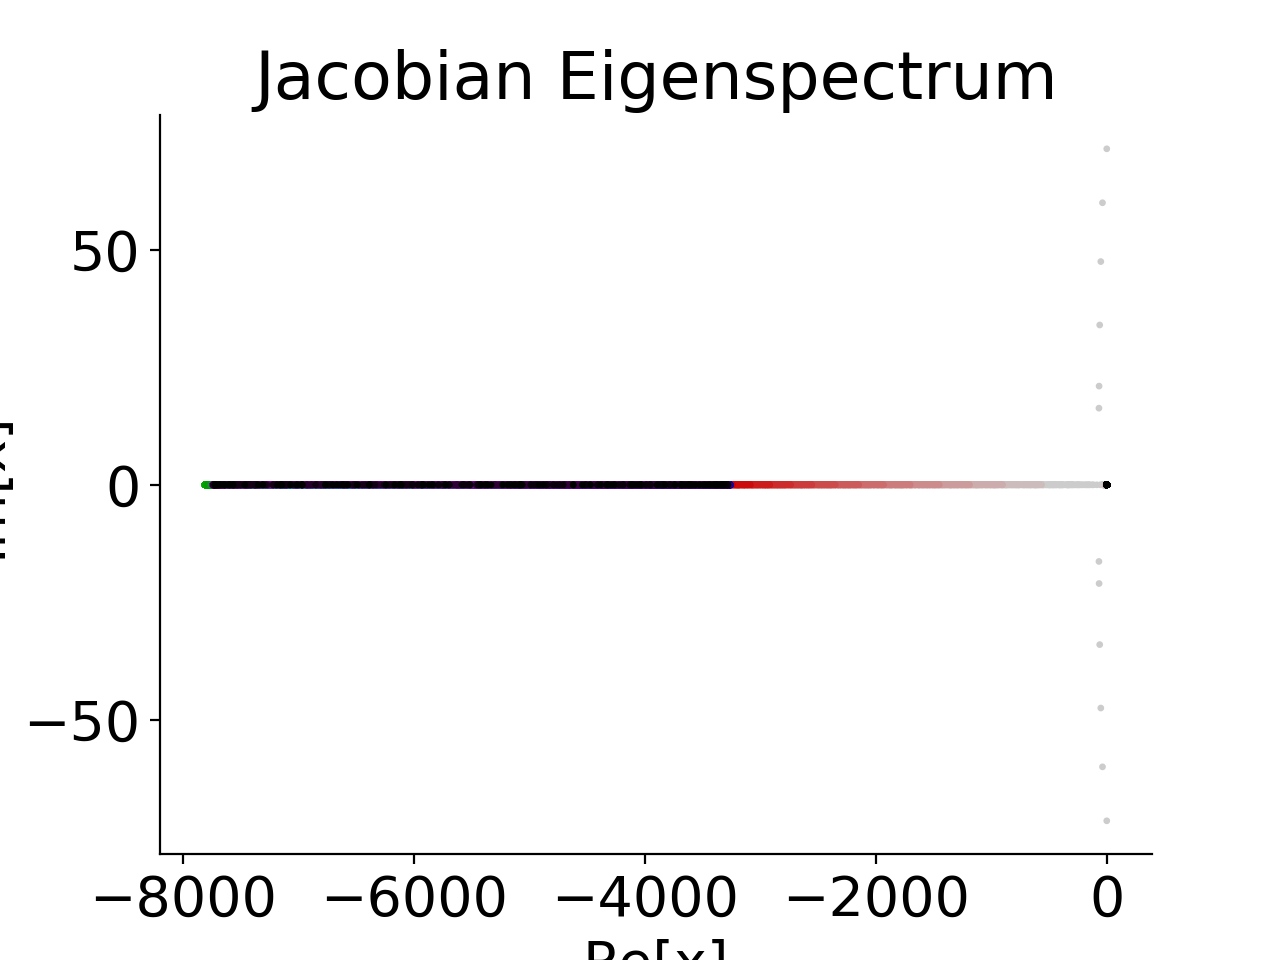

-2.6667442820482075
E*=0.0038, I*=0.0522: stable, with nonzero imaginary components


<IPython.core.display.Javascript object>


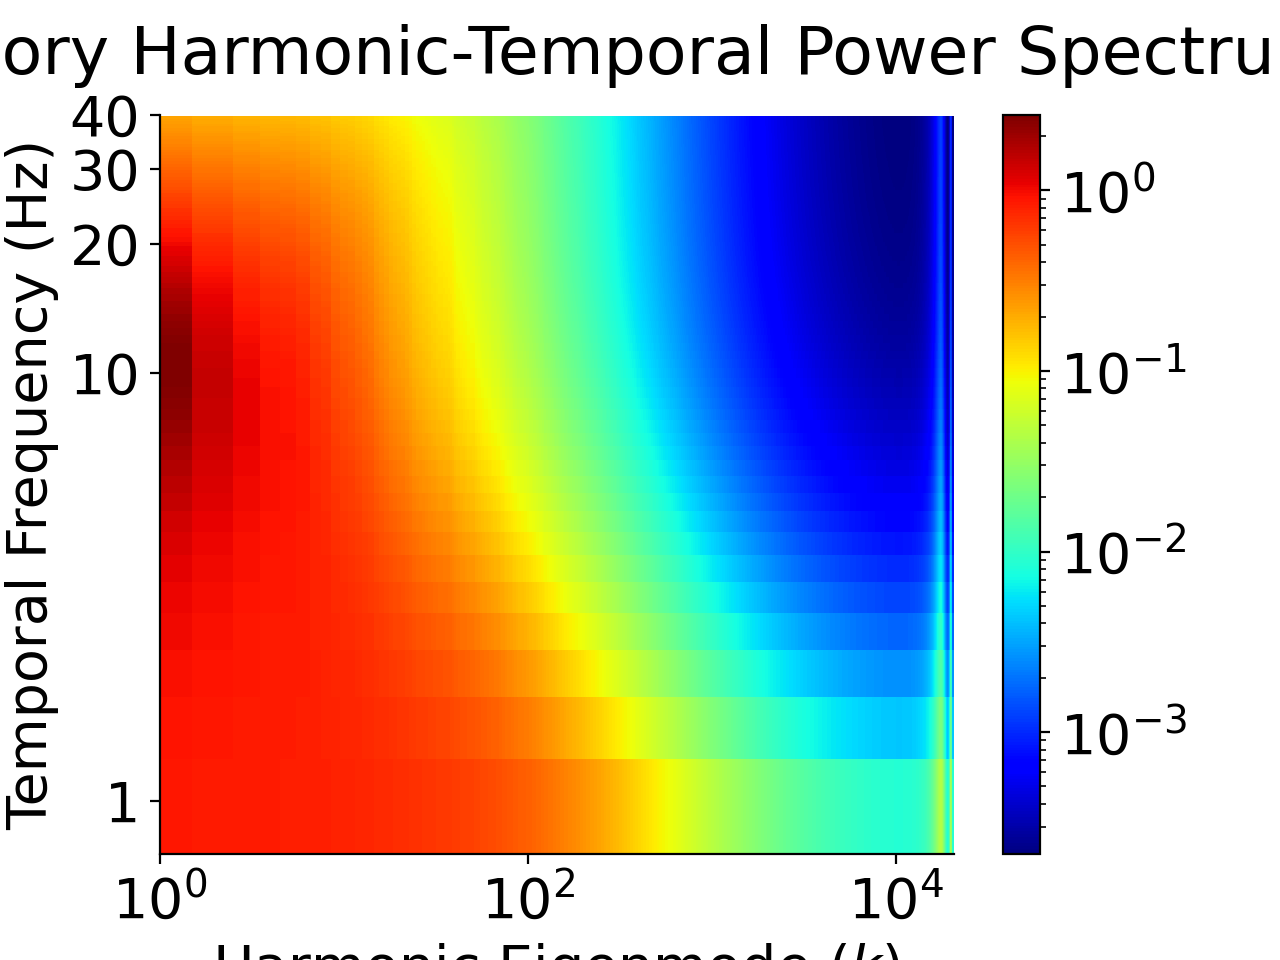

<IPython.core.display.Javascript object>


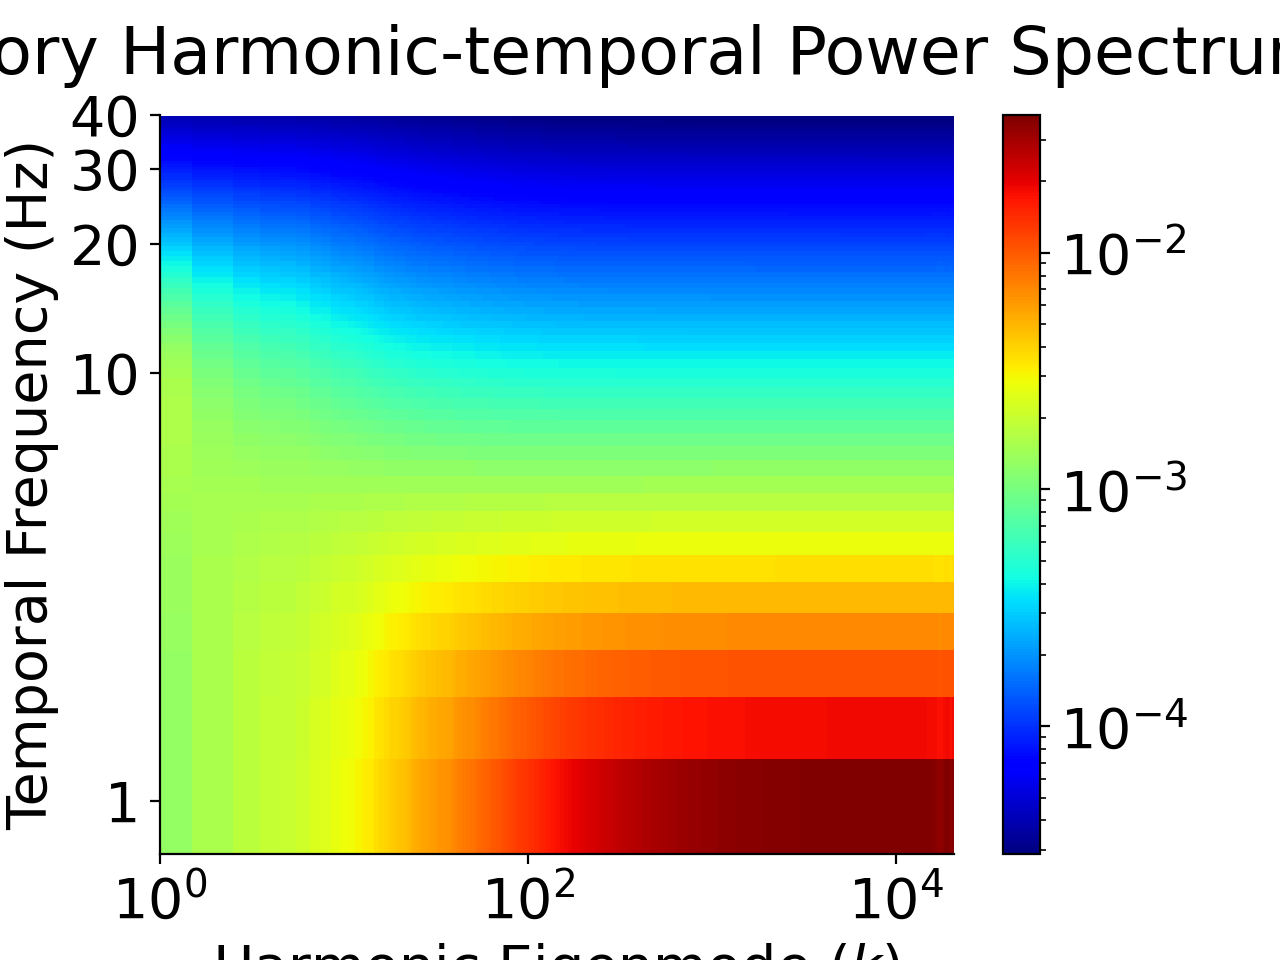

<IPython.core.display.Javascript object>


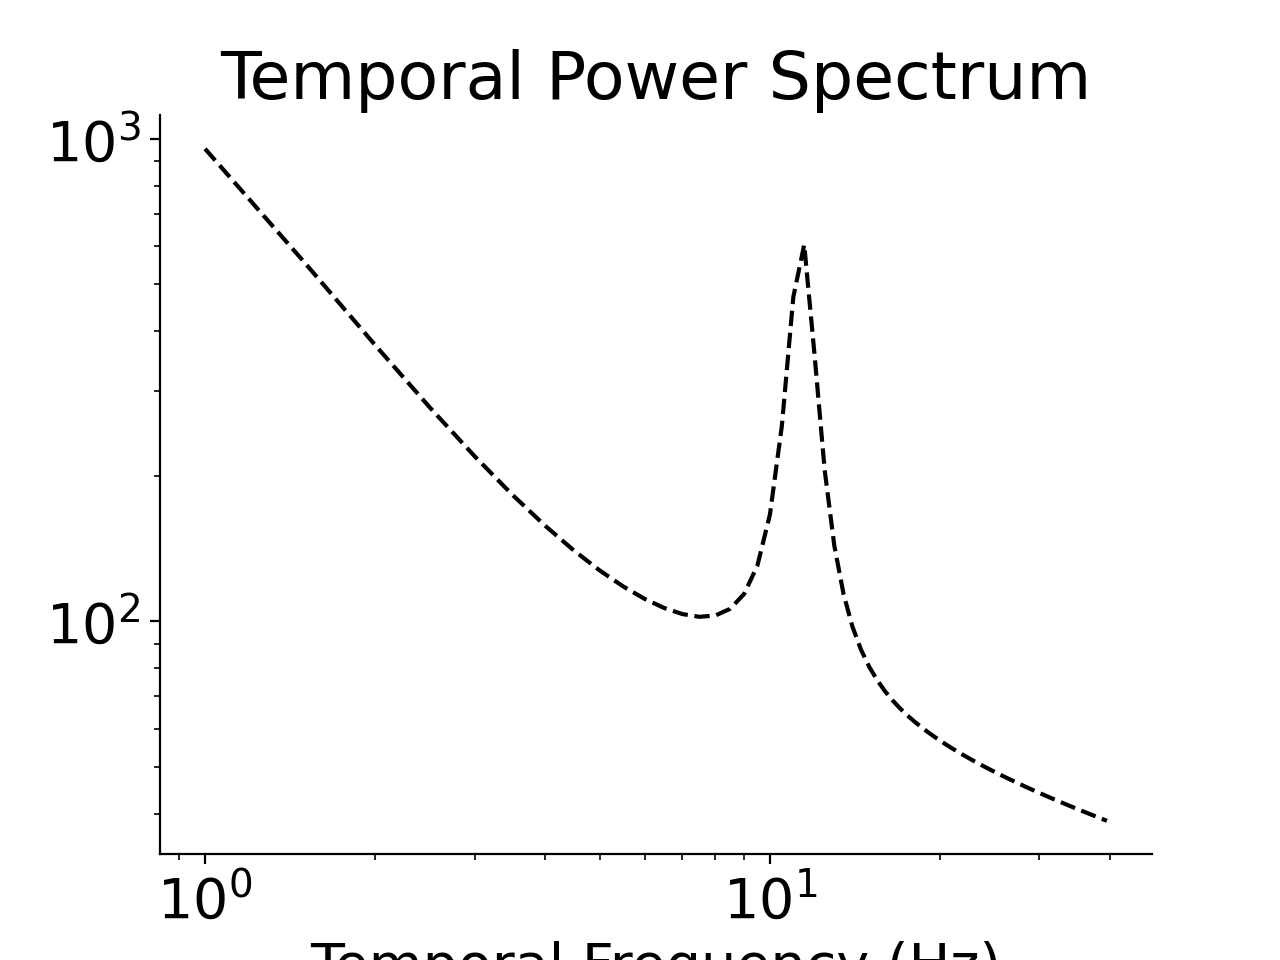

<IPython.core.display.Javascript object>


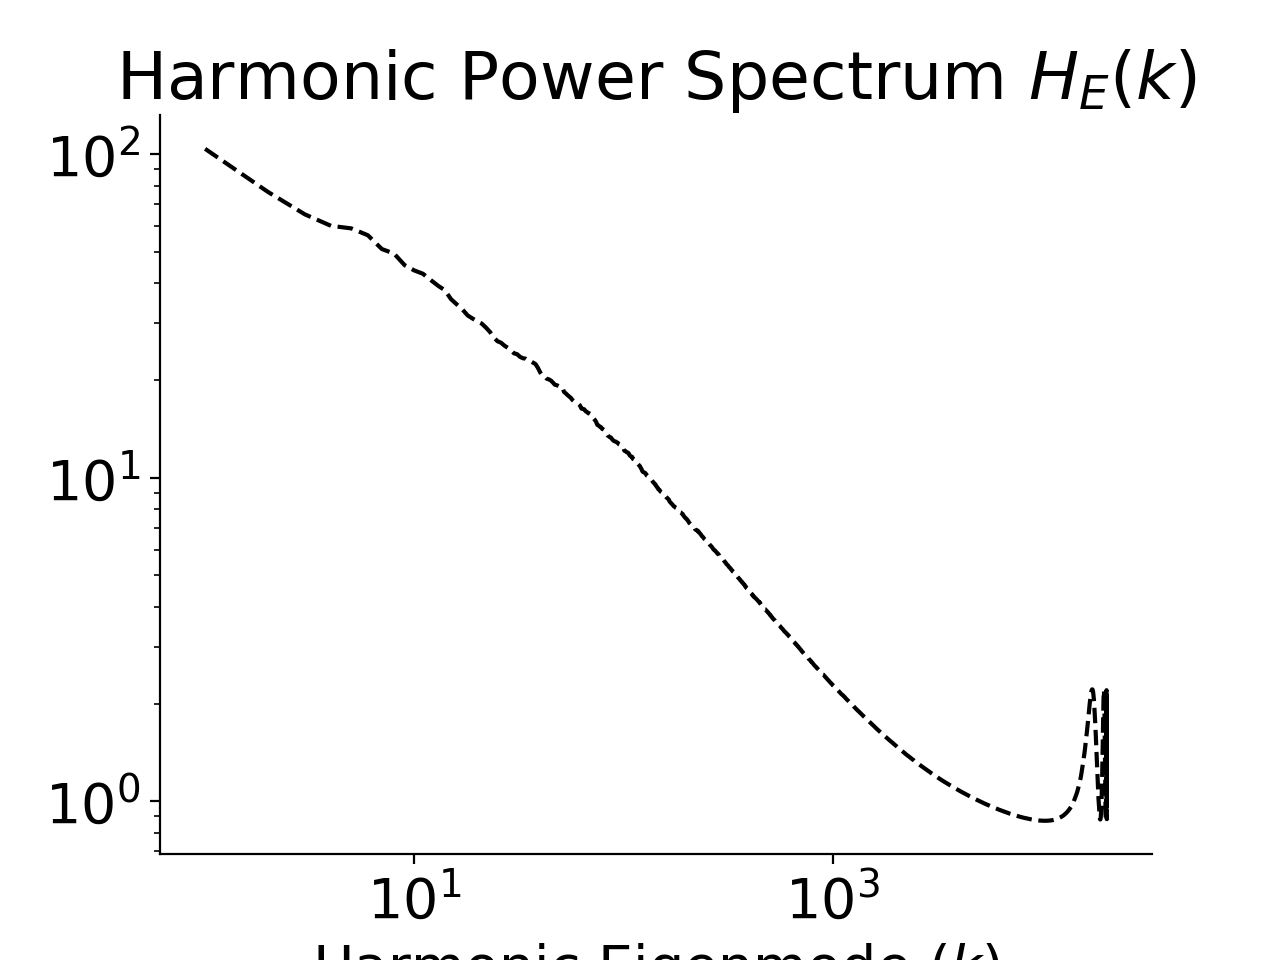

<IPython.core.display.Javascript object>


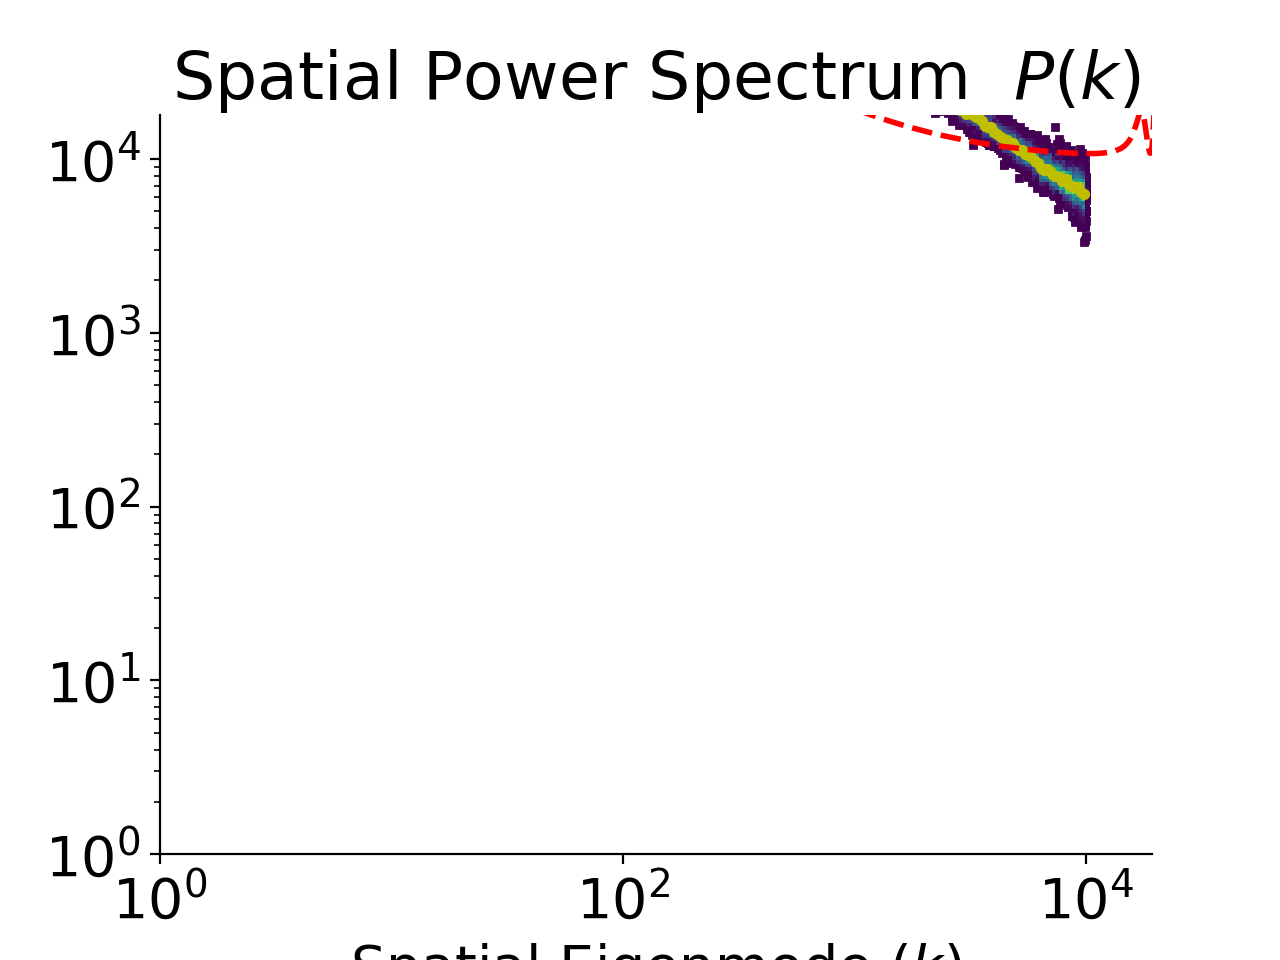

spatial scale factors: [6166.3587 1328.8626 4898.0329]
spatial distance: 1492.9650930843652
KstestResult(statistic=0.44324432443244327, pvalue=1.1367699991934095e-38, statistic_location=10713.97698298333, statistic_sign=1)
KstestResult(statistic=0.2018348623853211, pvalue=0.00026703660861268695, statistic_location=30891.205146291577, statistic_sign=-1)


<IPython.core.display.Javascript object>


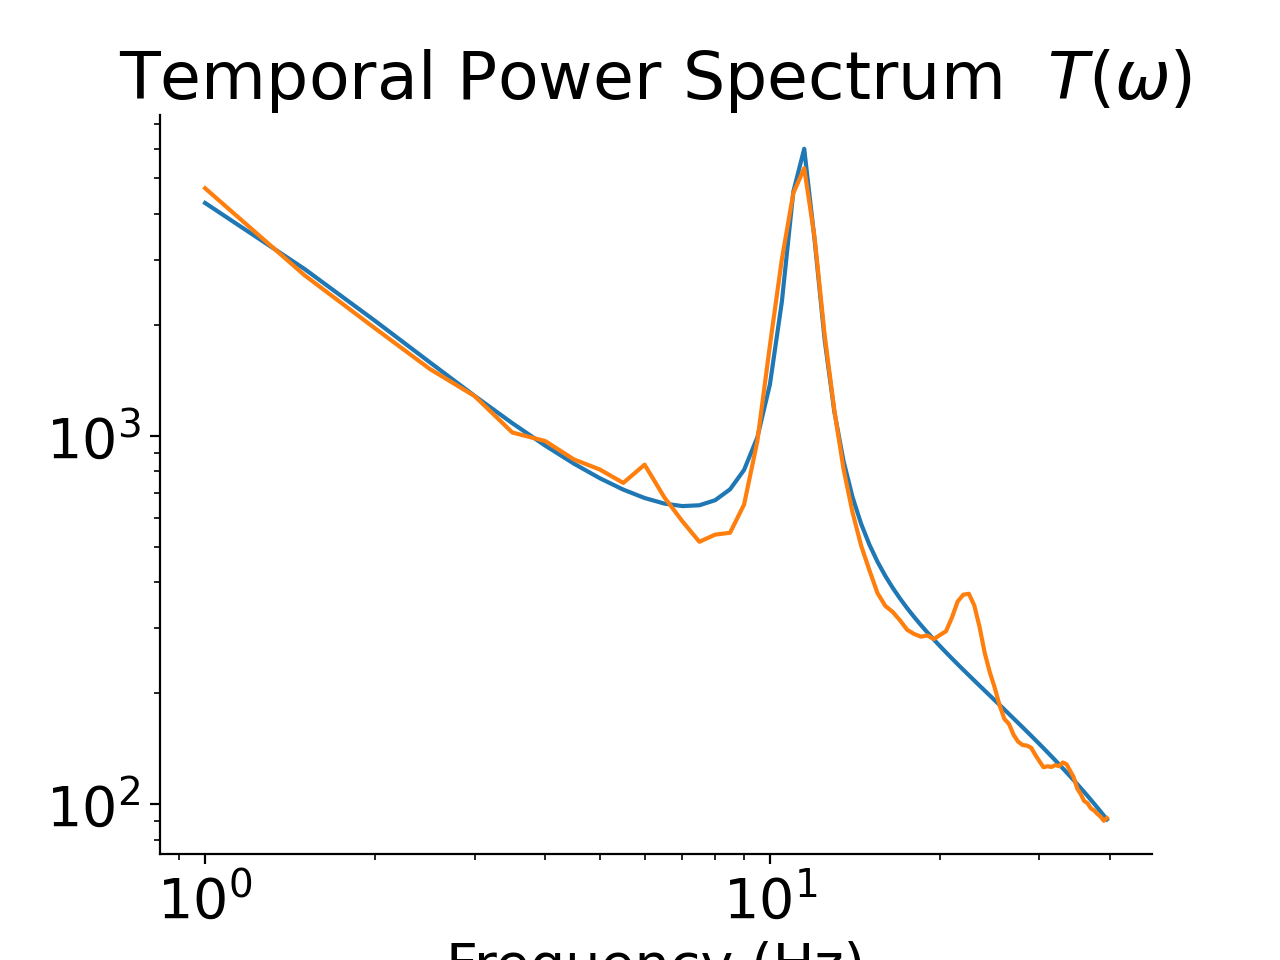

temporal scale factor: [  10.5544   -3.6511 -312.459 ]
temporal distance: 2066.6405776409906
[[1.0 0.9911377369777498]
 [0.9911377369777498 1.0]]
[[1.0 0.7920631246354622]
 [0.7920631246354622 1.0]]
KstestResult(statistic=0.11538461538461539, pvalue=0.6801596116769174, statistic_location=280.0877168574074, statistic_sign=-1)
[3.2275e+02 2.1582e+02 1.9012e+02 2.5587e+02 4.9379e+01 1.0582e-01
 8.5726e+00 2.3759e+00 2.3889e-03 3.5541e-03 1.0000e-02 1.0000e-02
 8.9630e-03 7.5136e-01 5.6475e-07 9.1516e+02 8.4969e+02 4.9238e+02
 3.5901e-01 7.4243e+01 6.4861e+02 5.8311e+02]
total dist 3559.6056707253556


In [113]:
SSnr=0
SStates = np.array([[0.003813,0.0522]]).T
# Best suitable steady state: 0, with Ess=0.003813 Iss=0.0522.                       
# Dist spatial: 1493, scale params: [6170.0315 1328.5838 4896.9869]                        
# Dist temporal: 2092, scale params: [  10.7089   -3.767  -318.5677]
sigma_noise=1#0.0000001

SStype, found_suitable, JacEigs = GraphWC_Jacobian_TrDet(Laplacian_eigenvalues=eigenvalues, Graph_Kernel=Graph_Kernel, Ess=SStates[0,SSnr], Iss=SStates[1,SSnr],
                                     alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], d_e=better_result['x'][4], d_i=better_result['x'][5], 
                                     sigma_EE=better_result['x'][8], sigma_IE=better_result['x'][9], sigma_EI=better_result['x'][10], sigma_II=better_result['x'][11],  
                                     D=1, tau_e=better_result['x'][12], tau_i=better_result['x'][13], 
                                    aDW_EE=better_result['x'][14],aDW_IE=better_result['x'][15], aDW_EI=better_result['x'][16], aDW_II=better_result['x'][17],
                                    bDW_EE=better_result['x'][18], bDW_IE=better_result['x'][19], bDW_EI=better_result['x'][20], bDW_II=better_result['x'][21],
                                                         
                                                         Visual=True)    


E_Spectrum, I_Spectrum = Graph_WC_Spatiotemporal_PowerSpectrum(Laplacian_eigenvalues=eigenvalues, Graph_Kernel=Graph_Kernel, Ess=SStates[0,SSnr], Iss=SStates[1,SSnr],
                                        alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], d_e=better_result['x'][4], d_i=better_result['x'][5], 
                                        sigma_EE=better_result['x'][8], sigma_IE=better_result['x'][9], sigma_EI=better_result['x'][10], sigma_II=better_result['x'][11],  
                                        D=1, tau_e=better_result['x'][12], tau_i=better_result['x'][13],
                                    aDW_EE=better_result['x'][14],aDW_IE=better_result['x'][15], aDW_EI=better_result['x'][16], aDW_II=better_result['x'][17],
                                    bDW_EE=better_result['x'][18], bDW_IE=better_result['x'][19], bDW_EI=better_result['x'][20], bDW_II=better_result['x'][21],
                                               
                                        sigma_noise_e=sigma_noise, sigma_noise_i=sigma_noise,
                                        min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega,
                                        Spatial_Spectrum_Only=False, Visual=True)

Spectrum_spatial_only = Graph_WC_Spatiotemporal_PowerSpectrum(Laplacian_eigenvalues=eigenvalues, Graph_Kernel=Graph_Kernel, Ess=SStates[0,SSnr], Iss=SStates[1,SSnr],
                                        alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], d_e=better_result['x'][4], d_i=better_result['x'][5], 
                                        sigma_EE=better_result['x'][8], sigma_IE=better_result['x'][9], sigma_EI=better_result['x'][10], sigma_II=better_result['x'][11],  
                                        D=1, tau_e=better_result['x'][12], tau_i=better_result['x'][13],
                                    aDW_EE=better_result['x'][14],aDW_IE=better_result['x'][15], aDW_EI=better_result['x'][16], aDW_II=better_result['x'][17],
                                    bDW_EE=better_result['x'][18], bDW_IE=better_result['x'][19], bDW_EI=better_result['x'][20], bDW_II=better_result['x'][21],
                                               
                                        sigma_noise_e=sigma_noise, sigma_noise_i=sigma_noise,
                                        min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega,
                                        Spatial_Spectrum_Only=True, Visual=True)



#import seaborn as sns
#from analysis import find_scaling, NF_to_empirical
Gk_E=Spectrum_spatial_only[:,0,0] #Delta_omega*np.sum(Spectrum,axis=0)/np.pi
Gk_I=Spectrum_spatial_only[:,1,1]
Gw_E=2*np.sum(E_Spectrum,axis=1)
Gw_I=2*np.sum(I_Spectrum,axis=1)
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Spatial Power Spectrum  $P(k)$")
ax.set_xlabel("Spatial Eigenmode ($k$)")

if not fit_to_median:
    E_spatial_spectrum = Gk_E
    I_spatial_spectrum = Gk_I
    SPS_points = np.arange(first_k,last_k)
else:
    E_spatial_spectrum = np.array([np.median(elem) for elem in np.array_split(Gk_E[first_k:last_k], bins)])
    I_spatial_spectrum = np.array([np.median(elem) for elem in np.array_split(Gk_I[first_k:last_k], bins)])
    SPS_points = np.array([elem.mean() for elem in np.array_split(np.arange(first_k,last_k), bins)])

    
# a_matrix_spatial = np.vstack((E_spatial_spectrum,
#                               I_spatial_spectrum,
#                            #   E_spatial_spectrum*I_spatial_spectrum,
#                               np.ones_like(True_Spatial_Spectrum))).T

#scale_params_spatial = np.linalg.lstsq(a_matrix_spatial, True_Spatial_Spectrum)[0]    
scale_params_spatial = sp.optimize.minimize(find_scaling, x0=[1,0,0], tol=1e-4, args=(E_spatial_spectrum,I_spatial_spectrum,True_Spatial_Spectrum),
                                        bounds=[(0,1e5),(-1e5,1e5),(-1e5,1e5)])['x']
#scale_params_spatial = np.array([(True_Spatial_Spectrum.mean())/(E_spatial_spectrum.mean())])

# n_spatial = len(True_Spatial_Spectrum)    
# a_spatial = (n_spatial*np.dot(E_spatial_spectrum,True_Spatial_Spectrum)-np.sum(True_Spatial_Spectrum)*np.sum(E_spatial_spectrum))/(n_spatial*np.dot(E_spatial_spectrum,E_spatial_spectrum)-np.sum(E_spatial_spectrum)**2)
# b_spatial = (np.sum(True_Spatial_Spectrum)-a_spatial*np.sum(E_spatial_spectrum))/n_spatial
# scale_params_spatial = np.array([a_spatial,b_spatial])

current_spatial_spectrum = NF_to_empirical(scale_params_spatial,
                                           E_spatial_spectrum,
                                           I_spatial_spectrum)

#to avoid log10 throwing tantrums. but of course no "good" spectrum should have negative values                    
current_spatial_spectrum[current_spatial_spectrum<=0] = 1e-10

data_1=np.vstack((SPS_points, np.log10(True_Spatial_Spectrum))).T
data_2=np.vstack((SPS_points, np.log10(current_spatial_spectrum))).T   

dist_spatial = (1+sm.area_between_two_curves(data_1,data_2))**1

#np.linalg.norm(np.log10(True_Spatial_Spectrum) - np.log10(current_spatial_spectrum), ord=1)#sm.area_between_two_curves(data_1,data_2)#np.linalg.norm((np.log10(True_Spatial_Spectrum) - np.log10(current_spatial_spectrum), ord=1)#np.linalg.norm(True_Spatial_Spectrum - a_spatial*current_spatial_spectrum-b_spatial, ord=2)#1-sp.stats.ks_2samp(True_Spatial_Spectrum, current_spatial_spectrum*a_spatial+b_spatial)[1]#1-np.ma.corrcoef(True_Spatial_Spectrum, current_spatial_spectrum)[0,1]#

dist_spatial += (1+np.linalg.norm(np.log10(True_Spatial_Spectrum)-np.log10(current_spatial_spectrum), ord=2))**2

dist_spatial += (1+np.linalg.norm((np.log10(True_Spatial_Spectrum[1:])-np.log10(True_Spatial_Spectrum[:-1]))-(np.log10(current_spatial_spectrum[1:])-np.log10(current_spatial_spectrum[:-1])), ord=2))**2

print("spatial scale factors: {}".format(scale_params_spatial))
print("spatial distance: {}".format(dist_spatial))

ax.loglog(np.arange(first_k, last_k), empirical_SPS, marker='s', linestyle='', markersize=2, zorder=0, color=[0.267004, 0.004874, 0.329415, 1.])
plot_bins = np.unique(np.logspace(0, np.log10(20000), num=300, dtype=int))[:-1]
y_bins = np.unique(np.logspace(0, np.log10(18715), num=200, dtype=int))[:-1]
ax.hist2d(np.arange(first_k, last_k), empirical_SPS, (plot_bins, y_bins), cmap='viridis',zorder=1,cmin=2)

ax.loglog(np.arange(len(eigenvalues)),  NF_to_empirical(scale_params_spatial,Gk_E,Gk_I), zorder=3,color='red', linestyle='--', linewidth=2)
plt.errorbar(x=binned_SPS_points, y=binned_SPS, yerr=binned_SPS_err, zorder=2, fmt='yo-',markersize=3)

print(sp.stats.ks_2samp(empirical_SPS,  current_spatial_spectrum))
print(sp.stats.ks_2samp(True_Spatial_Spectrum, current_spatial_spectrum))
      
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_title("Temporal Power Spectrum  $T(\omega)$")
ax.set_xlabel("Frequency (Hz)")

freqs=np.arange(Min_omega,Max_omega,Delta_omega)

# a_matrix_temporal = np.vstack((Gw_E,
#                                Gw_I,
#                               # Gw_E*Gw_I,
#                                np.ones_like(True_Temporal_Spectrum))).T

# scale_params_temporal = np.linalg.lstsq(a_matrix_temporal, True_Temporal_Spectrum)[0]
scale_params_temporal = sp.optimize.minimize(find_scaling, x0=[1,0,0], tol=1e-4, args=(Gw_E,
                                                Gw_I,True_Temporal_Spectrum),
                                        bounds=[(0,1e5),(-1e5,1e5),(-1e5,1e5)])['x']
#scale_params_temporal = np.array([(True_Temporal_Spectrum.mean())/(Gw_E.mean())])

current_temporal_spectrum = NF_to_empirical(scale_params_temporal,
                                            Gw_E, Gw_I)

#to avoid log10 throwing tantrums. but of course no "good" spectrum should have negative values
#current_temporal_spectrum[current_temporal_spectrum<=0] = 1e-10

data_3=np.vstack((np.arange(Min_omega,Max_omega,Delta_omega),np.log10(True_Temporal_Spectrum))).T
data_4=np.vstack((np.arange(Min_omega,Max_omega,Delta_omega),np.log10(current_temporal_spectrum))).T        
dist_temporal = (1+sm.area_between_two_curves(data_3,data_4))**3#np.linalg.norm(np.log10(True_Temporal_Spectrum) - np.log10(current_temporal_spectrum), ord=1)#sm.area_between_two_curves(data_3,data_4)#np.linalg.norm(True_Temporal_Spectrum - current_temporal_spectrum, ord=1)##np.linalg.norm(True_Temporal_Spectrum - a_temporal*current_temporal_spectrum-b_temporal, ord=2)#1-sp.stats.ks_2samp(True_Temporal_Spectrum, current_temporal_spectrum*a_temporal+b_temporal)[1]#1-np.ma.corrcoef(True_Temporal_Spectrum, current_temporal_spectrum)[0,1]#
dist_temporal += (1+np.linalg.norm(np.log10(True_Temporal_Spectrum)-np.log10(current_temporal_spectrum), ord=2))**3

dist_temporal += (1+np.linalg.norm((np.log10(True_Temporal_Spectrum[1:])-np.log10(True_Temporal_Spectrum[:-1]))-(np.log10(current_temporal_spectrum[1:])-np.log10(current_temporal_spectrum[:-1])), ord=2))**3

print("temporal scale factor: {}".format(scale_params_temporal))
print("temporal distance: {}".format(dist_temporal))

print(np.ma.corrcoef(True_Temporal_Spectrum, current_temporal_spectrum))
print(np.ma.corrcoef(True_Spatial_Spectrum, current_spatial_spectrum))

print(sp.stats.ks_2samp(True_Temporal_Spectrum, current_temporal_spectrum))

ax.loglog(freqs/(2*np.pi),
            current_temporal_spectrum)
ax.loglog(freqs/(2*np.pi), 
            True_Temporal_Spectrum)

#np.save('decent_spatiotemporal_spectrum.npy', better_result)
print(better_result['x'])
print(f"total dist {dist_spatial+dist_temporal}")

In [ ]:
#np.load('decent_spatiotemporal_spectrum_lower_gauss.npy')[()]['x']-better_result['x']
#current best (loglog space fitting)
[ 1.06682212e+03,  1.73415339e+02,  2.92699896e+03,  2.95074005e+02,
  9.07838853e+01,  3.19257788e+00,  7.47262994e+00, -1.76660214e-02,
  5.43684383e-04, -1.75210509e-09,  5.52478781e-04,  5.40207870e+04,
  9.29655089e+00,  3.27876977e-01]
#logspace excellent s2.16 t0.86 (kstat pval 0.21 0.68)
better_result['x'] [ 1.60298254e+03,  1.84931805e+02,  2.99551387e+03,  2.80138120e+02,
  9.29297308e+01,  1.22714483e+00,  7.24240357e+00,  3.71750330e-01,
  4.34632128e-04,  2.05916610e-05,  6.11898211e-04, -3.38503489e+10,
  6.93229886e+00,  1.51916190e-01]
#np.save('stps_empirical_first_loglog_median_fitting.npy', better_result)
[6.32352428e+02, 7.93766496e+01, 3.47535746e+02, 1.07039076e+02,
       1.56586247e+02, 4.22226636e+00, 1.54479298e+01, 2.49662094e+01,
       4.31042051e-02, 2.44534241e-03, 4.77988694e-02, 5.17697376e-02,
       1.37486268e-01, 6.30906093e-01])

better_result['x']=[ 1.06682212e+03,  1.73415339e+02,  2.92699896e+03,  2.95074005e+02,
  9.07838853e+01,  3.19257788e+00,  7.47262994e+00, -1.76660214e-02,
  5.43684383e-04, -1.75210509e-09,  5.52478781e-04,  5.40207870e+04,
  9.29655089e+00,  3.27876977e-01]

In [ ]:
#np.save('stps_empirical_loglog_median_fitting.npy', better_result)

In [ ]:
#comparison of numerical (nonlinear) simulations and (linearized) semi analytic results 
#(any parameter set; grid laplacian only):
#
#1) test for steady state calculation: simulate (with no noise) on a grid, start directly from SS solution.
#2) test for stability/instability/oscillations: add noise in the grid simulation for specific parameter sets
#3) test for power spectrum calculation: run noisy grid simulation and compare prediction with measured PS (see handwritten notes)
#
################################################################################################
#testing the correctness of the parameter fit procedure(full analysis + minimization algorithm) result
#(intended mainly for the better_result parameter set)
#
#retest minimization algorithm, with objective the current best-fit PS obtained and random initial condition. see if other parameter combinations give the same, ideally converge to same par. set
#
#check (via effect on linearized Jk eigenvalues) if a nearby hopf bifurcation can be induced by changing P or some other parameter 
#(to ask rikkert: do we want this as a prior requirement in minimization? would be hard but doable)
#

# simulations

<IPython.core.display.Javascript object>


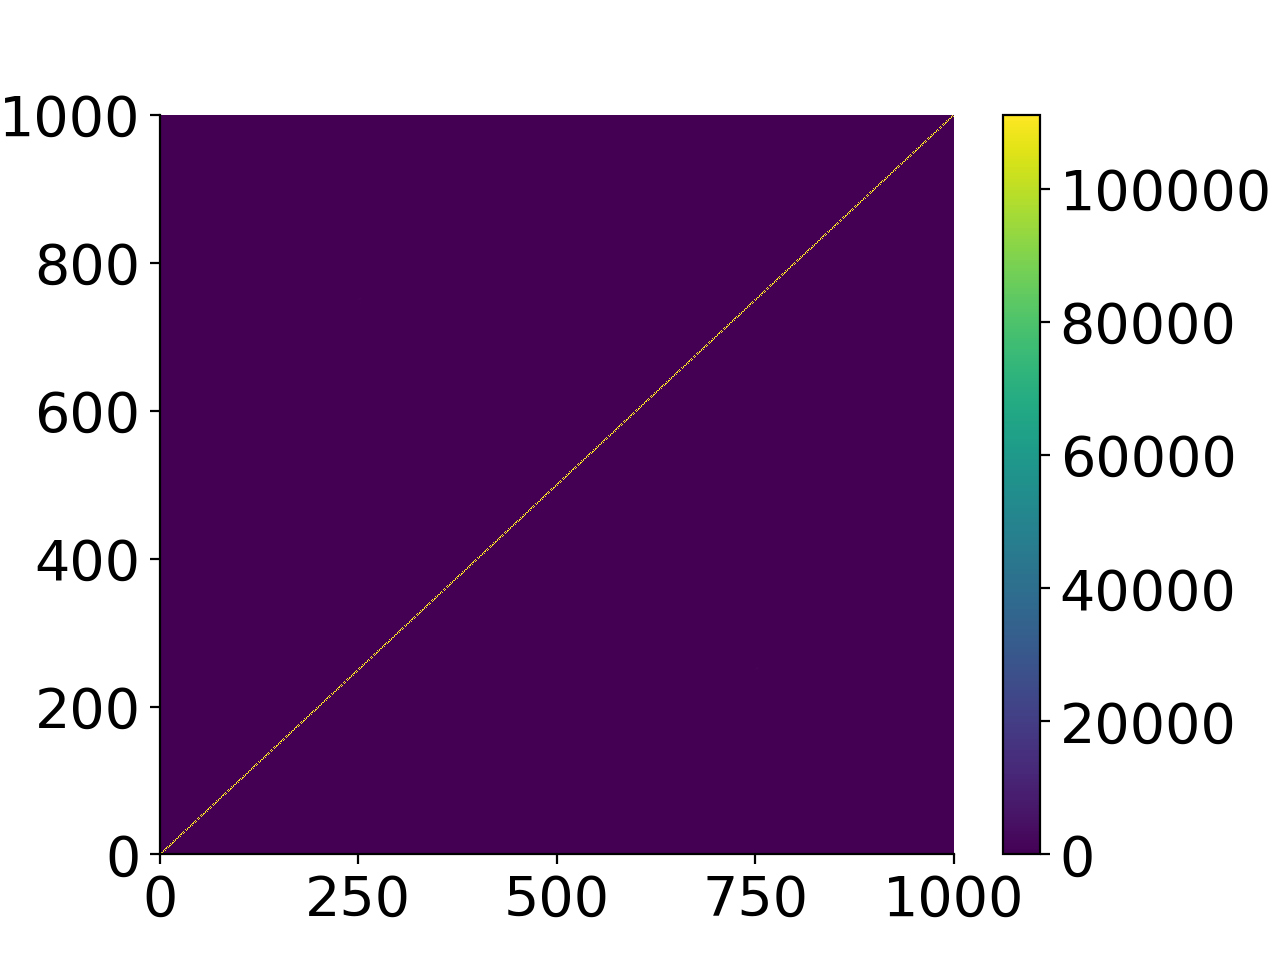

<IPython.core.display.Javascript object>


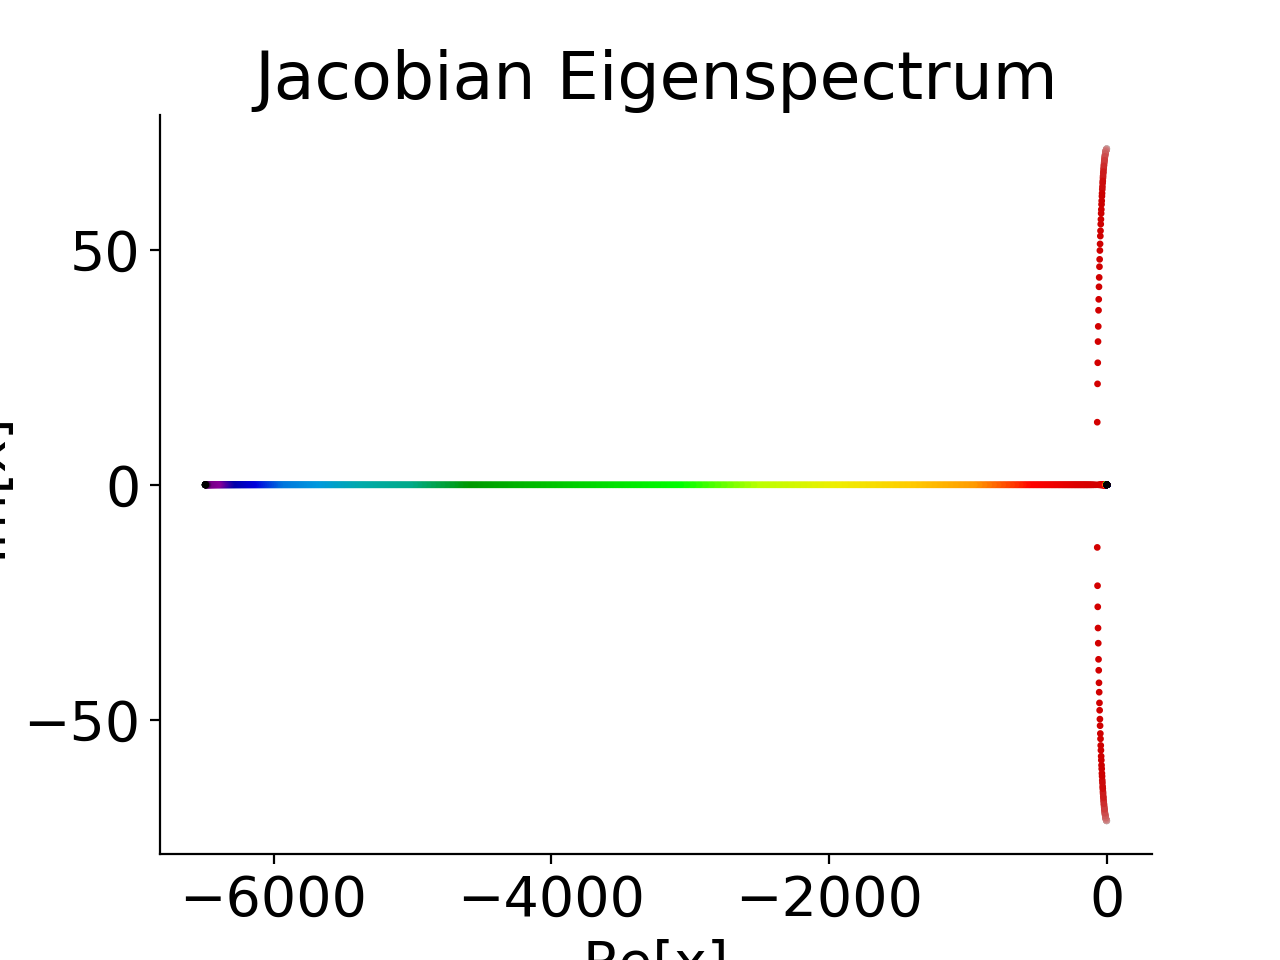

-2.7996055298532396
E*=0.0038, I*=0.0522: stable, with nonzero imaginary components


<IPython.core.display.Javascript object>


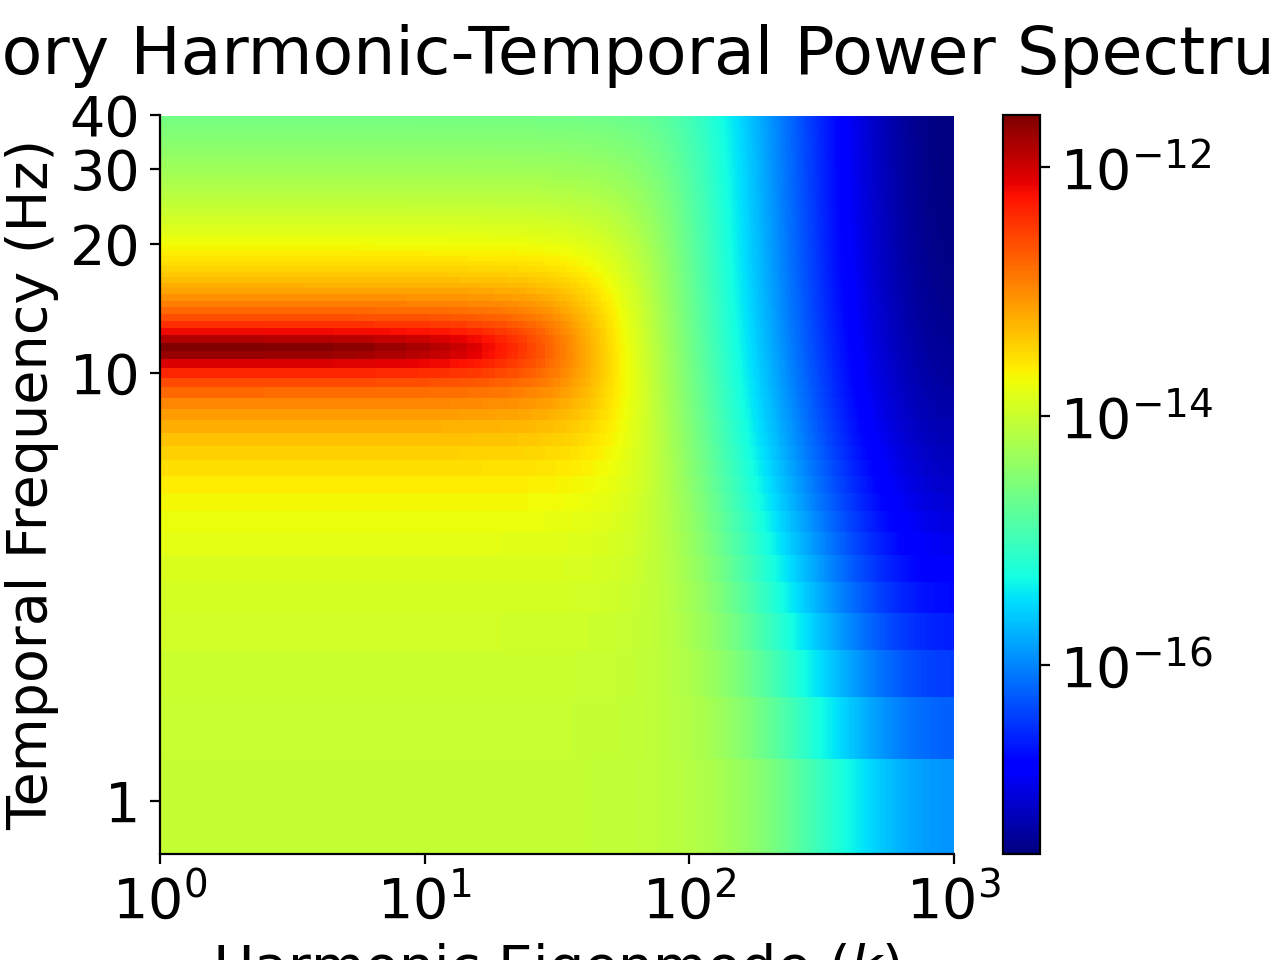

<IPython.core.display.Javascript object>


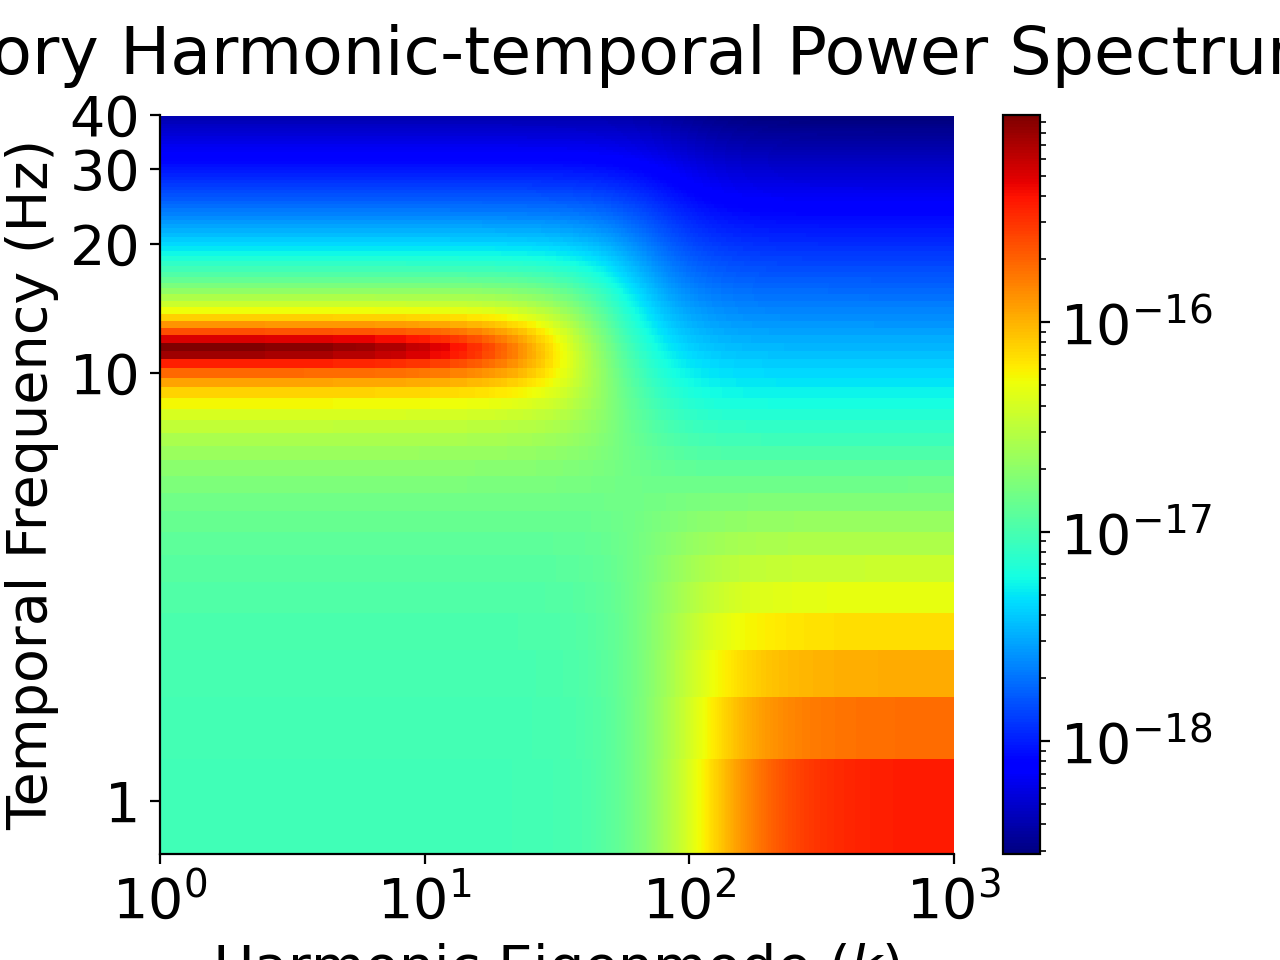

<IPython.core.display.Javascript object>


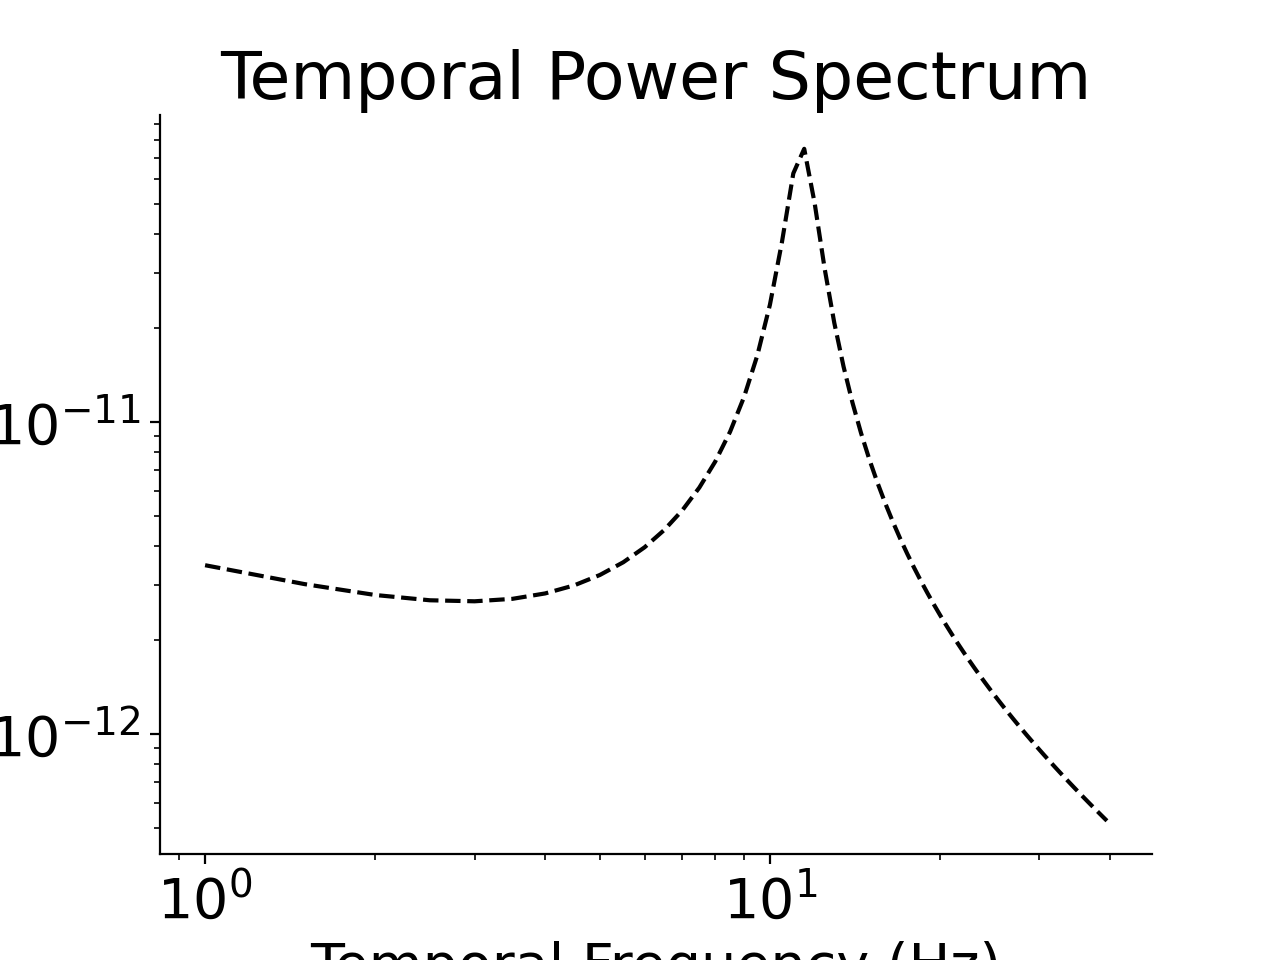

<IPython.core.display.Javascript object>


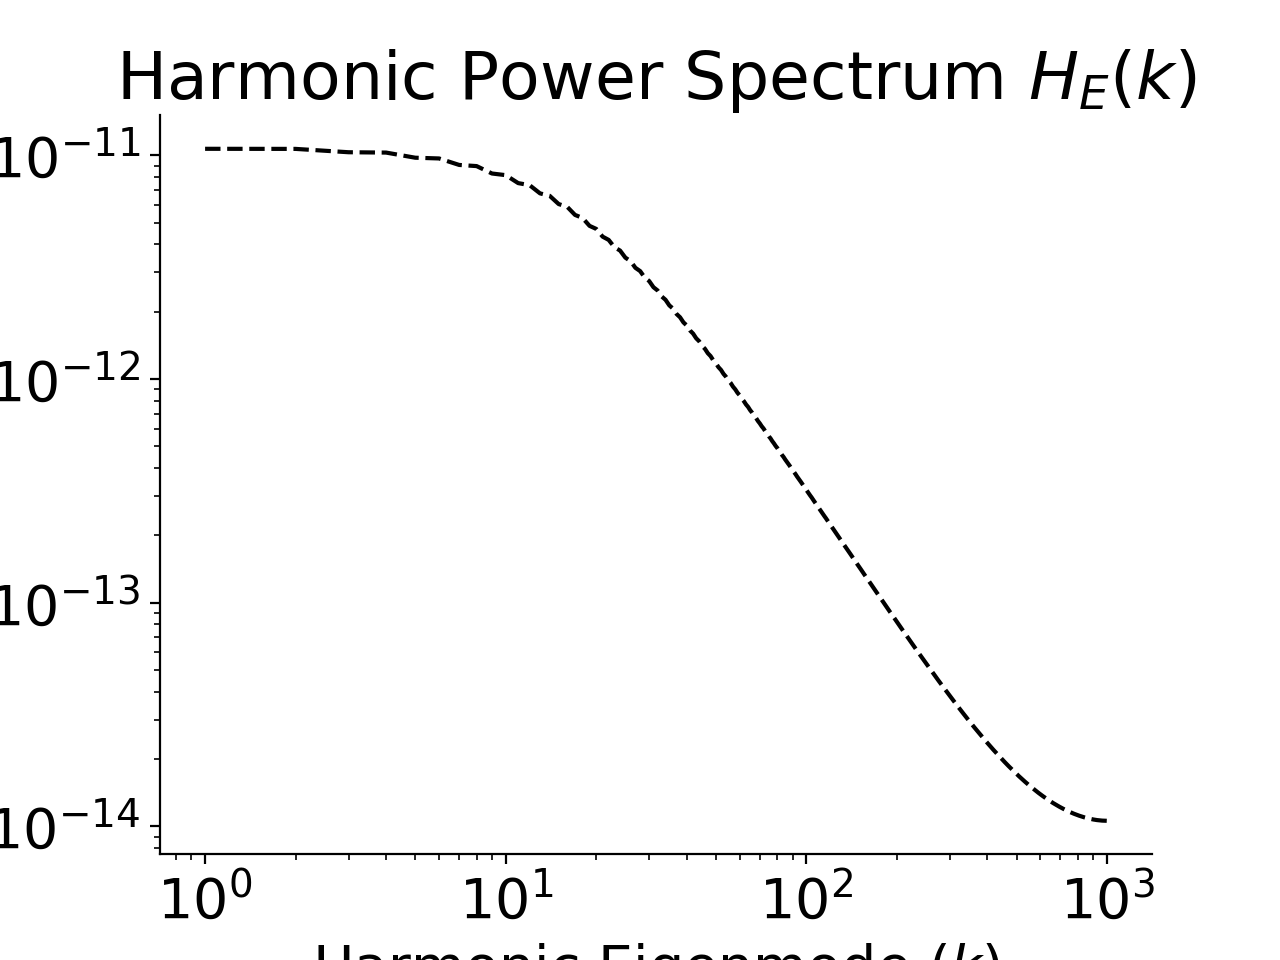

<IPython.core.display.Javascript object>


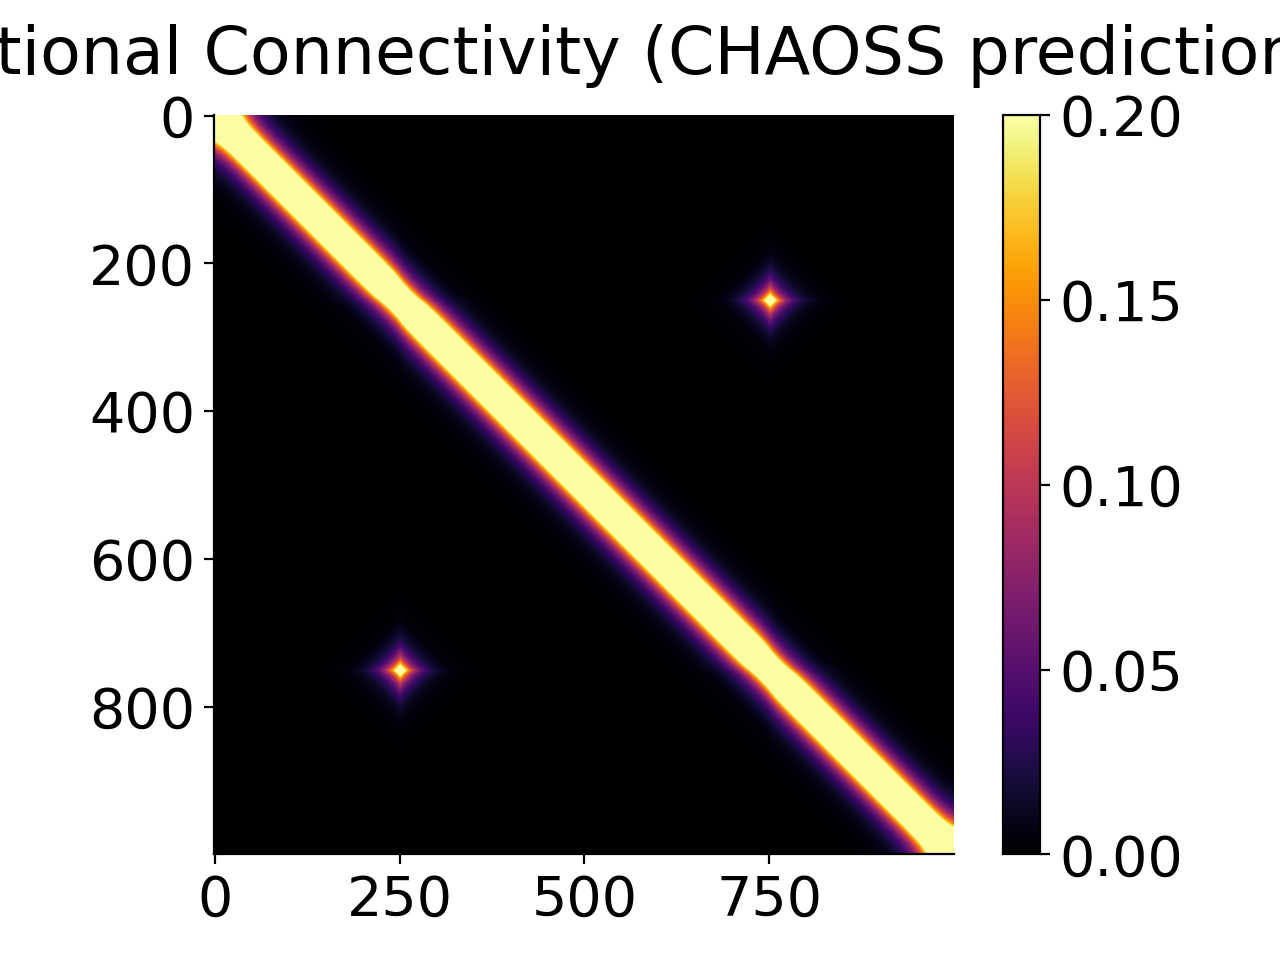

In [119]:
#1D predictions
#set up 1D-specific simulation parameters and WCM propagators
one_dim=True
syn=3
#if making plot from connectome minimization, need to change this value to the number of connectome nodes
gridsize=1000#len(eigenvalues)
h=0.003
#Min_omega=5*(2*np.pi)
#Max_omega=50*(2*np.pi)
#Delta_omega=0.1*(2*np.pi)

Graph_Kernel='Damped Wave'
one_dim_eigenvalues, one_dim_eigenvectors = one_dim_Laplacian_eigenvalues(gridsize, h, syn, vecs=True)
#one_dim_eigenvalues2 = one_dim_Laplacian_eigenvalues(gridsize, h, syn)

#re-analyze result of minimization procedure
#better_result=np.load('decent_spatiotemporal_spectrum.npy')[()]

#better_result=np.load('decent_spatiotemporal_spectrum_lower_gauss.npy')[()]

#better_result=np.load('decent_spatiotemporal_spectrum_even_lower_gauss.npy')[()]

#better_result=np.load('decent_spatiotemporal_spectrum_lowest_gauss.npy')[()]

#thesis result
#better_result=dict(x=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
#       1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
#       8.37626732e+00, 2.74681544e+00, 3.66503548e-02, 1.00910684e+02,
#       4.95497870e+00, 4.47579295e+00]))

#better_result=dict(x=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
#       1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
#       8.37626732e+00, 2.74681544e+00, 3.66503548e-02, 1.00910684e+02,
#       4.95497870e+00, 4.47579295e+00]))f

aEE=better_result['x'][0]
aIE=better_result['x'][1]
aEI=better_result['x'][2]
aII=better_result['x'][3]
dE=better_result['x'][4]
dI=better_result['x'][5]
P=better_result['x'][6]
Q=better_result['x'][7]
sEE=better_result['x'][8]
sIE=better_result['x'][9]
sEI=better_result['x'][10]
sII=better_result['x'][11]
D=1
tE=better_result['x'][12]
tI=better_result['x'][13]
aDWEE=better_result['x'][14]
aDWIE=better_result['x'][15]
aDWEI=better_result['x'][16]
aDWII=better_result['x'][17]
bDWEE=better_result['x'][18]
bDWIE=better_result['x'][19]
bDWEI=better_result['x'][20]
bDWII=better_result['x'][21]

snE=0.0000001
#snE=0.0001
snI=snE

#given parameters, calculate steady states
steady_states, success = H_Simple_Steady_State(aEE, aIE, aEI, aII, dE, dI, P, Q)
steady_states = np.array([[0.003813,0.0522]]).T



#for each steady state, compute linear stability and power spectrum
if success==True:
    nrSS=len(steady_states[0])
    allG = np.empty((nrSS,int((Max_omega-Min_omega)/Delta_omega),gridsize), dtype=float)
    allGI = np.empty((nrSS,int((Max_omega-Min_omega)/Delta_omega),gridsize), dtype=float)
    SStypes=np.zeros(nrSS)
    for ss in range(nrSS):

        Ess = steady_states[0,ss]
        Iss = steady_states[1,ss]

        SStypes[ss], found_suitable, JacEigs = GraphWC_Jacobian_TrDet(one_dim_eigenvalues, Graph_Kernel, Ess, Iss,
                                         alpha_EE=aEE, alpha_IE=aIE, alpha_EI=aEI, alpha_II=aII, d_e=dE, d_i=dI,
                                         sigma_EE=sEE, sigma_IE=sIE, sigma_EI=sEI, sigma_II=sII, D=D, 
                                         tau_e=tE, tau_i=tI,
                                                                      
                                    aDW_EE=aDWEE,aDW_IE=aDWIE, aDW_EI=aDWEI, aDW_II=aDWII,
                                    bDW_EE=bDWEE, bDW_IE=bDWIE, bDW_EI=bDWEI, bDW_II=bDWII,
                                               Visual=True) 

        #allG[ss,:,:] = 
        allG[ss,:,:], allGI[ss,:,:] =Graph_WC_Spatiotemporal_PowerSpectrum(one_dim_eigenvalues, Graph_Kernel, Ess, Iss,
                                                aEE, aIE, aEI, aII, dE, dI,
                                                 sEE, sIE, sEI, sII, D, 
                                                 tE, tI,
                                                
                                    aDWEE,aDWIE, aDWEI, aDWII,
                                    bDWEE, bDWIE, bDWEI, bDWII,        
                                                 snE, snI, 
                                                  Min_omega, Max_omega, Delta_omega,          
                                                   Spatial_Spectrum_Only=False, Visual=True)
        
        sspectrum =Graph_WC_Spatiotemporal_PowerSpectrum(one_dim_eigenvalues, Graph_Kernel, Ess, Iss,
                                                aEE, aIE, aEI, aII, dE, dI,
                                                 sEE, sIE, sEI, sII, D, 
                                                 tE, tI,
                                                         
                                    aDWEE,aDWIE, aDWEI, aDWII,
                                    bDWEE, bDWIE, bDWEI, bDWII,   
                                                 snE, snI,         
                                                   Spatial_Spectrum_Only=True, Visual=True)
        

        
        Func_Conn_prediction = Functional_Connectivity(one_dim_eigenvectors, sspectrum[:,0,0], Visual=True)
        

        

In [ ]:
np.save('fun_FC.npy',FC)

2.8533566784253853e-06 6.3159491332839985e-06 5e-05 5e-05


<IPython.core.display.Javascript object>


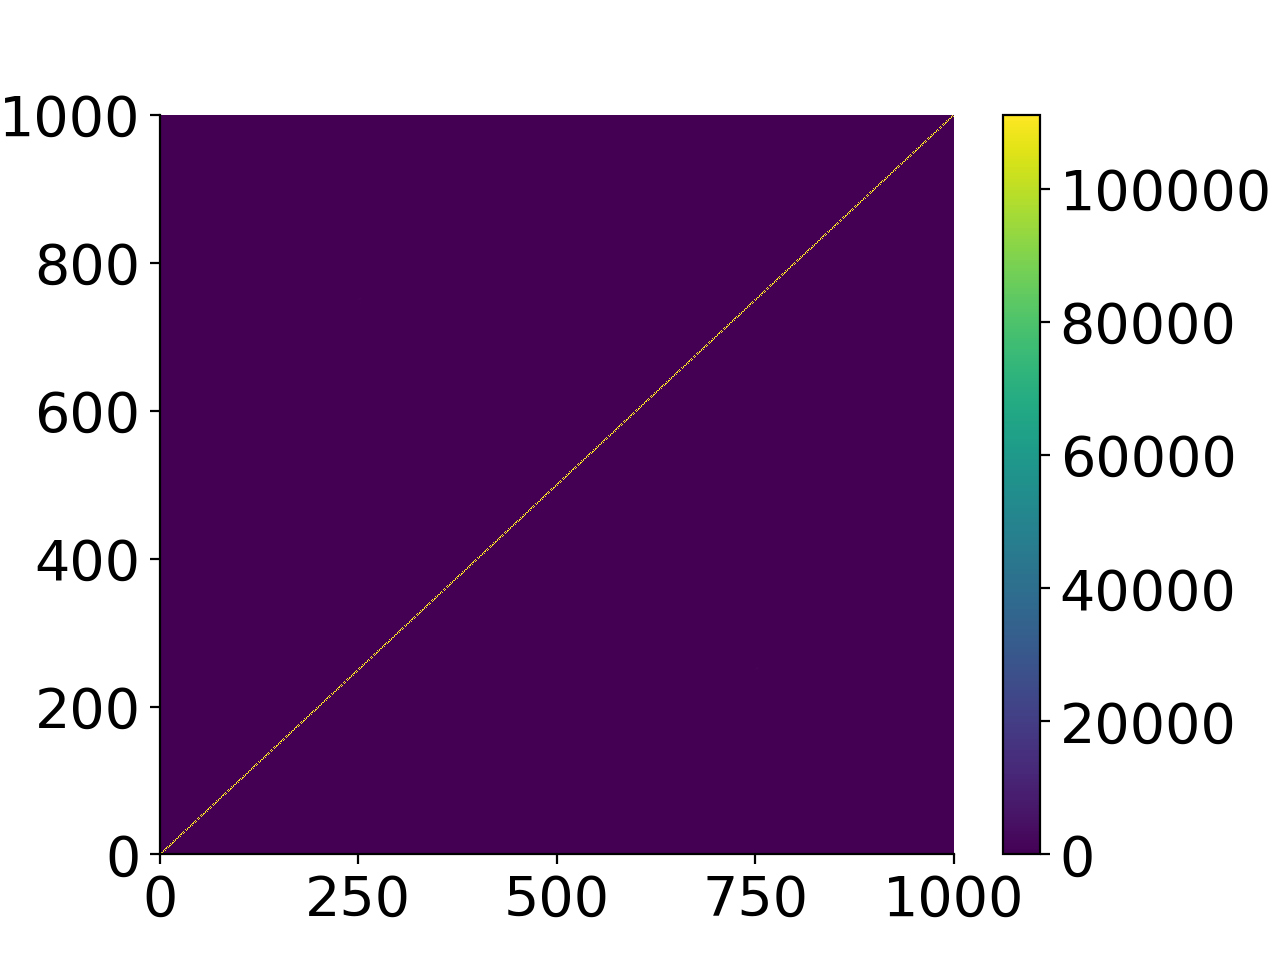

<IPython.core.display.Javascript object>


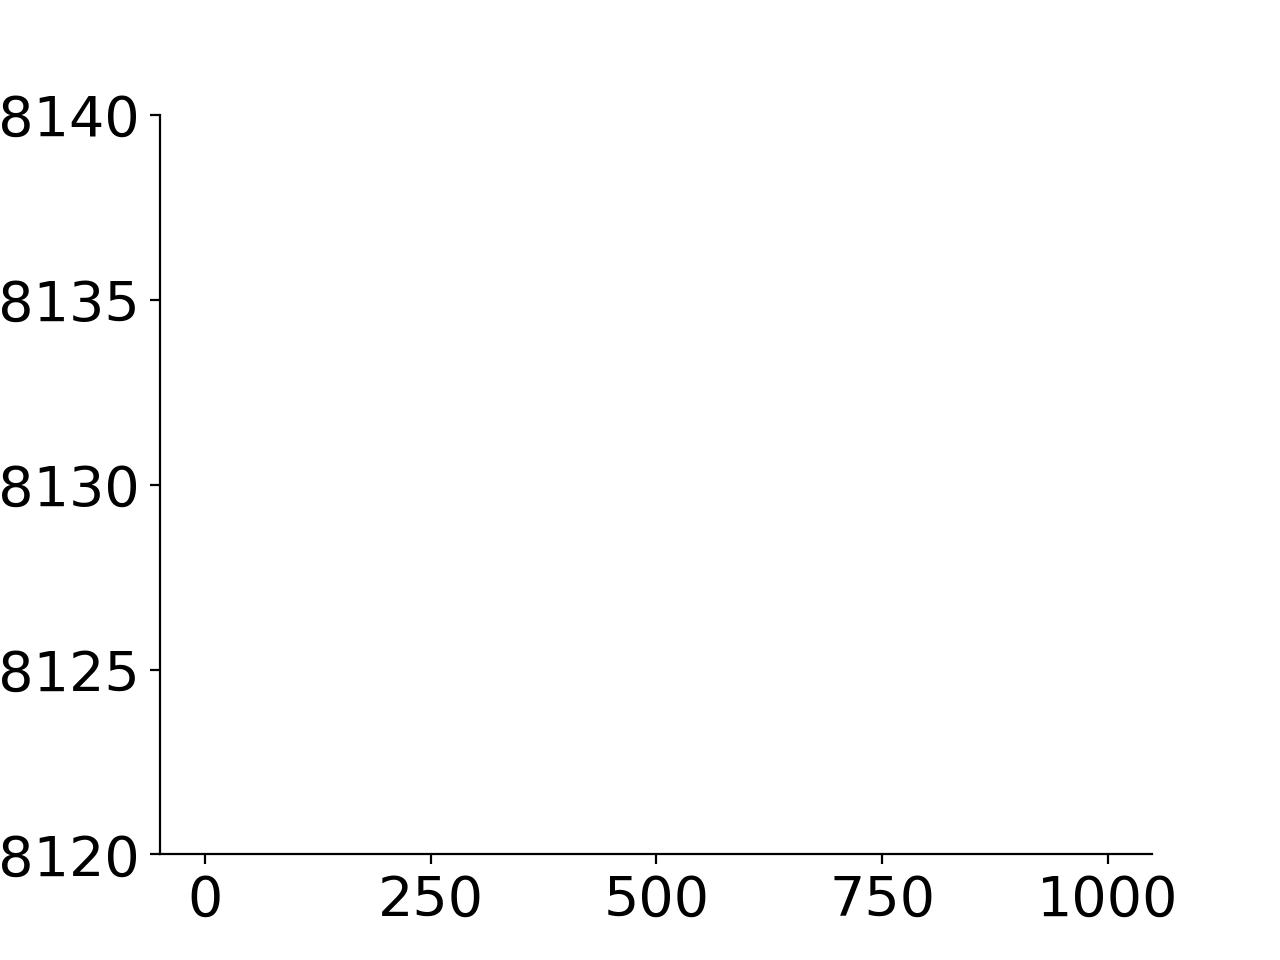

0
5.8454608715952094e-08
7.71879079403126e-09
30
9.63405581106986e-07
2.2891838235422624e-07
60
1.7746316434653561e-06
4.488999791607551e-07
90
2.548408318914057e-06
6.683410087443553e-07
120
3.2993063254342127e-06
8.886689798828784e-07
150
4.019995532195814e-06
1.1084782357839718e-06
180
4.744928640919039e-06
1.3272378079839942e-06
210
5.340678967700151e-06
1.5469718541577526e-06
240
6.009037929187531e-06
1.7669667077974127e-06
270
6.623364026941275e-06
1.986012104153445e-06
300
7.131252361160245e-06
2.205527285609188e-06
330
7.681051568588209e-06
2.425413892059858e-06
360
8.23704523392416e-06
2.645120848361604e-06
390
8.687781386140098e-06
2.8637558585828393e-06
420
9.197520183020207e-06
3.082987525222791e-06
450
9.676764356556476e-06
3.3020946531986395e-06
480
1.0106351472833654e-05
3.5219856019466644e-06
510
1.0494070007944535e-05
3.7408977475034133e-06
540
1.0858779932226316e-05
3.960344863572496e-06
570
1.1179506992171385e-05
4.179900950661286e-06
600
1.1512008536688698e-05
4.399

4950
0.00022080783546970595
3.617854192444758e-05
4980
0.00022486280389328065
3.6397094538911934e-05
5010
0.00022904753034357897
3.661516390800895e-05
5040
0.00023329969389771854
3.683415006162233e-05
5070
0.00023754244089927443
3.7053392128824636e-05
5100
0.0002419556250793319
3.727151806107859e-05
5130
0.0002464472689557343
3.749134104231305e-05
5160
0.0002509265258242104
3.770981651499833e-05
5190
0.00025558239823500256
3.792980679373503e-05
5220
0.000260270526421628
3.814930416452811e-05
5250
0.00026502745603742455
3.8368595227170066e-05
5280
0.00026977847246089206
3.8588419854983236e-05
5310
0.0002746777681157538
3.880701687248439e-05
5340
0.0002795969258024187
3.9024981116263235e-05
5370
0.0002846045472745238
3.924514756364905e-05
5400
0.0002895890892102358
3.946257446426488e-05
5430
0.00029475995632611456
3.968074655353454e-05
5460
0.0003000522237961655
3.990107042349533e-05
5490
0.00030535758369059024
4.011945859459798e-05
5520
0.00031078903047954696
4.0337693433159516e-05
5550

KeyboardInterrupt: 

In [121]:
#1D grid simulation (nonlinear wilson-cowan)
#thesis values
#Time=100
#Delta_t=0.01
plt.close('all')
#more recent param set values
#Time=3
#Delta_t=0.0001

#duration and timestep (empirical loglog median fitting)
Time=10
Delta_t=0.00005

#duration and timestep (empirical spatial only linear scaling)
Time=50
Delta_t=0.0005

#parameters of 1D graph (nonlocal synapses, grid size, grid spacing)
#syn=150
#gridsize=1000
#h=1

Time = 10
Delta_t = 0.000001

nrSS=0
Ess = steady_states[0,nrSS]
Iss = steady_states[1,nrSS]    
# Best suitable steady state: 0, with Ess=0.003813 Iss=0.0522.                       
# Dist spatial: 1493, scale params: [6170.0315 1328.5838 4896.9869]                        
# Dist temporal: 2092, scale params: [  10.7089   -3.767  -318.5677]

E_total = Graph_Wilson_Cowan_Model(Ess, Iss, Time, Delta_t,                          
                         aEE, aIE, aEI, aII,
                         sEE, sIE, sEI, sII, D,
                         dE, dI, P, Q, tE, tI, 
                                    aDWEE,aDWIE, aDWEI, aDWII,
                                    bDWEE, bDWIE, bDWEI, bDWII,             
                        snE, snI, Graph_Kernel,                                  
                         one_dim=True, syn=syn, gridsize=gridsize, h=h,
                         Visual=True, SaveActivity=False, Filepath=' ')   


<IPython.core.display.Javascript object>


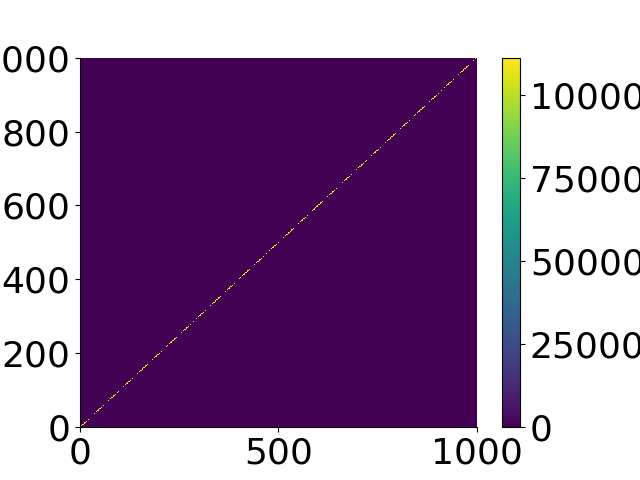

Simulation SPS obtained.
Simulation TPS obtained.
All simulation activity measures completed.
Obtaining analytic predictions...


<IPython.core.display.Javascript object>


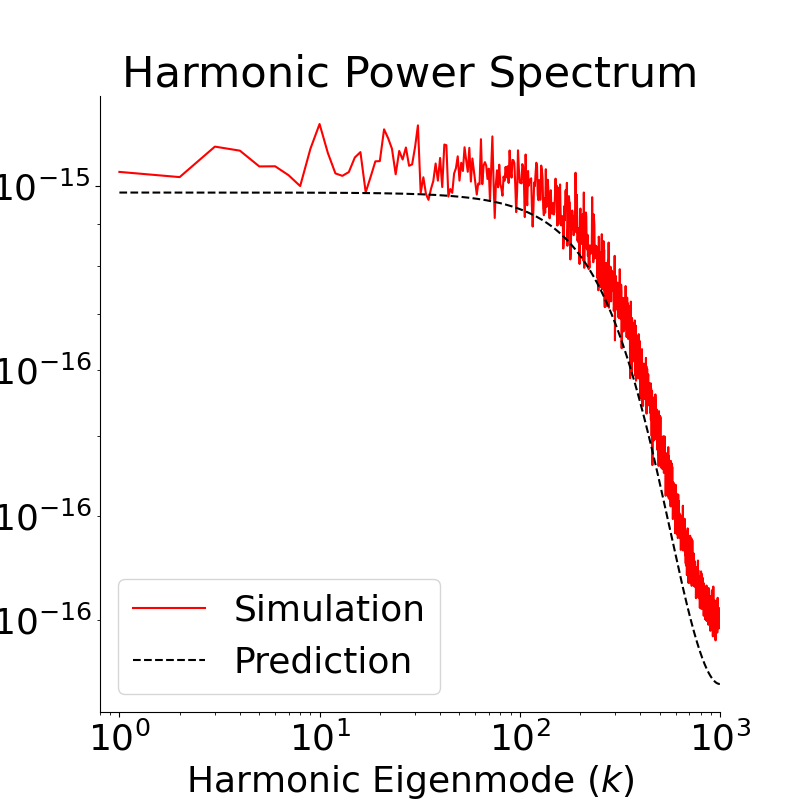

<IPython.core.display.Javascript object>


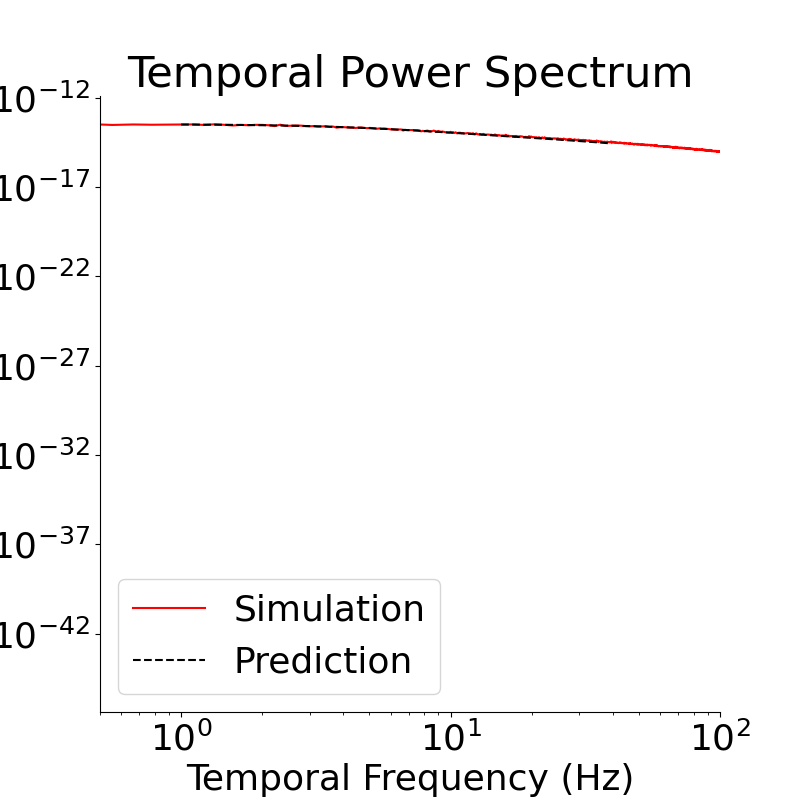

<IPython.core.display.Javascript object>


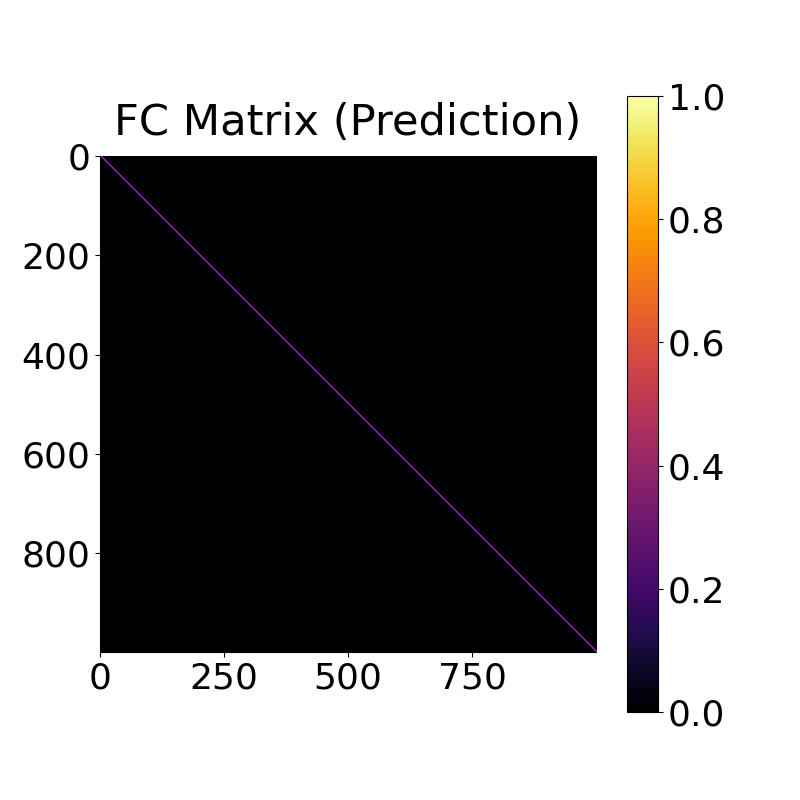

<IPython.core.display.Javascript object>


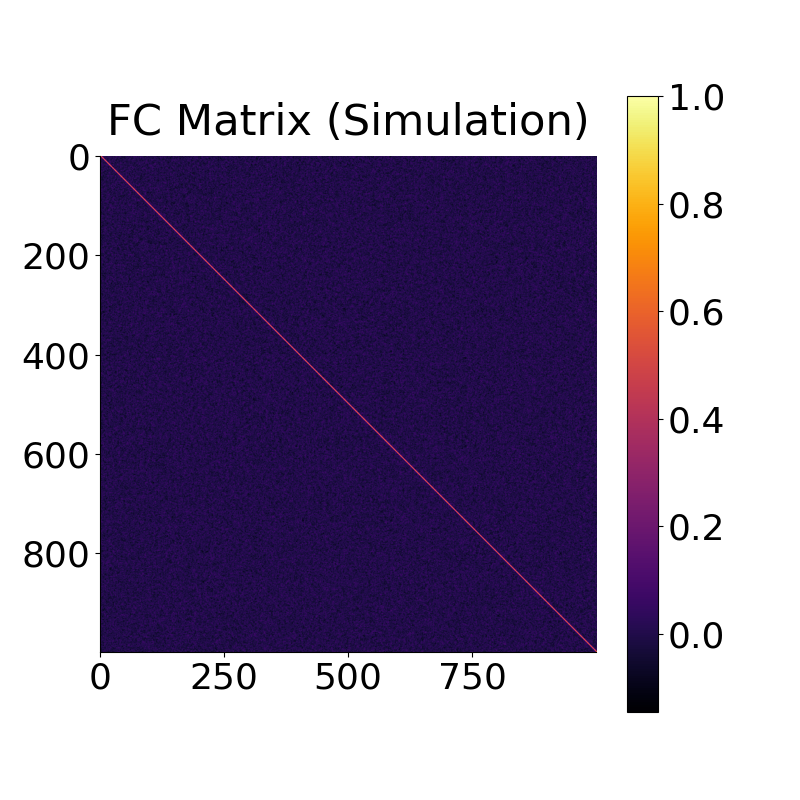

In [14]:
#activity analysis and comparison with prediction
#thesis values
#Max_omega=50
#Delta_omega=0.1

#Min_omega=1*(2*np.pi)
#Max_omega=100*(2*np.pi)
plt.close('all')
PS, TPS, FC = Activity_Analysis(Ess, Iss, Delta_t, 
                            aEE, aIE, aEI, aII,
                            sEE, sIE, sEI, sII, D,
                            dE, dI, P, Q, tE, tI, 
                                
                                    aDWEE,aDWIE, aDWEI, aDWII,
                                    bDWEE, bDWIE, bDWEI, bDWII,        
                            snE, snI, Graph_Kernel,                             
                           E_total=E_total,    compute_FC=True,                                              
                            prediction=True, min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega,                        
                            one_dim=True, syn=syn, gridsize=gridsize, h=h,                           
                            Visual=True, Save_Results=False, Filepath=' ')


In [98]:
#Human connectome simulation (linearized wilson-cowan: perturbation about steady state)
#thesis time and timestep values
#Time=100
#Delta_t=0.01
#more recent work
Time=2
Delta_t=0.0001

#final (empirical)
Time=100
Delta_t=0.0001

#new
#final (empirical)
Time=10
Delta_t=0.00001

nrSS=0
Ess = 0.003813#steady_states[0,nrSS]
Iss = 0.0522#steady_states[1,nrSS]    
# Best suitable steady state: 0, with Ess=0.003813 Iss=0.0522.                       
# Dist spatial: 1493, scale params: [6170.0315 1328.5838 4896.9869]                        
# Dist temporal: 2092, scale params: [  10.7089   -3.767  -318.5677]
SPS_sims=[]
TPS_sims=[]
#for sims in range(3):
Beta_E_total = Linearized_GLDomain_Wilson_Cowan_Model(Ess, Iss, Time, Delta_t,                          
                     aEE, aIE, aEI, aII,
                     sEE, sIE, sEI, sII, D,
                     dE, dI, P, Q, tE, tI, 
                                aDWEE,aDWIE, aDWEI, aDWII,
                                bDWEE, bDWIE, bDWEI, bDWII,                                                            
                    snE, snI, Graph_Kernel,
                     one_dim=False, eigvals=eigenvalues, eigvecs=None,
                     Visual=False, SaveActivity=False, Filepath=' ') 

PS_full, TPS_full = Activity_Analysis(Ess, Iss, Delta_t,
                               aEE, aIE, aEI, aII,
                               sEE, sIE, sEI, sII, D,
                               dE, dI, P, Q, tE, tI, 

                                aDWEE,aDWIE, aDWEI, aDWII,
                                bDWEE, bDWIE, bDWEI, bDWII,  

                                snE, snI, Graph_Kernel,

                             beta_E_total=Beta_E_total,

                               prediction=True, min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega,

                             #  Spatial_scaling=[a_spatial,b_spatial], Temporal_scaling=[a_temporal,b_temporal],

                               one_dim=False, syn=syn, gridsize=gridsize, h=h,

                               eigvals=eigenvalues, eigvecs=None,

                               Visual=True, Save_Results=False, Filepath=' ')
    
#     SPS_sims.append(PS_full)
#     TPS_sims.append(TPS_full)
#     np.save('/home/aqil/NFModel/Beta_E_total_fix_new'+str(sims), Beta_E_total)
#     del Beta_E_total


322.7474233708888 215.8244416551869 190.12331065232968 255.86525489982154
0
0.0
0.0
30
5.412778834553313e-07
9.558130096023305e-09
60
6.714083314255793e-07
1.3653898934737422e-08
90
8.136989446415443e-07
1.6570314340356992e-08
120
1.0581231463268776e-06
1.8392368740808423e-08
150
9.62635495320488e-07
2.0980302040643324e-08
180
9.377062178647746e-07
2.485479110008444e-08
210
1.1114168622890208e-06
2.75382135635454e-08
240
1.0860523253705897e-06
2.7196619888302917e-08
270
8.906335572112897e-07
2.789852167192986e-08
300
9.662223803677409e-07
2.9595544781331843e-08
330
9.063857039349801e-07
2.988934898723244e-08
360
8.638465642005926e-07
3.1192583391415926e-08
390
9.278026145816585e-07
3.144666673860914e-08
420
1.2002355223161452e-06
3.2271696243275865e-08
450
1.2230180233288436e-06
3.562072465396872e-08
480
1.3198195334452544e-06
3.971419094675666e-08
510
1.4468418484966296e-06
3.931292417795284e-08
540
1.262905741080932e-06
4.249776200896248e-08
570
1.3110785785276497e-06
4.1290699528407

4950
1.516096903372437e-06
1.166402731109046e-07
4980
1.2897332953488415e-06
1.1735164138107395e-07
5010
1.2777409735645775e-06
1.1480944334606394e-07
5040
1.2125170213297186e-06
1.1436412444553698e-07
5070
1.140978749926872e-06
1.1750213335278918e-07
5100
1.2709160969868465e-06
1.178473099480504e-07
5130
1.4894926401409135e-06
1.1979207125188035e-07
5160
1.7125418082073149e-06
1.1671020072939368e-07
5190
1.775675441105609e-06
1.1566601680269344e-07
5220
1.5807416928208742e-06
1.1569163563149496e-07
5250
2.071603648593674e-06
1.1471293332706205e-07
5280
1.9076559143221037e-06
1.1451937728962576e-07
5310
1.644541937653939e-06
1.1320591285795301e-07
5340
1.5185195777950231e-06
1.1628026644915201e-07
5370
1.6725802625530598e-06
1.2147554185928604e-07
5400
1.6919217586725838e-06
1.234674623777847e-07
5430
1.6841226063830293e-06
1.2707363682461396e-07
5460
1.9217603719841526e-06
1.27994892054053e-07
5490
1.8284099641808857e-06
1.253162187155687e-07
5520
1.7166320759003164e-06
1.238475611796

9870
3.623201045811597e-06
1.5758802997295146e-07
9900
4.002902605933311e-06
1.5803927687840813e-07
9930
4.071783765969436e-06
1.5745221042928008e-07
9960
3.816743889742043e-06
1.5844951399354852e-07
9990
4.146452884996737e-06
1.5704823683302705e-07
10020
4.134261970983241e-06
1.5917177515776218e-07
10050
4.069669061067991e-06
1.5813385730719324e-07
10080
4.062051674899643e-06
1.5974762608948122e-07
10110
4.282823715768691e-06
1.6078248986245918e-07
10140
4.238515164432752e-06
1.6426137738824005e-07
10170
4.53873027458146e-06
1.6473670848588851e-07
10200
4.675942527533334e-06
1.649867747895906e-07
10230
4.41822498250169e-06
1.6426346829889188e-07
10260
4.578677924743301e-06
1.6421335625282997e-07
10290
4.555653351452826e-06
1.6406979302878006e-07
10320
4.455564291500776e-06
1.6693667070579314e-07
10350
4.531474805230021e-06
1.6468958113643386e-07
10380
4.488632598825666e-06
1.6408937556487793e-07
10410
4.806777781260983e-06
1.6583182036299262e-07
10440
4.782834717771893e-06
1.636663725

14700
4.351579451814714e-06
1.5792024326463335e-07
14730
4.256954681739337e-06
1.599222522988186e-07
14760
3.959598838021365e-06
1.602546801831901e-07
14790
4.219316930415955e-06
1.584889812728475e-07
14820
4.125688303466152e-06
1.5909659990884739e-07
14850
4.35341355883596e-06
1.6081418098919056e-07
14880
4.412435736959747e-06
1.6147693304890364e-07
14910
4.606567032605606e-06
1.649657456895619e-07
14940
4.4151088801689826e-06
1.678458407577152e-07
14970
4.5462213399768986e-06
1.6521598066991605e-07
15000
4.613007108545455e-06
1.62999495405472e-07
15030
4.7834948932477775e-06
1.6335529038445414e-07
15060
4.855942354689694e-06
1.62100523756651e-07
15090
4.8655343074860574e-06
1.6124389478580586e-07
15120
4.5944611128860415e-06
1.5793292030343925e-07
15150
4.0016796958803144e-06
1.594201495506582e-07
15180
3.640467166934318e-06
1.6095273000018894e-07
15210
3.770703819632447e-06
1.6283585441440022e-07
15240
3.7805808367368714e-06
1.6117687788944756e-07
15270
3.6344455196271232e-06
1.6072

19530
3.280567990148194e-06
1.8144492689487995e-07
19560
3.0209238319868754e-06
1.8438161947827806e-07
19590
3.0274924064856442e-06
1.8118051932770544e-07
19620
2.6561685456827244e-06
1.8197207856388646e-07
19650
2.434585783774469e-06
1.852798905105115e-07
19680
2.4219000345710785e-06
1.857618380850471e-07
19710
2.2105854551684002e-06
1.850707113881904e-07
19740
1.9268330778720737e-06
1.8508997191234072e-07
19770
1.9723910309721514e-06
1.8544079345065212e-07
19800
2.0511240238858204e-06
1.8708666507411664e-07
19830
1.8157954449860567e-06
1.8833974310839203e-07
19860
1.8758086020003233e-06
1.853032953486491e-07
19890
1.961582310203862e-06
1.8492269144809645e-07
19920
1.6265587135585565e-06
1.8499473033562026e-07
19950
1.8310414090206999e-06
1.8851214104984918e-07
19980
1.8593560865585266e-06
1.8647413098673489e-07
20010
1.7194168299418235e-06
1.8637745729955753e-07
20040
1.876926227850936e-06
1.8535182633060022e-07
20070
1.737789037530672e-06
1.9101033417452614e-07
20100
1.6762783329142

24330
1.679095095700425e-06
1.920624568096388e-07
24360
2.0107864566410674e-06
1.9033822411289277e-07
24390
2.2941914362948554e-06
1.90172413636912e-07
24420
1.8059332267402507e-06
1.9419615127637202e-07
24450
2.0119286190284763e-06
1.924515403860028e-07
24480
1.8568750672137967e-06
1.9293924136956024e-07
24510
1.6787315936702939e-06
1.9094217273235012e-07
24540
1.538435015785283e-06
1.9278435576225313e-07
24570
1.6118063034432876e-06
1.9594119566893208e-07
24600
1.4395792679093913e-06
1.9601501153288763e-07
24630
1.4902679631703276e-06
1.9161271881475842e-07
24660
1.4103038042396973e-06
1.9392619961814465e-07
24690
1.41199839038995e-06
1.95453072717009e-07
24720
1.8366740298832182e-06
1.908789292827252e-07
24750
1.6268122983104555e-06
1.897345800812783e-07
24780
1.4784201490213239e-06
1.8802218092477305e-07
24810
1.5315222261724324e-06
1.8979093823416048e-07
24840
1.494484932156617e-06
1.8768208531263342e-07
24870
1.5576500272181404e-06
1.8871094688916626e-07
24900
1.8288413481615184e

29130
2.0460940210235268e-06
2.060176901317961e-07
29160
2.024705809789161e-06
2.0908750601933901e-07
29190
2.4205790864337706e-06
2.1127481619076303e-07
29220
2.506569222413573e-06
2.0962837461532805e-07
29250
2.9530729114547083e-06
2.1523565451636288e-07
29280
2.797192245975467e-06
2.15070186918376e-07
29310
2.681546737369448e-06
2.1727555372311612e-07
29340
2.8083386958187795e-06
2.1519811698876998e-07
29370
2.9847546709842263e-06
2.090003928578496e-07
29400
3.014630554211454e-06
2.016710839711437e-07
29430
2.8565339343484433e-06
2.0533672537244946e-07
29460
3.0286337221065955e-06
2.034011733622099e-07
29490
2.706372600937926e-06
2.0331282781334504e-07
29520
2.9696550431683946e-06
2.0372571435221793e-07
29550
2.9465023032442077e-06
2.0583308288672506e-07
29580
2.8583523693970187e-06
2.0835620853040041e-07
29610
3.039006757912099e-06
2.0801285974690353e-07
29640
3.5321746988784745e-06
2.0811783584609154e-07
29670
3.393669001933077e-06
2.097436752123958e-07
29700
3.3255684032353585e-0

33960
4.2733995822180974e-06
2.2500091013644746e-07
33990
4.144996306012115e-06
2.2507558763983586e-07
34020
4.10253792469418e-06
2.2675877677867353e-07
34050
4.176453202446304e-06
2.273798022232357e-07
34080
4.159757358051055e-06
2.276608189822901e-07
34110
4.188395843782065e-06
2.2855249978365445e-07
34140
4.120695972458663e-06
2.2873826703889454e-07
34170
3.900098038833408e-06
2.2613307468624757e-07
34200
3.8350094602078345e-06
2.2892836667590717e-07
34230
3.843601020032878e-06
2.294855619396813e-07
34260
3.823522307150458e-06
2.2956774186473132e-07
34290
4.35719200167267e-06
2.3160576896930204e-07
34320
4.352264607003291e-06
2.3434103990513528e-07
34350
4.272385868669824e-06
2.3710645514179034e-07
34380
4.05077690206993e-06
2.3610203298922412e-07
34410
4.081058227296125e-06
2.3705578711483535e-07
34440
4.218679351697861e-06
2.408156546735399e-07
34470
4.073016201027579e-06
2.403445592396645e-07
34500
3.866294059477229e-06
2.3782320746328862e-07
34530
4.12516759168086e-06
2.33071578

38790
4.336872117500081e-06
2.2054314866296514e-07
38820
4.1833463585886736e-06
2.1798949338115508e-07
38850
4.426150626789124e-06
2.1944629133512752e-07
38880
4.558913057912148e-06
2.1824670109570007e-07
38910
4.640130675084637e-06
2.1564757827497424e-07
38940
4.664820145804439e-06
2.2093347270192866e-07
38970
4.55590965444802e-06
2.196206640573639e-07
39000
4.4166445836359835e-06
2.202121446147189e-07
39030
4.403414864875636e-06
2.2449750402695286e-07
39060
4.394094125124444e-06
2.2554597231984322e-07
39090
4.338189036421367e-06
2.255482127964204e-07
39120
4.011732535763306e-06
2.197259270456533e-07
39150
3.7426944921012286e-06
2.1924110933641763e-07
39180
3.659741564579091e-06
2.197250416998276e-07
39210
3.8976024722786605e-06
2.1952388913780964e-07
39240
3.4852193009162786e-06
2.1959768877202242e-07
39270
3.475174338346399e-06
2.168984840382042e-07
39300
3.7043744940215676e-06
2.147093814737006e-07
39330
3.2205513792309453e-06
2.1288645305457996e-07
39360
2.90663964626572e-06
2.115

43620
1.998813740051459e-06
2.309965370931114e-07
43650
1.89893333370138e-06
2.322499041033664e-07
43680
1.7805917229158897e-06
2.3106765421654702e-07
43710
2.029576202954596e-06
2.3080306981171182e-07
43740
2.2250141312901808e-06
2.309972210008686e-07
43770
2.1215720550719242e-06
2.353916824748994e-07
43800
2.104772955054609e-06
2.3246185775196895e-07
43830
1.9295459862716507e-06
2.2990475995696535e-07
43860
2.269804340807254e-06
2.2603825044865939e-07
43890
1.8875668467800963e-06
2.2356043983682975e-07
43920
1.940947286543837e-06
2.2038761329753321e-07
43950
2.041379788364052e-06
2.217572950165048e-07
43980
2.0643293168850723e-06
2.2213985663724127e-07
44010
2.204952256446141e-06
2.1853871462714022e-07
44040
2.5335369692950124e-06
2.1921428086225106e-07
44070
2.26104859568212e-06
2.1754791152041525e-07
44100
2.6196304588605927e-06
2.201161260457962e-07
44130
2.562134597872146e-06
2.2047140737566217e-07
44160
2.403474015198363e-06
2.2208163961660873e-07
44190
2.570246315949058e-06
2.2

48420
3.338331736502027e-06
2.1992657474175204e-07
48450
3.3002073591282987e-06
2.177699438116526e-07
48480
3.440693249280542e-06
2.1518734784017025e-07
48510
3.4660558903064087e-06
2.150656322833916e-07
48540
3.597679177299359e-06
2.1564367106792536e-07
48570
3.4973027442313194e-06
2.1453747632074252e-07
48600
3.3160990936138074e-06
2.114447938932901e-07
48630
3.0032525183766057e-06
2.142107402219551e-07
48660
2.8195563591080927e-06
2.104799136638032e-07
48690
2.829702063554769e-06
2.085365825972396e-07
48720
2.7074922329747356e-06
2.0667206086311677e-07
48750
2.787511044438823e-06
2.0348576642076642e-07
48780
2.675453028846607e-06
2.0548455317012202e-07
48810
2.7057098787037355e-06
2.0636637286274595e-07
48840
2.9764432144346544e-06
2.0677552965590574e-07
48870
2.8221741825946286e-06
2.0301680205961637e-07
48900
3.248907662715293e-06
2.0263831144974457e-07
48930
3.382972862624669e-06
2.0441606443089587e-07
48960
3.5424134795403173e-06
2.0788509987133406e-07
48990
3.4826519073339786e-

53250
3.297442376655538e-06
2.2471736141710846e-07
53280
3.2726783251008592e-06
2.2655920267817264e-07
53310
3.5893405535683686e-06
2.2617166981042e-07
53340
3.442078596026015e-06
2.240259790257227e-07
53370
3.543131956505405e-06
2.2564253434280345e-07
53400
3.614857270205877e-06
2.24719513034237e-07
53430
3.264244804613126e-06
2.2352468460639764e-07
53460
3.475806175862807e-06
2.2238349379797878e-07
53490
3.505009930352636e-06
2.250397234430223e-07
53520
3.7906355900226233e-06
2.233700479933232e-07
53550
3.4387810579172408e-06
2.2157979773922032e-07
53580
3.3480809072180746e-06
2.2108044485962845e-07
53610
3.5417306309385975e-06
2.2106159459155387e-07
53640
3.6298051303072253e-06
2.200983069938273e-07
53670
3.888819299685788e-06
2.1639963393402093e-07
53700
3.937281151681718e-06
2.160251508734031e-07
53730
4.232155729082067e-06
2.1700146515427196e-07
53760
4.139187914194443e-06
2.1348154360098384e-07
53790
3.921980369748668e-06
2.1182480723364532e-07
53820
3.734105788007168e-06
2.1303

58050
3.652989827011418e-06
2.2611294131704944e-07
58080
3.2756853429659545e-06
2.2518276626471432e-07
58110
3.1356446584278098e-06
2.2299736549605378e-07
58140
3.0135403307603946e-06
2.2415673730643655e-07
58170
2.9569379983691852e-06
2.228679643621372e-07
58200
2.7301333558899685e-06
2.2684901947079522e-07
58230
2.5908639134897497e-06
2.2243504744143504e-07
58260
2.9825284263913993e-06
2.2031109735744997e-07
58290
3.052977500543021e-06
2.2440263187244376e-07
58320
2.6277590486896116e-06
2.269045255633077e-07
58350
2.500277292051284e-06
2.2462742928628444e-07
58380
2.417242728061901e-06
2.2297187192262339e-07
58410
2.266403868358748e-06
2.225516400199068e-07
58440
2.249567197983615e-06
2.2160625331442773e-07
58470
2.357591395852623e-06
2.203988278970099e-07
58500
2.4319531095177614e-06
2.2344056813769314e-07
58530
2.419077500216865e-06
2.2592067220830947e-07
58560
2.4231292896045918e-06
2.2588235990549393e-07
58590
2.3314100890185724e-06
2.2693084649413565e-07
58620
2.4442030208383786

62850
2.2531567285752514e-06
2.2735033622074664e-07
62880
2.3254185856287104e-06
2.2404227318052908e-07
62910
2.523991098486468e-06
2.2156005174370232e-07
62940
2.7428312984282828e-06
2.2344694042661682e-07
62970
3.2436307211352747e-06
2.244545591216717e-07
63000
2.857071690533261e-06
2.225828641183224e-07
63030
3.3489062399722986e-06
2.2235639790191512e-07
63060
3.198643273403947e-06
2.207865619710354e-07
63090
3.2163676261695327e-06
2.2187660054394915e-07
63120
3.317690517834678e-06
2.2377382778776522e-07
63150
3.298559160943742e-06
2.245787528171668e-07
63180
3.188730064793595e-06
2.2750750425050303e-07
63210
3.263248139353119e-06
2.2795352001526415e-07
63240
3.537005456654629e-06
2.2926743142524613e-07
63270
3.7832362866269015e-06
2.3133672289944078e-07
63300
3.782361559953858e-06
2.305211367188655e-07
63330
3.7724636360013532e-06
2.3057363172260047e-07
63360
3.658084576301775e-06
2.310935133943387e-07
63390
3.530976822568012e-06
2.3199095605209327e-07
63420
3.4184335130251476e-06


67650
2.586750157421518e-06
2.250360792438008e-07
67680
2.8345501988310214e-06
2.2660640065665584e-07
67710
3.0311231207462768e-06
2.2957551117785002e-07
67740
2.969594635636579e-06
2.3143572114730242e-07
67770
2.7987159589133053e-06
2.3153675664194926e-07
67800
2.6654167188235017e-06
2.3360410575180862e-07
67830
2.3678230130992654e-06
2.371734911395356e-07
67860
1.9900453409107664e-06
2.3775383141708823e-07
67890
1.944317246673096e-06
2.3573836439157726e-07
67920
2.0522134181236352e-06
2.378597198267783e-07
67950
1.867276358673149e-06
2.413276534777146e-07
67980
1.6362034540719755e-06
2.400316678034346e-07
68010
1.8506946320553698e-06
2.3596186852805832e-07
68040
1.6926964288886418e-06
2.3610545956915352e-07
68070
1.5452661040773198e-06
2.3807851062519475e-07
68100
1.4405191788015093e-06
2.3884233250809385e-07
68130
1.3205406506685497e-06
2.3745012489958051e-07
68160
1.443058578224815e-06
2.403256153274835e-07
68190
1.2622710289943672e-06
2.442920117973993e-07
68220
1.1394058406903901

72450
1.5119892529886006e-06
2.183286341397273e-07
72480
1.735945742205213e-06
2.2249784477051583e-07
72510
1.923622396942178e-06
2.2093314457636844e-07
72540
2.2984668500654336e-06
2.2193486144508782e-07
72570
2.3144573507309828e-06
2.2399107760033894e-07
72600
2.2317265321585826e-06
2.225862352452834e-07
72630
1.7862163101565556e-06
2.2261009656920795e-07
72660
1.5120220398490367e-06
2.2293851774852813e-07
72690
1.3620638578964274e-06
2.2647086205305718e-07
72720
1.273158544205551e-06
2.3007704640679576e-07
72750
1.4022699490818323e-06
2.3057995107013597e-07
72780
1.1864106841795974e-06
2.279225548197504e-07
72810
1.3672420568229246e-06
2.2715720180938783e-07
72840
1.3361759739033145e-06
2.311240555231842e-07
72870
1.3450195606851364e-06
2.3132148325952654e-07
72900
1.4315626736856933e-06
2.3533338341753972e-07
72930
1.400057094969807e-06
2.3295045994834217e-07
72960
1.5596414611689363e-06
2.3204122685452078e-07
72990
1.4688946516816284e-06
2.3151443071090246e-07
73020
1.027815853154

77250
1.3105893600630133e-06
2.2154652043824714e-07
77280
1.3941335490594585e-06
2.192578915668396e-07
77310
1.336521922804534e-06
2.1983394305224302e-07
77340
1.3709043745415296e-06
2.190390807491967e-07
77370
1.443121985729952e-06
2.1728936620364433e-07
77400
1.6194008644944367e-06
2.1458116581363457e-07
77430
1.8619900442057795e-06
2.1743995190620418e-07
77460
1.692077940234668e-06
2.1570470103401296e-07
77490
1.7004652509416313e-06
2.134177699026703e-07
77520
1.6784593520693875e-06
2.1770173131729182e-07
77550
1.9139298434595988e-06
2.1760162052247448e-07
77580
1.933728460026236e-06
2.1775424081696394e-07
77610
2.210516683680878e-06
2.1903519978216318e-07
77640
2.3476129394276765e-06
2.2067065244573146e-07
77670
2.455508804187314e-06
2.2045737842043642e-07
77700
2.3317425694102835e-06
2.2070372791164198e-07
77730
2.470897808159445e-06
2.1895784781121504e-07
77760
2.410829525256242e-06
2.2282008068432986e-07
77790
2.7991194629536893e-06
2.264622355774851e-07
77820
2.961316547407835e

82080
6.610788422580677e-06
2.3390105422857802e-07
82110
6.414529968029598e-06
2.2804976457829623e-07
82140
6.089556777326998e-06
2.2856312908789155e-07
82170
6.056623458233487e-06
2.2613795289418467e-07
82200
6.231159497127367e-06
2.2409701340245939e-07
82230
6.332336753139018e-06
2.22411099246938e-07
82260
6.361612629477578e-06
2.1995431599449775e-07
82290
6.3222118732270425e-06
2.2394432628035308e-07
82320
6.2793495084266935e-06
2.2021464665025356e-07
82350
6.3038930709142835e-06
2.1969149831540043e-07
82380
6.6199153872650255e-06
2.2362354983576224e-07
82410
6.386613036683586e-06
2.2155194845520868e-07
82440
6.319410084070115e-06
2.1990861167224908e-07
82470
6.416934883747169e-06
2.2111388350714367e-07
82500
6.798874303059938e-06
2.2020819999463084e-07
82530
6.7631265414295144e-06
2.2414075898404118e-07
82560
6.875643562695432e-06
2.227551983951242e-07
82590
6.993176863263899e-06
2.268124353269823e-07
82620
7.050456587527307e-06
2.235841327723115e-07
82650
6.9502330524747755e-06
2.

86910
4.459014750820482e-06
2.3162520339167672e-07
86940
4.263050683198873e-06
2.3101023069283795e-07
86970
4.3331483644997195e-06
2.308825973470962e-07
87000
4.033268555138703e-06
2.310793970176907e-07
87030
3.902528694612334e-06
2.3171130479364647e-07
87060
3.47520837218694e-06
2.304707527051655e-07
87090
3.3941544675310915e-06
2.2904931162825722e-07
87120
3.247607728169284e-06
2.3024517566617805e-07
87150
2.9289559041996575e-06
2.297217525418647e-07
87180
2.5807542693090467e-06
2.3186573341009278e-07
87210
2.5466731199224495e-06
2.3271283658743994e-07
87240
2.6064405498776788e-06
2.3507161840327937e-07
87270
2.4332452521691865e-06
2.3655131127588342e-07
87300
2.547150361911826e-06
2.3486029860765092e-07
87330
2.7481523044519967e-06
2.371419977933228e-07
87360
2.5337085473728454e-06
2.3385831653807557e-07
87390
2.5908109059411945e-06
2.3447865080946745e-07
87420
2.570942404312276e-06
2.3477259060458822e-07
87450
2.3014173645713186e-06
2.3606797956150288e-07
87480
2.7077592173413216e-

91740
4.183033562758083e-06
2.4032982362225436e-07
91770
4.180272963305445e-06
2.401886764930689e-07
91800
4.28351058913802e-06
2.3840430385282653e-07
91830
4.487596285934862e-06
2.392856998102573e-07
91860
4.407873324588729e-06
2.3730647885175e-07
91890
4.528210383210079e-06
2.39864997259289e-07
91920
4.664678231184768e-06
2.3800954392941715e-07
91950
4.1897033148999164e-06
2.3942378077567424e-07
91980
4.620323546840064e-06
2.412017400946962e-07
92010
4.542157109458137e-06
2.389350503349143e-07
92040
4.777234243438469e-06
2.3826790775903282e-07
92070
4.643395128957643e-06
2.3468468049512638e-07
92100
4.7160260356975705e-06
2.3542281209968165e-07
92130
4.70563497802996e-06
2.374063949545125e-07
92160
4.763143633739602e-06
2.3782078702819197e-07
92190
4.845726727492569e-06
2.3921651690574166e-07
92220
4.958287708835341e-06
2.389105815377867e-07
92250
4.769402294832858e-06
2.3575208358844585e-07
92280
5.103315537247882e-06
2.3231971861908864e-07
92310
5.1749587191440586e-06
2.30099141920

96600
3.0881494223728656e-06
2.501359826782277e-07
96630
3.1275501662168444e-06
2.5213891637682025e-07
96660
3.210522157041739e-06
2.5235554555920925e-07
96690
3.2032049476988068e-06
2.521293440459659e-07
96720
3.114132085171444e-06
2.54629172319381e-07
96750
3.028640502279839e-06
2.5640993223054185e-07
96780
3.1046962598755803e-06
2.5722037709050215e-07
96810
3.3817708842996123e-06
2.5615280098982774e-07
96840
3.535483096440227e-06
2.5806988960653557e-07
96870
3.4609243143830568e-06
2.6014292142215546e-07
96900
3.3335359647469267e-06
2.647090585702014e-07
96930
3.384774064665149e-06
2.625125467778649e-07
96960
3.266667715061361e-06
2.627720985839527e-07
96990
3.281047788385058e-06
2.5819896291097373e-07
97020
3.2326537763617043e-06
2.6298524236611776e-07
97050
3.358325151728075e-06
2.635378986739774e-07
97080
3.072194254059112e-06
2.6432545859743486e-07
97110
3.0449043210218185e-06
2.6184941285694177e-07
97140
3.02139114807908e-06
2.6098258159831055e-07
97170
2.8788783474094574e-06
2.

101430
4.577279310684659e-06
2.5977833942610747e-07
101460
4.503640867437499e-06
2.5594715081026954e-07
101490
4.462274959190759e-06
2.569287288691368e-07
101520
4.6400868811384475e-06
2.5438514035893237e-07
101550
4.447057086073282e-06
2.5266275171473933e-07
101580
4.095646906746057e-06
2.537080369799429e-07
101610
4.150769445733037e-06
2.5684468526476716e-07
101640
4.023713017471809e-06
2.5547398159966077e-07
101670
4.0126473919639176e-06
2.555899197497301e-07
101700
4.025529907876163e-06
2.547090255437085e-07
101730
3.959957396132319e-06
2.5447111910506926e-07
101760
3.816155736655243e-06
2.522007682640735e-07
101790
4.036459138097541e-06
2.506412922077581e-07
101820
3.94448556460827e-06
2.522568201871839e-07
101850
3.6629340357793974e-06
2.543286492035988e-07
101880
3.592265425798843e-06
2.5471630246304594e-07
101910
3.3003458207021384e-06
2.538950994347482e-07
101940
3.1004866170186494e-06
2.568037230220656e-07
101970
3.2713349775888332e-06
2.5230389927907095e-07
102000
3.27520376

106170
4.653724321121809e-06
2.2652365252163977e-07
106200
4.8615344265190805e-06
2.2725778127012117e-07
106230
5.024559316688878e-06
2.2794919722434554e-07
106260
4.694194583827986e-06
2.293832570780297e-07
106290
4.7558214128488715e-06
2.300022778186274e-07
106320
4.75675446866049e-06
2.2833853308940794e-07
106350
4.637907200435939e-06
2.3135293282099405e-07
106380
5.016463631796566e-06
2.2762132231806135e-07
106410
5.006419161529736e-06
2.2333067747517749e-07
106440
5.088575097393986e-06
2.221914011145337e-07
106470
4.660772614608838e-06
2.230000571526472e-07
106500
4.383385569323093e-06
2.2409266575304606e-07
106530
4.228224379984337e-06
2.225660246388406e-07
106560
4.336561285225226e-06
2.174311271057744e-07
106590
4.230906210651684e-06
2.21281554389926e-07
106620
4.205429641729742e-06
2.2093772246918162e-07
106650
4.254510057699438e-06
2.183234247497383e-07
106680
4.743391143177246e-06
2.1541311495734354e-07
106710
4.4678853484411075e-06
2.2049247266331802e-07
106740
4.1419899375

110910
4.044137638188617e-06
2.1469303123581718e-07
110940
3.7153405562498345e-06
2.1316611877280295e-07
110970
3.4907525710229183e-06
2.1321256750579345e-07
111000
3.40450273416462e-06
2.1519274175147834e-07
111030
3.3834940304428174e-06
2.160334408995571e-07
111060
3.4209111226564303e-06
2.1360355311891705e-07
111090
2.951323866178379e-06
2.1193748744832895e-07
111120
2.8372078235759327e-06
2.117136867279994e-07
111150
2.524713792865621e-06
2.1294314856695524e-07
111180
2.491912611828654e-06
2.1335012300941232e-07
111210
2.3017089157615116e-06
2.120916713992478e-07
111240
2.142927128588992e-06
2.1189255172960505e-07
111270
2.2069956337116592e-06
2.0889829117948752e-07
111300
2.159799057667775e-06
2.0909982970148092e-07
111330
2.3292789529792313e-06
2.092333680137002e-07
111360
2.323207376583273e-06
2.087636297669165e-07
111390
2.3522938173116813e-06
2.0784768221931452e-07
111420
2.6445941987040648e-06
2.0976707721603852e-07
111450
2.4280079774060925e-06
2.0706556269518544e-07
111480


115620
2.474452744537679e-06
2.5234180757414136e-07
115650
2.2134334750914137e-06
2.5809838121602307e-07
115680
2.2518625963195125e-06
2.584013728633057e-07
115710
2.056917713706656e-06
2.5969003884821106e-07
115740
2.0189545357848294e-06
2.604057940118548e-07
115770
2.084153380309384e-06
2.597508224843799e-07
115800
1.9182110483752686e-06
2.613236027805851e-07
115830
1.8069093984902659e-06
2.6213758795719485e-07
115860
1.5725377533917022e-06
2.660315686205129e-07
115890
1.625495469610338e-06
2.6242120299703635e-07
115920
1.8048869343090716e-06
2.60337043155998e-07
115950
1.5366899880340905e-06
2.5945759143866785e-07
115980
1.4319349990907274e-06
2.6107710563318544e-07
116010
1.5280411675247477e-06
2.6401981064909623e-07
116040
1.4412015233488785e-06
2.6340229649894625e-07
116070
1.357148266026134e-06
2.629528173578583e-07
116100
1.632210691999075e-06
2.6469848142532995e-07
116130
1.5800508917027807e-06
2.6554256208701454e-07
116160
1.3621200496099106e-06
2.6716107503794655e-07
116190


120360
1.205954577690786e-06
2.4511105192533363e-07
120390
1.2180900944783395e-06
2.490408816047877e-07
120420
1.2440998690436575e-06
2.485963806748395e-07
120450
1.1465309077977608e-06
2.49032150585176e-07
120480
1.0678622259507151e-06
2.5022087886903694e-07
120510
1.0149921355244902e-06
2.5181285039299787e-07
120540
1.090539623989939e-06
2.541126696548867e-07
120570
1.4217972794042019e-06
2.564513341928682e-07
120600
1.1309365853134438e-06
2.552765772768312e-07
120630
1.1856877025493513e-06
2.54100921960573e-07
120660
1.116227906513184e-06
2.5503784877815796e-07
120690
1.0026229719969312e-06
2.5382187062049985e-07
120720
1.2173312075872969e-06
2.505335223778682e-07
120750
1.294576187354358e-06
2.471568978501768e-07
120780
1.384264988111537e-06
2.468497409186003e-07
120810
1.3850080747866172e-06
2.4163656207422963e-07
120840
1.0359381099051243e-06
2.415451990575082e-07
120870
1.0533046161613254e-06
2.4505618461271174e-07
120900
9.863658469860067e-07
2.473315570939249e-07
120930
1.2637

125070
2.9061012806969717e-06
2.2569180505416846e-07
125100
2.9333931165094803e-06
2.254232932874958e-07
125130
2.9684862896847425e-06
2.2598184437406402e-07
125160
3.016087497801581e-06
2.2865451776721108e-07
125190
2.8345724470285336e-06
2.2716278527537226e-07
125220
2.7746861589923947e-06
2.289712589451555e-07
125250
2.8639235688418904e-06
2.3182063385938016e-07
125280
2.9688282170106286e-06
2.301952458108333e-07
125310
3.248349093357077e-06
2.3268509530699676e-07
125340
3.2971844419480282e-06
2.3369881625489318e-07
125370
3.3667564555921495e-06
2.359303566643795e-07
125400
3.565721433128498e-06
2.3592568914365337e-07
125430
3.672820055159198e-06
2.339120326375451e-07
125460
3.8075221766186097e-06
2.3419327419820364e-07
125490
3.745190479976112e-06
2.3536471760292234e-07
125520
3.693921194138066e-06
2.3109688096098067e-07
125550
3.7746219050157955e-06
2.284802600084664e-07
125580
3.4669285899051716e-06
2.3044825735110723e-07
125610
3.726181761423394e-06
2.3188683623527992e-07
125640

129780
6.514593049405282e-06
2.2800023004585936e-07
129810
6.24328223676585e-06
2.300168997749881e-07
129840
6.257566264348071e-06
2.3075217184805866e-07
129870
6.342691801449696e-06
2.3153841932249033e-07
129900
6.297755211357118e-06
2.320296903081323e-07
129930
5.986862202888564e-06
2.3341338455287224e-07
129960
5.917637524743894e-06
2.3110444836413754e-07
129990
5.851446756430172e-06
2.3268529696381268e-07
130020
5.561640349799422e-06
2.3309399239592494e-07
130050
5.813474997050826e-06
2.3633036923804894e-07
130080
6.097773280798588e-06
2.3415544124420985e-07
130110
6.0253220068479775e-06
2.331605798443749e-07
130140
5.803296827544247e-06
2.315701144289689e-07
130170
5.36887212120271e-06
2.3110351818770168e-07
130200
5.605747222385005e-06
2.3017856337303266e-07
130230
5.62704509324688e-06
2.3065061925264127e-07
130260
5.371185635067406e-06
2.358665472550952e-07
130290
5.044951754477616e-06
2.3378867439280564e-07
130320
5.0844958519705884e-06
2.4007810049420683e-07
130350
5.109508941

134550
6.184530899226946e-06
2.3279085067475925e-07
134580
6.538235914442763e-06
2.350467932333949e-07
134610
6.491588301445186e-06
2.3850184403734324e-07
134640
6.652528791802046e-06
2.386726961063741e-07
134670
6.685714607102286e-06
2.398510654544526e-07
134700
6.621473215609592e-06
2.4100633579246137e-07
134730
6.916758519417795e-06
2.416774139610682e-07
134760
7.1024258876560604e-06
2.4077530481272555e-07
134790
7.036235148180574e-06
2.4375115007971166e-07
134820
6.715761838448415e-06
2.4365413805728274e-07
134850
6.500006059086437e-06
2.457823628498459e-07
134880
6.143845512309582e-06
2.455189355864938e-07
134910
6.394288100702177e-06
2.424649882707146e-07
134940
6.0996102644493205e-06
2.4432176009923487e-07
134970
6.452334450424128e-06
2.448621793027692e-07
135000
6.214896582432542e-06
2.449728785327857e-07
135030
5.891975141152469e-06
2.4354638100867805e-07
135060
6.09093910000885e-06
2.4189974068511775e-07
135090
6.033814679218e-06
2.4101378875489454e-07
135120
6.04810278558773

139320
8.641432276828183e-06
2.3632481291975417e-07
139350
9.042861919196257e-06
2.3687857954667336e-07
139380
9.043974035035401e-06
2.3593145187781253e-07
139410
8.750999207454185e-06
2.3615798769434665e-07
139440
8.55263015640519e-06
2.410961109268127e-07
139470
8.707961667762102e-06
2.3732701050533478e-07
139500
8.608643235125218e-06
2.380318739795699e-07
139530
8.432013490538061e-06
2.4137906771560886e-07
139560
8.577484121916593e-06
2.426990934642342e-07
139590
8.542458423930458e-06
2.390391167975567e-07
139620
9.04249561717327e-06
2.424106432429414e-07
139650
8.889745853448402e-06
2.4188071227507144e-07
139680
8.614820523694802e-06
2.4129817652492074e-07
139710
8.385560506870323e-06
2.4118874485726336e-07
139740
8.258913171176746e-06
2.4586090930846464e-07
139770
8.365504904181753e-06
2.4921821091370066e-07
139800
8.027403218311467e-06
2.5135646926850087e-07
139830
8.055882087862385e-06
2.526305068376946e-07
139860
8.200127293447314e-06
2.514958735968493e-07
139890
8.165642725306

144090
8.384413271753084e-06
2.4791655323198295e-07
144120
8.324518959366544e-06
2.4806895349212364e-07
144150
8.049492052737142e-06
2.482706687751294e-07
144180
8.407850552389205e-06
2.484146910097963e-07
144210
8.596391910781882e-06
2.4847708971109616e-07
144240
8.799965624628099e-06
2.46762089198298e-07
144270
8.821530065654127e-06
2.468195105012615e-07
144300
8.771051501147683e-06
2.429775424496151e-07
144330
8.677680192590659e-06
2.466411021064378e-07
144360
8.431879426514237e-06
2.481042156453646e-07
144390
8.525613879567128e-06
2.475797803896918e-07
144420
8.388913544789854e-06
2.4864726053727983e-07
144450
8.664685397672149e-06
2.475427207461965e-07
144480
8.410010715813708e-06
2.4716000468194894e-07
144510
8.423090539128939e-06
2.453409817795589e-07
144540
8.362239886120561e-06
2.490351243447197e-07
144570
8.262356477867171e-06
2.4740794129779176e-07
144600
8.313079253131908e-06
2.458780657378001e-07
144630
8.2022412731965e-06
2.4641251837808954e-07
144660
8.388978174735582e-0

148860
5.027587973206851e-06
2.568192405401015e-07
148890
4.9056262014453875e-06
2.580100696479243e-07
148920
5.013576678801576e-06
2.573806691212277e-07
148950
5.057488437052671e-06
2.545605216412375e-07
148980
5.243998401839443e-06
2.568715899820566e-07
149010
5.119761469499564e-06
2.5472779213507464e-07
149040
5.08801587912612e-06
2.543649860579485e-07
149070
4.948639759545575e-06
2.5529388107037134e-07
149100
4.735100083539947e-06
2.545853565793519e-07
149130
4.722534455258741e-06
2.572014493539615e-07
149160
4.735335077741967e-06
2.579273612204232e-07
149190
4.674095604235381e-06
2.573392093097785e-07
149220
4.906129033579886e-06
2.5795170450574785e-07
149250
4.90030779540978e-06
2.5692335685707023e-07
149280
4.8091928693901585e-06
2.5688244998554475e-07
149310
4.983172556233847e-06
2.564676276812951e-07
149340
4.699268172891432e-06
2.5786161204929386e-07
149370
4.610351576677705e-06
2.5389736566218673e-07
149400
4.473864803767284e-06
2.5051446045019745e-07
149430
4.67358419886807

153630
4.887672638231234e-06
2.2796475944556846e-07
153660
4.903235749878693e-06
2.281119631378206e-07
153690
5.08203403456499e-06
2.3200853055918859e-07
153720
4.790492669369579e-06
2.2984149052984638e-07
153750
4.556423167028794e-06
2.2920506040558913e-07
153780
4.889707970117004e-06
2.297775663510731e-07
153810
4.625530819330992e-06
2.2766546577665884e-07
153840
4.227030577447355e-06
2.2250429389738198e-07
153870
3.9290512312105775e-06
2.232850644323361e-07
153900
4.398714746122858e-06
2.237679208903921e-07
153930
4.588516372459473e-06
2.2173235299602686e-07
153960
4.510563167411518e-06
2.2332559004709473e-07
153990
4.4110412990264e-06
2.2446980739377208e-07
154020
4.202255826782415e-06
2.2971508168269568e-07
154050
4.429766487575577e-06
2.2563282084363685e-07
154080
4.625253928004966e-06
2.266974889321525e-07
154110
4.530038606500459e-06
2.2627839015674024e-07
154140
4.74392029001123e-06
2.2787495547906504e-07
154170
5.0090160110591e-06
2.2511095039251993e-07
154200
4.8178568086588

158340
3.550094214924612e-06
2.250023567701914e-07
158370
3.7684989823718503e-06
2.2113893687388427e-07
158400
3.687462362740856e-06
2.2172055653270858e-07
158430
3.3519658143913387e-06
2.2334389092953958e-07
158460
3.4753819098064136e-06
2.235125067928528e-07
158490
3.5755321448226575e-06
2.2257702977713544e-07
158520
3.801054762152457e-06
2.2127147652257857e-07
158550
4.076249012303001e-06
2.1835736117112852e-07
158580
4.304204608682636e-06
2.2004570745479185e-07
158610
4.7004027501285414e-06
2.2312408994918267e-07
158640
5.1423447012342556e-06
2.2486861279153667e-07
158670
4.757805797369163e-06
2.2035912635119386e-07
158700
5.064065397523765e-06
2.2470596169012678e-07
158730
5.084019912596366e-06
2.2657676893537953e-07
158760
5.337682707012553e-06
2.2432239962895966e-07
158790
5.637080847499477e-06
2.258265162079847e-07
158820
5.478840280759816e-06
2.2666213945696795e-07
158850
5.308595292611782e-06
2.2714841891696846e-07
158880
5.2254362556350925e-06
2.2760217297519384e-07
158910
5

163080
8.27731192513131e-06
2.3973359353359036e-07
163110
8.008186945731087e-06
2.3881468431333e-07
163140
8.17467074834852e-06
2.4131893890073177e-07
163170
7.948266540702066e-06
2.380801928840638e-07
163200
8.024554761464207e-06
2.3571983771023754e-07
163230
7.904386375937835e-06
2.361852983314241e-07
163260
7.801769536760365e-06
2.3252550746265883e-07
163290
7.865873836014985e-06
2.3510764656926234e-07
163320
7.399919661523637e-06
2.3592284628903026e-07
163350
7.20483357975036e-06
2.3601321138392659e-07
163380
7.0388852640718195e-06
2.3472732273832449e-07
163410
7.133601774579477e-06
2.375574494315047e-07
163440
7.031057890864502e-06
2.35756781425142e-07
163470
6.531383539447638e-06
2.3674213831077047e-07
163500
6.793872871515888e-06
2.383976263478992e-07
163530
6.690879887751641e-06
2.3518226767053326e-07
163560
6.532162804124583e-06
2.3447572349149957e-07
163590
6.051576621529516e-06
2.3371293207027725e-07
163620
5.8947790853759184e-06
2.3137861964963882e-07
163650
5.5607252805759

167850
7.260530593597717e-06
2.1794643207557026e-07
167880
7.014574599941735e-06
2.1886659524571368e-07
167910
6.839582617109503e-06
2.1962135414214806e-07
167940
6.77534467233875e-06
2.229249078424165e-07
167970
6.509958283654826e-06
2.2341908097336688e-07
168000
6.687222415429287e-06
2.2544805989644572e-07
168030
6.525084200857375e-06
2.2452857525219168e-07
168060
5.961763009755714e-06
2.243533686064077e-07
168090
5.887063547963119e-06
2.2457038957441117e-07
168120
5.533724255432388e-06
2.215937793840227e-07
168150
5.461171174340932e-06
2.2128295566588048e-07
168180
5.473283890177288e-06
2.2260045139469474e-07
168210
5.131810216698578e-06
2.1886056105065372e-07
168240
4.981798966160302e-06
2.179490863720856e-07
168270
4.786642372894847e-06
2.2085252206545538e-07
168300
4.549163815619333e-06
2.194339850120359e-07
168330
4.211439696698766e-06
2.1903111307242683e-07
168360
4.459168509695095e-06
2.1426955153985027e-07
168390
4.290230818460515e-06
2.1376507885822895e-07
168420
4.187891572

172590
6.6995398816781694e-06
2.324502747325429e-07
172620
6.834135330262681e-06
2.316634214050995e-07
172650
6.958939998732177e-06
2.3671878893886182e-07
172680
6.758114092626411e-06
2.4070871071354857e-07
172710
6.846772708392391e-06
2.3822748642473604e-07
172740
6.773384038609303e-06
2.3794947603111127e-07
172770
6.56673973689058e-06
2.3886668840683143e-07
172800
6.426550231401422e-06
2.411442595294159e-07
172830
6.237774377121121e-06
2.3769851090475693e-07
172860
6.023683772552447e-06
2.3538030568738434e-07
172890
5.8089936611710875e-06
2.362624079489318e-07
172920
5.472656240309969e-06
2.3284524135337923e-07
172950
5.427732925644482e-06
2.3311457921297538e-07
172980
5.225834140490699e-06
2.353349144771905e-07
173010
5.196810815141765e-06
2.3356772396607932e-07
173040
5.093909568389881e-06
2.3463762858321097e-07
173070
4.934550669457977e-06
2.3306928989100647e-07
173100
5.079019710048403e-06
2.318749698577728e-07
173130
4.916163405466345e-06
2.268914067305216e-07
173160
4.712447481

177360
5.7331477591190246e-06
2.599894798604453e-07
177390
5.797913282900957e-06
2.6152265058786665e-07
177420
5.430964964369847e-06
2.65673509093017e-07
177450
5.015633110111107e-06
2.652424750986263e-07
177480
4.8060030731284685e-06
2.7128976431491524e-07
177510
4.523489282144309e-06
2.686690661291551e-07
177540
4.42964759176562e-06
2.646084839205434e-07
177570
4.3762708254023376e-06
2.637532628008779e-07
177600
4.0389360508345855e-06
2.6178280447580293e-07
177630
3.862313345895292e-06
2.649889154766309e-07
177660
3.7804727901383953e-06
2.6455545519312797e-07
177690
3.4986767470866253e-06
2.7013717465096523e-07
177720
3.089401537017368e-06
2.6739420913406306e-07
177750
3.202673194420979e-06
2.669273140450132e-07
177780
3.2670907455640865e-06
2.6404322375488303e-07
177810
3.2092526741156352e-06
2.6374014193728583e-07
177840
2.9534944423046237e-06
2.6346470606463383e-07
177870
3.2059835964630984e-06
2.635330177524976e-07
177900
3.0717308400780403e-06
2.64910578796313e-07
177930
3.03186

182130
2.9163839384615687e-06
2.4376185371999633e-07
182160
2.597032674733404e-06
2.4173604800955983e-07
182190
2.500079146394323e-06
2.3781657307516126e-07
182220
2.1572727049144506e-06
2.378413117469236e-07
182250
1.9570687388781387e-06
2.405348504904466e-07
182280
2.051566560590683e-06
2.397715159994975e-07
182310
1.9263386969596996e-06
2.4016147946045444e-07
182340
1.870022397155157e-06
2.404977691490343e-07
182370
1.7289052273550515e-06
2.3408103377151414e-07
182400
1.4516967499688087e-06
2.3333245111751575e-07
182430
1.3051248274255798e-06
2.3310080033963727e-07
182460
1.3545715916121165e-06
2.3261529326809127e-07
182490
1.4192346605892946e-06
2.32609634980614e-07
182520
1.356730099336391e-06
2.3283648487069348e-07
182550
1.2878353849900432e-06
2.3544000115707673e-07
182580
1.3761744034856549e-06
2.342340845254998e-07
182610
1.6151398198898756e-06
2.3387662314382194e-07
182640
1.634426078049832e-06
2.3679690831958297e-07
182670
1.4493291242262516e-06
2.3633155368207174e-07
182700

186870
1.5025148032403132e-06
2.181646802176146e-07
186900
1.604122468044224e-06
2.178142551734111e-07
186930
1.5600720668986477e-06
2.1833738452825887e-07
186960
1.5786188836947574e-06
2.1808762179091782e-07
186990
1.4096774378944723e-06
2.1611736277919134e-07
187020
1.4734802176098655e-06
2.1576753289556005e-07
187050
1.4690402854310737e-06
2.1544673806660923e-07
187080
1.3519045289595433e-06
2.1549101266821794e-07
187110
1.4364239325797256e-06
2.1829718717212972e-07
187140
1.524269159936631e-06
2.1440086544874493e-07
187170
1.7084989514717482e-06
2.1716672438234504e-07
187200
1.811304529216643e-06
2.166762701124575e-07
187230
2.0046034086534935e-06
2.1494830263839683e-07
187260
2.2370160490292896e-06
2.1758118026740146e-07
187290
2.3645849790471696e-06
2.168573335802505e-07
187320
2.553430618495343e-06
2.149648187845795e-07
187350
2.6378247603872647e-06
2.1509197927773078e-07
187380
3.0206062506591555e-06
2.0962572453772185e-07
187410
3.4290615203093357e-06
2.113322668040638e-07
187

191610
1.5465288755222618e-06
2.1742876542744364e-07
191640
1.3595412021754566e-06
2.1807677653342743e-07
191670
1.408282418473592e-06
2.20443027508154e-07
191700
1.3313970110021798e-06
2.2048592886738885e-07
191730
1.5335395084517154e-06
2.191488158308933e-07
191760
1.3191299908198342e-06
2.196470546693229e-07
191790
1.185955758179021e-06
2.2035619545469153e-07
191820
1.4461350192080543e-06
2.1877188754081961e-07
191850
1.3446946776635674e-06
2.201047140982376e-07
191880
1.3924430062796299e-06
2.2088827873132138e-07
191910
1.2841360858646468e-06
2.2014464964050198e-07
191940
1.2372904198996367e-06
2.185901003677889e-07
191970
1.2285544640162537e-06
2.1854860477928495e-07
192000
1.0546502653510426e-06
2.2056676936972049e-07
192030
1.4663207573533377e-06
2.2332148819449117e-07
192060
1.2645939628896608e-06
2.2406700072355705e-07
192090
1.3138999162020124e-06
2.2445427174588317e-07
192120
1.4123095189448513e-06
2.2391846674146993e-07
192150
1.2456947671290609e-06
2.2115415667623924e-07
1

196350
1.3717094629360751e-06
2.433421239625504e-07
196380
1.0921447761260346e-06
2.426480481903456e-07
196410
1.3544118075710305e-06
2.432527277071045e-07
196440
1.1397959992311378e-06
2.445482766701574e-07
196470
1.1336720170063287e-06
2.477745751216534e-07
196500
1.2628090461958863e-06
2.47170215620484e-07
196530
1.7470932705986682e-06
2.4317810735777216e-07
196560
1.9962837114480827e-06
2.406182905084967e-07
196590
2.2152517090985377e-06
2.421278009444115e-07
196620
2.5575001762913525e-06
2.4253865225119623e-07
196650
2.8131862342093127e-06
2.4557011254953907e-07
196680
2.942453165575662e-06
2.467304193560572e-07
196710
3.2095045696644866e-06
2.473775704031874e-07
196740
3.2020913557052963e-06
2.521623567924769e-07
196770
3.6219436875788396e-06
2.540018301890168e-07
196800
3.5717312881797713e-06
2.526812400112559e-07
196830
3.4437174992190607e-06
2.515257503060968e-07
196860
3.532008027989921e-06
2.484604986459291e-07
196890
3.2863871444368546e-06
2.484535483453327e-07
196920
3.561

201090
1.3457650035559159e-06
2.235291608688863e-07
201120
1.3356128776904326e-06
2.2610867452763703e-07
201150
1.4564623567539239e-06
2.2677904977317084e-07
201180
1.2966522380999789e-06
2.2543701639263904e-07
201210
1.329015409832579e-06
2.28640114738597e-07
201240
1.3366663461245263e-06
2.2419975900392227e-07
201270
1.501169635902755e-06
2.2200217108836395e-07
201300
1.4395772016399708e-06
2.2069501610799078e-07
201330
1.4143525100967132e-06
2.1905582190522267e-07
201360
1.364746521196434e-06
2.1966356884387957e-07
201390
1.3969196517272641e-06
2.1738721834189679e-07
201420
1.3891549941911768e-06
2.1563425619118363e-07
201450
1.3849922582130073e-06
2.154275687605459e-07
201480
1.2430922889703813e-06
2.1667173876862848e-07
201510
1.2389720573413893e-06
2.1793395445218392e-07
201540
1.2430484086442902e-06
2.1385817998826735e-07
201570
1.350116250834676e-06
2.172496615046528e-07
201600
1.281427882269259e-06
2.230157648743377e-07
201630
1.5482227123543963e-06
2.2511012960230252e-07
2016

205800
1.4786169811614652e-06
2.2487479325027732e-07
205830
1.7052433027790653e-06
2.2973770548920177e-07
205860
1.6692263228568929e-06
2.323526368432443e-07
205890
1.433669418100132e-06
2.300788204399705e-07
205920
1.792625812032256e-06
2.3016150232064688e-07
205950
1.9424390335060538e-06
2.2768326873352982e-07
205980
1.7994229705768601e-06
2.3118277464867412e-07
206010
1.6591536577162649e-06
2.3244033296541244e-07
206040
1.5478378363685596e-06
2.3832507963269005e-07
206070
1.8265136373640639e-06
2.428695989545294e-07
206100
2.188615485607221e-06
2.42536586744317e-07
206130
2.095262645057134e-06
2.377195186475372e-07
206160
1.8631388122923561e-06
2.377051391478016e-07
206190
1.5982217623337492e-06
2.4152567820744044e-07
206220
1.5946324210528397e-06
2.4179228057720304e-07
206250
1.6332412495091692e-06
2.4121203360889423e-07
206280
1.8446968807700737e-06
2.445431948697718e-07
206310
1.7346289842934825e-06
2.4264730489833867e-07
206340
1.737812514381411e-06
2.460453453402294e-07
206370


210540
3.0366283687698423e-06
2.820913019907154e-07
210570
2.9230485214670315e-06
2.8619031771862083e-07
210600
3.1684814992131335e-06
2.839127125605137e-07
210630
3.2223645224185487e-06
2.821991113824291e-07
210660
3.211554728177528e-06
2.857934494386349e-07
210690
3.220283362521157e-06
2.8423269896102044e-07
210720
3.2854491355156266e-06
2.8326607518988173e-07
210750
3.1389769319087e-06
2.8197580542118996e-07
210780
3.2960582731508225e-06
2.8252462372503363e-07
210810
3.801610831651195e-06
2.826321881231124e-07
210840
3.933199854569971e-06
2.816537548140009e-07
210870
4.184783767733197e-06
2.8148249189683545e-07
210900
4.4456478168092155e-06
2.845047233545258e-07
210930
4.3307364126653e-06
2.8645938243839585e-07
210960
4.527982262711486e-06
2.8594301051338296e-07
210990
4.43480891109591e-06
2.84567421803494e-07
211020
4.34278216928627e-06
2.852641014073262e-07
211050
4.088113306397598e-06
2.829335412619081e-07
211080
4.245355664061361e-06
2.845792090083762e-07
211110
4.21329744844373

215280
3.545752897864917e-06
2.3526241871202372e-07
215310
3.8066516728164165e-06
2.3126117037267968e-07
215340
3.7995118093864234e-06
2.3095553380076903e-07
215370
3.542728186239857e-06
2.334163483292288e-07
215400
3.390236014170813e-06
2.3476398375448829e-07
215430
3.21855878080054e-06
2.3308593991049847e-07
215460
3.3259091138943377e-06
2.3218744489790062e-07
215490
3.3696591669474737e-06
2.2939564329072082e-07
215520
3.245272610670289e-06
2.2836147408540418e-07
215550
3.2518593973431417e-06
2.2751725128207854e-07
215580
3.0394889943308345e-06
2.2429214378668714e-07
215610
2.8129551185025942e-06
2.208571000043228e-07
215640
3.019317718818598e-06
2.1977661650974007e-07
215670
3.0889959904511548e-06
2.1641866581179003e-07
215700
3.0652426942531887e-06
2.1864647809314117e-07
215730
3.3685967273187308e-06
2.1894646773172755e-07
215760
3.0045296199063796e-06
2.1966573489270374e-07
215790
3.0701537575412724e-06
2.1685912107966883e-07
215820
2.933201527529983e-06
2.1683221351577072e-07
215

219990
3.974229885962282e-06
2.328555223239958e-07
220020
3.989268422545736e-06
2.308398028444081e-07
220050
4.214681768423249e-06
2.3353390705906873e-07
220080
4.1177131522376375e-06
2.3235087438201483e-07
220110
4.265999292109609e-06
2.3035559658472322e-07
220140
4.395789452796353e-06
2.274888016873186e-07
220170
4.262048752378737e-06
2.2687227173280285e-07
220200
4.274976194726663e-06
2.2530525211657696e-07
220230
4.1568552415532655e-06
2.2633972294125062e-07
220260
3.754879724454485e-06
2.228235828914655e-07
220290
4.069063248750364e-06
2.200100421144365e-07
220320
3.9003107785561835e-06
2.229093969448007e-07
220350
4.0213583573952414e-06
2.2369999306330986e-07
220380
4.039037870050655e-06
2.2346220305235742e-07
220410
4.320624294074133e-06
2.217963469147293e-07
220440
4.62733149696941e-06
2.213130647717079e-07
220470
4.4889457558703395e-06
2.2471296901649126e-07
220500
4.356167377489719e-06
2.2273379416741162e-07
220530
4.036854402587557e-06
2.2356557135513496e-07
220560
4.0284874

224700
5.24814083445286e-06
2.480151051840214e-07
224730
5.3810522907259745e-06
2.452071060686868e-07
224760
5.8007228302366934e-06
2.4247257571759493e-07
224790
5.758389350257533e-06
2.4205933629912467e-07
224820
5.7383802619379774e-06
2.408510019273605e-07
224850
5.846806906012014e-06
2.4331715185700017e-07
224880
6.043059177181392e-06
2.448938371652957e-07
224910
5.967590339387391e-06
2.475597324870686e-07
224940
5.8416390090032006e-06
2.469999007951979e-07
224970
5.739644175421525e-06
2.4793881401182656e-07
225000
6.087891614844907e-06
2.4926773527990415e-07
225030
5.8793237741915555e-06
2.551677392283426e-07
225060
5.676245365290558e-06
2.600285572499021e-07
225090
5.612354712714521e-06
2.624635866613668e-07
225120
5.658915797969048e-06
2.591475434552781e-07
225150
5.5775392138785225e-06
2.646540162114756e-07
225180
5.5886585452130926e-06
2.645098994746309e-07
225210
5.639074348916114e-06
2.636271680609355e-07
225240
5.522500230980818e-06
2.644464758514089e-07
225270
5.33701453252

229470
5.167536580929562e-06
2.367063611722025e-07
229500
5.575702229799065e-06
2.3606922031401258e-07
229530
5.75794751340579e-06
2.3707163069450873e-07
229560
5.889112502532793e-06
2.3652292586225108e-07
229590
5.998740636199435e-06
2.3310443863353117e-07
229620
5.824784738352868e-06
2.3453484756560988e-07
229650
5.828331729924557e-06
2.3480173402027003e-07
229680
6.0779118740656564e-06
2.3190715023480722e-07
229710
5.9866264316819e-06
2.2960906240902733e-07
229740
5.989626492302904e-06
2.3214949997215073e-07
229770
6.2622908937805214e-06
2.3226206171204538e-07
229800
6.427742461248712e-06
2.2948575569086197e-07
229830
6.4746723210579674e-06
2.3017044665458603e-07
229860
6.3843926972288364e-06
2.2998514109416922e-07
229890
6.334636803819248e-06
2.3269452621113872e-07
229920
6.31626371040078e-06
2.3412288876397795e-07
229950
6.246029517224544e-06
2.325736663124891e-07
229980
6.253802990734061e-06
2.3450289417146806e-07
230010
6.260280006714454e-06
2.326758076376125e-07
230040
6.212426

234210
5.2508612824004026e-06
2.8268843461623975e-07
234240
5.511459107604217e-06
2.7782039823063346e-07
234270
5.494683699664606e-06
2.79037857789384e-07
234300
5.372965797271945e-06
2.7816941706323547e-07
234330
5.481303924888722e-06
2.7438881005925523e-07
234360
5.562794589685088e-06
2.776149697767199e-07
234390
5.895226389893259e-06
2.7811911103263105e-07
234420
5.8289562489159815e-06
2.7230827474274294e-07
234450
5.6993004501093074e-06
2.7298405278855806e-07
234480
5.944515824772965e-06
2.7187370737185266e-07
234510
5.677827351304704e-06
2.7408792082509915e-07
234540
5.7770668210853055e-06
2.7566193752917643e-07
234570
5.5675878023665945e-06
2.7468541954749154e-07
234600
5.250597158194843e-06
2.73857889804916e-07
234630
5.419347721650006e-06
2.756643312640516e-07
234660
5.316375556608575e-06
2.762794704790652e-07
234690
5.3225708243412074e-06
2.8014885127813014e-07
234720
5.215048835558776e-06
2.766949555543442e-07
234750
5.1458381277968275e-06
2.765335688928566e-07
234780
5.22161

238980
7.986630540105986e-06
2.487256391736253e-07
239010
8.255932896099022e-06
2.4929877967165367e-07
239040
8.098215022061474e-06
2.474183389334754e-07
239070
8.145403310807784e-06
2.4727674608497194e-07
239100
7.847333888404398e-06
2.4553802811237153e-07
239130
7.879626962363326e-06
2.4462489384816246e-07
239160
7.622385403534035e-06
2.440734810357153e-07
239190
7.371471603208131e-06
2.441557694390099e-07
239220
7.435296486075165e-06
2.4699712426803534e-07
239250
7.069363036578446e-06
2.48832651792393e-07
239280
6.929505910211523e-06
2.4559340332902945e-07
239310
6.847642978178607e-06
2.428760058475529e-07
239340
6.677823816891049e-06
2.4102219796099625e-07
239370
6.591209935336309e-06
2.402788945667122e-07
239400
6.729745105733011e-06
2.406643458133647e-07
239430
6.4963578073531646e-06
2.418006045580236e-07
239460
6.294409144719695e-06
2.4310775476070405e-07
239490
6.00321857578488e-06
2.442720037699219e-07
239520
5.8881891166356725e-06
2.4617206089516437e-07
239550
6.0954049150206

243750
8.33484252762638e-06
2.724271768479285e-07
243780
8.628382283071058e-06
2.679897892229014e-07
243810
8.260427274293224e-06
2.7003413033511587e-07
243840
8.23857452836223e-06
2.710654798702437e-07
243870
8.08008935548081e-06
2.70846263279804e-07
243900
7.63532297115034e-06
2.669230629291615e-07
243930
7.30792315805792e-06
2.6459438787555397e-07
243960
6.821658031234284e-06
2.679990600609795e-07
243990
6.961476765703903e-06
2.6837737755880456e-07
244020
6.822554624011335e-06
2.6631864153106405e-07
244050
6.5961515416651715e-06
2.658043896641206e-07
244080
6.506060905970952e-06
2.684859037513721e-07
244110
6.161101805786317e-06
2.690751076916198e-07
244140
5.921582648251504e-06
2.6902357080793204e-07
244170
5.849222760051356e-06
2.6569311905176475e-07
244200
5.947115119176966e-06
2.6891245249073186e-07
244230
5.960823241978537e-06
2.6671989244863786e-07
244260
6.118964173816068e-06
2.694344147107214e-07
244290
6.000165031172891e-06
2.703396087962843e-07
244320
5.804608080861482e-06

248520
4.222830765253587e-06
2.429224688941262e-07
248550
3.871123287093184e-06
2.4143837192929397e-07
248580
3.920159779319958e-06
2.4622622121691784e-07
248610
3.846681928145787e-06
2.5061752362413217e-07
248640
3.5891944684268416e-06
2.5087811989791235e-07
248670
3.5004971487220494e-06
2.519982574495752e-07
248700
3.4420232038710737e-06
2.487166666038856e-07
248730
3.4671457653619987e-06
2.447602674636663e-07
248760
3.5031586959689883e-06
2.478237628770598e-07
248790
3.244775520240264e-06
2.4757378235417136e-07
248820
3.258506922298808e-06
2.485667944963944e-07
248850
2.9726749780391253e-06
2.433294024191406e-07
248880
2.9327167234033474e-06
2.4663332801248726e-07
248910
3.0410947476248677e-06
2.4897642286895685e-07
248940
2.980643863298378e-06
2.5071796476895465e-07
248970
2.64864521498455e-06
2.47525380321676e-07
249000
2.609991809027602e-06
2.479463225833644e-07
249030
2.5745250380414107e-06
2.473288563810306e-07
249060
2.5187195817099363e-06
2.473959557518276e-07
249090
2.532714

253290
4.056904052273585e-06
2.639322525689214e-07
253320
3.921905146383069e-06
2.630851872384825e-07
253350
4.061817984002044e-06
2.616864788777579e-07
253380
4.146173738056858e-06
2.6378248256169254e-07
253410
3.889870182137412e-06
2.6405274573663395e-07
253440
3.6304942110248973e-06
2.6302462608317634e-07
253470
3.925388787600153e-06
2.6185965041652897e-07
253500
4.0285953984698825e-06
2.5974474853891115e-07
253530
4.1181243874770405e-06
2.595391403203344e-07
253560
3.7292026625473746e-06
2.60165437414878e-07
253590
3.4235681267899644e-06
2.569246662798991e-07
253620
3.1742286134650185e-06
2.5494726309537873e-07
253650
3.1316324231618174e-06
2.512486274221921e-07
253680
3.036436353769361e-06
2.491773812410595e-07
253710
2.980545054099367e-06
2.50343761521504e-07
253740
2.841713648454436e-06
2.49162862152993e-07
253770
3.3127819286181087e-06
2.4817018405648917e-07
253800
3.1484307458395564e-06
2.4993003192270663e-07
253830
3.2723588489679863e-06
2.5386902270528e-07
253860
3.344156977

258060
1.8350131972498859e-06
2.543166415277464e-07
258090
1.5315247423720792e-06
2.574915285436135e-07
258120
1.659930905239141e-06
2.5763921751215237e-07
258150
1.5517259087822782e-06
2.585641782169888e-07
258180
1.847914364691405e-06
2.571423952934299e-07
258210
1.7253274938720887e-06
2.603839871271371e-07
258240
2.037501776122018e-06
2.625187983500244e-07
258270
1.9356723663986953e-06
2.582826366161555e-07
258300
1.9699948964143345e-06
2.575837987176829e-07
258330
2.1402460081991848e-06
2.566231808327437e-07
258360
1.9200992431779688e-06
2.5699566949482886e-07
258390
2.3115315609706476e-06
2.577079889849728e-07
258420
2.3437617117139997e-06
2.6148027326632814e-07
258450
2.2995000816107103e-06
2.6163303869597103e-07
258480
2.344694127303469e-06
2.6040517492580553e-07
258510
1.9934564548325053e-06
2.578310667899116e-07
258540
1.5007911743713336e-06
2.588543736411934e-07
258570
1.4430070145684229e-06
2.58404668741161e-07
258600
1.46202026394733e-06
2.583970621845489e-07
258630
1.44836

262800
1.0518655023253643e-06
2.431965258184569e-07
262830
1.3892707996294501e-06
2.440715513588778e-07
262860
1.3110638714474898e-06
2.4385041667480624e-07
262890
1.359999154027819e-06
2.4352381816000106e-07
262920
1.4443518688993317e-06
2.3736689629180246e-07
262950
1.505146527423862e-06
2.3760105723282424e-07
262980
1.5394437109460032e-06
2.3915321260192917e-07
263010
1.8195767849667862e-06
2.3761589577429856e-07
263040
1.56242589507382e-06
2.379072334664623e-07
263070
1.7643160026620348e-06
2.4182227724873343e-07
263100
1.804783429762327e-06
2.4612243915288504e-07
263130
2.061367898027672e-06
2.480954432574362e-07
263160
2.1362639900585166e-06
2.480960138368243e-07
263190
2.4116212007770254e-06
2.4693027867361466e-07
263220
2.5402173962950388e-06
2.4321152070328264e-07
263250
2.693693662803883e-06
2.426741222335834e-07
263280
2.6731427857424853e-06
2.446967397365672e-07
263310
2.5290436917015017e-06
2.4184906205546467e-07
263340
2.1967088289280003e-06
2.425451216433322e-07
263370
2

267540
3.252475158699134e-06
2.699457522296269e-07
267570
3.231490527324695e-06
2.6738070228049285e-07
267600
3.2460093192705618e-06
2.6328920994177714e-07
267630
3.1062678289145868e-06
2.6281970095809537e-07
267660
2.939014434902587e-06
2.6550939171453594e-07
267690
2.84595052891777e-06
2.6455892624726464e-07
267720
2.6319194345300895e-06
2.6376085970511667e-07
267750
2.563249471385594e-06
2.6168801044334873e-07
267780
2.324293660580814e-06
2.6364815386842077e-07
267810
2.0793915195382206e-06
2.6133640899111445e-07
267840
2.316369917550578e-06
2.6070859005742426e-07
267870
2.200825357149821e-06
2.6033697552522274e-07
267900
2.3545009993439805e-06
2.6166935608517936e-07
267930
2.2343159949069564e-06
2.6171787038816856e-07
267960
2.146398971375512e-06
2.6044045728977737e-07
267990
2.267298437379894e-06
2.629501725114606e-07
268020
2.077648387374768e-06
2.632358674995486e-07
268050
1.998695200968911e-06
2.5707562743565434e-07
268080
1.9944169176932107e-06
2.574943712149122e-07
268110
2.1

272280
1.1667877972189753e-06
2.232328830009829e-07
272310
1.2534157118325405e-06
2.237618677718733e-07
272340
1.3441960516546162e-06
2.2283649922042292e-07
272370
1.4097462609952221e-06
2.2337663641437077e-07
272400
1.4536290327148539e-06
2.2723807590482936e-07
272430
1.498372057031393e-06
2.2699295735392383e-07
272460
1.254337485340436e-06
2.273728116987917e-07
272490
1.5390050055971051e-06
2.2747896015694386e-07
272520
1.705801203087833e-06
2.2800641950624112e-07
272550
1.7518485875755969e-06
2.2836862975423988e-07
272580
1.404278808096801e-06
2.2697511266642103e-07
272610
1.2675793758821848e-06
2.268932777327625e-07
272640
1.2873275696925251e-06
2.2686578373110222e-07
272670
1.720409012201934e-06
2.2449597338791733e-07
272700
1.7796342542192151e-06
2.2423502181810674e-07
272730
1.9957914081352426e-06
2.284656271383864e-07
272760
1.9548591510606385e-06
2.2431572795241033e-07
272790
2.1509917066154355e-06
2.2819377753620737e-07
272820
2.155706865301049e-06
2.2966831320210679e-07
2728

276990
1.7486605778828124e-06
2.446097263380915e-07
277020
2.151110094495831e-06
2.465421908243094e-07
277050
2.365791685721203e-06
2.4776473800285966e-07
277080
2.1595908342019886e-06
2.460063251364829e-07
277110
2.4327920366075155e-06
2.435831658246409e-07
277140
2.5607675252088965e-06
2.41794935449107e-07
277170
2.8316659960123563e-06
2.418641413879578e-07
277200
2.8354516919695287e-06
2.3868367451520626e-07
277230
2.8933082287956355e-06
2.411683681408098e-07
277260
2.7796421400842586e-06
2.4312339176872834e-07
277290
2.7839072160346933e-06
2.3636618095547244e-07
277320
2.8850442268033684e-06
2.3531946680625052e-07
277350
2.866019200136359e-06
2.3563711209859526e-07
277380
2.8032272078483207e-06
2.3167956076818287e-07
277410
2.756356588503402e-06
2.3423879403238694e-07
277440
2.6784973887502934e-06
2.303631372229989e-07
277470
2.573666490320179e-06
2.3631112659419254e-07
277500
2.618836134249374e-06
2.320487284132191e-07
277530
2.4646145687826186e-06
2.2913332690492342e-07
277560
2.

281700
1.927509780966676e-06
2.3796449954566583e-07
281730
1.6811660737494697e-06
2.371257604619828e-07
281760
1.643973801616892e-06
2.3623501092285564e-07
281790
1.3908774103639113e-06
2.3745958152916853e-07
281820
1.4518811427085988e-06
2.357992934059205e-07
281850
1.4088529127937553e-06
2.3316227603985163e-07
281880
1.1601078985042643e-06
2.3122504433480296e-07
281910
1.223848321563914e-06
2.2981622691450523e-07
281940
1.5979001778808769e-06
2.2830826774962585e-07
281970
1.7439205970357476e-06
2.2933243316103667e-07
282000
1.784106631230062e-06
2.2897015506571393e-07
282030
1.5868682575821716e-06
2.2949953283271481e-07
282060
1.5292816985085666e-06
2.3028698503219453e-07
282090
1.594883210428524e-06
2.3045592588902469e-07
282120
1.769802283874017e-06
2.3247597703131528e-07
282150
1.7187924994264055e-06
2.3323232328756841e-07
282180
1.5530762131367058e-06
2.2891831296551243e-07
282210
1.8488849593920932e-06
2.3187240020085634e-07
282240
1.5964319459853685e-06
2.3210822825120092e-07
2

286410
1.3978293029181612e-06
2.362853766329748e-07
286440
1.5374972775425558e-06
2.3767165775245038e-07
286470
1.5879379649652518e-06
2.3772647297824683e-07
286500
1.460775139775664e-06
2.4020244275329145e-07
286530
1.5001718804407251e-06
2.435266094800325e-07
286560
1.5556341863912465e-06
2.431056583553738e-07
286590
1.6414749529838022e-06
2.4114000673815e-07
286620
1.6266575798108998e-06
2.390880031605947e-07
286650
1.522943803689568e-06
2.4095972375776754e-07
286680
1.4402430372987508e-06
2.4191378994809685e-07
286710
1.4667747721621306e-06
2.4329572988593117e-07
286740
1.504409340281137e-06
2.429406193394248e-07
286770
1.886102049557645e-06
2.4504295800525326e-07
286800
1.5082630015550776e-06
2.459809703740544e-07
286830
1.7442297115884641e-06
2.457564353259453e-07
286860
1.5074312836528263e-06
2.4970043909795504e-07
286890
1.5984097523671217e-06
2.510089966198019e-07
286920
1.4706499158742848e-06
2.4582002339771113e-07
286950
1.823228347127194e-06
2.4899012832284946e-07
286980
1.

291150
1.4595687920105215e-06
2.5101114666597536e-07
291180
1.5501435550603195e-06
2.501423056328581e-07
291210
1.832338067280539e-06
2.490736496144481e-07
291240
1.558345537457873e-06
2.499426424992496e-07
291270
1.7238683168023072e-06
2.4789127225101386e-07
291300
1.8341512816752053e-06
2.505448851080035e-07
291330
1.8833891478080868e-06
2.509284385075921e-07
291360
1.9844510736724464e-06
2.4766010534994885e-07
291390
2.1550425910448145e-06
2.493821926932984e-07
291420
2.207848836282197e-06
2.452922291391038e-07
291450
2.329473539838009e-06
2.4464339902831916e-07
291480
2.1984212509719006e-06
2.45214862003852e-07
291510
2.1114069131350524e-06
2.463142106007697e-07
291540
2.082612820780144e-06
2.436199258920401e-07
291570
2.0281892206361486e-06
2.446336751678795e-07
291600
2.085400361025053e-06
2.461804178957435e-07
291630
2.106879145904525e-06
2.46725290353237e-07
291660
2.193921720305919e-06
2.4399311420570526e-07
291690
1.9410506434352328e-06
2.449374621301855e-07
291720
2.02329696

295890
1.4889245785326783e-06
2.469329619317083e-07
295920
1.7099799181943751e-06
2.456401317320426e-07
295950
1.833724877030695e-06
2.458337361144566e-07
295980
1.8290217483712083e-06
2.436301846484362e-07
296010
1.5075129355296361e-06
2.43304936048456e-07
296040
1.6722322759737878e-06
2.447581148093445e-07
296070
2.0090773211872885e-06
2.4776385487368187e-07
296100
2.033461039952687e-06
2.513775119513654e-07
296130
1.8187575827130422e-06
2.519222652442768e-07
296160
1.4986081716511422e-06
2.514099167115492e-07
296190
1.5328034768644798e-06
2.5193528342891044e-07
296220
1.4633409667727562e-06
2.522271316211186e-07
296250
1.5083641552110496e-06
2.525576135852452e-07
296280
1.507846295790135e-06
2.530921933298345e-07
296310
1.4767773458614135e-06
2.51976311808293e-07
296340
1.1966106066074605e-06
2.512260347434638e-07
296370
1.1998626966186122e-06
2.4802004130850365e-07
296400
1.350718955496666e-06
2.455228988832761e-07
296430
1.3736378841846158e-06
2.460914499257312e-07
296460
1.153393

300630
2.6571105933199736e-06
2.4358564978664163e-07
300660
2.6436155358087747e-06
2.4262413526553313e-07
300690
2.8753699711347986e-06
2.440940651261177e-07
300720
2.8620126394420217e-06
2.4334253810880636e-07
300750
2.732006055903373e-06
2.478237019157737e-07
300780
3.0303207284489633e-06
2.4187946854134407e-07
300810
3.0395152839437852e-06
2.4627253810231866e-07
300840
3.41212452323728e-06
2.425497645536335e-07
300870
3.8567428262054165e-06
2.436059364926951e-07
300900
4.137059349829507e-06
2.463154249059494e-07
300930
4.3000045929710064e-06
2.4561169409320093e-07
300960
4.201975924920069e-06
2.492795279733774e-07
300990
4.438833810408265e-06
2.5214133378797373e-07
301020
4.631251522847062e-06
2.5226370921496295e-07
301050
4.759610601327885e-06
2.537415468148261e-07
301080
4.6198620370421245e-06
2.532025259571009e-07
301110
4.619860906007781e-06
2.5349868179400214e-07
301140
4.3649634454162625e-06
2.483583929210844e-07
301170
4.444526950678757e-06
2.4931873972521896e-07
301200
4.648

305370
7.263632556129306e-06
2.3041567591311285e-07
305400
7.4678431126801924e-06
2.3049973892384699e-07
305430
7.5090316563529e-06
2.3225798071456453e-07
305460
7.644909617041657e-06
2.364386442960548e-07
305490
7.70138935922732e-06
2.3412714621332995e-07
305520
7.904110755212692e-06
2.3753220450617528e-07
305550
7.803714421218051e-06
2.3845397044400485e-07
305580
8.167947457538067e-06
2.4076091434618694e-07
305610
8.255165154164898e-06
2.418542640872489e-07
305640
8.680073541212157e-06
2.4062133915565594e-07
305670
8.908385691841644e-06
2.3664482113240184e-07
305700
8.814488495566154e-06
2.3450600806693559e-07
305730
8.528247544793932e-06
2.3181103811937745e-07
305760
8.475528873775618e-06
2.3347739056631038e-07
305790
8.39492722357388e-06
2.287061034077682e-07
305820
8.322880807341202e-06
2.2609319230766806e-07
305850
8.397387804952894e-06
2.2371188183058103e-07
305880
8.211076347386651e-06
2.2541807816749148e-07
305910
8.439462981306438e-06
2.2653025483490772e-07
305940
8.786947893

310140
6.718376253094209e-06
2.5494990843712705e-07
310170
6.954669303815871e-06
2.56181591625237e-07
310200
7.044942289995473e-06
2.577398041608801e-07
310230
6.972038160645213e-06
2.587549876946553e-07
310260
7.1059020403462525e-06
2.604142755916787e-07
310290
7.131798238378997e-06
2.6055238469975505e-07
310320
7.006593757900221e-06
2.6128383163577133e-07
310350
6.520320133331896e-06
2.61747455334521e-07
310380
6.255916460989332e-06
2.623835606073511e-07
310410
6.15217165411748e-06
2.630025384476793e-07
310440
6.240769300403843e-06
2.61751093163157e-07
310470
6.140508254897578e-06
2.59565110173845e-07
310500
5.764659641101299e-06
2.5923162541328314e-07
310530
5.5122350344967875e-06
2.6041728778215245e-07
310560
5.58926640200929e-06
2.6370694882832243e-07
310590
5.429228945463016e-06
2.6453188504985155e-07
310620
5.281072545568541e-06
2.639478109346566e-07
310650
5.294344388203125e-06
2.634323002089929e-07
310680
5.303133746923073e-06
2.6590122633454865e-07
310710
5.251566918595498e-0

314910
7.68205096669399e-06
2.274029513020966e-07
314940
7.516908970113985e-06
2.2774543688822593e-07
314970
7.312266780514194e-06
2.2798383573536258e-07
315000
7.307851510880175e-06
2.2559476512297873e-07
315030
7.193674293858579e-06
2.265224283793364e-07
315060
7.103730664495406e-06
2.2628995366292537e-07
315090
7.007026797252879e-06
2.276029565333475e-07
315120
7.028450053160445e-06
2.2869247925662916e-07
315150
7.112885513481676e-06
2.285199980204181e-07
315180
7.321446526755846e-06
2.278772413358886e-07
315210
7.423374848652875e-06
2.2550196324207334e-07
315240
7.116106661362431e-06
2.23163556802222e-07
315270
6.926819180955698e-06
2.260949369983055e-07
315300
7.072431788353311e-06
2.2691068852437104e-07
315330
6.647817220936645e-06
2.248315484191974e-07
315360
6.467383791698483e-06
2.2194776412156825e-07
315390
6.396837470182065e-06
2.2507498812325706e-07
315420
5.974629612009119e-06
2.231045047464948e-07
315450
5.915687927959811e-06
2.229103212638971e-07
315480
5.824452641888846

319650
4.872911122892089e-06
2.183735181673401e-07
319680
4.825734457418337e-06
2.1862871634610472e-07
319710
4.313086095765533e-06
2.1924856987798878e-07
319740
4.366673180109893e-06
2.176280680189501e-07
319770
4.368194976518589e-06
2.197123803419735e-07
319800
4.2297122516397885e-06
2.1979435838891244e-07
319830
4.255325384321863e-06
2.1999208319131143e-07
319860
4.060585214987126e-06
2.1644803606614724e-07
319890
3.876687585553357e-06
2.1562050723388653e-07
319920
3.7701905385033698e-06
2.1764591339849786e-07
319950
3.6985020795329077e-06
2.1866804243967466e-07
319980
3.4722367125637997e-06
2.1915432675240417e-07
320010
3.529632105410042e-06
2.2438131759752964e-07
320040
3.3795430474062086e-06
2.246985793842899e-07
320070
3.5206163780839733e-06
2.2572625733000282e-07
320100
3.641350563717057e-06
2.276414777154907e-07
320130
3.5608347186801283e-06
2.2910025275253403e-07
320160
3.1953431521589453e-06
2.3365036514618492e-07
320190
2.7918213609561495e-06
2.3190742396658631e-07
320220
2

324390
5.174726392621887e-06
2.4031741189470497e-07
324420
4.8305769544206e-06
2.3347151418786214e-07
324450
4.991517408532611e-06
2.3150842239123957e-07
324480
5.0793171642911555e-06
2.2502832663960695e-07
324510
4.702910688746998e-06
2.2621560212302183e-07
324540
4.32344294665345e-06
2.2426899470390123e-07
324570
4.037951768191311e-06
2.2429759242080876e-07
324600
3.863839010680396e-06
2.2178287529253005e-07
324630
3.7837478779968894e-06
2.185401854939839e-07
324660
3.895900665510185e-06
2.1680219446723666e-07
324690
3.8144178956662952e-06
2.1762746594665685e-07
324720
3.696348942048432e-06
2.164520021169727e-07
324750
3.452368973988282e-06
2.1803575924946513e-07
324780
3.2444890566766867e-06
2.2230035144172707e-07
324810
2.811344493734101e-06
2.2394533329990943e-07
324840
2.6312241607238984e-06
2.23207155401626e-07
324870
2.321842826176366e-06
2.1975097786768302e-07
324900
2.2476257530870564e-06
2.208392242747937e-07
324930
2.0381004041409067e-06
2.217120625655731e-07
324960
1.72647

329130
2.9910926245401084e-06
2.3251457236559472e-07
329160
2.9050751463902414e-06
2.3434839604314517e-07
329190
2.955543965327295e-06
2.2932506866914238e-07
329220
2.909691946677893e-06
2.2699364522133769e-07
329250
3.018096461338804e-06
2.2403115068928417e-07
329280
2.7596759222865527e-06
2.2473430980618686e-07
329310
3.2014543107093645e-06
2.245430426369483e-07
329340
2.8128705023487533e-06
2.2427027714751294e-07
329370
2.346772486109763e-06
2.2653016900387863e-07
329400
2.091634790369072e-06
2.219372293431504e-07
329430
1.671322571287563e-06
2.1764242561953093e-07
329460
1.7756458040011409e-06
2.186589027355424e-07
329490
1.584133728639623e-06
2.19010382162549e-07
329520
1.5195965221763818e-06
2.1759230260865876e-07
329550
1.3035367412062759e-06
2.1603673085986374e-07
329580
1.5100233822857223e-06
2.1816981554526914e-07
329610
1.2182543046524897e-06
2.1859907347927934e-07
329640
1.3015568358489415e-06
2.2125298203615297e-07
329670
1.144136545289394e-06
2.1742765944234426e-07
329700

333870
1.3607143817696668e-06
2.34236725759843e-07
333900
1.2754263313052673e-06
2.3659925310631069e-07
333930
1.0914287374137902e-06
2.3594149578897768e-07
333960
1.1645171627704381e-06
2.3341154786000515e-07
333990
1.355221950103225e-06
2.3450409064836812e-07
334020
1.4095756201986245e-06
2.3731311640543462e-07
334050
1.6169143412209004e-06
2.3949875693517073e-07
334080
1.9050253185085862e-06
2.3477335034568064e-07
334110
2.310816075910891e-06
2.338232344055895e-07
334140
2.6621205122048763e-06
2.319886548119236e-07
334170
2.8164771659187014e-06
2.3107127817617742e-07
334200
3.1116810210910415e-06
2.3337331377228878e-07
334230
3.4399104351312703e-06
2.3303089202278285e-07
334260
3.811671788828798e-06
2.346650054700156e-07
334290
4.248033780619974e-06
2.329170181064102e-07
334320
4.358821162295573e-06
2.346099848241708e-07
334350
4.376878525273721e-06
2.3509328415669773e-07
334380
4.827392286381106e-06
2.3307144362037056e-07
334410
4.969363298962598e-06
2.312713229437927e-07
334440
5.

338610
2.3017398531158487e-06
2.315509245597619e-07
338640
2.21327302322651e-06
2.2981606512775173e-07
338670
2.5265976243395056e-06
2.3275083141073783e-07
338700
3.21446017377653e-06
2.3288049737680336e-07
338730
3.352012887461093e-06
2.3733825975013176e-07
338760
3.4428355108600063e-06
2.3874762875403547e-07
338790
3.3396818431398696e-06
2.368214515141477e-07
338820
3.3406328271298413e-06
2.3865044015483407e-07
338850
3.566936018653072e-06
2.3981768951942085e-07
338880
3.3135908317557145e-06
2.473173833749611e-07
338910
3.2510502619481386e-06
2.473270860815103e-07
338940
3.3503401909050816e-06
2.4844135239083514e-07
338970
3.5778801579470874e-06
2.48595689248147e-07
339000
3.505937574211488e-06
2.506550027377983e-07
339030
3.4507795434308358e-06
2.4999281534709936e-07
339060
3.898355141982669e-06
2.5170509248210024e-07
339090
3.803010247038765e-06
2.4701751040507717e-07
339120
3.744233796255374e-06
2.522922568078307e-07
339150
3.8729785313930455e-06
2.5172718221318087e-07
339180
3.62

343350
1.318661839029554e-06
2.3861478981829386e-07
343380
1.607531776784628e-06
2.420900583669364e-07
343410
1.627380373286992e-06
2.3985008084270264e-07
343440
1.6163911635960322e-06
2.3835485113173727e-07
343470
1.6982835563939186e-06
2.425424329901904e-07
343500
1.9642208237627735e-06
2.3838487219232445e-07
343530
1.937155480717182e-06
2.3761333389563264e-07
343560
1.9723887766390134e-06
2.3795835507281567e-07
343590
1.8701243236698416e-06
2.392704626930611e-07
343620
1.8666583081197419e-06
2.4126987215727867e-07
343650
1.7193538731776517e-06
2.408752516352233e-07
343680
2.0062902965029687e-06
2.4498343103015725e-07
343710
2.0012508306602825e-06
2.4728103767884135e-07
343740
2.283019081714386e-06
2.462451264272437e-07
343770
2.623028452352538e-06
2.508974695035329e-07
343800
2.2508087741574126e-06
2.5152618658069213e-07
343830
2.5440246575578645e-06
2.471753638375062e-07
343860
2.74317056709133e-06
2.515883082514624e-07
343890
2.610469447895117e-06
2.509378183582213e-07
343920
2.58

348060
1.4014733501553943e-06
2.3636596123522209e-07
348090
1.4557378034023236e-06
2.375772759132829e-07
348120
1.3434504824955974e-06
2.3739208354209055e-07
348150
1.5246782638711033e-06
2.370525154184995e-07
348180
1.4616171016659657e-06
2.3876408648773655e-07
348210
1.4764133757947993e-06
2.3835905294512217e-07
348240
1.6550079444203308e-06
2.3588845606018888e-07
348270
1.3999406227625796e-06
2.378297217988435e-07
348300
1.5900814270782867e-06
2.3638186714163661e-07
348330
1.4615748071080872e-06
2.3297545932966994e-07
348360
1.5109746762142274e-06
2.299064622514989e-07
348390
1.5534553427468012e-06
2.2856030380479485e-07
348420
1.4318330098464838e-06
2.330992720460911e-07
348450
1.710079254604121e-06
2.3329374657662615e-07
348480
1.595183327590128e-06
2.333556432343189e-07
348510
1.6278572248584486e-06
2.3242324704190133e-07
348540
1.5832121885741368e-06
2.3147169445099554e-07
348570
1.6660681877450467e-06
2.322011718183042e-07
348600
1.6481573373027007e-06
2.294432232838209e-07
348

352770
1.3595146281335294e-06
2.2748495955341203e-07
352800
1.5503970718194202e-06
2.2815144148936254e-07
352830
1.507114766859369e-06
2.2479019793627278e-07
352860
1.751277981131604e-06
2.2267546940239378e-07
352890
1.8648755843807581e-06
2.2324564161725137e-07
352920
2.157908141247708e-06
2.23435823222201e-07
352950
2.268408211079665e-06
2.2382698681519818e-07
352980
2.363758236532707e-06
2.2809622931522807e-07
353010
2.198851600434772e-06
2.290565668960218e-07
353040
2.556288190630001e-06
2.292532507216598e-07
353070
2.8630722288165294e-06
2.2928930780588434e-07
353100
3.0023561606766227e-06
2.2845588237480315e-07
353130
3.0947025468406005e-06
2.3133931457077723e-07
353160
3.214349125532496e-06
2.3361914139799538e-07
353190
3.0221858289757433e-06
2.333575960815573e-07
353220
3.3041758397090693e-06
2.3717915613751034e-07
353250
3.135221136941683e-06
2.3902787424712515e-07
353280
2.926239383740752e-06
2.361522166805819e-07
353310
2.627681723723042e-06
2.3284506187138538e-07
353340
2.5

357510
3.588033490300743e-06
2.5354659154089053e-07
357540
3.401333881999252e-06
2.5344631692519626e-07
357570
3.458300495147784e-06
2.53661270211573e-07
357600
3.7529964897622257e-06
2.505169355451647e-07
357630
3.5964674406772747e-06
2.525075184715051e-07
357660
2.8078108027283383e-06
2.571467464332122e-07
357690
2.4484722861836007e-06
2.5539177340492986e-07
357720
2.51694326954213e-06
2.561667188184819e-07
357750
2.3890390526034908e-06
2.5591135944335973e-07
357780
2.051682426938104e-06
2.569185033824157e-07
357810
2.027644211690662e-06
2.5716925253789044e-07
357840
1.5939473109668212e-06
2.588208586270547e-07
357870
1.2939442101633267e-06
2.546413028579672e-07
357900
1.4113821464487453e-06
2.5308954832088784e-07
357930
1.4693173544756976e-06
2.4895962217549086e-07
357960
1.3686010756711882e-06
2.482541965013324e-07
357990
1.5071257742856011e-06
2.4870654834180795e-07
358020
1.606352038104633e-06
2.4810487080225777e-07
358050
1.7972887807141808e-06
2.485152571143617e-07
358080
1.847

362250
2.1507927113280086e-06
2.3686778072905835e-07
362280
2.198215868014094e-06
2.387822226670792e-07
362310
2.002848967231797e-06
2.3802635157671402e-07
362340
2.2826490285602055e-06
2.3701373577462185e-07
362370
2.290392632293656e-06
2.3541570242279856e-07
362400
2.2002792490414796e-06
2.3503197877125133e-07
362430
2.0837737973802932e-06
2.3614881057214585e-07
362460
2.1290864725814696e-06
2.3639172036092638e-07
362490
1.8340618661839795e-06
2.3125253776246955e-07
362520
1.780815959298508e-06
2.305948280036771e-07
362550
2.0457578257969726e-06
2.3193617141456765e-07
362580
1.933248814032214e-06
2.301923621115514e-07
362610
2.084848976330731e-06
2.3001050037134474e-07
362640
2.388400180162909e-06
2.2690314327894179e-07
362670
2.373238053963827e-06
2.2549213364152862e-07
362700
2.5422943721220826e-06
2.2532505437565903e-07
362730
2.8746225315118947e-06
2.2486821200021462e-07
362760
2.687086113005981e-06
2.262461672668354e-07
362790
2.764398639674927e-06
2.2800943276306826e-07
362820


366990
2.1232488289158293e-06
2.316058341855538e-07
367020
2.2004265061668896e-06
2.3221386134413066e-07
367050
2.078042989878369e-06
2.3511168953297693e-07
367080
2.01008803297238e-06
2.395645588472147e-07
367110
1.8886090194987012e-06
2.386989599258481e-07
367140
1.7277703306491823e-06
2.3510024863342752e-07
367170
1.9516517830018173e-06
2.3517065749500085e-07
367200
1.991346731964946e-06
2.3183027386674342e-07
367230
2.064039031827229e-06
2.3398353456011413e-07
367260
2.4901719221524036e-06
2.3095766009360546e-07
367290
2.209357185541244e-06
2.2710257182882272e-07
367320
2.3489562310904284e-06
2.245521142214446e-07
367350
2.6700134139386337e-06
2.2515619094459048e-07
367380
2.582189524468159e-06
2.288937081786737e-07
367410
2.3926811123328764e-06
2.3158602164517403e-07
367440
2.6193745811389095e-06
2.321436292496474e-07
367470
2.461327623128592e-06
2.36926548689252e-07
367500
2.3827300261838116e-06
2.3749774785088476e-07
367530
2.167250715939583e-06
2.3841957537130926e-07
367560
2.1

371700
2.1794878304483754e-06
2.1729592608875366e-07
371730
2.0980110286489897e-06
2.2248378178752898e-07
371760
2.298180241822034e-06
2.217033964936855e-07
371790
2.1552782313468276e-06
2.2103398930291654e-07
371820
2.2812965303377387e-06
2.2387992573189132e-07
371850
2.144503238054875e-06
2.2062989793996001e-07
371880
2.029941251390148e-06
2.1924386374828278e-07
371910
2.101547442339428e-06
2.183155668640904e-07
371940
2.186576505367491e-06
2.2062253181570908e-07
371970
2.2993080516159867e-06
2.2218625183794395e-07
372000
2.034731182330945e-06
2.2222585999848753e-07
372030
1.8360311702987344e-06
2.2394013548930684e-07
372060
1.8241543074317287e-06
2.2427954785513386e-07
372090
1.8283719022081982e-06
2.242508194242783e-07
372120
1.7159679114808982e-06
2.296327201358146e-07
372150
1.3815828145318301e-06
2.2416739332405286e-07
372180
1.5300761680374583e-06
2.2528477224441886e-07
372210
1.6463898387229227e-06
2.2417641608096797e-07
372240
1.7330906193949536e-06
2.253453115717113e-07
3722

376410
3.500051528588877e-06
2.3288502691310197e-07
376440
3.511252284440487e-06
2.3161069103488843e-07
376470
3.4467903430513107e-06
2.3285924431279168e-07
376500
3.1328204227391045e-06
2.3287890351368945e-07
376530
3.558468491883789e-06
2.319850515349855e-07
376560
3.7160507134133907e-06
2.3496472626611848e-07
376590
3.630414040668744e-06
2.3770580010640802e-07
376620
3.5336961273334114e-06
2.3598573816317122e-07
376650
3.3563103263134445e-06
2.352758298431139e-07
376680
3.0323362469653136e-06
2.334517366069758e-07
376710
3.2716166143363382e-06
2.3045607851905343e-07
376740
3.380526638703118e-06
2.3188583295367245e-07
376770
3.5742636556066367e-06
2.3247681809880832e-07
376800
3.485700182190763e-06
2.300717566236123e-07
376830
3.2308614264903104e-06
2.3116492341078213e-07
376860
2.964886648938907e-06
2.3160607001433305e-07
376890
2.8280814248059366e-06
2.2931922235729025e-07
376920
2.892133783535296e-06
2.3180233626914268e-07
376950
3.0320436341251475e-06
2.2997463078456175e-07
37698

381120
4.100077012489237e-06
2.140471321357866e-07
381150
3.991054940310166e-06
2.1639466632792788e-07
381180
3.676775230377573e-06
2.1228632394750194e-07
381210
3.445150781716191e-06
2.1187697465179278e-07
381240
3.1953807876561204e-06
2.1308234737054215e-07
381270
2.962981133932552e-06
2.1103323473566753e-07
381300
2.853435783735118e-06
2.1040338529439205e-07
381330
2.9031731816853704e-06
2.1130782334719864e-07
381360
3.1081698564151754e-06
2.1036848250762973e-07
381390
3.4057081415892296e-06
2.1504424568258665e-07
381420
3.0908929114643982e-06
2.1387205893458325e-07
381450
3.036820759616711e-06
2.1233832363264032e-07
381480
2.633456042096074e-06
2.106648609729558e-07
381510
2.3755316040316988e-06
2.1084249964588974e-07
381540
2.4404718765989474e-06
2.0963705835556668e-07
381570
2.0356045801266523e-06
2.086514863721999e-07
381600
1.947334237841473e-06
2.1153397187801142e-07
381630
2.0910039714808484e-06
2.097321517004792e-07
381660
1.8473412986893287e-06
2.0887072690690622e-07
381690

385860
4.3352113388580425e-06
2.1568272988432565e-07
385890
4.312781041661935e-06
2.1717653157323262e-07
385920
4.2786327578506685e-06
2.193229711430165e-07
385950
4.409436710465457e-06
2.2218599909407037e-07
385980
4.3921431417128845e-06
2.198682616571741e-07
386010
4.282301601510344e-06
2.2014194265038344e-07
386040
3.9464616760729555e-06
2.1977536499526172e-07
386070
3.7445869946825554e-06
2.2050366287936128e-07
386100
3.3067467172187878e-06
2.2099783649389207e-07
386130
3.2917869734146396e-06
2.1637869627861618e-07
386160
3.054377922619528e-06
2.158762335601069e-07
386190
2.91733303266764e-06
2.14920518266215e-07
386220
2.357731249345802e-06
2.1354887655545824e-07
386250
2.427930976930599e-06
2.1184703319242452e-07
386280
1.9612378439140135e-06
2.1091685722210323e-07
386310
1.6043996106953917e-06
2.100843442743275e-07
386340
1.373569207608003e-06
2.084207517912635e-07
386370
1.4553371131010338e-06
2.0971349378049013e-07
386400
1.4471674767014556e-06
2.1181607909065838e-07
386430
1.

390570
1.7724191089278969e-06
2.2505587368633043e-07
390600
1.652301309928517e-06
2.1945532385493948e-07
390630
1.5995921989064466e-06
2.1520894828393614e-07
390660
1.5585167022025072e-06
2.1646746596888586e-07
390690
1.6978470993066811e-06
2.181550199055249e-07
390720
1.7186633581430444e-06
2.152979294036557e-07
390750
1.8063212344266178e-06
2.1522029145887614e-07
390780
1.5437576716493545e-06
2.146088599919992e-07
390810
1.2397160151151185e-06
2.154516386732471e-07
390840
1.1521951491693812e-06
2.1547218322826682e-07
390870
1.1635786240854692e-06
2.1658624420781063e-07
390900
1.1486558405139949e-06
2.1915635962372638e-07
390930
1.5466579197859486e-06
2.2183784415240219e-07
390960
2.012169523465303e-06
2.232378918392688e-07
390990
1.8875619229079944e-06
2.2683080183318882e-07
391020
1.803777654701853e-06
2.2719766967206875e-07
391050
1.932127250873419e-06
2.2438219072922957e-07
391080
2.0247003173802115e-06
2.2043267672492075e-07
391110
1.987215835153599e-06
2.2054544460022763e-07
391

395310
1.5641462074247195e-06
2.539599724600573e-07
395340
1.4433513318301393e-06
2.51794926272616e-07
395370
1.616610500838298e-06
2.4936746226643323e-07
395400
1.4377379804111175e-06
2.515695477262447e-07
395430
1.7129713195713267e-06
2.4938931873154583e-07
395460
1.71888193474552e-06
2.498448365326571e-07
395490
1.484490174551207e-06
2.4648075740027793e-07
395520
1.691065583237686e-06
2.5089174020802854e-07
395550
2.0247020013140237e-06
2.500437539573752e-07
395580
2.1000066973342246e-06
2.499285869603024e-07
395610
2.0423267263314966e-06
2.484546139794669e-07
395640
2.173280209500744e-06
2.4864156149469094e-07
395670
1.7941673556384398e-06
2.4668764733002196e-07
395700
1.71822917647612e-06
2.5191034063961184e-07
395730
1.634124808124694e-06
2.506246711131119e-07
395760
1.560852925858517e-06
2.489215560405882e-07
395790
1.6425981054500256e-06
2.460037552394886e-07
395820
1.734532614540849e-06
2.4582856139014183e-07
395850
1.8954015528910185e-06
2.4172921180306614e-07
395880
1.670556

400050
1.7944391634738965e-06
2.233768328979448e-07
400080
1.9007346218481106e-06
2.2330254347928992e-07
400110
1.8589312996440921e-06
2.3082214544946853e-07
400140
2.2786511982037628e-06
2.276931538281773e-07
400170
2.5145269206732303e-06
2.290755731917353e-07
400200
2.5571477601039797e-06
2.3124236600488008e-07
400230
2.2914158154706772e-06
2.2998100849669978e-07
400260
2.0893537403205988e-06
2.2990684153354174e-07
400290
2.0721253920788704e-06
2.3206786841260577e-07
400320
1.8976340702918045e-06
2.34344732121612e-07
400350
1.7003355004069056e-06
2.344675561201845e-07
400380
1.3741847762798454e-06
2.312109625280253e-07
400410
1.2610014724500203e-06
2.3019594004524328e-07
400440
1.364855435794151e-06
2.287199397184747e-07
400470
1.4408193289272618e-06
2.276115844180402e-07
400500
1.3518366770861692e-06
2.2615998215672743e-07
400530
1.360883267126685e-06
2.261973622129614e-07
400560
1.3747897826402823e-06
2.2830950943146848e-07
400590
1.2817845185730238e-06
2.2608043140459627e-07
40062

404760
1.6740004752216614e-06
2.2541470472328738e-07
404790
1.672336871320081e-06
2.2583515833629487e-07
404820
1.4285457623433236e-06
2.2884496581032827e-07
404850
1.5031968601381165e-06
2.3086279934455453e-07
404880
1.8900755911216943e-06
2.3288230587813274e-07
404910
2.0832059943605486e-06
2.3147340645892742e-07
404940
2.0820809446326776e-06
2.3250395358121084e-07
404970
1.7132880682534436e-06
2.3575756035326118e-07
405000
1.7801314737330418e-06
2.344622011882186e-07
405030
1.577411017875785e-06
2.3810707622278686e-07
405060
1.4704097053712813e-06
2.3841303624249977e-07
405090
1.527449769152728e-06
2.4352425539986057e-07
405120
1.3298559861433544e-06
2.4206973662630573e-07
405150
1.276026854361362e-06
2.435719294678051e-07
405180
1.1797097243168966e-06
2.471067187738005e-07
405210
1.3537781853529567e-06
2.4804785017210877e-07
405240
1.4962876985228531e-06
2.471487335628098e-07
405270
1.618389105433187e-06
2.461441126138047e-07
405300
1.6717957155192082e-06
2.4578258898914494e-07
405

409500
1.7679336104979717e-06
2.2918884928021532e-07
409530
1.6747729548529918e-06
2.2874048021711873e-07
409560
1.772479129446612e-06
2.2758093423185074e-07
409590
1.6963325736046664e-06
2.279881769045734e-07
409620
2.070979419613611e-06
2.2990958946521285e-07
409650
1.8342589328600472e-06
2.301552671938485e-07
409680
1.7424160546349669e-06
2.3169396772146375e-07
409710
2.1442829486362877e-06
2.3110130677129144e-07
409740
2.077200821172532e-06
2.325941638540777e-07
409770
1.8897914961853898e-06
2.3345647182186565e-07
409800
1.9717224549857596e-06
2.3555611418127846e-07
409830
2.140372849922434e-06
2.3610713576410265e-07
409860
2.1751630438024195e-06
2.3239970322051632e-07
409890
2.1024907607952404e-06
2.3240521925477888e-07
409920
2.000647972998752e-06
2.3145893190723e-07
409950
2.002368110514656e-06
2.2892046685122696e-07
409980
1.849091419185418e-06
2.3022713673828027e-07
410010
1.8796933874214084e-06
2.2726064267305858e-07
410040
1.760794987714278e-06
2.2821137812444979e-07
410070


414210
3.0535160159392243e-06
2.175101343589539e-07
414240
2.9801086252301565e-06
2.1748909681385387e-07
414270
3.0121670954315255e-06
2.191662248405895e-07
414300
3.004579302921141e-06
2.2138202808978286e-07
414330
2.795017988366917e-06
2.183055395204378e-07
414360
2.695196398223317e-06
2.1856376925455524e-07
414390
2.426902526303915e-06
2.1694713650985084e-07
414420
2.1830003287007982e-06
2.1741624007192955e-07
414450
1.654832924769864e-06
2.1921756200372482e-07
414480
1.5641035354370834e-06
2.194292333602503e-07
414510
1.7451329012099137e-06
2.1863483033915733e-07
414540
1.6563897678750784e-06
2.1623859617535729e-07
414570
1.5172034183498604e-06
2.1926308448792286e-07
414600
1.526134292871114e-06
2.191297990188657e-07
414630
1.4254817764263944e-06
2.2375730775373996e-07
414660
1.6411725773697068e-06
2.21903794977501e-07
414690
1.5445259416300663e-06
2.1622467901350953e-07
414720
1.4696522875113565e-06
2.1265827162086803e-07
414750
1.3543037228430325e-06
2.1210442508975755e-07
414780

418950
1.608797275492321e-06
2.2520818279251675e-07
418980
1.4310399865919802e-06
2.2617376727709828e-07
419010
1.6482496973167407e-06
2.2260441035742197e-07
419040
1.727261363899204e-06
2.213783711548933e-07
419070
1.7700312427649426e-06
2.2297329502832278e-07
419100
1.8109386691315492e-06
2.2241934497255326e-07
419130
1.8897384099694531e-06
2.208697878016085e-07
419160
1.716721005748387e-06
2.1994563374001803e-07
419190
1.7319729809885655e-06
2.2089777734740035e-07
419220
1.9096092836595064e-06
2.1995861868008562e-07
419250
2.230581485362014e-06
2.1735836424359093e-07
419280
2.1816770602926435e-06
2.1620164107182036e-07
419310
2.225308680042162e-06
2.161261201439499e-07
419340
2.4806192189722376e-06
2.137791949316047e-07
419370
2.3647770075722173e-06
2.1521890026092654e-07
419400
2.411661753002623e-06
2.1597265581786184e-07
419430
2.2086235918344757e-06
2.1663622948851224e-07
419460
2.130488693304843e-06
2.1981936932684548e-07
419490
1.8622595990552257e-06
2.1752830872038852e-07
4195

423660
1.2787539575564751e-06
2.3590341982279714e-07
423690
1.1807149131675499e-06
2.3737397116561878e-07
423720
1.2006498625563791e-06
2.380362452836518e-07
423750
1.165758003167615e-06
2.441064233789086e-07
423780
1.3539517757990786e-06
2.431994237505749e-07
423810
1.1778781748024352e-06
2.425437606459901e-07
423840
9.712826359071053e-07
2.4047659358000303e-07
423870
1.0205258325384414e-06
2.3696859770404857e-07
423900
1.1665326516113458e-06
2.394931214797771e-07
423930
1.3501501888568496e-06
2.4050080690676293e-07
423960
1.29138702899345e-06
2.444768896492952e-07
423990
1.2490108410331028e-06
2.4198043804719964e-07
424020
1.4285043524584793e-06
2.4157616783742335e-07
424050
1.7081349097876347e-06
2.3984554655638583e-07
424080
1.7967447809346218e-06
2.386294125604806e-07
424110
1.7823956788643805e-06
2.4045330907866014e-07
424140
1.1838753757709545e-06
2.3929441304020197e-07
424170
1.1717151381710249e-06
2.4013888110141705e-07
424200
1.082194014563651e-06
2.3740513639932526e-07
42423

428370
1.2021698540178108e-06
2.3579280837179743e-07
428400
1.2759705349498136e-06
2.3441515086880552e-07
428430
1.1862213866216487e-06
2.3681444727112892e-07
428460
1.2162485308514923e-06
2.3826862180905453e-07
428490
1.0322481942875397e-06
2.3581499054488413e-07
428520
8.744225301039565e-07
2.3306040217220892e-07
428550
1.0230541313471687e-06
2.3121770297228856e-07
428580
1.0371062257326014e-06
2.316797281437284e-07
428610
1.1474701006637765e-06
2.2791120572740348e-07
428640
1.0360090763593192e-06
2.2942808747880722e-07
428670
1.400835235947283e-06
2.3031494190744088e-07
428700
1.5784771237297053e-06
2.2674230023740797e-07
428730
1.5949012927536848e-06
2.271324741255203e-07
428760
1.341353816803499e-06
2.260181910580956e-07
428790
1.2162256331589585e-06
2.2626760771238716e-07
428820
1.1332640158064455e-06
2.273555174132404e-07
428850
1.2990526471871465e-06
2.2831249044683046e-07
428880
1.3565612854894499e-06
2.2882319303301803e-07
428910
1.404263344472176e-06
2.2548189978361658e-07
4

433080
3.093337084822684e-06
2.404379318450181e-07
433110
2.8862079479316762e-06
2.3724650751095742e-07
433140
2.871603089110237e-06
2.339141781499958e-07
433170
2.7420659691273756e-06
2.341904957052867e-07
433200
2.860817201753142e-06
2.3854482927831116e-07
433230
2.4850544333023394e-06
2.4011038258592155e-07
433260
2.623089886697433e-06
2.359098641178101e-07
433290
2.701249722387798e-06
2.3614082065608669e-07
433320
2.547292555143257e-06
2.3514449811360558e-07
433350
2.284849577713427e-06
2.3789315444731106e-07
433380
2.0046653087222476e-06
2.399209975648218e-07
433410
1.7875512656676879e-06
2.4010446148967993e-07
433440
2.0267565601645232e-06
2.4142378097599387e-07
433470
2.4901076807455398e-06
2.380936965669445e-07
433500
2.742257472415826e-06
2.39063471034175e-07
433530
2.5202823886069405e-06
2.42388900123162e-07
433560
2.040059608383708e-06
2.4076692976511923e-07
433590
2.2262058939976206e-06
2.3818339063255284e-07
433620
1.983519486232804e-06
2.405566105713102e-07
433650
2.08140

437820
2.358680731776427e-06
2.088418922801036e-07
437850
2.0987959154825892e-06
2.1261892519012126e-07
437880
1.9347736800357773e-06
2.097022946066825e-07
437910
1.8220456509189165e-06
2.11737263000257e-07
437940
1.5970008039643747e-06
2.1382029818157825e-07
437970
1.3372095572480745e-06
2.1430603820496389e-07
438000
1.2989908413620095e-06
2.1949342050189384e-07
438030
1.1084150913824433e-06
2.1752300013399527e-07
438060
1.3620868673170734e-06
2.151753777631874e-07
438090
1.2327613894430155e-06
2.1580199385765698e-07
438120
1.297069226520296e-06
2.1694258844028336e-07
438150
1.4276166046223555e-06
2.1950824866324068e-07
438180
1.2261993703344849e-06
2.1558840297897748e-07
438210
1.1038832601457498e-06
2.1790005321649441e-07
438240
1.1200749198025725e-06
2.1796883726560621e-07
438270
1.4844470553592676e-06
2.1922389717632182e-07
438300
1.2211548760559455e-06
2.179526049375279e-07
438330
1.387776296179313e-06
2.1639399004202098e-07
438360
1.1272051371915977e-06
2.1492575443443262e-07
43

442530
1.6199736050078677e-06
2.3525711359527526e-07
442560
1.6110773882801674e-06
2.3682158412129144e-07
442590
2.0291285100008966e-06
2.3580028471273228e-07
442620
2.123254420138895e-06
2.3496806014410852e-07
442650
2.005962410215715e-06
2.4011228388677485e-07
442680
1.891255166141116e-06
2.3907299044647485e-07
442710
2.0231112911630527e-06
2.3985517644086006e-07
442740
1.7759701838270057e-06
2.379906674008436e-07
442770
1.905588750409486e-06
2.370153152645115e-07
442800
2.068824487181317e-06
2.3750705286109773e-07
442830
2.018460875682509e-06
2.3783350324260448e-07
442860
1.8829523587592121e-06
2.3478681918923206e-07
442890
1.7120181380897637e-06
2.3240362028681514e-07
442920
1.5033167436501447e-06
2.3249290343770855e-07
442950
1.6633198846125013e-06
2.3011924705366099e-07
442980
1.6131581361506787e-06
2.281230644883377e-07
443010
1.757325508217216e-06
2.281448429002523e-07
443040
1.9685318088658003e-06
2.3137484797403023e-07
443070
1.7885538271115873e-06
2.290938000964777e-07
44310

447270
1.7190211171317543e-06
2.3651910941384423e-07
447300
1.945502730342119e-06
2.3206059132591409e-07
447330
2.001268834780537e-06
2.3337234336889167e-07
447360
2.0029361721577635e-06
2.3443921839129774e-07
447390
2.394685753758973e-06
2.3339710248803278e-07
447420
2.4857704697422583e-06
2.3267353198783047e-07
447450
2.5600342399618625e-06
2.3434423870775528e-07
447480
2.5796354852501095e-06
2.345433549983447e-07
447510
2.467270056531796e-06
2.3278437855845398e-07
447540
2.3432232099605443e-06
2.3210519569890292e-07
447570
2.2914372632815037e-06
2.322201457219778e-07
447600
2.4527934378835857e-06
2.3437242148824728e-07
447630
2.5028276355557044e-06
2.3806168853677953e-07
447660
2.4777609647369895e-06
2.395956260368435e-07
447690
2.3850136306083036e-06
2.4011865939108005e-07
447720
2.4015688385566843e-06
2.3842805415983674e-07
447750
2.7557695819278573e-06
2.387251737502734e-07
447780
3.0839121189766865e-06
2.380595645921599e-07
447810
3.4809566220895553e-06
2.385066031772763e-07
447

452010
5.606157254237312e-06
2.2164765057710605e-07
452040
5.656684589969407e-06
2.1780772336119686e-07
452070
5.604459420180739e-06
2.1567417797587194e-07
452100
5.436562193730924e-06
2.1709215519931871e-07
452130
5.376768130229076e-06
2.190519844569247e-07
452160
5.15181820213545e-06
2.180657083863741e-07
452190
5.047224536441914e-06
2.1564363385971784e-07
452220
5.404048372976474e-06
2.1714364018692389e-07
452250
5.537661186776659e-06
2.1511931517653343e-07
452280
5.50615715684251e-06
2.1844144522193464e-07
452310
5.708242036670858e-06
2.191754802335011e-07
452340
5.4454329825643365e-06
2.2067688533447406e-07
452370
5.264195263329091e-06
2.2193227563186664e-07
452400
5.5221041434003e-06
2.2130886574615744e-07
452430
5.783720443156511e-06
2.2593412290990956e-07
452460
5.718862611252638e-06
2.2342562014507094e-07
452490
5.706235773887493e-06
2.244351449147733e-07
452520
5.4466162264245065e-06
2.237980223938362e-07
452550
5.273479382134719e-06
2.2141340888864553e-07
452580
5.1765594425

456750
5.0735200980546375e-06
2.208022055148185e-07
456780
5.2166359595149e-06
2.2028364060111938e-07
456810
5.353217802392722e-06
2.2130584330389157e-07
456840
5.2589577103973475e-06
2.2084689912011327e-07
456870
5.356797574401638e-06
2.2064443322516649e-07
456900
5.199562826469815e-06
2.1985219032754569e-07
456930
5.075286068644568e-06
2.215657704678644e-07
456960
5.0755246156565005e-06
2.2384962342231307e-07
456990
5.25970938451936e-06
2.2563183530529582e-07
457020
5.36716349835409e-06
2.2546880444937697e-07
457050
5.225452854153028e-06
2.2345021727067155e-07
457080
5.2010105100425135e-06
2.2110768038796018e-07
457110
5.1561113858925616e-06
2.193193346375261e-07
457140
4.768969599233158e-06
2.1856316866872457e-07
457170
4.451030411793819e-06
2.1869145745600172e-07
457200
4.16105175165282e-06
2.1614906269519062e-07
457230
4.386598144841826e-06
2.1607378897468563e-07
457260
4.791664967015107e-06
2.1676113002114508e-07
457290
4.51246053171828e-06
2.1758324810703479e-07
457320
3.9871734

461490
4.702058527961311e-06
2.1554185926610697e-07
461520
4.38759817540219e-06
2.1582928779943256e-07
461550
4.7247672638691435e-06
2.1448504554130285e-07
461580
4.389347308776431e-06
2.1771137007770882e-07
461610
4.5194129571782155e-06
2.1509381189604173e-07
461640
4.290213065783802e-06
2.144834807708778e-07
461670
4.113532164840818e-06
2.1446584032532874e-07
461700
4.591253985307858e-06
2.1869923126317638e-07
461730
4.5568697805663555e-06
2.203005599203139e-07
461760
4.383979828869834e-06
2.206717927945845e-07
461790
4.274165929100216e-06
2.19360075819575e-07
461820
4.432014033854997e-06
2.1920428389373297e-07
461850
4.3314091954816925e-06
2.227518534361279e-07
461880
4.112372429194471e-06
2.2699444575941957e-07
461910
4.104197228624366e-06
2.2591534523840203e-07
461940
3.882680193088503e-06
2.2068687438969952e-07
461970
3.600717491951308e-06
2.1956358709876608e-07
462000
3.248741831823534e-06
2.22136887661526e-07
462030
3.3296917153497736e-06
2.209382391330154e-07
462060
3.31194420

466230
2.6550844019494852e-06
2.4749907395273873e-07
466260
2.6865844791403372e-06
2.500438381122339e-07
466290
2.5030701750378324e-06
2.4631040937094203e-07
466320
2.4335382604258928e-06
2.463930250110037e-07
466350
2.1949971907809787e-06
2.471622522389278e-07
466380
2.155224207248518e-06
2.4884924273215565e-07
466410
2.422601123200341e-06
2.4764430752806413e-07
466440
2.3804120266585286e-06
2.4962342969488516e-07
466470
2.399689810250192e-06
2.5233656976928797e-07
466500
2.2934417401964042e-06
2.543463207861538e-07
466530
2.261812611478503e-06
2.541392918234826e-07
466560
2.1441209167901077e-06
2.503385945828744e-07
466590
2.015887228497249e-06
2.4929545924936426e-07
466620
1.7852129418170932e-06
2.520665471282832e-07
466650
1.9230559602638077e-06
2.49086687918816e-07
466680
1.7814042117244609e-06
2.5200871442499707e-07
466710
1.584726467691844e-06
2.513248903745178e-07
466740
1.3534031238758063e-06
2.526464983929751e-07
466770
1.506997888345324e-06
2.527434322865169e-07
466800
1.562

470970
1.7914803644819696e-06
2.3602974062127306e-07
471000
1.8410448945802492e-06
2.3242747182276859e-07
471030
1.8531877709873512e-06
2.3519157619506926e-07
471060
1.4293527008151046e-06
2.2965522461211674e-07
471090
1.4388863498287068e-06
2.2851746827961104e-07
471120
1.307416165805029e-06
2.3021029306074883e-07
471150
1.2666393990781023e-06
2.281949505692427e-07
471180
1.2847459723128684e-06
2.3209350728398436e-07
471210
1.2753056337738953e-06
2.3662713880067056e-07
471240
1.4715344519144855e-06
2.3787131366151235e-07
471270
1.5062571015964906e-06
2.368824868344897e-07
471300
1.4889376163349566e-06
2.385812024920885e-07
471330
1.4551839506158845e-06
2.3790687008522585e-07
471360
1.3086206940935558e-06
2.384096611692694e-07
471390
1.1989981731325932e-06
2.387185901663963e-07
471420
1.4505772843064638e-06
2.3809166177303483e-07
471450
1.5716492288471075e-06
2.3485449136127011e-07
471480
1.5189907370434555e-06
2.3563064416858167e-07
471510
1.2798770443043618e-06
2.376971042546139e-07


475710
1.1686390505049592e-06
2.2170659893947406e-07
475740
1.5053092608534066e-06
2.240273669913659e-07
475770
1.6681944570166119e-06
2.2099358746135697e-07
475800
1.5150332747515943e-06
2.2396779646231292e-07
475830
1.5489060416974856e-06
2.2137875111939155e-07
475860
1.4993857253330578e-06
2.168034599482585e-07
475890
1.8168134104190796e-06
2.165656886541411e-07
475920
1.8765347213931662e-06
2.192841880120719e-07
475950
1.8735935302671656e-06
2.1874870550490224e-07
475980
1.7674668231538522e-06
2.188803062049365e-07
476010
1.6755504450987306e-06
2.2001123114217373e-07
476040
1.464323575336406e-06
2.185349615075811e-07
476070
1.4061389023193313e-06
2.182839850643971e-07
476100
1.3632093397320972e-06
2.1708566301881476e-07
476130
1.649984447287038e-06
2.1882886898364772e-07
476160
1.9094612908669806e-06
2.1728041825945808e-07
476190
1.955132514848267e-06
2.155296403232286e-07
476220
2.0848738649756293e-06
2.1409275451885516e-07
476250
2.1384785201578183e-06
2.1403708891162697e-07
4762

480420
1.4398135475214194e-06
2.2799668367653423e-07
480450
1.5370089810772212e-06
2.2880852947946904e-07
480480
1.2052010021007196e-06
2.2810070803562984e-07
480510
1.2164281093807406e-06
2.2785631933079116e-07
480540
1.4198626416412343e-06
2.312207758135947e-07
480570
1.3386673248821133e-06
2.3166373059004442e-07
480600
1.3870795585219038e-06
2.290698667036344e-07
480630
1.2986604533223811e-06
2.332942181078651e-07
480660
1.2308710688001092e-06
2.3218793987431056e-07
480690
1.350417092998199e-06
2.3154963942074188e-07
480720
1.2402969426167748e-06
2.3259904724614663e-07
480750
1.8247390820570879e-06
2.2881333612293137e-07
480780
1.3767456834339944e-06
2.2586318552006497e-07
480810
1.4072061979381375e-06
2.3088653908342633e-07
480840
1.5091243279973626e-06
2.289251443627594e-07
480870
1.4620131289584467e-06
2.3338043697452036e-07
480900
1.636351725871205e-06
2.3411112297988987e-07
480930
1.8408029638337073e-06
2.3655388646512892e-07
480960
1.8840138948687474e-06
2.355086095911759e-07


485130
1.107261957463845e-06
2.3427170398562543e-07
485160
1.168039862760541e-06
2.287755452834395e-07
485190
1.3534950970875376e-06
2.2911158701303126e-07
485220
1.33795708154434e-06
2.274582253244235e-07
485250
1.586137954219295e-06
2.2736150677974312e-07
485280
1.68904565612239e-06
2.2997747522573462e-07
485310
1.4519757656729017e-06
2.2590335313523637e-07
485340
1.452160188691849e-06
2.3152316548991824e-07
485370
1.720447915006653e-06
2.328186577471073e-07
485400
1.72791187351339e-06
2.3722873421427324e-07
485430
1.6878807182844471e-06
2.393410366696523e-07
485460
1.991534307401667e-06
2.4190049821113897e-07
485490
2.130562643060179e-06
2.423468316287102e-07
485520
1.8780596672455415e-06
2.4202547768127284e-07
485550
1.5332043913726362e-06
2.43864187467974e-07
485580
1.5993805740464654e-06
2.4634129627335634e-07
485610
1.4220173524472081e-06
2.4680774208361484e-07
485640
1.6056759702479858e-06
2.446538531943206e-07
485670
1.726677279490796e-06
2.4166770929881096e-07
485700
2.076697

489870
1.715816556315737e-06
2.3623062508180777e-07
489900
1.6640100643119927e-06
2.3438997270473112e-07
489930
1.5806054229753643e-06
2.365425793033755e-07
489960
1.627252369165067e-06
2.3626265526758662e-07
489990
1.6957102033995992e-06
2.343215556279837e-07
490020
1.6470879836515894e-06
2.3401644359255899e-07
490050
1.9797538453464545e-06
2.308931219589752e-07
490080
2.3477280624403817e-06
2.3446507992642137e-07
490110
2.314489262187493e-06
2.3348590096069607e-07
490140
2.4079128401463883e-06
2.3837151382843863e-07
490170
2.5278735009895225e-06
2.395242470252486e-07
490200
2.8094744256216894e-06
2.4434342634415416e-07
490230
2.6094966298693676e-06
2.445297474168725e-07
490260
2.9722112928216503e-06
2.4252772827819697e-07
490290
3.3272376455861737e-06
2.40572969999283e-07
490320
3.2776051417536896e-06
2.4538128074585653e-07
490350
3.305912352822116e-06
2.443071084719919e-07
490380
3.56849713635811e-06
2.4633608591230367e-07
490410
3.544396589576051e-06
2.484113439639201e-07
490440
3.

494610
1.534512796053491e-06
2.7230607039767775e-07
494640
1.5713602932539394e-06
2.728798253255688e-07
494670
1.4941727668891666e-06
2.740718319521746e-07
494700
1.418215652011162e-06
2.7361037290406833e-07
494730
1.7402446366713164e-06
2.716644023761026e-07
494760
1.8264846067255924e-06
2.737356469194497e-07
494790
1.938048765999499e-06
2.7440411711162055e-07
494820
1.7448604638766205e-06
2.790450122012767e-07
494850
1.9043140124474074e-06
2.8278576948383714e-07
494880
1.7853485138176513e-06
2.826537495619583e-07
494910
1.4395013288207712e-06
2.84791223880101e-07
494940
1.4113411902250468e-06
2.878813471218906e-07
494970
1.4117083446004163e-06
2.8311289993089665e-07
495000
1.7308377079034154e-06
2.83403345232797e-07
495030
1.8915285264086616e-06
2.846984721806869e-07
495060
1.5749037870695575e-06
2.836240560626029e-07
495090
1.7184211574942165e-06
2.8507606587105615e-07
495120
1.563125264452705e-06
2.84690853594148e-07
495150
1.9012474382696771e-06
2.8643784224584705e-07
495180
2.185

499380
5.2971381984506795e-06
2.443858417564239e-07
499410
5.317584797070314e-06
2.4477025444823126e-07
499440
5.427774173800846e-06
2.4620659482519407e-07
499470
5.4131507788508235e-06
2.447648143902933e-07
499500
5.649624208008982e-06
2.4890778665258154e-07
499530
5.509670744756709e-06
2.4690527122520777e-07
499560
5.558365224837632e-06
2.47079858586283e-07
499590
5.5837855374971865e-06
2.470463520146473e-07
499620
5.869067333820659e-06
2.4282444929371407e-07
499650
5.865935847909813e-06
2.433495973817137e-07
499680
5.6735042559772506e-06
2.4735397935028543e-07
499710
5.450265853258547e-06
2.4710061959973284e-07
499740
5.297724466211069e-06
2.491631557313703e-07
499770
5.196461181443958e-06
2.4353513488769715e-07
499800
5.090118078610204e-06
2.4509059199205214e-07
499830
5.2506380698198314e-06
2.47145997318841e-07
499860
5.142744621066218e-06
2.427999198604896e-07
499890
4.972934428532261e-06
2.404111148533291e-07
499920
4.8623975078338436e-06
2.421903081635837e-07
499950
4.389446203

504120
4.927963265632843e-06
2.3080455798495497e-07
504150
4.830798861650207e-06
2.3173881956494404e-07
504180
4.585439630547583e-06
2.3469853022465677e-07
504210
4.756548269470537e-06
2.2949636750510384e-07
504240
4.63981904433865e-06
2.2712138703388403e-07
504270
4.77858364862463e-06
2.2590994165819083e-07
504300
4.718253917315843e-06
2.242768246877693e-07
504330
4.701570929666079e-06
2.2411620789902963e-07
504360
4.640141211070382e-06
2.2159819119643917e-07
504390
4.675212653412639e-06
2.2356311558106335e-07
504420
4.338091213010144e-06
2.2619886767693157e-07
504450
4.367003346036786e-06
2.2774333913886072e-07
504480
3.916748306899963e-06
2.322400870500696e-07
504510
3.816626607542632e-06
2.3112095201477417e-07
504540
4.162409093244249e-06
2.3403953274408485e-07
504570
3.817148217138212e-06
2.3112048745378526e-07
504600
4.1445523139376225e-06
2.3171186617516355e-07
504630
4.289042221006033e-06
2.314564676238255e-07
504660
4.143032759905166e-06
2.2906420925256943e-07
504690
4.0853926

508860
2.510437787109881e-06
2.3459064270216753e-07
508890
2.5000631967610577e-06
2.353193653620683e-07
508920
2.7087054148082303e-06
2.3692825249726245e-07
508950
2.7142098265368546e-06
2.416773295880456e-07
508980
2.677286196050183e-06
2.3953596491320455e-07
509010
2.29559294448349e-06
2.3694530924191557e-07
509040
2.390439658521777e-06
2.3700313747797316e-07
509070
2.2026532724913265e-06
2.3570472344556507e-07
509100
1.953477188075373e-06
2.346369383288495e-07
509130
1.907577741910222e-06
2.404945697375405e-07
509160
1.7028455483658192e-06
2.369945965540463e-07
509190
1.7507810561252727e-06
2.367906926987519e-07
509220
1.6973897255559725e-06
2.338784972232493e-07
509250
1.8328464468222348e-06
2.3298707529411594e-07
509280
1.7086851522839189e-06
2.3419413748102065e-07
509310
1.942446008698999e-06
2.3821755821044005e-07
509340
2.101755202368529e-06
2.393435804937387e-07
509370
2.3227051435820873e-06
2.403161111922468e-07
509400
2.4299994077692144e-06
2.402373594692992e-07
509430
2.388

513600
1.8794416257828427e-06
2.5869658474159964e-07
513630
1.943568422724047e-06
2.580840357022389e-07
513660
1.8329338185707563e-06
2.580020160000873e-07
513690
1.698284861745682e-06
2.6217462740639775e-07
513720
1.5614783610246122e-06
2.632694622099421e-07
513750
1.5665007238754072e-06
2.6181113308637774e-07
513780
1.727401522791534e-06
2.583917553419484e-07
513810
1.6144750207554716e-06
2.579979210371662e-07
513840
1.3461855295338273e-06
2.587301759309445e-07
513870
1.5723496573746613e-06
2.614604217381265e-07
513900
1.7085114963429177e-06
2.65395501603206e-07
513930
1.7851544348496693e-06
2.636933152986983e-07
513960
1.7927059852544385e-06
2.6349948877034824e-07
513990
1.8501058005793853e-06
2.6196145056135564e-07
514020
1.8128216771735308e-06
2.6487603503462214e-07
514050
1.7352978797921632e-06
2.6707851778071493e-07
514080
1.7041273762485128e-06
2.646049627147426e-07
514110
1.8105262470196623e-06
2.6396822230568245e-07
514140
1.8158366133972125e-06
2.627311219846632e-07
514170
1

518310
1.2775640741997047e-06
2.2601647168672978e-07
518340
1.0623039607172346e-06
2.258557696158497e-07
518370
9.212309120746039e-07
2.2862091226385472e-07
518400
1.0766052651146844e-06
2.286114272468038e-07
518430
1.1523079139586977e-06
2.2468338043724148e-07
518460
1.0868131529997038e-06
2.2685157881818108e-07
518490
1.3718061474143176e-06
2.2844280140802244e-07
518520
1.2844932574417943e-06
2.248288554257053e-07
518550
1.3033308701535563e-06
2.247733096516087e-07
518580
1.288915923296548e-06
2.2788426494774292e-07
518610
1.6865196859957247e-06
2.2533743886076907e-07
518640
1.9121393409238168e-06
2.242899356377665e-07
518670
1.8692616992240522e-06
2.2586035905542932e-07
518700
1.4889745481660441e-06
2.2453865080395102e-07
518730
1.434131060483736e-06
2.270619354178099e-07
518760
1.8918783584909815e-06
2.233618308833712e-07
518790
2.1096037574129833e-06
2.2733694044669276e-07
518820
1.9853340106126752e-06
2.2863070975927364e-07
518850
2.0412448724468774e-06
2.2681139030781558e-07
518

523020
2.1152066744727947e-06
2.0675241050436887e-07
523050
2.170959954385016e-06
2.0696710382719854e-07
523080
1.8978944317695992e-06
2.076997734407405e-07
523110
1.6929625921717912e-06
2.061760710597885e-07
523140
1.7855770428869596e-06
2.09422702225104e-07
523170
1.568530044007233e-06
2.11185209058476e-07
523200
1.1396566593652104e-06
2.1212735924588547e-07
523230
1.27411919311484e-06
2.1295671367121184e-07
523260
1.0752270341914224e-06
2.1455809065866835e-07
523290
1.2503318690367314e-06
2.1700351887500918e-07
523320
1.4452283740754022e-06
2.1620273967149286e-07
523350
1.3396343722333254e-06
2.1506310470734237e-07
523380
1.2846413211342507e-06
2.1554004754557016e-07
523410
1.4743159113721626e-06
2.1270564481285485e-07
523440
1.3682744202938536e-06
2.1168857239494313e-07
523470
1.851948727976495e-06
2.089956508726037e-07
523500
1.5065358388904668e-06
2.0940554502481947e-07
523530
1.6124875478880057e-06
2.1103170222695254e-07
523560
1.4310122751850793e-06
2.1094167930929065e-07
52359

527730
1.376679413763928e-06
2.360131371788603e-07
527760
1.4224335655339563e-06
2.354269795138075e-07
527790
1.559927267784183e-06
2.3520660255022313e-07
527820
1.9441382284138373e-06
2.3767090157817929e-07
527850
1.7373315295538083e-06
2.3758181529670445e-07
527880
1.6520405309159885e-06
2.4065189457010565e-07
527910
1.5690949834676023e-06
2.395035115728799e-07
527940
1.5543634500857903e-06
2.384835908408553e-07
527970
1.5378177711600696e-06
2.365729051215047e-07
528000
1.254277308526924e-06
2.3839994599170284e-07
528030
1.301548531810455e-06
2.394911995191016e-07
528060
1.4251759066245235e-06
2.3647510053560063e-07
528090
1.4129745235975575e-06
2.3558641230272424e-07
528120
1.4793589954500862e-06
2.3438448235557328e-07
528150
1.4616355527206875e-06
2.3412062117798088e-07
528180
1.456804430908367e-06
2.3587932318303924e-07
528210
1.4130146414174374e-06
2.3494987903357994e-07
528240
1.4178223828757064e-06
2.35198568890092e-07
528270
1.8377989074811956e-06
2.35178837269564e-07
528300
1

532470
1.6987575938431651e-06
2.332044547549966e-07
532500
1.266825777106105e-06
2.280896201680793e-07
532530
1.2807429119232358e-06
2.280392535839349e-07
532560
1.2076056643331314e-06
2.2754140962920242e-07
532590
1.462129629364207e-06
2.2608708260558754e-07
532620
1.3485427213960933e-06
2.2833543371713157e-07
532650
1.2497651978543652e-06
2.2706572130582132e-07
532680
1.324562386633782e-06
2.264960815032237e-07
532710
1.5521900532032034e-06
2.271441477018012e-07
532740
1.5138180460768348e-06
2.2749302391284197e-07
532770
1.4022403829143029e-06
2.2750784050686672e-07
532800
1.4202016889860812e-06
2.2772696758583072e-07
532830
1.4636468378621195e-06
2.2818207415877564e-07
532860
1.332082865901614e-06
2.259885107333134e-07
532890
1.4786080577583033e-06
2.253875851140454e-07
532920
1.402613766664425e-06
2.2646678208183123e-07
532950
1.656248101120179e-06
2.272402895396955e-07
532980
1.909903782424514e-06
2.2952549040633424e-07
533010
1.874343859837753e-06
2.2950715725926803e-07
533040
2.

537210
1.1952056725519568e-06
2.501733461887676e-07
537240
1.3086824904833584e-06
2.51218199396307e-07
537270
1.238165079199832e-06
2.4643080750831636e-07
537300
1.6744418892588912e-06
2.471800839088785e-07
537330
1.4794102911886697e-06
2.510814184167468e-07
537360
1.2377382725431662e-06
2.5124011713378946e-07
537390
1.249171754633744e-06
2.531568956200808e-07
537420
1.406807662453299e-06
2.5134991759009874e-07
537450
1.6519662866848595e-06
2.5195963258082826e-07
537480
1.517809661431556e-06
2.5120179682880017e-07
537510
1.4109912144029306e-06
2.508898253684265e-07
537540
1.3758025222205041e-06
2.543067996807108e-07
537570
1.261420311586037e-06
2.5560004258072736e-07
537600
1.1465463953677963e-06
2.543651302508576e-07
537630
1.2295633685187295e-06
2.5139554000065567e-07
537660
1.3839826470245998e-06
2.530283373105647e-07
537690
1.2153684649636376e-06
2.5184432073522074e-07
537720
1.3336176151195624e-06
2.519272949090863e-07
537750
1.5273729106874208e-06
2.507779734593994e-07
537780
1.3

541950
1.843014412516227e-06
2.535053589498778e-07
541980
1.6815728736130008e-06
2.538539127960617e-07
542010
1.6789450739993134e-06
2.49084400337974e-07
542040
1.7502793671075895e-06
2.438024353408334e-07
542070
1.7825164910336559e-06
2.449581794122142e-07
542100
1.535369159800129e-06
2.43252672003453e-07
542130
1.477818684971304e-06
2.4499776836393283e-07
542160
1.3906518799807215e-06
2.467252554821796e-07
542190
1.3890636031383713e-06
2.4600090043271905e-07
542220
1.3468824459376076e-06
2.49623637640933e-07
542250
1.226980282535389e-06
2.5145364002932265e-07
542280
1.628046317580246e-06
2.5097646674447566e-07
542310
1.5378472387718219e-06
2.5264029099038423e-07
542340
1.5652259779278886e-06
2.505817347393641e-07
542370
1.3588981688213566e-06
2.504372258925312e-07
542400
1.365738856848036e-06
2.514569228822074e-07
542430
1.2440812080293578e-06
2.4880970369021967e-07
542460
1.2637109954704915e-06
2.482637467087409e-07
542490
1.30089568760646e-06
2.484314088909437e-07
542520
1.20420603

546690
2.546733746146045e-06
2.525194512636444e-07
546720
2.7332618033903917e-06
2.5538012518324227e-07
546750
2.413896164138519e-06
2.5142749233861733e-07
546780
2.6610649992486707e-06
2.52826293311895e-07
546810
2.535476376822026e-06
2.552306734007384e-07
546840
2.7175976089161752e-06
2.530002654946862e-07
546870
2.878984778232238e-06
2.501445319215011e-07
546900
2.861373337616806e-06
2.4865728585995174e-07
546930
2.9553629962994623e-06
2.4619335264272213e-07
546960
2.7382127454791173e-06
2.473661240723003e-07
546990
2.9941836907471415e-06
2.433806259094701e-07
547020
2.82117285116146e-06
2.4112668769677337e-07
547050
3.0124529828459423e-06
2.4330725144412326e-07
547080
2.8268504935542533e-06
2.417389995340468e-07
547110
2.755095150796654e-06
2.424868664522548e-07
547140
2.5624948708081273e-06
2.4019659275845704e-07
547170
2.5793560645037624e-06
2.4042094380321467e-07
547200
2.6522842015804566e-06
2.411157817035456e-07
547230
2.6085581082038596e-06
2.4027588868827795e-07
547260
2.560

551400
3.0752878879812273e-06
2.3143034719653715e-07
551430
2.7584220264430797e-06
2.341212047045714e-07
551460
2.488967469592661e-06
2.3381319007641937e-07
551490
2.445531525412521e-06
2.337219346494546e-07
551520
2.3071940916575046e-06
2.3354656637480444e-07
551550
2.404429396801447e-06
2.3053004873975003e-07
551580
2.2907622635939477e-06
2.3186677096366325e-07
551610
2.180094195211494e-06
2.3087579210671154e-07
551640
2.438120327775425e-06
2.301669743702831e-07
551670
2.9150535347082395e-06
2.2937798717724253e-07
551700
2.8760563358370295e-06
2.301647972891808e-07
551730
2.797359055981132e-06
2.2751908311249031e-07
551760
2.6610502305955835e-06
2.2896990796552735e-07
551790
2.5340435225525263e-06
2.2936527712604765e-07
551820
2.3519906955443096e-06
2.3049772271049823e-07
551850
2.387905206519446e-06
2.2564899357277865e-07
551880
2.297747676084075e-06
2.2585521177519773e-07
551910
2.5537423622306906e-06
2.3388866170460298e-07
551940
2.3203226254672126e-06
2.3435931332506233e-07
55197

556110
1.5562554027448169e-06
2.4577744574909404e-07
556140
1.468955480569507e-06
2.496498262695069e-07
556170
1.3204549540251285e-06
2.490349200762377e-07
556200
1.390442911336706e-06
2.4944854236120847e-07
556230
1.4347283699271234e-06
2.5271428121312816e-07
556260
1.5392891975647271e-06
2.56170934244562e-07
556290
1.8885865074767062e-06
2.542180497008517e-07
556320
2.1652941060589296e-06
2.559325900235079e-07
556350
2.2167346173449995e-06
2.536370957640723e-07
556380
2.388767864907747e-06
2.516970712557304e-07
556410
2.1109811597651957e-06
2.497941746954265e-07
556440
2.0759885203284463e-06
2.511871200819299e-07
556470
1.995273468238866e-06
2.5473868195087834e-07
556500
2.071491338042236e-06
2.5351537327020865e-07
556530
1.7345244399965464e-06
2.5368838603362484e-07
556560
1.7346346305137711e-06
2.560927090522779e-07
556590
1.8487485461247776e-06
2.5567232958544703e-07
556620
1.5640947935896104e-06
2.5681181375011675e-07
556650
1.6028400787792335e-06
2.5502685487882013e-07
556680
1.

560850
1.4577224890352692e-06
2.250492201395805e-07
560880
1.4389642585402207e-06
2.215817629958203e-07
560910
1.5533883203339948e-06
2.2409724873555666e-07
560940
1.8516773504792658e-06
2.23423646422214e-07
560970
2.0411478437838636e-06
2.2047665488116415e-07
561000
2.0611479024692994e-06
2.2020990515060459e-07
561030
2.007232322761603e-06
2.1729470356290908e-07
561060
1.8127769598583527e-06
2.2002891361555215e-07
561090
1.8134761448766138e-06
2.1756109104203302e-07
561120
1.5928267049886453e-06
2.1827098451900494e-07
561150
1.3230989247287636e-06
2.1816490013063527e-07
561180
1.275498169524935e-06
2.1964768279413396e-07
561210
1.4946742168453295e-06
2.2070314010608486e-07
561240
1.5689042110271227e-06
2.2357150159573116e-07
561270
1.6531746269322269e-06
2.221287834947223e-07
561300
1.495108213562396e-06
2.212307813717082e-07
561330
1.4969133510872932e-06
2.2241919584015088e-07
561360
1.7041978444682279e-06
2.220195775661886e-07
561390
2.030339355052654e-06
2.2089262344195058e-07
5614

565560
1.4090742982453885e-06
2.3715644486142108e-07
565590
1.7859219215737665e-06
2.3806812710154797e-07
565620
1.95403302100904e-06
2.368166511376607e-07
565650
2.316095007634126e-06
2.381423946841934e-07
565680
2.253795735116327e-06
2.427411423211298e-07
565710
2.2920616952062226e-06
2.453951036150405e-07
565740
2.572406544183005e-06
2.4838583119316844e-07
565770
2.1921006344641047e-06
2.465337899830424e-07
565800
1.7676079191982812e-06
2.4735769258837614e-07
565830
1.7800505464528773e-06
2.46665626998427e-07
565860
1.8974956388663198e-06
2.4705341764831615e-07
565890
2.163734651516888e-06
2.4796137914156147e-07
565920
2.110984414697122e-06
2.471734680085285e-07
565950
2.158797672117937e-06
2.470447918047338e-07
565980
1.9862775107241538e-06
2.464819250069626e-07
566010
1.931335530092911e-06
2.413522052296544e-07
566040
1.8087876878720378e-06
2.4073667622321286e-07
566070
2.017438860401742e-06
2.4050968850567757e-07
566100
2.3227545281560733e-06
2.4170724425490373e-07
566130
2.53291

570300
1.3212870370021672e-06
2.28812072463874e-07
570330
1.3705184241302707e-06
2.296894573360172e-07
570360
1.5794796464374916e-06
2.2669727175380595e-07
570390
1.5797684110320326e-06
2.2688357740831052e-07
570420
1.4584860459235937e-06
2.2982114842062175e-07
570450
1.2206186598801477e-06
2.2903776706114762e-07
570480
1.1492581813234643e-06
2.3267007707615982e-07
570510
1.2927037140745123e-06
2.2797581216082597e-07
570540
1.3618032950418316e-06
2.304639387413076e-07
570570
1.4716486509686555e-06
2.307050961507869e-07
570600
1.4396426672938845e-06
2.333992731693619e-07
570630
1.6131741369372227e-06
2.325640120399942e-07
570660
1.5415006496852538e-06
2.3115989282477747e-07
570690
1.4325888258539122e-06
2.323552698243864e-07
570720
1.6095086079191066e-06
2.289705231837298e-07
570750
1.3821039203216685e-06
2.2842771978256837e-07
570780
1.2646779992545523e-06
2.2785985212110747e-07
570810
1.2960059156952552e-06
2.306437797371434e-07
570840
1.3097212810227311e-06
2.3072132426055848e-07
570

575040
1.5817961608737989e-06
2.504367654877024e-07
575070
1.7629591076385486e-06
2.508977509187065e-07
575100
1.775335532001315e-06
2.510124803420263e-07
575130
1.7446675315077703e-06
2.486459152407076e-07
575160
1.5798602619445905e-06
2.460543621788466e-07
575190
1.5620348489421071e-06
2.4247653713114846e-07
575220
1.4365934709319757e-06
2.412861358176541e-07
575250
1.4015036722024792e-06
2.4245464505137437e-07
575280
1.4506776963779503e-06
2.4203341011955376e-07
575310
1.4342296063088591e-06
2.396707902798197e-07
575340
1.34763090846512e-06
2.3604023925127498e-07
575370
1.45624259749862e-06
2.363555818628069e-07
575400
1.4726152321082039e-06
2.3749468906992776e-07
575430
1.5664066588627036e-06
2.3732310398401627e-07
575460
1.5824039929339372e-06
2.3869023190932366e-07
575490
1.5690645196352943e-06
2.3840484906628203e-07
575520
1.3497297658346432e-06
2.390542365589028e-07
575550
1.4810871470859228e-06
2.3956497619108106e-07
575580
1.4413050578273349e-06
2.3759911612020028e-07
575610


579780
1.4146722106679816e-06
2.487666448340833e-07
579810
1.6964523650364064e-06
2.4892093318169294e-07
579840
1.8653460754105623e-06
2.526649100221829e-07
579870
2.100013327595527e-06
2.514828170871086e-07
579900
2.048631970415591e-06
2.5378425841296374e-07
579930
2.1233034993919206e-06
2.5751299700313296e-07
579960
2.3414070823980036e-06
2.577210780109809e-07
579990
2.4712820231882366e-06
2.585947291131473e-07
580020
2.4342271523157008e-06
2.548882494354056e-07
580050
2.4642005956736743e-06
2.538504307331588e-07
580080
2.8840703161506664e-06
2.546814863091459e-07
580110
3.0588856614165467e-06
2.540697228749207e-07
580140
2.936882606893822e-06
2.5227945784324133e-07
580170
2.8605308944277843e-06
2.496355783287958e-07
580200
2.6840740518400977e-06
2.502620489948209e-07
580230
2.866305512589862e-06
2.5010599394832504e-07
580260
2.8049095070275903e-06
2.474281218007529e-07
580290
2.9470480412985003e-06
2.4545297677489053e-07
580320
3.505002558236427e-06
2.4793690762471325e-07
580350
3.6

584520
3.257475765764826e-06
2.7237801208894343e-07
584550
3.1848321301107337e-06
2.715766833897407e-07
584580
3.3480760372847394e-06
2.7256192368382414e-07
584610
3.072028424117815e-06
2.721386769530082e-07
584640
2.9406270877351187e-06
2.675009093001732e-07
584670
2.8983347359531918e-06
2.70361545690909e-07
584700
2.824770493622364e-06
2.726672391770368e-07
584730
3.0368093007914343e-06
2.7099622444037237e-07
584760
3.1714611449446786e-06
2.706584524844846e-07
584790
3.164601771178628e-06
2.7523607735026753e-07
584820
3.1142159386924136e-06
2.739543629408446e-07
584850
3.1896001437382787e-06
2.76292976620805e-07
584880
3.0840405159769404e-06
2.7757583440442907e-07
584910
3.3256487187224546e-06
2.7574526418724255e-07
584940
3.498613659410346e-06
2.7382516673488896e-07
584970
3.6142738391798915e-06
2.704463693915176e-07
585000
3.751653831459906e-06
2.700748409102725e-07
585030
3.896522668299298e-06
2.6941739486054964e-07
585060
4.065439495226304e-06
2.680402822260335e-07
585090
4.25581

589260
2.2313017625242316e-06
2.539157406482952e-07
589290
2.6232728451988804e-06
2.5544017665880335e-07
589320
2.8866885985787172e-06
2.5225901106805256e-07
589350
2.9414486946572016e-06
2.5248087907624377e-07
589380
2.9722563666503534e-06
2.5541215342138185e-07
589410
3.09221500237372e-06
2.576271411372023e-07
589440
3.423954522522569e-06
2.553800798509722e-07
589470
3.082010340882414e-06
2.5486354801943025e-07
589500
3.126409288058602e-06
2.552940285752638e-07
589530
3.578877490105484e-06
2.526943437729643e-07
589560
3.7584088292196336e-06
2.518522039155167e-07
589590
3.3918179564511206e-06
2.557208851755781e-07
589620
3.5593659764202376e-06
2.556035107759407e-07
589650
3.330269939945627e-06
2.582107509681448e-07
589680
3.161178255929606e-06
2.568049126025055e-07
589710
3.4563409081546254e-06
2.5670267392095004e-07
589740
3.373997941994386e-06
2.5389239169614414e-07
589770
3.590593754697812e-06
2.553761706981969e-07
589800
3.974269311363403e-06
2.5531929447548117e-07
589830
4.058399

594000
1.415320872865839e-06
2.398993691981396e-07
594030
1.5335107650154668e-06
2.365188405391781e-07
594060
1.8768401601625685e-06
2.388095195681618e-07
594090
2.064535629587681e-06
2.3583344632747715e-07
594120
2.0488704331877662e-06
2.3623489289139524e-07
594150
2.061171469233025e-06
2.3637939915606648e-07
594180
2.1176017338556914e-06
2.399673312941696e-07
594210
2.108442166842106e-06
2.4148779141691026e-07
594240
2.2648289129728438e-06
2.4419565226848957e-07
594270
2.594261892385449e-06
2.4910424353291376e-07
594300
2.8206212381529868e-06
2.494247419752415e-07
594330
2.8961269784877698e-06
2.5055600316031326e-07
594360
2.885588270214691e-06
2.523228015301885e-07
594390
3.249015593568902e-06
2.539138167741864e-07
594420
3.1833622207838956e-06
2.521725194371135e-07
594450
3.162101899712722e-06
2.497058515479025e-07
594480
2.9772690889635876e-06
2.4815429736458403e-07
594510
3.049508895164467e-06
2.4659024152864153e-07
594540
2.8869601254542855e-06
2.4596477488152304e-07
594570
2.55

598710
3.058149182136656e-06
2.2937350320806387e-07
598740
3.089680244518899e-06
2.2958604768875077e-07
598770
3.2365721261742092e-06
2.2891588336558975e-07
598800
3.5987417138233046e-06
2.297564237922084e-07
598830
3.439030694036838e-06
2.3232950654484833e-07
598860
3.2507581765341426e-06
2.2974355592331178e-07
598890
3.1276599078545496e-06
2.3446793388968444e-07
598920
2.9924134372596536e-06
2.321661348173677e-07
598950
2.8502415238691043e-06
2.3006699620544835e-07
598980
2.550238653612719e-06
2.311731621990951e-07
599010
2.5104714848114455e-06
2.3077855313260954e-07
599040
2.8745648460776748e-06
2.3316993379916808e-07
599070
2.9624856194093283e-06
2.3406828411062838e-07
599100
2.7936636339289674e-06
2.363370682556007e-07
599130
2.7029285831733097e-06
2.3472768847164834e-07
599160
2.2518285477650576e-06
2.311427823219578e-07
599190
2.147721487231472e-06
2.3005108963377295e-07
599220
2.1847018826190573e-06
2.3826457091924076e-07
599250
2.5028280860422835e-06
2.350568427205125e-07
5992

603420
3.30818184830774e-06
2.2525556690564504e-07
603450
3.3546316458659277e-06
2.3028285878961434e-07
603480
3.247309828721048e-06
2.2925460893171594e-07
603510
3.4440122947458353e-06
2.2727502685112509e-07
603540
3.040267936088971e-06
2.2745002314600883e-07
603570
3.1307258380519717e-06
2.2582080487228268e-07
603600
3.1487791870992738e-06
2.2848285320253475e-07
603630
3.32926158084292e-06
2.2752888362413151e-07
603660
3.261315579966555e-06
2.2617703971562736e-07
603690
3.555923948097612e-06
2.2897485997011873e-07
603720
3.5278761845916616e-06
2.2849369509764227e-07
603750
3.656161580740155e-06
2.3128688427375647e-07
603780
3.5964428611011865e-06
2.3306358942415608e-07
603810
3.379654140376149e-06
2.3180356927579417e-07
603840
2.6863917263012664e-06
2.3399804700093135e-07
603870
2.683841156483944e-06
2.367546269278926e-07
603900
2.434321993454621e-06
2.396783431263018e-07
603930
2.474387570509259e-06
2.381832775697445e-07
603960
2.3226379908064067e-06
2.3539406773753615e-07
603990
2.

608130
2.7303484751613218e-06
2.581894054177811e-07
608160
2.8630897368142737e-06
2.585784579776608e-07
608190
2.776096702789633e-06
2.600565428691148e-07
608220
2.769611698750351e-06
2.6408555301480163e-07
608250
2.735011455682355e-06
2.629320457347582e-07
608280
2.6153165264798787e-06
2.634605813110041e-07
608310
2.6235272359744095e-06
2.6223599559809454e-07
608340
2.4994482917453688e-06
2.6026857872619556e-07
608370
2.5963214017362436e-06
2.631704025874127e-07
608400
2.636159320557521e-06
2.615215907943507e-07
608430
2.461390183385392e-06
2.643682910302305e-07
608460
2.6817160651254043e-06
2.629518766490695e-07
608490
2.7305403741692305e-06
2.6395787027517527e-07
608520
2.9126176864866385e-06
2.6648648495513066e-07
608550
3.2264043844541727e-06
2.634189880930641e-07
608580
3.446932261494693e-06
2.6003313738152813e-07
608610
3.2475968948837844e-06
2.606299661859899e-07
608640
3.2060400101448553e-06
2.6381562080594246e-07
608670
3.3330891031801113e-06
2.5868330731765606e-07
608700
3.3

612870
3.4677941538487744e-06
2.181882980244065e-07
612900
3.3379854559134474e-06
2.152656830942265e-07
612930
3.4785375176504394e-06
2.1617575412953918e-07
612960
3.7871104368817163e-06
2.129172836181854e-07
612990
3.7906199012977467e-06
2.1539851108092752e-07
613020
3.824184871459824e-06
2.1410278572911533e-07
613050
3.9691133073434896e-06
2.125082743199661e-07
613080
3.932421694829935e-06
2.1355933717853516e-07
613110
3.6696424945358104e-06
2.177820485013868e-07
613140
3.863366273689991e-06
2.2127267816614776e-07
613170
3.624931212719998e-06
2.2466325404735216e-07
613200
3.316927209705171e-06
2.268471032362663e-07
613230
3.391554624488706e-06
2.2796924392851995e-07
613260
3.1803336993055818e-06
2.2636387108475937e-07
613290
3.233002244151695e-06
2.2537500876925517e-07
613320
3.2163884410492843e-06
2.2962395933646108e-07
613350
3.099574762237193e-06
2.29531718744827e-07
613380
2.9124902066740264e-06
2.3129470878757182e-07
613410
2.5657060965556608e-06
2.3130304046949806e-07
613440
2.

617610
4.0045740679023135e-06
2.2907555367121689e-07
617640
3.843614526508531e-06
2.241112950142016e-07
617670
3.728777976218106e-06
2.248682114911326e-07
617700
3.4624273634763988e-06
2.2258212203511345e-07
617730
3.4359910531250727e-06
2.2352378845146267e-07
617760
3.425527013162036e-06
2.2218957712343717e-07
617790
3.2808665430932194e-06
2.197907500551169e-07
617820
3.2619462695445567e-06
2.2108966563533578e-07
617850
3.247326822243173e-06
2.1891681372073365e-07
617880
3.068381045907493e-06
2.2192301490965769e-07
617910
3.041044015159867e-06
2.2198162577741285e-07
617940
3.16513174338609e-06
2.2459469908286648e-07
617970
3.3517432340091373e-06
2.233060553539783e-07
618000
3.1889778807504184e-06
2.266379994247285e-07
618030
3.2182013409834977e-06
2.261456257901823e-07
618060
3.422457234770347e-06
2.225108095848652e-07
618090
3.2301099728160404e-06
2.2418090831765138e-07
618120
2.4458202049386975e-06
2.2559866091304717e-07
618150
2.4368752172429503e-06
2.2431555348780866e-07
618180
2.

622320
1.3492430674932232e-06
2.2938867005183268e-07
622350
1.2683622861235999e-06
2.3068343096963242e-07
622380
1.1487659159207714e-06
2.310260699089569e-07
622410
1.1985246200691803e-06
2.3132613666348324e-07
622440
1.2753899906825716e-06
2.3073728121244068e-07
622470
1.3847435431539513e-06
2.2736454300888006e-07
622500
1.4166520693876614e-06
2.2829492537548037e-07
622530
1.329519649221477e-06
2.2424483392079619e-07
622560
1.106976684988423e-06
2.2238680444845952e-07
622590
1.4048159477830354e-06
2.1955161588803563e-07
622620
1.089913893389596e-06
2.205807391797044e-07
622650
1.1088534316442516e-06
2.205892839475655e-07
622680
1.1074595552724747e-06
2.1672342407227063e-07
622710
1.1953963409754763e-06
2.1427644414575428e-07
622740
1.2397933639514788e-06
2.1142239077003975e-07
622770
1.370245891542609e-06
2.0999462518487705e-07
622800
1.329883652222656e-06
2.086046000374594e-07
622830
1.2955015721927664e-06
2.09280913047475e-07
622860
1.4114687722350605e-06
2.0882555702728328e-07
6228

627030
1.3607403624351041e-06
2.1449488024610307e-07
627060
1.1216344760709162e-06
2.1619775422949328e-07
627090
1.6223938376920555e-06
2.1678295505620674e-07
627120
1.6605896092172622e-06
2.1869900692854943e-07
627150
1.6881328276914524e-06
2.2074665845702098e-07
627180
1.8017367226693086e-06
2.2019885029272364e-07
627210
1.5683110315439501e-06
2.2159171140739365e-07
627240
1.4252538468050885e-06
2.1745267538044445e-07
627270
1.5270698216267187e-06
2.1627404368236375e-07
627300
1.5877641339010953e-06
2.1459353315401848e-07
627330
1.595457949685282e-06
2.1438622140937047e-07
627360
1.495256048473277e-06
2.1341693603783722e-07
627390
1.6756123796244268e-06
2.1151518686400885e-07
627420
1.6632948080062255e-06
2.1394833782855679e-07
627450
1.6517482173162462e-06
2.1376292369239463e-07
627480
1.6608853147906406e-06
2.130215830847481e-07
627510
1.4742637030807993e-06
2.1050611500957106e-07
627540
1.6255886056237741e-06
2.084961330760234e-07
627570
1.578001880527635e-06
2.098259270770487e-07

631740
1.3506521163841036e-06
2.2511956118680636e-07
631770
1.2787495564174993e-06
2.2502667430723746e-07
631800
1.4241823196487476e-06
2.2523950309613522e-07
631830
1.3607909106431924e-06
2.2370608588091773e-07
631860
1.3041065282739498e-06
2.2188715518654425e-07
631890
1.2206035932768818e-06
2.189999058759788e-07
631920
1.204020857217691e-06
2.1904117549120995e-07
631950
1.2691582669565834e-06
2.1960219386799984e-07
631980
1.3707702312079366e-06
2.204575408181169e-07
632010
1.351697364335887e-06
2.2120044925597773e-07
632040
1.4666995360371438e-06
2.215531734597784e-07
632070
1.3120402736669804e-06
2.2134925432703556e-07
632100
1.1844281398064988e-06
2.1797987596590933e-07
632130
1.3594113184242526e-06
2.184204421327932e-07
632160
1.4822339316598816e-06
2.1809333812659072e-07
632190
1.6196784585479868e-06
2.181563107278044e-07
632220
2.1200725337273684e-06
2.204332888623437e-07
632250
1.9837833439980316e-06
2.1928192224502395e-07
632280
2.0674455144124593e-06
2.191598510715203e-07
63

636450
1.4793703044388656e-06
2.2978536455552625e-07
636480
1.5114858081675546e-06
2.2951888322666152e-07
636510
1.5553492573832494e-06
2.3066066316152452e-07
636540
1.6704505779961763e-06
2.322835283867153e-07
636570
1.6206426836958712e-06
2.3160836336661956e-07
636600
1.7547508773829429e-06
2.3203359329306705e-07
636630
2.1625836422683934e-06
2.312682363933447e-07
636660
2.165854602891614e-06
2.3323853366553053e-07
636690
1.985292346919493e-06
2.333265871624085e-07
636720
1.923841482372097e-06
2.3421963988830505e-07
636750
2.017924883544405e-06
2.388956668869242e-07
636780
2.144686391865853e-06
2.398415507068935e-07
636810
2.0625685473001536e-06
2.400534788919783e-07
636840
1.7389556024139144e-06
2.413565752274125e-07
636870
1.7570002478074393e-06
2.4025281941319475e-07
636900
1.9388737927742372e-06
2.3843562163481605e-07
636930
2.2989280512664223e-06
2.3692732582709986e-07
636960
2.2483849960606786e-06
2.3415341925453685e-07
636990
2.2863614963052473e-06
2.3410752619470084e-07
63702

641160
3.7556145890927183e-06
2.2446384903264425e-07
641190
3.768556829601177e-06
2.2268431513495444e-07
641220
4.0903665984548304e-06
2.2243339973259073e-07
641250
4.070544905349734e-06
2.1978225061524512e-07
641280
3.978947062192191e-06
2.2265044044101375e-07
641310
3.980663887569872e-06
2.2393521452645468e-07
641340
3.7211225601689373e-06
2.2590130574578792e-07
641370
3.692251138734139e-06
2.2895889226184249e-07
641400
3.839504047298751e-06
2.330930262873807e-07
641430
3.6936029474079195e-06
2.3148133963228997e-07
641460
3.960107399851812e-06
2.2700180686095374e-07
641490
4.111740928787362e-06
2.2339099792089428e-07
641520
3.9070594507633684e-06
2.247553863309785e-07
641550
3.8538953384046584e-06
2.2373579002673767e-07
641580
3.507272070380752e-06
2.2243883292966021e-07
641610
3.125215678455167e-06
2.2078108442405655e-07
641640
2.773485029053515e-06
2.200579546822346e-07
641670
3.168781474541484e-06
2.217596862539711e-07
641700
3.103124934780008e-06
2.2187563618147368e-07
641730
3.1

645900
5.759105208380427e-06
2.2582078706528172e-07
645930
5.96000427770955e-06
2.2265823153189804e-07
645960
6.15135404211292e-06
2.2056112670779933e-07
645990
6.1770504541457944e-06
2.218000162112547e-07
646020
6.316040229585186e-06
2.2450063167204512e-07
646050
6.430571994868012e-06
2.2504954997590917e-07
646080
6.505033376729447e-06
2.255004704906682e-07
646110
6.630709766981696e-06
2.2588169619191026e-07
646140
6.5840759529116635e-06
2.252387140034998e-07
646170
7.107779706537894e-06
2.2773450737157462e-07
646200
7.1981065878251855e-06
2.2426196284063697e-07
646230
7.2942540682497625e-06
2.268782192002486e-07
646260
7.439566307861327e-06
2.295891577051083e-07
646290
7.475705010953292e-06
2.3188810313543201e-07
646320
7.486121722774293e-06
2.3339602069976145e-07
646350
7.589846379082872e-06
2.3153814325072832e-07
646380
7.789519411895862e-06
2.331001564378596e-07
646410
7.689810368776825e-06
2.3250777627832903e-07
646440
7.68856785405763e-06
2.2683941099387716e-07
646470
7.57191928

650640
6.183096328120926e-06
2.4070273371425094e-07
650670
5.791444002337266e-06
2.3947104549447305e-07
650700
5.693994973019986e-06
2.3693500536056055e-07
650730
6.135314400764871e-06
2.4054618536529233e-07
650760
6.211527174757883e-06
2.420656243018235e-07
650790
6.374833471130533e-06
2.404590863726153e-07
650820
6.1571551756678895e-06
2.453758918176648e-07
650850
5.970555815821637e-06
2.5208670048352407e-07
650880
5.786755959851285e-06
2.5015545849502257e-07
650910
5.518516891074181e-06
2.539779950379358e-07
650940
5.614222494970675e-06
2.532690824677755e-07
650970
5.532954911465379e-06
2.4977421065638454e-07
651000
5.523306458320358e-06
2.5132843859723214e-07
651030
5.594909832116809e-06
2.521333467182868e-07
651060
5.849556435417302e-06
2.504475832401006e-07
651090
5.651440366265029e-06
2.459909888548369e-07
651120
5.793824392419836e-06
2.4100550901621165e-07
651150
5.579929955451196e-06
2.416073148781832e-07
651180
5.514400739504092e-06
2.4224986098802334e-07
651210
5.13584412454

655410
3.3514450705041523e-06
2.581274245371364e-07
655440
3.2475777626146533e-06
2.6129568151793163e-07
655470
3.648389352628406e-06
2.583888903575712e-07
655500
3.4770894963889018e-06
2.612800292874892e-07
655530
3.361899536297128e-06
2.617361017646552e-07
655560
3.1383386939509768e-06
2.60220951097259e-07
655590
3.323926062374918e-06
2.587861813233435e-07
655620
3.343141608930596e-06
2.5677442354734654e-07
655650
3.0728375476211754e-06
2.544157431369281e-07
655680
2.655421602599776e-06
2.5707126013350656e-07
655710
2.381832556430241e-06
2.5705585990222563e-07
655740
2.5149513910066365e-06
2.5913913900678254e-07
655770
2.557022737236285e-06
2.629421854965189e-07
655800
2.41363396368279e-06
2.632901945848298e-07
655830
2.5598669200785023e-06
2.6618317223013804e-07
655860
2.5950896463945647e-06
2.6155995189069893e-07
655890
2.8199140892287815e-06
2.605616654184307e-07
655920
2.6767392246783274e-06
2.625967817424355e-07
655950
2.370246272292315e-06
2.6221849941062647e-07
655980
2.556793

660150
1.3268019721159615e-06
2.2477886303972617e-07
660180
1.36352231392645e-06
2.2320033774034848e-07
660210
1.5622867815034735e-06
2.235097605347676e-07
660240
1.552296704917699e-06
2.2712614840858794e-07
660270
1.4181131611875725e-06
2.3247438006447059e-07
660300
1.3176886159155022e-06
2.3556398247982497e-07
660330
1.4131986387000115e-06
2.3457464467679984e-07
660360
1.3188598461047795e-06
2.3507057040278503e-07
660390
1.246193102621253e-06
2.3056809170347417e-07
660420
1.451334115659896e-06
2.3199203855954005e-07
660450
1.2627376804256956e-06
2.3164650513396817e-07
660480
1.5559569119233602e-06
2.333564871291954e-07
660510
2.02355838203228e-06
2.309839968816536e-07
660540
1.8987311368730305e-06
2.3571236371021127e-07
660570
1.728151148922576e-06
2.3804930081232214e-07
660600
1.8822500689362885e-06
2.398614929112469e-07
660630
1.6368348345007907e-06
2.4162725663178485e-07
660660
1.620818660287406e-06
2.430198393261812e-07
660690
1.7655082233990952e-06
2.4579711375892045e-07
660720


664890
1.5723872920438744e-06
2.394626329691261e-07
664920
1.5336472234964e-06
2.393853948406185e-07
664950
1.6055895397878393e-06
2.412614215618259e-07
664980
1.5304965264142191e-06
2.439707762279949e-07
665010
1.394437876260079e-06
2.428014381413623e-07
665040
1.6296500781818332e-06
2.4159552974232043e-07
665070
1.763563536075842e-06
2.44848531712382e-07
665100
1.8323284713485852e-06
2.4909554341172663e-07
665130
2.1540029966854816e-06
2.4665562784241194e-07
665160
2.0890225983110185e-06
2.4292932900951654e-07
665190
2.1227960841523906e-06
2.453125997923858e-07
665220
2.072949757622646e-06
2.4692757825688673e-07
665250
1.8710027647175206e-06
2.436982730095876e-07
665280
1.6074694825632336e-06
2.44111419911948e-07
665310
1.7484487544686306e-06
2.416201265770658e-07
665340
1.7152571247700226e-06
2.403966349523759e-07
665370
1.5420746700826923e-06
2.3926810720300713e-07
665400
1.4809875750690872e-06
2.3787593579542954e-07
665430
1.5118996178961984e-06
2.3745852450716365e-07
665460
1.792

669630
1.5126007702877847e-06
2.558009613075773e-07
669660
1.6112511819766044e-06
2.577283457063396e-07
669690
1.8460158503779945e-06
2.516011981285204e-07
669720
2.1094625944754844e-06
2.516808184773109e-07
669750
2.222292452810792e-06
2.516509532821722e-07
669780
2.0276816424355e-06
2.4981703537116575e-07
669810
2.21633524583552e-06
2.460799846341064e-07
669840
2.2021687228676253e-06
2.486909615005596e-07
669870
2.3277400730898797e-06
2.4922702555794137e-07
669900
2.286686174525841e-06
2.4565355700168297e-07
669930
2.2367885127366664e-06
2.4930510440171986e-07
669960
2.2075965587452156e-06
2.5100570547802453e-07
669990
2.0259385505780193e-06
2.507815409751207e-07
670020
1.7161021065030717e-06
2.521088685142121e-07
670050
1.9652440124551996e-06
2.498723728725584e-07
670080
2.2481764230892705e-06
2.4839135209290045e-07
670110
2.4690559688227508e-06
2.449870664768062e-07
670140
2.3800339490173103e-06
2.432065310835959e-07
670170
2.3521309267871465e-06
2.4475881538023475e-07
670200
2.408

674370
2.505266829174934e-06
2.594523864401477e-07
674400
2.7007976726365318e-06
2.598535085794327e-07
674430
3.0093075825042263e-06
2.598794209036282e-07
674460
2.951354923917409e-06
2.626164892871989e-07
674490
3.1708746377741036e-06
2.6206830416636416e-07
674520
2.8374648172275072e-06
2.625257242135927e-07
674550
3.0929690435111517e-06
2.638906722420021e-07
674580
3.245430877445426e-06
2.667416706429192e-07
674610
3.5543922785638575e-06
2.653942636382123e-07
674640
3.6614446286233217e-06
2.6319531738724804e-07
674670
3.3107795496064154e-06
2.6360272814674994e-07
674700
3.3429248780436434e-06
2.6329001955592004e-07
674730
3.4731473982942847e-06
2.5882652836414873e-07
674760
3.5930437154573415e-06
2.612723199667593e-07
674790
3.8371433778249425e-06
2.6216777589136374e-07
674820
3.9415861819646674e-06
2.5852433411086477e-07
674850
4.189538454504295e-06
2.6113667589767856e-07
674880
4.184916870778751e-06
2.696102302875393e-07
674910
4.395136891060423e-06
2.6549875299498574e-07
674940
4.

679140
4.551009397579734e-06
2.846054091813789e-07
679170
4.775238886003098e-06
2.841394027794512e-07
679200
4.952439760833843e-06
2.842725064575796e-07
679230
5.079075690134074e-06
2.823091591135087e-07
679260
5.230810429220867e-06
2.8335185980201947e-07
679290
5.126458349423619e-06
2.8297511052911073e-07
679320
5.295430058527793e-06
2.848623536369481e-07
679350
5.1301975036773735e-06
2.862814768179243e-07
679380
4.8229394197296045e-06
2.8790663429518617e-07
679410
5.009347443797025e-06
2.8356657784178623e-07
679440
5.061823759333136e-06
2.8763099095933377e-07
679470
5.410322109608707e-06
2.864533124764126e-07
679500
4.938274212489297e-06
2.8348727152929115e-07
679530
4.855633053094164e-06
2.800486635556943e-07
679560
4.681442533213783e-06
2.8076548891634527e-07
679590
4.810634399410226e-06
2.7792134283855223e-07
679620
4.859480781497467e-06
2.810829617560143e-07
679650
4.656068305192308e-06
2.765328973916202e-07
679680
4.378289980626764e-06
2.76300112838838e-07
679710
4.2397044787979

683910
3.232546372597217e-06
2.367499076759743e-07
683940
3.7089861312985645e-06
2.344647098943139e-07
683970
3.5435263171766306e-06
2.321256742197119e-07
684000
3.629802062925521e-06
2.3146715040971675e-07
684030
3.473098395685758e-06
2.3087843607995433e-07
684060
3.541213209906704e-06
2.2946130407844206e-07
684090
3.3789346707542783e-06
2.254303446009945e-07
684120
2.979876718520151e-06
2.245888148438577e-07
684150
2.8822479663561285e-06
2.2378212047832088e-07
684180
2.71099351180816e-06
2.2632155233397238e-07
684210
2.731633068533592e-06
2.2493856276969548e-07
684240
3.06764448581449e-06
2.236871256573166e-07
684270
3.033307597358798e-06
2.2372790359895195e-07
684300
2.650045861547851e-06
2.2422919494471245e-07
684330
2.6941341556639752e-06
2.2468225307332814e-07
684360
2.865351616085348e-06
2.238421361689505e-07
684390
2.944237443679388e-06
2.2719634627009094e-07
684420
3.1558254276751563e-06
2.2798709368636407e-07
684450
3.1630422290449514e-06
2.305931966211927e-07
684480
3.031582

688620
2.2840632642436207e-06
2.176831221084214e-07
688650
2.4716210965648084e-06
2.1725417878156218e-07
688680
2.5620966121351322e-06
2.1708315877378734e-07
688710
2.4813320666082623e-06
2.2017341508771155e-07
688740
2.3348825208292664e-06
2.2017610461105304e-07
688770
2.1470610462098995e-06
2.2089210292669784e-07
688800
2.20418419073572e-06
2.2623283203559572e-07
688830
2.0676400828418244e-06
2.2574744239921492e-07
688860
1.7450630286654284e-06
2.2453448062155686e-07
688890
2.149060226960386e-06
2.29447783540594e-07
688920
2.063625877002898e-06
2.2918588205623578e-07
688950
2.2863702074626764e-06
2.2739119207439645e-07
688980
2.2346320731340857e-06
2.277563845930118e-07
689010
2.070787810953999e-06
2.2597647161178148e-07
689040
2.433840891850561e-06
2.2815716223930724e-07
689070
2.281998958541651e-06
2.260179844246512e-07
689100
2.3481994550072676e-06
2.3046263616579624e-07
689130
2.2502852217845477e-06
2.3572687134312724e-07
689160
2.0801312838774256e-06
2.3362434382260735e-07
68919

693330
3.27284082732058e-06
2.0347606402423653e-07
693360
3.151350674909274e-06
2.0472449520948133e-07
693390
3.138171228299651e-06
2.0674372814857282e-07
693420
3.1985443094758323e-06
2.1137165892928178e-07
693450
3.2909215893121143e-06
2.0997393426088826e-07
693480
2.9790373981063595e-06
2.1296736692884099e-07
693510
2.638780095591857e-06
2.1558191211255697e-07
693540
2.513757607840919e-06
2.1297893855260343e-07
693570
2.494810383022881e-06
2.1273710405480604e-07
693600
2.3959034457465925e-06
2.1238184616431923e-07
693630
2.3032455900549676e-06
2.154929261038921e-07
693660
2.461908415260506e-06
2.1721526131338437e-07
693690
2.368320347171857e-06
2.1760848254381905e-07
693720
2.410098921638587e-06
2.1911241671754454e-07
693750
2.293976189653532e-06
2.171379913768566e-07
693780
2.5151017268949386e-06
2.1743151643893936e-07
693810
2.601915998925976e-06
2.1620981051980202e-07
693840
2.6632724460059447e-06
2.1388712352264385e-07
693870
2.635024090032156e-06
2.1589155643236624e-07
693900
2

698040
2.1983306736503857e-06
2.2706105599104534e-07
698070
2.0382519860379858e-06
2.2592586393132878e-07
698100
2.4439760092529625e-06
2.2554810192267092e-07
698130
2.2857726733275604e-06
2.2399599224481522e-07
698160
2.2743004856027897e-06
2.2681258631827177e-07
698190
2.4778087739270875e-06
2.289780427661569e-07
698220
2.7232714325360422e-06
2.306922289163359e-07
698250
2.5113063164861694e-06
2.2886068711704789e-07
698280
2.442600598421079e-06
2.284547460244529e-07
698310
2.233060295564527e-06
2.274586407090168e-07
698340
2.0400793964875996e-06
2.2511444780844696e-07
698370
2.185249149916781e-06
2.2321396515553527e-07
698400
1.9334337026938666e-06
2.2105307478890633e-07
698430
1.5109551460135575e-06
2.257826869923814e-07
698460
1.5934948966566201e-06
2.289275165534875e-07
698490
1.5435426021993512e-06
2.296148998384872e-07
698520
1.435358424012259e-06
2.3063970846857572e-07
698550
1.3334368210933564e-06
2.3225646793967184e-07
698580
1.6816528060097498e-06
2.3046843426667216e-07
6986

702750
1.7151491529722366e-06
2.2741018873622303e-07
702780
1.8297136166757935e-06
2.3258051873999968e-07
702810
1.758180220934896e-06
2.3374371044544612e-07
702840
1.9324290171129214e-06
2.319666716494407e-07
702870
1.9127953081363935e-06
2.3322814735189225e-07
702900
1.666116510624499e-06
2.3257264186513263e-07
702930
1.7380255622240147e-06
2.3241214264437178e-07
702960
1.9995984245939332e-06
2.317051155432626e-07
702990
1.785863955455265e-06
2.3486016150860488e-07
703020
1.898527376231522e-06
2.341409404189942e-07
703050
2.0781427877288595e-06
2.3570474705203394e-07
703080
2.205666934444551e-06
2.3113139307312843e-07
703110
2.078484408519888e-06
2.2968358487187818e-07
703140
2.128507937288486e-06
2.3283413128285088e-07
703170
2.236700750609123e-06
2.2998139002670985e-07
703200
2.2677442024067824e-06
2.3290572972726432e-07
703230
2.500651392658188e-06
2.3291243880931048e-07
703260
2.3166664337571635e-06
2.3257351380393775e-07
703290
2.400328544088774e-06
2.3248805389824868e-07
703320

707460
5.817329335226441e-06
2.3087599842139648e-07
707490
5.652803974441082e-06
2.3024774175740775e-07
707520
5.540095399388251e-06
2.3233301427383246e-07
707550
5.361698466509139e-06
2.329397673330573e-07
707580
5.126710004992826e-06
2.3225003112573586e-07
707610
5.009000699815989e-06
2.3317760853171406e-07
707640
5.0395320981964735e-06
2.3300600028665613e-07
707670
5.062942771353331e-06
2.3067202003975947e-07
707700
4.720648175996239e-06
2.291467531059101e-07
707730
4.92858025754622e-06
2.3236826619562143e-07
707760
4.9346162594611476e-06
2.312329227086313e-07
707790
5.0071011209087034e-06
2.3318969945801264e-07
707820
4.809141107128958e-06
2.3555102799948147e-07
707850
5.046238085398422e-06
2.406829516047624e-07
707880
4.961813078129453e-06
2.404692962255356e-07
707910
4.9467862216532645e-06
2.374868449579841e-07
707940
4.950158192958916e-06
2.3559023917208737e-07
707970
5.015365607061874e-06
2.3629202462706616e-07
708000
4.888107607439194e-06
2.3258849248319392e-07
708030
4.851087

712200
5.499894808221105e-06
2.3406094150181884e-07
712230
5.304436953573131e-06
2.357785482050937e-07
712260
4.799403734600848e-06
2.3688658959729022e-07
712290
5.045849480116536e-06
2.3612012408035243e-07
712320
4.7401727991427395e-06
2.3520227754573622e-07
712350
4.557548587537078e-06
2.368374101793028e-07
712380
4.1813058283193675e-06
2.3702049260791152e-07
712410
3.909736792991295e-06
2.402034513972426e-07
712440
3.7239533287883835e-06
2.4635571339485924e-07
712470
3.335259616417089e-06
2.451006285984454e-07
712500
2.9247755146216644e-06
2.444516137723331e-07
712530
3.1974593322327928e-06
2.43614819844795e-07
712560
2.9194712186817685e-06
2.395384258704274e-07
712590
3.141839950270117e-06
2.3933645368294887e-07
712620
3.153467941584035e-06
2.363218372474381e-07
712650
2.9747104010748574e-06
2.3915654163702037e-07
712680
2.8649564124514605e-06
2.4340497342168763e-07
712710
2.861433393178033e-06
2.46672649160213e-07
712740
2.6775278286288025e-06
2.4893483394865123e-07
712770
2.54963

716940
2.0001411430135944e-06
2.2106401609684906e-07
716970
1.7136360266394207e-06
2.19224680323616e-07
717000
1.5174967450993165e-06
2.212528038663952e-07
717030
1.4896310835028577e-06
2.2145708063688142e-07
717060
1.4542051122030271e-06
2.1876333608450018e-07
717090
1.503936803231804e-06
2.2025986370760385e-07
717120
1.4773703663046165e-06
2.2266264245147072e-07
717150
1.4778993559984203e-06
2.2219248962965654e-07
717180
1.447404441364208e-06
2.2218411861268654e-07
717210
1.4310496658375682e-06
2.224162899631703e-07
717240
1.3598902807743556e-06
2.2303378677952794e-07
717270
1.6307829492548436e-06
2.2434815278320715e-07
717300
1.8583963292687049e-06
2.2329329120587182e-07
717330
1.6452267854758955e-06
2.2338494724147353e-07
717360
1.7317210762284013e-06
2.2460162410225459e-07
717390
1.8020250364429098e-06
2.2557066738499314e-07
717420
2.157415463750069e-06
2.2737250033929312e-07
717450
2.4213476780617923e-06
2.2692253469124578e-07
717480
2.4700893851986366e-06
2.2897059782273532e-07


721680
4.786601428705383e-06
2.3106190733537736e-07
721710
4.3417958470037595e-06
2.3164527350887788e-07
721740
3.9663405955598985e-06
2.309836398493066e-07
721770
3.610385337773252e-06
2.3547632370825162e-07
721800
3.590198159990378e-06
2.3288992046614154e-07
721830
3.6943564032606554e-06
2.351732537413789e-07
721860
3.78393063839321e-06
2.370705827595134e-07
721890
3.6377861014829803e-06
2.3809194836145218e-07
721920
3.6590847072291287e-06
2.3523053446238893e-07
721950
3.912039779342462e-06
2.3537458577558668e-07
721980
3.885400096413363e-06
2.373032820658825e-07
722010
3.5066473339329107e-06
2.362486087012981e-07
722040
3.20274687049444e-06
2.3813732277747067e-07
722070
3.2698371718395412e-06
2.3524089225549395e-07
722100
3.25061916107222e-06
2.3440798564978707e-07
722130
3.4918337096263867e-06
2.3398377811393337e-07
722160
3.5396751975274088e-06
2.348983408237942e-07
722190
3.6644090913126827e-06
2.349349915317991e-07
722220
3.853564940653844e-06
2.3276736937411502e-07
722250
3.305

726420
2.4550967587487813e-06
2.523036958094987e-07
726450
2.5152330912839423e-06
2.534462371045663e-07
726480
2.439360946521618e-06
2.533077301313548e-07
726510
2.4838868810371473e-06
2.527396672191897e-07
726540
2.8061825473827507e-06
2.540686228331437e-07
726570
2.8222227159405528e-06
2.5751135395059084e-07
726600
2.6537299445492194e-06
2.572147169183589e-07
726630
2.659619285397179e-06
2.5880085305892336e-07
726660
2.61528074825132e-06
2.6005803158046487e-07
726690
2.282892959452757e-06
2.6094178328057094e-07
726720
2.5284213885896195e-06
2.602081440220376e-07
726750
2.384985068437786e-06
2.578909681428459e-07
726780
2.130982514565884e-06
2.5582631526034755e-07
726810
1.9618801151889982e-06
2.554634374527479e-07
726840
2.0822344822234474e-06
2.542431866091223e-07
726870
2.021330375704896e-06
2.556088924670115e-07
726900
1.8413588512480093e-06
2.562340503746277e-07
726930
2.00471113249282e-06
2.561520176060667e-07
726960
1.949489051579487e-06
2.5190075473007766e-07
726990
1.85789182

731160
1.6768601672808264e-06
2.3477592146867213e-07
731190
1.3437524712363089e-06
2.3700606280843234e-07
731220
1.265753080889478e-06
2.366843479973716e-07
731250
1.1954902253340794e-06
2.3554634184455022e-07
731280
1.250574104807949e-06
2.3215925550761266e-07
731310
1.4197375224681605e-06
2.352530147807442e-07
731340
1.2895048496958655e-06
2.3499022405131586e-07
731370
1.1756455109697434e-06
2.3702874476842045e-07
731400
1.2698048157209007e-06
2.387542881890396e-07
731430
1.4199006864394283e-06
2.391204857683597e-07
731460
1.3479093598576334e-06
2.4209397429532855e-07
731490
1.2453481867572373e-06
2.4069113334830397e-07
731520
1.3286795722724696e-06
2.4141678636893223e-07
731550
1.4627462753039671e-06
2.358454062089194e-07
731580
1.5047877851996654e-06
2.3292166023998438e-07
731610
1.5607055167075821e-06
2.3504404509357022e-07
731640
1.6791875269568292e-06
2.316107984986212e-07
731670
1.7239522871826645e-06
2.3163775435934095e-07
731700
1.6360990921859809e-06
2.3482860206631345e-07
7

735900
1.8612639189089615e-06
2.2230792128778787e-07
735930
2.1024034221871607e-06
2.2041002512003954e-07
735960
2.2870891953643076e-06
2.215016947511361e-07
735990
2.2390615557510703e-06
2.2479290794460823e-07
736020
1.962632848746302e-06
2.2564702920312124e-07
736050
1.7482496369961068e-06
2.2640083615865457e-07
736080
1.5433008503355741e-06
2.2695131052574233e-07
736110
1.507614751718827e-06
2.2753341379034333e-07
736140
1.679816971124605e-06
2.2785357030507342e-07
736170
1.6502762919797064e-06
2.2522197796101486e-07
736200
1.3070404531718537e-06
2.2423225468427034e-07
736230
1.5501419179914276e-06
2.283895396467034e-07
736260
1.5697439653625817e-06
2.2548632062847243e-07
736290
1.5213680836470966e-06
2.252634663543419e-07
736320
1.4173478411798467e-06
2.2582374009943278e-07
736350
1.5415722914646913e-06
2.3102913641123734e-07
736380
1.5717132837406506e-06
2.2969768906290681e-07
736410
1.6423702267577437e-06
2.3190169061396783e-07
736440
1.6744217374233341e-06
2.2866854667322694e-07

740640
1.716240767696029e-06
2.237783642962649e-07
740670
1.5953669354211776e-06
2.2086655786046998e-07
740700
1.6205501961516938e-06
2.1959822055534107e-07
740730
1.5863076327707253e-06
2.1912181477566863e-07
740760
1.6333207622675148e-06
2.178274699885413e-07
740790
1.6022363746080865e-06
2.1692787971551968e-07
740820
1.4610607162795682e-06
2.1989144837185025e-07
740850
1.4437433313896891e-06
2.1814731702848716e-07
740880
1.1694643730556556e-06
2.196986266755889e-07
740910
1.2235587530344025e-06
2.2031744433599764e-07
740940
1.488799179343009e-06
2.2052511905302294e-07
740970
1.4201736555602757e-06
2.1947581466137128e-07
741000
1.5780213811854699e-06
2.229905751835693e-07
741030
1.5380868536525387e-06
2.235785500361041e-07
741060
1.5752117660209794e-06
2.237594175923683e-07
741090
1.3618841075250034e-06
2.2417795553240257e-07
741120
1.3784993499184813e-06
2.2650536747853625e-07
741150
1.52598013970385e-06
2.1808330517535298e-07
741180
1.3180647799482527e-06
2.1573577593537962e-07
741

745350
2.7977467020418533e-06
2.462421255879788e-07
745380
2.9167838118180386e-06
2.438323048225516e-07
745410
2.8673597893647065e-06
2.5168239670546955e-07
745440
2.937848096530304e-06
2.5333062910669895e-07
745470
2.9332012759386457e-06
2.510546474086203e-07
745500
2.5866695107962053e-06
2.5263970144567887e-07
745530
2.4985381598233447e-06
2.5521047488190423e-07
745560
2.532241087416566e-06
2.5777438954425895e-07
745590
2.4128336841011813e-06
2.550858316849006e-07
745620
2.09160468253989e-06
2.544956226565858e-07
745650
1.997504424276389e-06
2.559667963606047e-07
745680
1.8834524703034875e-06
2.5992358351887405e-07
745710
1.9387937265659682e-06
2.6003311763031423e-07
745740
1.6996684770570056e-06
2.581677271969075e-07
745770
1.4931604002914648e-06
2.5744043193754936e-07
745800
1.4778319751029282e-06
2.5724029179512183e-07
745830
1.8414059051722863e-06
2.610555775393344e-07
745860
1.823801558062122e-06
2.643350262932081e-07
745890
2.0510649091716476e-06
2.658487757405095e-07
745920
2.

750090
2.6864482806938195e-06
2.659973563546349e-07
750120
2.654025438299614e-06
2.696733870961057e-07
750150
2.641693281637554e-06
2.6863629075059564e-07
750180
2.8249735037999733e-06
2.656484936355282e-07
750210
2.9373438915765612e-06
2.659965562342993e-07
750240
2.9863729369540873e-06
2.648549693097302e-07
750270
3.066743993607913e-06
2.671720607661873e-07
750300
3.3679031971177893e-06
2.618877223149469e-07
750330
3.285370640600297e-06
2.633148570206955e-07
750360
3.1139074179679465e-06
2.6436930173699806e-07
750390
2.766537106503314e-06
2.653256304181829e-07
750420
2.4925313988406095e-06
2.6650148618764284e-07
750450
2.519209553157003e-06
2.6683727252323356e-07
750480
2.6285987869855234e-06
2.6625904339170946e-07
750510
2.7144082361035807e-06
2.653682931936485e-07
750540
2.4216767196188118e-06
2.699739306757696e-07
750570
2.4068799255587234e-06
2.6919771531439976e-07
750600
2.3698793128574217e-06
2.7406744658522466e-07
750630
2.1114037126168756e-06
2.7471144839542226e-07
750660
2.1

754830
3.6330751936310875e-06
2.391008586878356e-07
754860
3.545816594424342e-06
2.418572222603429e-07
754890
3.5654518626759735e-06
2.423061574467838e-07
754920
3.5848974048963367e-06
2.426495672659974e-07
754950
3.1666597274740295e-06
2.4503943533129697e-07
754980
3.2144332734462762e-06
2.475873163722563e-07
755010
3.2413080436336826e-06
2.499876250949914e-07
755040
3.3420849268760175e-06
2.4884922784907256e-07
755070
3.152471412864464e-06
2.514157112219644e-07
755100
2.850307080528828e-06
2.4993824372987226e-07
755130
3.0804815601192703e-06
2.4911075579164543e-07
755160
2.8624588356724205e-06
2.478828910052895e-07
755190
2.673002913028159e-06
2.4820319864926745e-07
755220
2.77998807051335e-06
2.4865598816353036e-07
755250
2.7348103468064564e-06
2.4840227124444546e-07
755280
2.7175974276127315e-06
2.5002642145041915e-07
755310
3.141850517681961e-06
2.5350735723385626e-07
755340
3.2043569758722547e-06
2.5533177815060705e-07
755370
2.786986221923171e-06
2.547141869192531e-07
755400
3.0

759570
2.8294603044881677e-06
2.515945036163887e-07
759600
2.657594057816769e-06
2.5266333335557274e-07
759630
2.7508317430026318e-06
2.52797018119324e-07
759660
3.108514195973611e-06
2.536971459503194e-07
759690
3.051027105364487e-06
2.5751514388188407e-07
759720
2.711147616559469e-06
2.610392300616515e-07
759750
3.1262631519247337e-06
2.6453066672729826e-07
759780
3.065331174798658e-06
2.6162507791770215e-07
759810
2.9077085410880043e-06
2.640284165189481e-07
759840
3.052419565877437e-06
2.6627321207446973e-07
759870
3.040646381886769e-06
2.683046443476603e-07
759900
3.0511273270560524e-06
2.678563297618796e-07
759930
3.160642901754555e-06
2.668956471630799e-07
759960
2.9415813952231045e-06
2.6628909530929073e-07
759990
2.9822146779986957e-06
2.620392779261484e-07
760020
2.8934618336320092e-06
2.595806640060685e-07
760050
3.1066254192957077e-06
2.607592818716084e-07
760080
2.9077648539203206e-06
2.597311500159573e-07
760110
3.0811303656030836e-06
2.5986952853064395e-07
760140
2.96016

764280
1.4521092336102885e-06
2.35588156742781e-07
764310
1.4996895074930125e-06
2.3709899814869048e-07
764340
1.5843415718595825e-06
2.3549762658708468e-07
764370
1.8333409163539707e-06
2.344805209901866e-07
764400
2.036835588512676e-06
2.3500589772601902e-07
764430
1.8319930778946321e-06
2.3270958924105495e-07
764460
1.999107572895765e-06
2.328850305526185e-07
764490
2.1543470291001067e-06
2.3599704494650979e-07
764520
2.2641096445919552e-06
2.3474510792542052e-07
764550
2.188708810190411e-06
2.363809216839827e-07
764580
1.8295357850359008e-06
2.3538717290068868e-07
764610
2.019056143798633e-06
2.344749444158519e-07
764640
1.8774675870764537e-06
2.3210129372241206e-07
764670
1.7366218117723e-06
2.3056118203056798e-07
764700
1.8075086117605499e-06
2.335823785939865e-07
764730
1.6613250364244288e-06
2.3038992886081975e-07
764760
1.6119860146567917e-06
2.3005055039525907e-07
764790
1.5103580415548158e-06
2.3294730891566682e-07
764820
1.3443039667653872e-06
2.325692962303142e-07
764850
1

769020
1.6632563439988695e-06
2.4562317219262817e-07
769050
1.5401197981525397e-06
2.4573371006611905e-07
769080
1.640563853384068e-06
2.4490582496849825e-07
769110
1.4127794057422662e-06
2.40803067913729e-07
769140
1.4327134825774095e-06
2.415561640466767e-07
769170
1.4681384174825298e-06
2.4169195102513726e-07
769200
1.414551918881591e-06
2.427794132844135e-07
769230
1.4408555345212646e-06
2.4305571985212916e-07
769260
1.4924867578763983e-06
2.3904650945337905e-07
769290
1.377846809970194e-06
2.377483057463962e-07
769320
1.531424335193628e-06
2.415418760780988e-07
769350
1.4936793900079864e-06
2.4001778297803427e-07
769380
1.614010923402154e-06
2.397906667051552e-07
769410
1.8553188252792422e-06
2.402345948398014e-07
769440
1.8536164325039999e-06
2.406009268917938e-07
769470
1.7657546663786072e-06
2.4520598563045965e-07
769500
1.2684127846238226e-06
2.440534685991267e-07
769530
1.40041894650966e-06
2.4628679168958664e-07
769560
1.678744316419714e-06
2.4931761247973186e-07
769590
2.01

773730
2.341102339012495e-06
2.2010478374712224e-07
773760
2.2024440600513497e-06
2.2188032731179393e-07
773790
1.899806300190464e-06
2.226264459401027e-07
773820
2.368141412689108e-06
2.2484881079692177e-07
773850
2.401334971513911e-06
2.258103536770897e-07
773880
2.056486629134536e-06
2.284855366349388e-07
773910
1.8231030314136261e-06
2.2375316039738112e-07
773940
1.6559532363867026e-06
2.2361664611906895e-07
773970
1.8201986215862827e-06
2.25464323937371e-07
774000
1.8299436941963267e-06
2.2261552887039655e-07
774030
1.779677507398262e-06
2.2312858932893966e-07
774060
1.9678038956755413e-06
2.2545791946554596e-07
774090
2.083986871077324e-06
2.233667790351938e-07
774120
1.859804160808301e-06
2.2459375456969836e-07
774150
1.8242774815064545e-06
2.251463161367545e-07
774180
1.5992532339789742e-06
2.2400329223223314e-07
774210
1.5900495967781242e-06
2.28065839799246e-07
774240
1.3306374736339712e-06
2.2810176921598355e-07
774270
1.67603060537667e-06
2.2508596066494751e-07
774300
1.622

778440
1.7218294823444557e-06
2.2179614690860026e-07
778470
1.611860962500637e-06
2.2355952227123825e-07
778500
1.6393781653623889e-06
2.2086098852520965e-07
778530
1.5708862399345791e-06
2.2209514538389174e-07
778560
1.6175806009791429e-06
2.2447214417542719e-07
778590
1.651713694613387e-06
2.2203219067629523e-07
778620
1.6051728401080253e-06
2.1930107209929956e-07
778650
1.4651697511572307e-06
2.2166522504449468e-07
778680
1.7084106571229638e-06
2.235367433903336e-07
778710
1.8173742936860825e-06
2.2369570852200686e-07
778740
2.0521603500232273e-06
2.222357608872688e-07
778770
1.9980181901247517e-06
2.2522861170597473e-07
778800
2.004613939716649e-06
2.273197106378656e-07
778830
2.143299108313861e-06
2.2370331549780333e-07
778860
1.997797377191876e-06
2.2275065322611647e-07
778890
2.0228463527597017e-06
2.2098513181595516e-07
778920
2.0958172831121146e-06
2.2878341015355585e-07
778950
2.2649754024352147e-06
2.278562570913554e-07
778980
2.433059319190368e-06
2.259545506962414e-07
7790

783150
1.887970382263867e-06
2.2601868562187635e-07
783180
1.5161894735161444e-06
2.2927475588660734e-07
783210
1.5859585687193347e-06
2.2625010715667219e-07
783240
1.5075922009912914e-06
2.2699916700584742e-07
783270
1.0594956784776361e-06
2.244681683954105e-07
783300
1.1258962974583237e-06
2.209383767335694e-07
783330
1.1479226723994748e-06
2.198966497609017e-07
783360
1.2744921565859638e-06
2.1992173505200774e-07
783390
1.065577221676692e-06
2.2090318877886881e-07
783420
1.4278269297827972e-06
2.2036794305154498e-07
783450
1.2009461370107255e-06
2.2190914603598194e-07
783480
1.1615490007696473e-06
2.1860981460179394e-07
783510
1.1302364813759082e-06
2.1614729656047193e-07
783540
1.1387429091413644e-06
2.1600249095393026e-07
783570
1.1821945064607055e-06
2.1243907999684733e-07
783600
1.1743347927199985e-06
2.1342147421414186e-07
783630
1.0149342760418179e-06
2.1181330527331873e-07
783660
1.0371998213330066e-06
2.113418828264578e-07
783690
1.0525881058912606e-06
2.1418899903904296e-07

787860
1.9967021522950826e-06
2.0457652785259745e-07
787890
2.135856747371906e-06
2.0541889612200407e-07
787920
2.2788910693906728e-06
2.0656301571552057e-07
787950
2.822593903709711e-06
2.070705672674562e-07
787980
2.9661375456652868e-06
2.0677418802033135e-07
788010
3.299094606115418e-06
2.065413294951746e-07
788040
3.3263034802183195e-06
2.0480071492228942e-07
788070
3.3116974528406443e-06
2.060029931950343e-07
788100
3.3076409205164386e-06
2.0557412692688911e-07
788130
3.4146779599207505e-06
2.0569385335417863e-07
788160
3.5282655395364795e-06
2.0441494893489074e-07
788190
3.266196699978552e-06
2.0612390558376846e-07
788220
3.281443781476824e-06
2.051628962803573e-07
788250
3.5233316466415068e-06
2.0624187691045446e-07
788280
3.7766489982408907e-06
2.061697364287275e-07
788310
3.8068177534541228e-06
2.0595835504043493e-07
788340
3.822098344158324e-06
2.0458391958489634e-07
788370
3.737608021967723e-06
2.0838095081542527e-07
788400
3.886313590259657e-06
2.0763644259187733e-07
788430

792570
2.0120044779078266e-06
2.120273605942635e-07
792600
1.9236731126529825e-06
2.112806291507938e-07
792630
1.8665367800103898e-06
2.1418401224378802e-07
792660
1.8723046055174835e-06
2.1314249336907643e-07
792690
1.706620495953028e-06
2.111096232861935e-07
792720
1.5080832825128216e-06
2.123557728984941e-07
792750
1.6875879327952648e-06
2.1387853072602674e-07
792780
1.9576321576704268e-06
2.1232915626014076e-07
792810
2.1065725223851064e-06
2.1507612199101886e-07
792840
1.9320533046008345e-06
2.1462018734578952e-07
792870
1.7776152999483369e-06
2.1464793594351009e-07
792900
1.8745031827829612e-06
2.1666207740050248e-07
792930
1.8058987658217022e-06
2.156988572440582e-07
792960
1.8565997507485426e-06
2.1527165517180554e-07
792990
1.9427019259445893e-06
2.2071908205004042e-07
793020
1.6963298306028212e-06
2.1915487298087013e-07
793050
1.6908553361205503e-06
2.1987331387843092e-07
793080
1.5100561454410842e-06
2.1777209283876724e-07
793110
1.4348839198389142e-06
2.1484518939787055e-07

797280
2.6830406485741507e-06
2.0795215027291444e-07
797310
2.453293052889839e-06
2.0487745519806116e-07
797340
2.1021133150902716e-06
2.0578701293892962e-07
797370
2.098759933848345e-06
2.0586740438459415e-07
797400
2.151560954524854e-06
2.0572548261279017e-07
797430
2.029324725450961e-06
2.0443757403721975e-07
797460
1.671863453661657e-06
2.0456497813464232e-07
797490
1.4028079679231367e-06
2.0415868173085918e-07
797520
1.1750798393012926e-06
2.0169539069189663e-07
797550
1.0709174227022908e-06
1.9918021213204864e-07
797580
1.0553369757565e-06
2.0252064465890592e-07
797610
1.249375046611958e-06
2.0219562454139694e-07
797640
1.3226298901222271e-06
2.0449908090470542e-07
797670
1.3974387902876787e-06
2.0090057442941703e-07
797700
1.217548888116477e-06
2.013859247767281e-07
797730
1.2938868261227152e-06
2.0022767677246697e-07
797760
1.3997589449029855e-06
2.002325067345012e-07
797790
1.1522800314860316e-06
1.9870219252394042e-07
797820
1.1450981300144951e-06
1.992964834413799e-07
797850

802020
1.6782107111513212e-06
2.2763174540546158e-07
802050
1.5104500916936506e-06
2.3044511863044774e-07
802080
1.613399031648882e-06
2.3126252327803135e-07
802110
1.1709045773519495e-06
2.312397158277517e-07
802140
1.2719018414087957e-06
2.3273284472062002e-07
802170
1.4025104662514872e-06
2.3220139121830127e-07
802200
1.3452032083866583e-06
2.3193092869313203e-07
802230
1.6257272697872577e-06
2.3457030260956964e-07
802260
1.4993908715417187e-06
2.373818863703206e-07
802290
1.2957916956539615e-06
2.382450523358243e-07
802320
1.348379459761402e-06
2.3812567318236056e-07
802350
1.3852765637584669e-06
2.395487290871646e-07
802380
1.581168469741103e-06
2.408565843577897e-07
802410
1.7425817111748495e-06
2.4251132309579715e-07
802440
1.9887829264190984e-06
2.4262469156884574e-07
802470
1.9956322198384276e-06
2.403537562244339e-07
802500
2.0734450141037945e-06
2.4076466119026034e-07
802530
1.940035497855014e-06
2.4155404999504133e-07
802560
2.0159467331150733e-06
2.4254748125904335e-07
802

806760
1.6192720227350317e-06
2.4349520963741295e-07
806790
1.4982818369591554e-06
2.398736667004677e-07
806820
1.622661342952598e-06
2.394410343731719e-07
806850
1.6184724183076523e-06
2.384970861333809e-07
806880
1.4118689622540845e-06
2.379743038734484e-07
806910
1.5116809254819975e-06
2.379095302547175e-07
806940
1.5415058400663508e-06
2.395938836677541e-07
806970
1.4962297724617962e-06
2.369596301329405e-07
807000
1.5246765155452e-06
2.3747805081379175e-07
807030
1.5189090540270775e-06
2.3612543969506754e-07
807060
1.5157548066895046e-06
2.355778915719047e-07
807090
1.4102875100692027e-06
2.3098257204668018e-07
807120
1.2526428096885616e-06
2.2835846656852336e-07
807150
1.4839927349399275e-06
2.3038249059810247e-07
807180
1.5931210682744893e-06
2.2763429040852484e-07
807210
1.7410532817405833e-06
2.300418901764221e-07
807240
1.730776794191052e-06
2.2884937378156783e-07
807270
1.62104757977363e-06
2.320856215877348e-07
807300
1.5485931381600246e-06
2.2995744406737096e-07
807330
1.7

811470
1.8041530777271553e-06
2.1590973056919262e-07
811500
1.8699285782245273e-06
2.151230053204849e-07
811530
1.908459385732649e-06
2.1341463964633566e-07
811560
1.818994546029622e-06
2.154217105293362e-07
811590
1.2753798347099407e-06
2.1766796379268224e-07
811620
1.248893363098862e-06
2.1373757773832016e-07
811650
1.3592074535076996e-06
2.1317804046741734e-07
811680
1.3603881450888078e-06
2.13877133981499e-07
811710
1.259611796852066e-06
2.1533150413498594e-07
811740
1.6278992335725913e-06
2.164269960700678e-07
811770
1.4293934834458163e-06
2.1653484540967965e-07
811800
1.0929890907290563e-06
2.1555980832125622e-07
811830
1.0542195059722362e-06
2.1318680700218498e-07
811860
1.0369514634839105e-06
2.1507746661177374e-07
811890
1.14584792674363e-06
2.161218619272888e-07
811920
1.0459365517562653e-06
2.1609719257034038e-07
811950
1.138422263894447e-06
2.1362891855021376e-07
811980
1.1481401634228295e-06
2.1275123477192656e-07
812010
1.088078582216839e-06
2.1350782957165372e-07
812040


816180
1.501582116038891e-06
2.0988459361111776e-07
816210
1.6593243858491022e-06
2.0998237990162788e-07
816240
1.7270722892806209e-06
2.1284668028703866e-07
816270
1.9082083423302804e-06
2.1039090212630382e-07
816300
1.6910086458170544e-06
2.152107435795821e-07
816330
1.4949219003164353e-06
2.1454245516001768e-07
816360
1.6707071737933355e-06
2.126202993251742e-07
816390
1.7216434921708776e-06
2.0972119712920818e-07
816420
1.6885486805556525e-06
2.1224052546185707e-07
816450
1.5921761063115621e-06
2.0778052039743808e-07
816480
1.4425092092864212e-06
2.099331060326473e-07
816510
1.6495550291495255e-06
2.1229542541138134e-07
816540
1.5746545505055734e-06
2.11099792532927e-07
816570
1.5214951263935038e-06
2.127378236884474e-07
816600
1.287859965768011e-06
2.1025906739517e-07
816630
1.168453661920321e-06
2.1235940898456802e-07
816660
1.0241492403302954e-06
2.1411327985243626e-07
816690
1.0260436593980878e-06
2.1225299098699742e-07
816720
1.3227713511577129e-06
2.1342801387542419e-07
81675

820890
1.2814626221460281e-06
2.2336763926120064e-07
820920
1.250453103112084e-06
2.2158484114526802e-07
820950
1.48801108950699e-06
2.237253391331257e-07
820980
1.2747703128696745e-06
2.1843415491684973e-07
821010
1.1586201005362615e-06
2.1782644229081836e-07
821040
1.2489508465148718e-06
2.2051752312604862e-07
821070
1.2767036129799703e-06
2.1941054301349293e-07
821100
1.2304487961010158e-06
2.218353714599189e-07
821130
1.0169446456238133e-06
2.1697108122146004e-07
821160
1.1133582147537255e-06
2.1789244628006706e-07
821190
8.821033697831891e-07
2.1479773513358555e-07
821220
1.0346667221355094e-06
2.137433873853512e-07
821250
1.0628024372184024e-06
2.1424452433748812e-07
821280
1.1517619105869727e-06
2.1783813066464626e-07
821310
1.4669795671611368e-06
2.18076054626386e-07
821340
1.2614967243822506e-06
2.1587075498203218e-07
821370
1.305920978729914e-06
2.1091915236183252e-07
821400
1.3338790509099655e-06
2.1002874357360632e-07
821430
1.3237129098056059e-06
2.1076279647298907e-07
821

825600
1.8535835556761943e-06
2.1234579394183235e-07
825630
1.8993499500162604e-06
2.1301974611868701e-07
825660
1.873693371432157e-06
2.1236956470403364e-07
825690
1.9339484634233085e-06
2.1316758484891372e-07
825720
2.04123071068929e-06
2.163646286769283e-07
825750
2.069889763641892e-06
2.185220893686688e-07
825780
1.8937703862610792e-06
2.1832224605343934e-07
825810
2.2179966567170387e-06
2.1569881513537743e-07
825840
2.0555236014999316e-06
2.167508866160504e-07
825870
2.083201965393784e-06
2.1918976781974305e-07
825900
1.8658006092553211e-06
2.2138142596713044e-07
825930
2.016694134873886e-06
2.1962903269475431e-07
825960
1.936715576889541e-06
2.2057780438817504e-07
825990
2.118498188427195e-06
2.2133960130874142e-07
826020
2.1851278605046863e-06
2.21162193377338e-07
826050
2.194117505671287e-06
2.1997707433388672e-07
826080
2.1080028166363212e-06
2.2338137736468228e-07
826110
2.173128882020737e-06
2.24646866837374e-07
826140
2.2492620657428455e-06
2.2345693979496626e-07
826170
2.0

830310
3.6835581266168447e-06
2.4039353014128747e-07
830340
3.576975586795334e-06
2.387015592016915e-07
830370
3.4239429792171463e-06
2.385270866354785e-07
830400
3.622949027566479e-06
2.3539471417656568e-07
830430
3.7127911547836517e-06
2.378680510372124e-07
830460
3.476028255314543e-06
2.385556061078356e-07
830490
3.4280279679524538e-06
2.3396869183486946e-07
830520
3.490522772135766e-06
2.3526392111716645e-07
830550
3.3314667311893173e-06
2.321421223812571e-07
830580
3.5580951581548777e-06
2.3023552487697505e-07
830610
3.7431315459587564e-06
2.325733939389219e-07
830640
3.7331690503844723e-06
2.304998586992815e-07
830670
3.850939363527452e-06
2.3450005793107612e-07
830700
4.170312134623889e-06
2.3418407640767165e-07
830730
4.416141711695149e-06
2.3612091972386424e-07
830760
4.656287181180905e-06
2.3625515474623541e-07
830790
4.761947212458776e-06
2.4129804432994164e-07
830820
4.754920972740039e-06
2.4265866585167035e-07
830850
4.926764863023601e-06
2.387197302556263e-07
830880
5.325

835050
1.9754112139490865e-06
2.596577055773658e-07
835080
2.1179949859256713e-06
2.5783492557097e-07
835110
1.9997629494100233e-06
2.556046633637139e-07
835140
1.8563449516803437e-06
2.5810676769064213e-07
835170
1.708467295298991e-06
2.559945049211807e-07
835200
1.646075240147352e-06
2.520001021639502e-07
835230
1.8144418583785364e-06
2.5367567654755335e-07
835260
1.8199318108000539e-06
2.526803738927099e-07
835290
1.6304344746824496e-06
2.5211358814145725e-07
835320
1.3078810428669025e-06
2.543343485123935e-07
835350
1.2347430234085305e-06
2.5272737294802607e-07
835380
1.3552030842358516e-06
2.53234806332675e-07
835410
1.3548416650394328e-06
2.567100149563975e-07
835440
1.1645510954170805e-06
2.5785263009551e-07
835470
1.1421142645927e-06
2.579718155247089e-07
835500
1.1406856199713486e-06
2.5603832205962456e-07
835530
1.3601211374662074e-06
2.541138487329142e-07
835560
1.2698599496954212e-06
2.530498494857988e-07
835590
1.3512666635782687e-06
2.518624650778845e-07
835620
1.36221483

839790
4.883801856654271e-06
2.9862177234691423e-07
839820
4.817604137265077e-06
3.0466419126090096e-07
839850
4.893533937776422e-06
3.054221646079568e-07
839880
4.76136075401347e-06
3.036666494131885e-07
839910
4.718801696177977e-06
3.008449817521498e-07
839940
4.621005770651204e-06
2.980452654104174e-07
839970
4.726618400988603e-06
2.97320373686169e-07
840000
4.5664607555849934e-06
2.9882589924923546e-07
840030
4.141680350410982e-06
2.996153107226514e-07
840060
4.349420304535907e-06
3.010378823065577e-07
840090
4.3989821044546916e-06
2.979937323156435e-07
840120
4.7725775917733745e-06
2.9755434639616017e-07
840150
4.629563987573476e-06
2.9560032285567547e-07
840180
4.384146501318721e-06
2.908807358000416e-07
840210
4.548724129107945e-06
2.905634027776265e-07
840240
4.642765928284642e-06
2.9156000781634015e-07
840270
4.849821152026976e-06
2.9388151260324724e-07
840300
4.841689344765283e-06
2.94114719366829e-07
840330
4.94568991413123e-06
2.9438091766010824e-07
840360
5.019374604880283

844560
2.353226452239788e-06
2.9529042584064325e-07
844590
2.010318432239382e-06
2.9365365068926813e-07
844620
2.0001685791662048e-06
2.927506720840948e-07
844650
2.2237885262519215e-06
2.893032947855723e-07
844680
2.6460638714922505e-06
2.8628388546776643e-07
844710
2.597689860995227e-06
2.863231218550875e-07
844740
2.4201964868648887e-06
2.887254438188057e-07
844770
2.528313799726236e-06
2.903646496225024e-07
844800
2.267945648413433e-06
2.9242919481771763e-07
844830
1.9414720162644116e-06
2.857993445624348e-07
844860
1.9301023347884286e-06
2.853073075549003e-07
844890
1.8506975889069525e-06
2.8295705176102584e-07
844920
1.9166012334088506e-06
2.8397651607562304e-07
844950
2.1804109988956795e-06
2.8333428964417896e-07
844980
1.7220628783883506e-06
2.84754618002571e-07
845010
1.7327090544988378e-06
2.8193424813314234e-07
845040
1.8923825852610851e-06
2.854941524839438e-07
845070
2.1536738600042448e-06
2.8939118825015625e-07
845100
2.1051210689394444e-06
2.863379614682319e-07
845130
2.

849300
1.4408293143703623e-06
2.3622902112597893e-07
849330
1.5798016356461256e-06
2.3782741589599148e-07
849360
1.5769981255002117e-06
2.361858348546966e-07
849390
1.4499470523323817e-06
2.376925473637277e-07
849420
1.3548718439508171e-06
2.3803025790446414e-07
849450
1.685200467347278e-06
2.3875172307531033e-07
849480
1.7118638571227545e-06
2.385968293437563e-07
849510
2.1748905843245808e-06
2.3946092214844433e-07
849540
2.2681776368362683e-06
2.390626987867345e-07
849570
2.2899378007556747e-06
2.396691820093116e-07
849600
2.155300126883717e-06
2.3668564932812026e-07
849630
2.4550596189551235e-06
2.339268296108116e-07
849660
2.7193021262617444e-06
2.3619859286514006e-07
849690
2.7703349866562583e-06
2.3491028612030124e-07
849720
2.5567814714290315e-06
2.3498282676629418e-07
849750
2.717106546172008e-06
2.3628208326195093e-07
849780
2.5324032014518363e-06
2.3497500553787015e-07
849810
2.317410930479861e-06
2.3284654939865584e-07
849840
1.9341049810631057e-06
2.320606502665899e-07
8498

854010
3.5698186257916745e-06
2.1430633464407105e-07
854040
3.718413044279121e-06
2.1502599886845304e-07
854070
3.6509342885703703e-06
2.1873445438853064e-07
854100
3.577550596713495e-06
2.189356205561786e-07
854130
3.4514393529608294e-06
2.2061748449834633e-07
854160
3.6814567027830973e-06
2.2069520116496495e-07
854190
3.842256722648467e-06
2.19490461623429e-07
854220
4.072264438189643e-06
2.2192510568425877e-07
854250
3.937326368670024e-06
2.1927650271813177e-07
854280
3.831877126541084e-06
2.1664468185532008e-07
854310
4.043341958512086e-06
2.1297140950517668e-07
854340
4.031701887432763e-06
2.1292332233030691e-07
854370
3.940521724884585e-06
2.141545461531699e-07
854400
3.7717850578577953e-06
2.1415004139441627e-07
854430
3.735767273429343e-06
2.1479001153589789e-07
854460
3.803817450712098e-06
2.1744933539045135e-07
854490
3.949454792273181e-06
2.1698192395831287e-07
854520
3.7330540290710088e-06
2.139268029933588e-07
854550
3.4048132526958814e-06
2.138526068409284e-07
854580
3.20

858720
2.3942687504196667e-06
2.3198299783130782e-07
858750
2.281441957241492e-06
2.3233850108052866e-07
858780
1.9332826894818482e-06
2.3364197495886502e-07
858810
2.270243731070493e-06
2.3549876128024026e-07
858840
2.3778672234535835e-06
2.3490358334417833e-07
858870
2.74928112641854e-06
2.349452796866494e-07
858900
2.5899840120266458e-06
2.3314240541960376e-07
858930
2.8395290104472305e-06
2.298674267136212e-07
858960
2.688971428739901e-06
2.2757370579420338e-07
858990
2.752826672601903e-06
2.2368923124212247e-07
859020
2.6727182794113215e-06
2.2058281881275523e-07
859050
2.5216416318140843e-06
2.2440616477505253e-07
859080
2.174360337826458e-06
2.2340403282057457e-07
859110
1.9367151540493377e-06
2.200703058688092e-07
859140
2.154975309127808e-06
2.2380712785866308e-07
859170
2.2436147157919564e-06
2.2380342704500905e-07
859200
2.0415615852667734e-06
2.2496133457688872e-07
859230
1.7771761164426894e-06
2.251232431181342e-07
859260
1.8953292933199698e-06
2.2285885612056538e-07
85929

863430
1.7800719505814991e-06
2.1668648774684388e-07
863460
1.7936224144354159e-06
2.1875373676117758e-07
863490
1.9349313029361422e-06
2.1888660003778767e-07
863520
2.346252140826394e-06
2.1529416874065003e-07
863550
2.5312305094995796e-06
2.1443891577770472e-07
863580
2.5357478677681905e-06
2.136330520088474e-07
863610
2.5564895411492613e-06
2.118447789610033e-07
863640
2.336069761247503e-06
2.1337894291141102e-07
863670
2.237098185740124e-06
2.106291119668649e-07
863700
2.010648584214479e-06
2.1414221612572248e-07
863730
1.8358800011331242e-06
2.1891907939379935e-07
863760
1.6388961739268284e-06
2.2256457407602017e-07
863790
1.6682838752488467e-06
2.2103984342527307e-07
863820
1.5116540401418069e-06
2.1882662226714073e-07
863850
1.6121414511920305e-06
2.2068503171206508e-07
863880
1.83796911547753e-06
2.218735554682223e-07
863910
1.499958480451984e-06
2.2147386848565194e-07
863940
1.8509669598457677e-06
2.1948532273089135e-07
863970
1.6033029137477866e-06
2.1755329800740776e-07
8640

868110
2.8112695410274774e-06
2.2338127104223021e-07
868140
2.6285067122029145e-06
2.198666543322234e-07
868170
2.241373885728732e-06
2.1914944727857826e-07
868200
2.220566493415691e-06
2.1574414501146313e-07
868230
2.1324168641360706e-06
2.177467733042651e-07
868260
2.1283116802397777e-06
2.1626335169060384e-07
868290
2.264227386385152e-06
2.1503026525847165e-07
868320
2.4316551714225136e-06
2.1202925085449e-07
868350
2.3988045177357807e-06
2.1144425278351134e-07
868380
1.7819440751213378e-06
2.1522948981642533e-07
868410
1.6983785065488279e-06
2.1252054915708632e-07
868440
1.4985637153512367e-06
2.1424497624957788e-07
868470
1.5047501087469654e-06
2.1556376446297995e-07
868500
1.501739307753154e-06
2.1300840257169155e-07
868530
1.5790546623079665e-06
2.101984497135268e-07
868560
1.489065941440778e-06
2.1254606860566507e-07
868590
1.5628552722446202e-06
2.150066213388158e-07
868620
1.4780256752715924e-06
2.1611238042861918e-07
868650
1.6749643688470552e-06
2.1465018103470503e-07
86868

872820
1.4842833128716845e-06
2.643654696767115e-07
872850
1.257397908085942e-06
2.641434567123263e-07
872880
1.164964348183296e-06
2.6766101914347043e-07
872910
1.0395225375013472e-06
2.6884637265265805e-07
872940
9.518385390749287e-07
2.6700530504836555e-07
872970
9.924923281308701e-07
2.6808348739777826e-07
873000
1.10754011893322e-06
2.729653436739748e-07
873030
1.2174596225409161e-06
2.719386455856922e-07
873060
1.2311695948026247e-06
2.720852511230183e-07
873090
1.3485549769243296e-06
2.730309080745956e-07
873120
1.2930376327813128e-06
2.6902070724217273e-07
873150
1.1537494178148945e-06
2.6777647282160194e-07
873180
1.2451572498418584e-06
2.7153575902351525e-07
873210
1.269982102851156e-06
2.726012808936127e-07
873240
1.2971609104769917e-06
2.7174721366454873e-07
873270
1.1814858575965133e-06
2.707133507101401e-07
873300
1.3702182215032694e-06
2.6599921595645704e-07
873330
1.0991379682771596e-06
2.6771737342880674e-07
873360
1.3395713766549695e-06
2.64220266668032e-07
873390
1.3

877530
1.5646840788491326e-06
2.119177444428387e-07
877560
1.4958529125429714e-06
2.1268997756813467e-07
877590
1.5156540487386497e-06
2.1313170094439e-07
877620
1.3667250339041217e-06
2.127975871274232e-07
877650
1.5136370902999867e-06
2.130278400082662e-07
877680
1.6117059096162837e-06
2.145799495604445e-07
877710
1.867709718116811e-06
2.142288224148503e-07
877740
2.371611102989317e-06
2.1337616688912833e-07
877770
2.373560769171532e-06
2.149282188932532e-07
877800
2.6286996326397753e-06
2.184053702069782e-07
877830
2.624557165299679e-06
2.1680375928302601e-07
877860
3.006054140903949e-06
2.1756949162107136e-07
877890
3.047989792022141e-06
2.1972084420184226e-07
877920
3.2213625499926843e-06
2.1966682217886426e-07
877950
3.2565906351425225e-06
2.1986791180401094e-07
877980
3.2933243296388373e-06
2.2218981840698086e-07
878010
3.297480245664056e-06
2.2260751621113032e-07
878040
3.0597995020391943e-06
2.1475168239472405e-07
878070
2.7474540074464085e-06
2.138015479029264e-07
878100
2.89

882270
6.99698003793397e-06
2.1687346693170184e-07
882300
6.675794259334919e-06
2.170505977960635e-07
882330
6.66247847355475e-06
2.1786929511158697e-07
882360
6.855253584703653e-06
2.163889465615206e-07
882390
6.789490645803391e-06
2.2075856603055776e-07
882420
6.6789994503737374e-06
2.1993716514927758e-07
882450
6.6334500945860855e-06
2.2194057681434434e-07
882480
6.851694726241897e-06
2.1967513528566416e-07
882510
6.770306998484868e-06
2.1814120160543528e-07
882540
6.668213829195758e-06
2.1814853334511585e-07
882570
6.952537859299914e-06
2.1598342484781453e-07
882600
7.081739934945933e-06
2.2350369975814685e-07
882630
7.137874180708263e-06
2.2384787548718088e-07
882660
6.856858577446149e-06
2.1829107542326947e-07
882690
6.689703437002207e-06
2.15994692015441e-07
882720
6.61388862670288e-06
2.1586514531358468e-07
882750
6.664752395882684e-06
2.169531577306552e-07
882780
6.647335405401576e-06
2.1863660893101791e-07
882810
6.563811127818763e-06
2.1579993447493766e-07
882840
6.391744305

887010
6.884161828373915e-06
2.3061766174622011e-07
887040
7.156985709023634e-06
2.3236209669239052e-07
887070
7.517885254093202e-06
2.3270171870543289e-07
887100
7.3129503706417396e-06
2.3140538619808175e-07
887130
7.430839172345683e-06
2.3000205528467699e-07
887160
7.224358802368465e-06
2.3155972450962917e-07
887190
7.105980937480605e-06
2.3354312674047276e-07
887220
7.2176568563905946e-06
2.3509271267330224e-07
887250
6.875740709175264e-06
2.3152474632448353e-07
887280
6.901546992585491e-06
2.3289249455430295e-07
887310
7.100768298066428e-06
2.3068700713045907e-07
887340
6.836376485269126e-06
2.2869444929344965e-07
887370
6.959015236516681e-06
2.2388561402255678e-07
887400
6.6641659849305935e-06
2.2013834373649796e-07
887430
6.481128597959666e-06
2.185138639920455e-07
887460
6.746004053993443e-06
2.1882426193695637e-07
887490
7.015895787351356e-06
2.183771594244712e-07
887520
7.388092165324358e-06
2.1665844125093575e-07
887550
7.383202486880309e-06
2.1538058706209024e-07
887580
7.21

891750
6.3716795658423605e-06
2.3520087193439569e-07
891780
6.254879570597654e-06
2.3601393214982478e-07
891810
6.1765266340631115e-06
2.3708583697585864e-07
891840
6.493587770495636e-06
2.3516784925208493e-07
891870
6.3496124415616784e-06
2.3397573986940066e-07
891900
6.258617982504739e-06
2.416198038383274e-07
891930
6.156283310094616e-06
2.3892836525368825e-07
891960
5.850510636411993e-06
2.384265937771114e-07
891990
5.895800910588745e-06
2.341406281806833e-07
892020
5.658624708186256e-06
2.3766742889910308e-07
892050
5.672939678252231e-06
2.4094247247335447e-07
892080
5.517913695959244e-06
2.451585503680419e-07
892110
5.545389583824585e-06
2.4947174148659225e-07
892140
5.347000558103068e-06
2.4852080214668885e-07
892170
5.525013835570025e-06
2.4888220495109866e-07
892200
5.283614907752906e-06
2.4512415834092897e-07
892230
5.293018273335674e-06
2.4186397613708105e-07
892260
5.156967158773514e-06
2.4201123016287104e-07
892290
4.968474187260428e-06
2.4139016080734095e-07
892320
5.0628

896490
6.586355089966474e-06
2.2275921120856756e-07
896520
6.809145873976604e-06
2.205697276047562e-07
896550
6.654389349040742e-06
2.187609066849293e-07
896580
7.062808530769939e-06
2.1984066683881013e-07
896610
7.137562998728995e-06
2.2041758321041665e-07
896640
7.130563765558326e-06
2.2114234245956247e-07
896670
7.062963690211717e-06
2.1909138927437612e-07
896700
6.972445801338421e-06
2.2200747376356093e-07
896730
6.908595111480226e-06
2.2382699822049118e-07
896760
6.924195165790844e-06
2.2227584468591e-07
896790
6.90740523302295e-06
2.2356361261008898e-07
896820
7.3567668175829796e-06
2.2200062659128765e-07
896850
7.088497561214357e-06
2.22815325349682e-07
896880
7.269757694033459e-06
2.229669187926808e-07
896910
7.005837987243294e-06
2.219290141423426e-07
896940
6.812349017262312e-06
2.230913772961902e-07
896970
6.718370828511286e-06
2.277457197302442e-07
897000
6.669529486644339e-06
2.2924919653580275e-07
897030
6.7556156057342165e-06
2.300136070087032e-07
897060
6.96604843890891

901230
3.2678228873072286e-06
2.357997744762663e-07
901260
3.1223953098970534e-06
2.3236039421268867e-07
901290
2.924354751353362e-06
2.3102869159640346e-07
901320
3.3461200081653677e-06
2.3151132953460687e-07
901350
3.267846440774665e-06
2.3252672685143684e-07
901380
3.0016614010774045e-06
2.3227980578360756e-07
901410
3.0990996220016515e-06
2.3613179134987243e-07
901440
3.2661502269627667e-06
2.387053173473641e-07
901470
3.0394508132452627e-06
2.3817740102217485e-07
901500
2.9715295939325366e-06
2.402885046933756e-07
901530
2.5503592085422036e-06
2.407641636850085e-07
901560
2.401564511190404e-06
2.3700753857100213e-07
901590
2.3968496319111417e-06
2.3913925758091204e-07
901620
2.84994413789648e-06
2.395698828598574e-07
901650
2.907250061953737e-06
2.449545297585303e-07
901680
3.1248152788555095e-06
2.458004620146089e-07
901710
3.263673112813811e-06
2.4937992379452316e-07
901740
3.5702703807743915e-06
2.489306268553101e-07
901770
3.5234178386671563e-06
2.4863740586676574e-07
901800
3

905970
2.7628001231960807e-06
2.5929540405587617e-07
906000
2.550456471041215e-06
2.5768326975672935e-07
906030
2.50187786182752e-06
2.589914306635949e-07
906060
2.5257661364891797e-06
2.5896324678313067e-07
906090
2.4536838361075822e-06
2.567552186941516e-07
906120
2.523888740250767e-06
2.630722920468812e-07
906150
2.3570106213320898e-06
2.658278987608259e-07
906180
2.1814975096235018e-06
2.645434321643967e-07
906210
2.376376944810086e-06
2.675673583364172e-07
906240
2.322666517281558e-06
2.6923852599644706e-07
906270
2.13151419440438e-06
2.701947233021615e-07
906300
1.8498799778356253e-06
2.6727079720674795e-07
906330
1.8023251236863794e-06
2.664280736970148e-07
906360
2.063680876147235e-06
2.64817577256333e-07
906390
2.0083115684613313e-06
2.655816869765244e-07
906420
2.2102122640059517e-06
2.6943978630767993e-07
906450
2.228263084295124e-06
2.663631521735395e-07
906480
2.1404363612442296e-06
2.6751069479836457e-07
906510
2.195280177852313e-06
2.6988145280500185e-07
906540
2.0114050

910710
1.57938522414827e-06
2.49919770023433e-07
910740
1.4614502926354767e-06
2.525962504884209e-07
910770
1.4661921449199025e-06
2.548056583595582e-07
910800
1.3785907465964445e-06
2.5311170317537225e-07
910830
1.3217190809179505e-06
2.5293871977930784e-07
910860
1.1229296061749912e-06
2.54399859561317e-07
910890
1.1704087376822953e-06
2.492569268112876e-07
910920
1.3153283409740977e-06
2.5632492928914205e-07
910950
1.694778388669335e-06
2.5329560831073216e-07
910980
1.7666086147982598e-06
2.557404669759166e-07
911010
1.6794991870112692e-06
2.5707098689358915e-07
911040
1.6896460132522596e-06
2.590452414615048e-07
911070
1.7263387379343827e-06
2.629216364081778e-07
911100
1.4407142191239447e-06
2.661195524487747e-07
911130
1.354877473090759e-06
2.6494186657126685e-07
911160
1.4045139866163806e-06
2.6288958852063185e-07
911190
1.5145242739585096e-06
2.6530755643075534e-07
911220
1.4427376028565248e-06
2.6177955532557017e-07
911250
1.3717411874332647e-06
2.604350200495893e-07
911280
1.

915450
1.9740860436328282e-06
2.2017341422704624e-07
915480
2.268976198528406e-06
2.2504656788208704e-07
915510
2.322129025722118e-06
2.2579639491964127e-07
915540
2.3847509953292297e-06
2.229131566686748e-07
915570
2.5318068628601604e-06
2.213937217135487e-07
915600
2.631394682957559e-06
2.2262868844349783e-07
915630
2.6144737321997762e-06
2.2398855805478778e-07
915660
2.6404824447140465e-06
2.2361747810546365e-07
915690
2.531558998615674e-06
2.250380394883461e-07
915720
2.6904851214433278e-06
2.2517489503278252e-07
915750
2.587320081374738e-06
2.2624350863492649e-07
915780
2.6670290828509855e-06
2.2719540639220024e-07
915810
2.75862694595371e-06
2.2957099901270333e-07
915840
2.9190040054947934e-06
2.2926649031137205e-07
915870
3.0114169606962338e-06
2.2994794712889502e-07
915900
3.136963322216772e-06
2.2618960233001997e-07
915930
3.4155549662616746e-06
2.279742158547028e-07
915960
3.4276096337667725e-06
2.2582772813591858e-07
915990
3.811180700784617e-06
2.239326313201408e-07
916020


920190
1.5467693227254785e-06
2.4851086766299875e-07
920220
1.1716447706068971e-06
2.451220890836727e-07
920250
1.3820107223017265e-06
2.4065226754539127e-07
920280
1.5778621188676669e-06
2.356543912773827e-07
920310
1.6197952366059267e-06
2.316526905913775e-07
920340
1.4551672121767825e-06
2.3235689049495178e-07
920370
1.3112338741034777e-06
2.2791160622478e-07
920400
1.3695093316877936e-06
2.2751794438840237e-07
920430
1.1963529847218762e-06
2.2379904931088936e-07
920460
1.4036274519778317e-06
2.2299020367209675e-07
920490
1.2570520309075344e-06
2.1936856093112532e-07
920520
1.209611421782078e-06
2.1893324370872888e-07
920550
1.1491918282634786e-06
2.2139992839079328e-07
920580
1.2041517466194133e-06
2.2412867104168766e-07
920610
1.2847912944589895e-06
2.2381120503477112e-07
920640
1.145673479517367e-06
2.2981186185473538e-07
920670
1.1651359663103708e-06
2.2993751858658125e-07
920700
1.176768228028198e-06
2.2908831442403938e-07
920730
1.128613823864333e-06
2.2874363028696e-07
920760

924900
3.1074141078941e-06
2.2360334938604762e-07
924930
3.349499100175687e-06
2.2508136027297967e-07
924960
3.3342952121432125e-06
2.2879401537154725e-07
924990
3.5474386358269606e-06
2.3010504732923794e-07
925020
3.4902691623836187e-06
2.2655954470557611e-07
925050
3.5597750734937955e-06
2.2839662751771694e-07
925080
3.8021641479207323e-06
2.2602404317591327e-07
925110
3.446624738498118e-06
2.267214622338153e-07
925140
3.6880825993437603e-06
2.2662896455054435e-07
925170
3.6358517233248732e-06
2.26091600788611e-07
925200
3.266006238008978e-06
2.2569509252813208e-07
925230
3.252112631399536e-06
2.2675289404964365e-07
925260
3.341211804900281e-06
2.254995146623796e-07
925290
3.4426534925704965e-06
2.2872908989243705e-07
925320
3.1536728376768014e-06
2.2968679772052383e-07
925350
2.9543618221968016e-06
2.3428132654006542e-07
925380
2.6298030446485903e-06
2.3299498215861525e-07
925410
2.5728828394362466e-06
2.3386124593766547e-07
925440
2.304168845996994e-06
2.3618960787935758e-07
925470

929610
1.5088890363366455e-06
2.3658486448639684e-07
929640
1.4803215661977046e-06
2.371631211112676e-07
929670
1.3246348544694418e-06
2.3943408656248723e-07
929700
1.3734594433749461e-06
2.3764218222933118e-07
929730
1.345656806374922e-06
2.35624538527576e-07
929760
1.4598646607439591e-06
2.3665637039824455e-07
929790
1.3534179588583806e-06
2.4043648749056995e-07
929820
1.5960880981795827e-06
2.389657609945828e-07
929850
1.8318095734186709e-06
2.373545136494094e-07
929880
1.4427205249823188e-06
2.3691399907429307e-07
929910
1.5081574479981408e-06
2.3541151070395742e-07
929940
1.4866779483028862e-06
2.347892842647891e-07
929970
1.5051665298297264e-06
2.3648035882716797e-07
930000
1.6539502115733806e-06
2.337132970903302e-07
930030
1.923513461689446e-06
2.3613359766556591e-07
930060
1.5945470852546492e-06
2.347130047577751e-07
930090
1.4842614962091676e-06
2.356966907553112e-07
930120
1.4635586323953485e-06
2.3592955079821566e-07
930150
1.6409578174126868e-06
2.3644545230820305e-07
9301

934320
1.5196001723179046e-06
2.2280876112427834e-07
934350
1.539770582923664e-06
2.2262679972220084e-07
934380
1.5062836238539088e-06
2.206200439483577e-07
934410
1.8157131365484568e-06
2.194921083564358e-07
934440
1.6325301551145911e-06
2.2058690156921384e-07
934470
1.7184511038112578e-06
2.2258474884776933e-07
934500
1.8359917080880544e-06
2.2267733810650718e-07
934530
1.7937178592995098e-06
2.2331018320945675e-07
934560
1.8969656957465621e-06
2.25423932054384e-07
934590
1.83449577206805e-06
2.2400313576727814e-07
934620
1.7274854992828715e-06
2.2211578225455352e-07
934650
1.676739302122683e-06
2.2154493520036495e-07
934680
1.5797000273703923e-06
2.2248244404233883e-07
934710
1.7383786879536405e-06
2.2238975813850107e-07
934740
1.7199617037675543e-06
2.2115277928107755e-07
934770
1.7738261924908573e-06
2.2123908670329316e-07
934800
1.4596570341751418e-06
2.1988547054365298e-07
934830
1.5512066789479598e-06
2.2480262437036348e-07
934860
2.117454407457615e-06
2.2631701183349761e-07
93

939030
1.2001353777953528e-06
2.432060176516625e-07
939060
1.2554711112803603e-06
2.4199483050277987e-07
939090
1.3483076766464263e-06
2.394460258719495e-07
939120
1.4129774525679496e-06
2.42110341573925e-07
939150
1.3882461661733447e-06
2.395392473555301e-07
939180
1.629031023302324e-06
2.336970935994574e-07
939210
1.94273456023003e-06
2.3384292964254878e-07
939240
2.3791980128242084e-06
2.360768311317162e-07
939270
2.4284788143098317e-06
2.3244568432566978e-07
939300
2.2622062606825035e-06
2.3200965995143336e-07
939330
2.3171843003464295e-06
2.3299904970047354e-07
939360
2.592751427966485e-06
2.3300538315138022e-07
939390
2.423764016022639e-06
2.317749733822821e-07
939420
2.5099587692664456e-06
2.3208473074294396e-07
939450
2.616561041871313e-06
2.2888484225703713e-07
939480
2.773119109961456e-06
2.29485389591454e-07
939510
3.0951235358039873e-06
2.2906500521340655e-07
939540
3.1682607866854365e-06
2.290923336831228e-07
939570
3.093256282979544e-06
2.3133839627197292e-07
939600
3.307

943800
2.0151272121025626e-06
2.4402758775182097e-07
943830
2.0283280412983518e-06
2.4841806817524564e-07
943860
2.2437965546334947e-06
2.472917013617285e-07
943890
2.2025667938557646e-06
2.465930556366178e-07
943920
2.3401819479296e-06
2.452338463740486e-07
943950
2.3341662707981954e-06
2.4388204770778327e-07
943980
2.4467522399415386e-06
2.468360038246038e-07
944010
2.254765010827858e-06
2.4822996653664553e-07
944040
2.0414266134140356e-06
2.4845967485110037e-07
944070
2.3652647346289794e-06
2.489190423942514e-07
944100
2.108552438757557e-06
2.46385391372701e-07
944130
2.716710492285084e-06
2.4285576017876193e-07
944160
2.777163204850836e-06
2.417307475689629e-07
944190
2.765909294294637e-06
2.424556250211876e-07
944220
2.892951492005884e-06
2.418087263167885e-07
944250
3.030829815252191e-06
2.4082002562494794e-07
944280
3.3488882849989658e-06
2.402692049621716e-07
944310
3.4690785738874263e-06
2.414025826076716e-07
944340
3.258041597734869e-06
2.4526769392400296e-07
944370
3.2484045

948540
1.9666680681872196e-06
2.3372072878896638e-07
948570
1.959650392385159e-06
2.351070450776641e-07
948600
1.865521250618492e-06
2.31255781684659e-07
948630
1.920910261370348e-06
2.322509925949882e-07
948660
1.979186931212753e-06
2.3111460831368017e-07
948690
1.81275416937407e-06
2.2883548907772146e-07
948720
2.3875373185352076e-06
2.339515056628964e-07
948750
2.2230895859329087e-06
2.3572101474758344e-07
948780
1.9607492318113365e-06
2.3553128302712384e-07
948810
2.0203377867363084e-06
2.3532350241627515e-07
948840
2.0021551052328597e-06
2.3439782025291156e-07
948870
1.7486307111514107e-06
2.3319635844720684e-07
948900
1.899052310855572e-06
2.3331845510419112e-07
948930
1.870046240718951e-06
2.3078675994707562e-07
948960
1.7829040303181567e-06
2.3040427245630966e-07
948990
1.9374962591811424e-06
2.3204451335333904e-07
949020
2.0099549091908285e-06
2.3533544126322933e-07
949050
2.137064924858109e-06
2.3460426945284295e-07
949080
2.065214258966723e-06
2.3384080786258548e-07
949110
1

953280
2.075170716029669e-06
2.590829370956924e-07
953310
2.2980184111171076e-06
2.619986903075278e-07
953340
2.2456752350253784e-06
2.585725116866802e-07
953370
2.1524845983673425e-06
2.62719244856191e-07
953400
2.013570690475963e-06
2.646797649463801e-07
953430
1.6753352476531968e-06
2.63612205324135e-07
953460
1.872105622427369e-06
2.669910163630884e-07
953490
1.7986494589472565e-06
2.6979001564688164e-07
953520
1.6722155351414253e-06
2.715647049813689e-07
953550
1.8468817269364526e-06
2.718224293874609e-07
953580
1.8741166302348966e-06
2.6989429211689827e-07
953610
1.488655507454687e-06
2.719561365002649e-07
953640
1.4672276253282185e-06
2.711856647587328e-07
953670
1.2570158393044524e-06
2.7541195781281124e-07
953700
1.306547927528888e-06
2.751538882251887e-07
953730
1.4654107300135423e-06
2.7427907245527795e-07
953760
1.5223152139874742e-06
2.7232657594074393e-07
953790
1.4537974488741797e-06
2.721447957130532e-07
953820
1.6651591155366942e-06
2.741052164232404e-07
953850
1.55449

958050
1.7354001827109187e-06
2.465199190817367e-07
958080
1.8126364667191549e-06
2.487661735544156e-07
958110
1.973029813200906e-06
2.4615996446002847e-07
958140
1.91867818629979e-06
2.4845904531483587e-07
958170
2.0436256107973042e-06
2.43955433570021e-07
958200
1.911953944652713e-06
2.428820006666637e-07
958230
1.817235722528329e-06
2.4303891169156794e-07
958260
1.8666965078882195e-06
2.4303707863469574e-07
958290
1.7877661447366451e-06
2.4110708408039537e-07
958320
1.7894204689688186e-06
2.4086528351476066e-07
958350
1.7094681945561366e-06
2.4360863611170466e-07
958380
1.627407897797635e-06
2.405038064389159e-07
958410
1.7950099592265491e-06
2.411803268080215e-07
958440
1.8434580717131298e-06
2.439266211299512e-07
958470
1.6148190833130709e-06
2.46059628597147e-07
958500
1.7181165679658206e-06
2.4469007866019576e-07
958530
1.53414576564605e-06
2.4324091224708367e-07
958560
1.6619830278787896e-06
2.403424177571973e-07
958590
1.8162592829206035e-06
2.3973063986116234e-07
958620
1.853

962790
1.6804599298171327e-06
2.4362274238771615e-07
962820
1.6349751659175226e-06
2.4869190668024323e-07
962850
1.684448787915082e-06
2.5018762020152305e-07
962880
1.7629070343858008e-06
2.5071759379414126e-07
962910
2.11566572082533e-06
2.4948598622005894e-07
962940
2.391757872516468e-06
2.511357862434278e-07
962970
2.4041519126202583e-06
2.529050240575382e-07
963000
2.3425418409510767e-06
2.536688568056051e-07
963030
2.320523270338672e-06
2.5624545567288013e-07
963060
2.1121164930112775e-06
2.6088712876795973e-07
963090
1.7692305399276028e-06
2.5651888123903046e-07
963120
1.8635133077748388e-06
2.564248159900963e-07
963150
1.80936577991885e-06
2.5223039153379626e-07
963180
1.8608789557109159e-06
2.518452331279327e-07
963210
1.7030327538901193e-06
2.4885402065809503e-07
963240
1.6809160349882217e-06
2.461592141894374e-07
963270
1.707854547166591e-06
2.453867678076781e-07
963300
1.2081686364397711e-06
2.4280477395875705e-07
963330
1.1065458407881487e-06
2.426887874221054e-07
963360
1.

967530
2.0367120114958755e-06
2.423061880448736e-07
967560
1.9063992035710409e-06
2.4157720588939486e-07
967590
1.7666357558791759e-06
2.393643953354982e-07
967620
1.7186184627814658e-06
2.3787376100794788e-07
967650
1.6989932785558958e-06
2.406699438858851e-07
967680
1.7434200637995247e-06
2.3841137082740976e-07
967710
1.8711521780652174e-06
2.3424999374005774e-07
967740
1.7554759219163302e-06
2.332653586104615e-07
967770
1.4091380645441213e-06
2.336197547094536e-07
967800
1.5541707976030054e-06
2.333626601815683e-07
967830
1.676769684682512e-06
2.3652562771663858e-07
967860
1.87068788520732e-06
2.3832146044135322e-07
967890
2.075179962717004e-06
2.4029574012840983e-07
967920
2.2523528444690266e-06
2.404430780991975e-07
967950
2.0177409045163016e-06
2.4131370068794206e-07
967980
1.663862450769527e-06
2.4087190390539503e-07
968010
1.7246509875649786e-06
2.389886409195305e-07
968040
1.7684880278428744e-06
2.4123095555162334e-07
968070
1.616225570938063e-06
2.404318649237563e-07
968100
1

972270
1.1929184479573405e-06
2.4396363195956346e-07
972300
1.148958203771023e-06
2.4114228419733726e-07
972330
1.2730973237116496e-06
2.3662608626847068e-07
972360
1.1608376398541233e-06
2.371697471429365e-07
972390
1.229202590888494e-06
2.361666130320511e-07
972420
1.142625457693447e-06
2.4078803670463146e-07
972450
1.1075162667659828e-06
2.4023224196297583e-07
972480
1.1531845073606214e-06
2.4173470291738194e-07
972510
1.0814505858180025e-06
2.3987349334427057e-07
972540
1.1432080500448602e-06
2.457378371952954e-07
972570
1.1146418068463866e-06
2.492156921930599e-07
972600
1.0724647595931516e-06
2.480260274314418e-07
972630
1.1651800371360633e-06
2.539475036106964e-07
972660
1.1783129991752565e-06
2.5387988641781166e-07
972690
1.283008763974468e-06
2.532788411189948e-07
972720
1.4179798174987863e-06
2.5203163268944983e-07
972750
1.167806093679256e-06
2.512940288658068e-07
972780
1.204420559665521e-06
2.513072706764901e-07
972810
1.272748647493233e-06
2.548153561534073e-07
972840
1.3

977040
6.196132426501264e-06
2.4509010984048094e-07
977070
5.938967367338567e-06
2.449245021635537e-07
977100
6.103288124086902e-06
2.4738696687162904e-07
977130
6.233647674543404e-06
2.4506651366280944e-07
977160
6.466678578692316e-06
2.466812341305067e-07
977190
6.815576744932842e-06
2.4754942966028967e-07
977220
6.681794315880097e-06
2.52390657444666e-07
977250
6.462260713327669e-06
2.491740300601776e-07
977280
6.500192266581943e-06
2.4631062345014965e-07
977310
6.738709842996713e-06
2.468260034269929e-07
977340
6.980220525455377e-06
2.491191717944965e-07
977370
6.8719273958643435e-06
2.4869625388385433e-07
977400
6.805378933493632e-06
2.483982440122314e-07
977430
6.597177174380993e-06
2.455984256889898e-07
977460
6.399541573500035e-06
2.443829892607519e-07
977490
6.11580086145715e-06
2.424819372300486e-07
977520
6.117303491926116e-06
2.429717660276006e-07
977550
6.320621068677777e-06
2.453934955682996e-07
977580
6.263214046565563e-06
2.489760341755909e-07
977610
6.504453408463876e-

981810
3.6972953890120993e-06
2.2495082039630982e-07
981840
3.688370308946681e-06
2.2727017494068217e-07
981870
3.679308491267017e-06
2.3037887200426983e-07
981900
3.897615070904928e-06
2.3236524327156028e-07
981930
4.170784692240811e-06
2.3330251151442776e-07
981960
4.3233408309817136e-06
2.328248225690935e-07
981990
4.0262457772052835e-06
2.349304901274864e-07
982020
3.6119298896133565e-06
2.3371244492219134e-07
982050
3.6758324732849635e-06
2.3578952021116434e-07
982080
3.9777809485735025e-06
2.3530509742643298e-07
982110
3.957372408591259e-06
2.3652304268087976e-07
982140
3.8605060125822665e-06
2.3586409654701084e-07
982170
4.215472096080873e-06
2.365364318870339e-07
982200
4.076611623521227e-06
2.3661302002480517e-07
982230
4.011670450802353e-06
2.377375385047991e-07
982260
3.917773679039462e-06
2.380471597679607e-07
982290
4.135969844988658e-06
2.397751370073192e-07
982320
4.454868992028253e-06
2.3832213630671688e-07
982350
4.520758482431167e-06
2.383603630016631e-07
982380
4.238

986580
6.562230476039483e-06
2.4044550831912784e-07
986610
6.687444752537691e-06
2.422641323730201e-07
986640
6.501696132529598e-06
2.428522947600895e-07
986670
6.821877091827007e-06
2.416549015229485e-07
986700
6.96348332547286e-06
2.4460611865652536e-07
986730
6.762854454670864e-06
2.4561199418288984e-07
986760
6.6346447122671774e-06
2.4388097853525456e-07
986790
6.8785804750895145e-06
2.451824640597457e-07
986820
6.680300398074214e-06
2.483529231306082e-07
986850
6.708370899269828e-06
2.461418054874985e-07
986880
7.057411100909214e-06
2.4624815801123236e-07
986910
7.215802045227698e-06
2.4494624763469584e-07
986940
7.573525155716621e-06
2.478550021301101e-07
986970
7.675265404611157e-06
2.471595469712287e-07
987000
7.531491484513875e-06
2.4926596017074735e-07
987030
7.5382658051935215e-06
2.5231760434120056e-07
987060
7.634115395853727e-06
2.501148239449217e-07
987090
7.707091738028453e-06
2.5137496308308854e-07
987120
8.13770275031629e-06
2.4773353890685537e-07
987150
8.38725039927

991350
5.4939374050397446e-06
2.57785417560872e-07
991380
5.545462340462714e-06
2.5766602122327987e-07
991410
5.7509517793042646e-06
2.5964827346261187e-07
991440
5.923282033327219e-06
2.576264681289552e-07
991470
6.080807505235244e-06
2.568517811974478e-07
991500
6.422469578805148e-06
2.5673583207512153e-07
991530
6.592963671185784e-06
2.574944213342474e-07
991560
6.529376926162009e-06
2.578810465773767e-07
991590
6.532979805969524e-06
2.59270756388609e-07
991620
6.846775411210839e-06
2.5780010854194773e-07
991650
6.9343655052341315e-06
2.5704985659979255e-07
991680
6.867120094809316e-06
2.5564781673572457e-07
991710
6.792035975685143e-06
2.5440578791552327e-07
991740
6.680456501016494e-06
2.606286893363856e-07
991770
6.391168570399688e-06
2.6238704859414194e-07
991800
6.638648270978099e-06
2.594141077992417e-07
991830
6.808685260355279e-06
2.5874968294651323e-07
991860
6.596411866753848e-06
2.563025393203153e-07
991890
6.984256008965107e-06
2.538129509433994e-07
991920
7.204461040810

996120
8.144350759861874e-06
2.6180206451400394e-07
996150
8.14282136555249e-06
2.5965413103591126e-07
996180
7.999822177117192e-06
2.588187542270983e-07
996210
8.255913851566648e-06
2.5810797231133975e-07
996240
8.382871943523268e-06
2.5994930379995624e-07
996270
8.617401434533405e-06
2.6171051316744765e-07
996300
8.5935857404956e-06
2.5871583962684056e-07
996330
8.94019715269158e-06
2.574498486366221e-07
996360
8.915652596037729e-06
2.566011976005643e-07
996390
8.980905186871404e-06
2.5490970088466797e-07
996420
8.87324863930704e-06
2.525371296395344e-07
996450
8.5065083288295e-06
2.5402933259287326e-07
996480
8.76777463382719e-06
2.555085848312057e-07
996510
8.84178188346319e-06
2.576752577926958e-07
996540
8.562306572340976e-06
2.56142080385147e-07
996570
8.176370515898395e-06
2.5676356329163893e-07
996600
8.115262309851751e-06
2.561115471734733e-07
996630
8.327562288328949e-06
2.527821321765879e-07
996660
8.11452407082945e-06
2.5487126623593684e-07
996690
8.33356363692834e-06
2.53

MemoryError: Unable to allocate 152. GiB for an array with shape (20484, 1, 999000) and data type complex64

Simulation SPS obtained.
Simulation TPS obtained.
All simulation activity measures completed.
Obtaining analytic predictions...


<IPython.core.display.Javascript object>


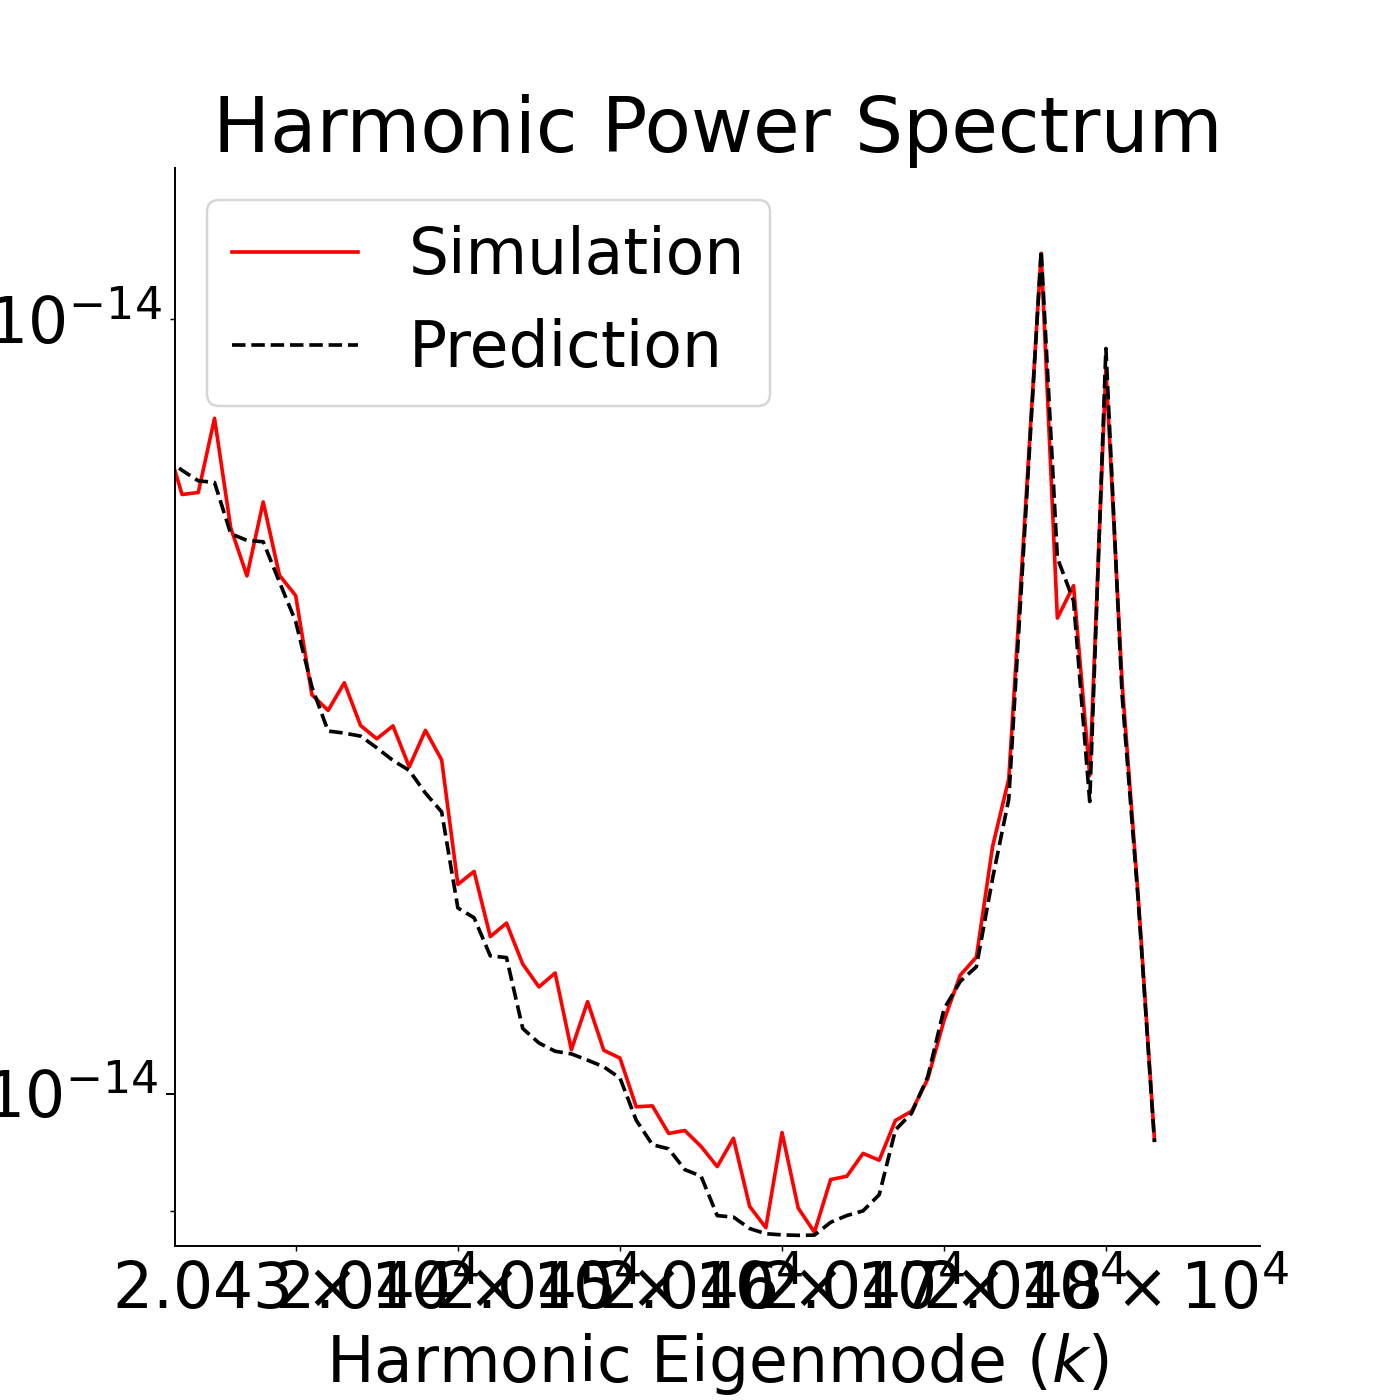

<IPython.core.display.Javascript object>


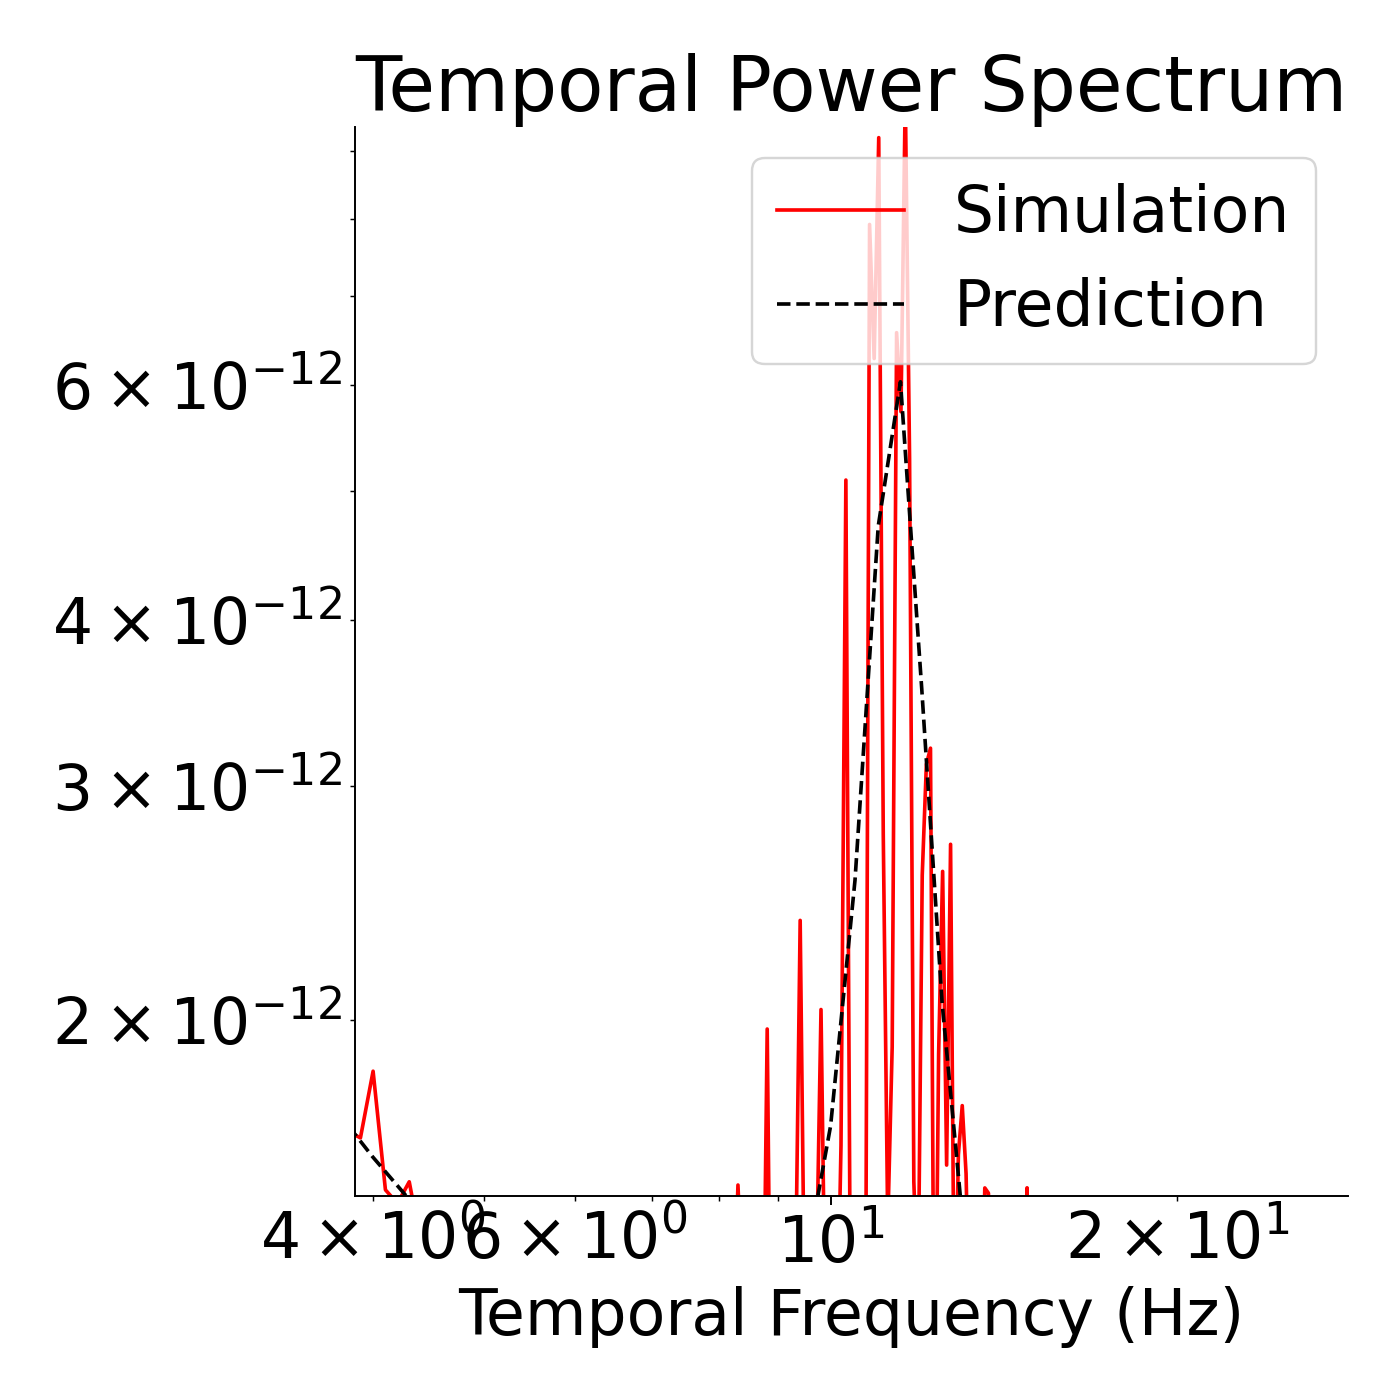

In [100]:

PS_full, TPS_full = Activity_Analysis(Ess, Iss, Delta_t,
                                   aEE, aIE, aEI, aII,
                                   sEE, sIE, sEI, sII, D,
                                   dE, dI, P, Q, tE, tI, 
                                          
                                    aDWEE,aDWIE, aDWEI, aDWII,
                                    bDWEE, bDWIE, bDWEI, bDWII,  
                                          
                                    snE, snI, Graph_Kernel,
                                
                                 beta_E_total=Beta_E_total,
                                   
                                   prediction=True, min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega,
                                      temporal_downsampling=10,
                                 #  Spatial_scaling=[a_spatial,b_spatial], Temporal_scaling=[a_temporal,b_temporal],
                                   
                                   one_dim=False, syn=syn, gridsize=gridsize, h=h,
                                      
                                   eigvals=eigenvalues, eigvecs=None,
                                   
                                   Visual=True, Save_Results=False, Filepath=' ')

In [ ]:
SPS_sims=[]
Time=100
Delta_t=0.0001

nrSS=0
Ess = steady_states[0,nrSS]
Iss = steady_states[1,nrSS]  
for sims in range(3):
    Beta_E_total = np.load('/home/aqil/NFModel/Beta_E_total'+str(sims)+'.npy')

    PS_full, TPS_full = Activity_Analysis(Ess, Iss, Delta_t,
                                   aEE, aIE, aEI, aII,
                                   sEE, sIE, sEI, sII, D,
                                   dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,
                                
                                   beta=True, beta_E_total=Beta_E_total,
                                   
                                   prediction=True, min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega,
                                      
                                 #  Spatial_scaling=[a_spatial,b_spatial], Temporal_scaling=[a_temporal,b_temporal],
                                   
                                   one_dim=False, syn=syn, gridsize=gridsize, h=h,
                                      
                                   eigvals=eigenvalues, eigvecs=None,
                                   
                                   Visual=True, Save_Results=False, Filepath=' ')    

    
    SPS_sims.append(PS_full)

    del Beta_E_total    
    
PS_full = np.median(SPS_sims, axis=0)

In [ ]:
np.save('/home/aqil/NFModel/simulations_median_PS.npy', PS_full)

In [ ]:
plt.close('all')
plt.ion()
plt.figure()

PS_sims_rescaled = NF_to_empirical(scale_params_spatial,PS_full,0)[first_k:last_k]
analytic_PS_rescaled = NF_to_empirical(scale_params_spatial,Gk_E,Gk_I)[first_k:last_k]

binned_SPS_sim = np.array([np.median(elem) for elem in np.array_split(PS_sims_rescaled, bins)])
binned_SPS_err_sim = np.array([sp.stats.sem(elem) for elem in np.array_split(PS_sims_rescaled, bins)])

plt.loglog(np.arange(first_k, last_k),PS_sims_rescaled, marker='s', linestyle='', markersize=2, zorder=1, color=[0.267004, 0.004874, 0.329415, 1.], label='Simulation PS')
plt.hist2d(np.arange(first_k, last_k),PS_sims_rescaled,(plot_bins, y_bins), cmap='viridis',zorder=2,cmin=2)
plt.loglog(np.arange(first_k, last_k), analytic_PS_rescaled, zorder=4,color='black', linestyle='--', linewidth=2, label = 'Predicted PS')
plt.errorbar(x=binned_SPS_points, y=binned_SPS_sim, yerr=binned_SPS_err_sim, zorder=3, fmt='ro-',markersize=3, label='Simulation binned median PS')
plt.legend(prop={'size': 12})

plt.figure()

plt.loglog(np.arange(first_k, last_k), empirical_SPS, marker='s', linestyle='', markersize=2, zorder=0, color=[0.267004, 0.004874, 0.329415, 1.], label='fMRI PS')
plt.hist2d(np.arange(first_k, last_k), empirical_SPS, (plot_bins, y_bins), cmap='viridis',zorder=1,cmin=2)
plt.loglog(np.arange(first_k, last_k), analytic_PS_rescaled, zorder=3,color='black', linestyle='--', linewidth=2, label = 'Predicted PS')
plt.errorbar(x=binned_SPS_points, y=binned_SPS, yerr=binned_SPS_err, zorder=2, fmt='yo-',markersize=3, label='fMRI binned median PS')
plt.legend(prop={'size': 12})

In [ ]:
plt.figure()
plt.loglog(np.arange(first_k, last_k), analytic_PS_rescaled, zorder=2,color='black', linestyle='--', linewidth=3, label = 'Prediction', alpha=0.65)
plt.errorbar(x=binned_SPS_points, y=binned_SPS_sim, yerr=0, fmt='ro-',markersize=4, label='Simulation',zorder=1, alpha=0.65)
plt.errorbar(x=binned_SPS_points, y=binned_SPS, yerr=0, fmt='co-',markersize=4.5, label='Resting-state fMRI', zorder=0)
plt.xlabel("Spatial Eigenmode ($k$)")
plt.ylabel("Power ($P(k)$)")
plt.legend(prop={'size': 18}, loc=3)

In [ ]:
#covariance = np.cov(timecourse)
covariance[covariance==0] = 1e-10
covariance[covariance==1] = 1e-10

plt.figure()
plt.pcolormesh(np.dot(np.diag(np.power(np.diag(covariance),-0.5)),np.dot(covariance,np.diag(np.power(np.diag(covariance),-0.5)))),
              vmin=-1,
              vmax=1)

In [ ]:
Func_Conn_prediction = Functional_Connectivity(eigenvectors, NF_to_empirical(scale_params_spatial,Gk_E,Gk_I), one_dim=False, Visual=True)

In [ ]:
##########################################################################################################
0.0001 10 slightly too high (time interval not small enough)
0.00008 8 slightly too high (time interval not small enough?)
0.00005 10 not doable
0.00005 7 slightly too low
0.00005 5 slightly too low (duration too short?)
0.00001 1 white noise like (low) (duration too short)

In [ ]:
#further verification: 1D grid simulation (linearized wilson-cowan: perturbation about steady state)

#duration and timestep
Time=10
Delta_t=0.001

#parameters of 1D graph (nonlocal synapses, grid size, grid spacing)
#syn=150
#gridsize=1000
#h=1

nrSS=0
Ess = steady_states[0,nrSS]
Iss = steady_states[1,nrSS]   



Beta_E_total_1D = Linearized_GLDomain_Wilson_Cowan_Model(Ess, Iss, Time, Delta_t,                          
                         aEE, aIE, aEI, aII,
                         sEE, sIE, sEI, sII, D,
                         dE, dI, P, Q, tE, tI,
                                                         
                                            aDWEE,aDWIE, aDWEI, aDWII,
                                bDWEE, bDWIE, bDWEI, bDWII,  
                                                         snE, snI, Graph_Kernel,
                         one_dim=True, syn=syn, gridsize=gridsize, h=h,
                         eigvals=None, eigvecs=None,
                         Visual=True, SaveActivity=False, Filepath=' ') 



In [ ]:
#activity analysis of linearized model and comparison with prediction (perturbation about steady state)
#thesis values
#Max_omega=50
#Delta_omega=0.1
plt.close('all')
#Max_omega=3000
#Delta_omega=0.5

PS_full_1D, TPS_full_1D = Activity_Analysis(Ess, Iss, Delta_t,
                                   aEE, aIE, aEI, aII,
                                   sEE, sIE, sEI, sII, D,
                                   dE, dI, P, Q, tE, tI,
                                    aDWEE,aDWIE, aDWEI, aDWII,
                                bDWEE, bDWIE, bDWEI, bDWII,          
                                    snE, snI, Graph_Kernel,
                                
                                  beta_E_total=Beta_E_total_1D,
                                   
                                   prediction=True, max_omega=Max_omega, delta_omega=Delta_omega,
                                   
                                   one_dim=True, syn=syn, gridsize=gridsize, h=h,
                                      
                                   eigvals=None, eigvecs=None,
                                   
                                   Visual=True, Save_Results=False, Filepath=' ')


In [ ]:
#MISC
#Beta_E_total=np.load('G:/Macbook Stuff/Simulation Results/Decent spatiotemporal spectrum activity.npy')
#del Beta_E_total
#del eigenvectors
#del connectome_activity
#np.save('G:/Macbook Stuff/Simulation Results/Decent spatiotemporal spectrum activity.npy', Beta_E_total)
#print(len(Beta_E_total[0]))
#print(Beta_E_total[0])
with h5py.File("G:/Macbook Stuff/Simulation Results/Decent spatiotemporal spectrum activity.h5") as hf:
    if "Activity" not in list(hf.keys()):
        #connectome_activity=np.dot(eigenvectors,Beta_E_total)
        hf.create_dataset("Activity",  data=connectome_activity)
    else:
        print("Warning: overwriting results of a previous simulation.") 

In [ ]:
#nonlinear connectome simulation
nrSS=0
Ess = steady_states[0,nrSS]
Iss = steady_states[1,nrSS]    
Time=0.1
Delta_t=0.00001

E_total = Graph_Wilson_Cowan_Model(Ess, Iss, Time, Delta_t,                          
                         aEE, aIE, aEI, aII,
                         sEE, sIE, sEI, sII, D,
                         dE, dI, P, Q, tE, tI, 
                                                                  
                                    aDWEE,aDWIE, aDWEI, aDWII,
                                    bDWEE, bDWIE, bDWEI, bDWII,  
                                                     
                        snE, snI, Graph_Kernel,                                  
                         one_dim=False, eigvals=eigenvalues, eigvecs=eigenvectors,
                         Visual=False, SaveActivity=False, Filepath=' ')  

2.8533566784253853e-06 6.3159491332839985e-06 5e-05 5e-05


In [ ]:
PS_full, TPS_full = Activity_Analysis(Ess, Iss, Delta_t,
                                   aEE, aIE, aEI, aII,
                                   sEE, sIE, sEI, sII, D,
                                   dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,
                                
                                   E_total=E_total,
                                   
                                   prediction=True, max_omega=Max_omega, delta_omega=Delta_omega,
                                   
                                   one_dim=False, syn=syn, gridsize=gridsize, h=h,
                                      
                                   eigvals=eigenvalues, eigvecs=eigenvectors,
                                   
                                   Visual=True, Save_Results=False, Filepath=' ')

In [ ]:
np.save('/home/aqil/NFModel/nonlsim_fix_TPS.npy', TPS_full)

In [ ]:
from scipy.stats import gamma
def hrf(times):
    """ Return values for HRF at given times """
    # Gamma pdf for the peak
    peak_values = gamma.pdf(times, 6)
    # Gamma pdf for the undershoot
    undershoot_values = gamma.pdf(times, 12)
    # Combine them
    values = peak_values - 0.35 * undershoot_values
    # Scale max to 0.6
    return values / np.max(values)

hrf_times = np.arange(0, 25, 0.0001)
hrf_signal=100*hrf(hrf_times)
print(hrf_signal.reshape(1,-1).shape)
plt.figure()
plt.plot(hrf_signal)

In [ ]:
#not working?
E_total_fMRI = sp.signal.fftconvolve(E_total-E_total.mean(1)[...,np.newaxis], hrf_signal.reshape(1,-1), mode='same', axes=(-1))[...,::10000]

In [ ]:
plt.figure()
#plt.plot(100*E_total[0])
plt.plot(sp.signal.fftconvolve((E_total[0]-E_total[0].mean()), hrf_signal, mode='same'))

In [ ]:
FC_nonlinear_sim = np.corrcoef(E_total[:,:10000])

In [ ]:
FC_nonlinear_sim_fmri = np.corrcoef(E_total_fMRI)

In [ ]:
#np.save('/home/aqil/NFModel/nonlsim_fc_fmri.npy', FC_nonlinear_sim_fmri)
#E_total = np.load('/home/aqil/NFModel/nonlsim_act.npy')
np.save('/home/aqil/NFModel/nonlsim_act_fix.npy',E_total)

In [ ]:
plt.close('all')
plt.figure(figsize=(10,10))
plt.ylim(3700,1200)
plt.xlim(5500,7500)
#plt.ylim(10000,9000)
#plt.xlim(11000,12000)
plt.imshow(FC_nonlinear_sim, vmin=0, vmax=0.075, cmap='inferno')

plt.colorbar()

In [ ]:
#################******** PROPAGATOR TESTS ********#################

In [ ]:
#propagator test 1
#damped wave/telegrapher parameters
#params for first working tests: a=0.3, b=0.001, c=0, Delta_t=1, h=1 (worked with 2-normalized eigenvalues)
#make a smaller: wave travels faster
a=1e-9#better_result['x'][17]
#make b larger: more diffusion
b=1e-4#better_result['x'][21]
#nonzero c: switch from damped wave to telegrapher eqn
c=0

gridsize=1000
syn=0
h=0.003
#u_0=0.3*sp.signal.gaussian(gridsize, 10)#np.zeros(gridsize)#(-0.1/499**2)*(np.arange(gridsize)-499)**2 + 0.1 
u_0 =np.zeros(gridsize)+0.05
Delta_t=1e-7#1e-5#*better_result['x'][11]**2
Time=Delta_t*100

u_0[499]=0.09
print(np.sum(u_0))
u_final=graph_propagator_test(u_0, Time, Delta_t, kernel_param=Delta_t, Graph_Kernel='Damped Wave', a=a, b=b, c=c, sigma_noise=0.0,
                          one_dim=True, syn=syn, gridsize=gridsize,  h=h, eigvals=None, eigvecs=None,                         
                          Visual=True, SaveActivity=False, Filepath=' ', NSim=0)
print(np.sum(u_final))

In [ ]:
#propagator test 2
gridsize=1000
syn=0
h=1
u_0=np.zeros(gridsize)#(-0.1/499**2)*(np.arange(gridsize)-499)**2 + 0.1 
Delta_t=0.005
Time=Delta_t
u_0[499]=1000
#u_0=np.ones(gridsize)
print(np.sum(u_0))
u_final=graph_propagator_test(u_0, Time, Delta_t, kernel_param=Delta_t, Graph_Kernel='Pyramid', sigma_noise=0,
                          one_dim=True, syn=syn, gridsize=gridsize,  h=h, eigvals=None, eigvecs=None,                         
                          Visual=True, SaveActivity=False, Filepath=' ', NSim=0)
print(np.sum(u_final))

In [ ]:
#proptest 3 cortical mesh convolutions

u_0=np.zeros(len(eigenvalues))#np.zeros(gridsize)#(-0.1/499**2)*(np.arange(gridsize)-499)**2 + 0.1 
u_0[6369]=50
u_prop=graph_propagator_test(u_0, Time=50, Delta_t=50, kernel_param=50/1000000, Graph_Kernel='Gaussian', sigma_noise=0.0,
                          one_dim=False, syn=0, gridsize=0,  h=0, eigvals=eigenvalues, eigvecs=eigenvectors,                         
                          Visual=False, SaveActivity=False, Filepath=' ', NSim=0)

In [ ]:
#propagator test 4: cortical mesh
##NOTE: THESE PARAMETERS WERE FOR THE EIGENVALUES OF THE LAPLACIAN IN MILLIMIETERS
#damped wave/telegrapher parameters
#params for first working tests: a=0.3, b=0.001, c=0, Delta_t=1
#params for wave first figure: a=0.3 b=0.005 c=0 (*1000000) (faster wave: a=0.15 b=0.0025)
#make a smaller: wave travels faster
a=0.3
#make b larger: more diffusion
b=0.005
#nonzero c: switch from damped wave to telegrapher eqn
c=0

#in metres it should be enough to do (also change initial gaussian kernel param)
a*=1000000
b*=1000000


u_0=np.zeros(len(eigenvalues))#np.zeros(gridsize)#(-0.1/499**2)*(np.arange(gridsize)-499)**2 + 0.1 
Delta_t=1
Time=60
u_0[6369]=50

#gauss kernel parm 50/1000000


u_1=graph_propagator_test(np.dot(eigenvectors.T,u_0), Time=2, Delta_t=1, kernel_param=50/1000000, 
                          Graph_Kernel='Gaussian', sigma_noise=0.0,
                          one_dim=False, syn=0, gridsize=0,  h=0, eigvals=eigenvalues, GF_domain=True,                         
                          Visual=False, SaveActivity=False, Filepath=' ', NSim=0)
u_total=graph_propagator_test(u_1[:,1], Time, Delta_t, kernel_param=Delta_t, Graph_Kernel='Damped Wave', a=a, b=b, c=c, sigma_noise=0.0,
                          one_dim=False, syn=0, gridsize=0,  h=0, eigvals=eigenvalues, GF_domain=True,                       
                          Visual=False, SaveActivity=False, Filepath=' ', NSim=0)
u_total=np.dot(eigenvectors,u_total)

In [ ]:
resamp_conn_activity = np.dot(eigenvectors.T, np.load('/home/aqil/NFModel/Beta_E_total0.npy')[:,::7200])

In [ ]:
#propagator test 5 stochastic damped wave in fourier domain for quantitative spectrum calculation

#make a smaller: wave travels faster
#make b larger: more diffusion

#nonzero c: switch from damped wave to telegrapher eqn
c=0


a=0.3*1000000
b=0.05*1000000
sigma_noise=0.0001


beta_0=np.ones(len(eigenvalues))#np.zeros(gridsize)#(-0.1/499**2)*(np.arange(gridsize)-499)**2 + 0.1 
Delta_t=1
Time=200

dw_beta_act=graph_propagator_test(np.dot(eigenvectors.T, beta_0), Time, Delta_t, kernel_param=Delta_t, Graph_Kernel='Damped Wave', a=a, b=b, c=c,
                                 sigma_noise=sigma_noise,
                                 one_dim=False, syn=0, gridsize=0,  h=0, GF_domain=True, eigvals=eigenvalues,                          
                                 Visual=False, SaveActivity=False, Filepath=' ', NSim=0)


#dw_PS_pred

In [ ]:
#dw_beta_act = np.load('G:\Macbook Stuff\Simulation Results\Damped Wave Kernel Test t=1\0# Sim Activity.h5')
dw_PS = np.var(dw_beta_act, axis=1)
dw_TPS = sp.signal.periodogram(dw_beta_act, fs=1/Delta_t, detrend='constant', scaling='density')
f = plt.figure()
plt.plot(dw_PS)
f2 = plt.figure()
plt.plot(dw_TPS[0]*(2*np.pi),np.sum(dw_TPS[1], axis=0))

In [ ]:
a=10000
b=50000000
sigma_noise=0.001

lambdas, omegas = np.meshgrid(eigenvalues, dw_TPS[0][1:]*(2*np.pi))
prediction = sigma_noise**2 / (b**2 * omegas**2 + (lambdas - a*omegas**2)**2)

#f3 = plt.figure()
#ax = f3.add_subplot(111)
#pc = ax.pcolormesh(lambdas, omegas, prediction)
#f3.colorbar(pc)

f4 = plt.figure()
plt.plot(dw_TPS[0][1]*np.sum(prediction, axis=0)/np.pi)
f5 = plt.figure()
plt.plot(dw_TPS[0][1:]*(2*np.pi), 2*np.sum(prediction, axis=1))


In [ ]:
import chart_studio.plotly as py
import plotly.graph_objs as go
f = h5py.File('/home/aqil/NFModel/100307_Laplace.mat', 'r')
CC = np.asarray(f['CC']['restInds'], dtype=int)
indices = np.array([elem[0] for elem in CC])-1
AllVet=np.asarray(f['vertices']['all'])
AllVet=AllVet[:,indices]

dist=np.sqrt(AllVet[0,:]**2 + AllVet[1,:]**2 + AllVet[2,:]**2)
trace4 = go.Scatter3d(
    x=AllVet[0,:],
    y=AllVet[1,:],
    z=AllVet[2,:],
    #alphahull=50
    mode='markers',
    marker=dict(
        size=5,
        color=dist,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1,
        #line=dict(color='rgba(0, 0, 0,0.5)',width=1,)
        )
    )
data = [trace3]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [ ]:
with h5py.File('G:/Macbook Stuff/Simulation Results/Damped Wave Kernel Test t=1/0# Sim Activity b=0.005.h5', 'r') as file:
    print(list(file.keys()))
    DWave = np.asarray(file['Activity'], dtype=float)

DWave[:,0]

In [ ]:
#beta_u_total=np.load('G:/Macbook Stuff/Simulation Results/new realistic activity.npy')#np.dot(eigenvectors, dw_beta_act)
#u_total=np.dot(eigenvectors,beta_u_total)
#del beta_u_total
#del eigenvectors
#covariance = np.cov(u_total)
#del u_total
#FC=np.dot(np.diag(np.power(np.diag(covariance),-0.5)),np.dot(covariance,np.diag(np.power(np.diag(covariance),-0.5))))    
#del covariance

plt.close('all')
fig=plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(FC, vmax=0.1, vmin=-0.1)
fig.colorbar(im)

In [ ]:
#np.save('G:/Macbook Stuff/Simulation Results/FC new realistic', FC)
#np.save('G:/Macbook Stuff/Simulation Results/new realistic activity', u_total)

In [ ]:
import plotly.offline as offline
from plotly.graph_objs import *
#init_notebook_mode(connected=True)
offline.init_notebook_mode()

#mesh (or full connectome) graph edges
#trace1=Scatter3d(x=Xe,
#               y=Ye,
#               z=Ze,
#               mode='lines',
#              line=Line(color='rgba(0,0,0,1)', width=1),
#             )

#Mesh3d
trace2=Mesh3d(x=Xn,
               y=Yn,
               z=Zn,
              i=iN,
              j=jN,
              k=kN,
              text=np.arange(len(Xn)),
              #lighting used for NFModel plots, not for DWave
             lighting = dict(ambient=1, diffuse=0.1, roughness = 0.9, specular=1.8, fresnel=0.01),
              #colorlimits USE IF NEEDED (0.1 good for Dwave, 0.01 to show WMprop)(20 good for fmri demeaned)
              cmin=-20,#-10E-9,#-0.1,#-10E-9,#-0.1,
              cmax=20, #10E-9#0.1#10E-9#0.1
              #eigenvectors[:,1001]#
              
            
              
          #     mode='markers',
          #  marker=dict(
          #          size=5,
          #          color=-AllVet[1,:],#np.sqrt(AllVet[2,:]**2+AllVet[0,:]**2+AllVet[1,:]**2),                # set color to an array/list of desired values
                    colorscale='RdBu_r',   # choose a colorscale
          #          opacity=0.8,
          #          line=dict(color='rgba(0, 0, 0,0.5)',
          #                     width=1,
        #                     )
        #                )
                )


###SET WHAT IS GONNA BE PLOTTED
interval = 1
start_time = 50
max_time = 55#11* interval

#timecourse_demeaned = timecourse-timecourse.mean(1)[...,np.newaxis]
#np.sqrt(3.85007284e+18)*resamp_conn_activity[:,i]
#np.nan_to_num(sp.stats.zscore(timecourse, axis=1))[:,i]
#np.nan_to_num(sp.stats.zscore(resamp_conn_activity, axis=1))[:,i]
frames =[dict(data=[dict(type='mesh3d', 
                         #HERE IS WHAT DECIDES THE COLOR-TIMEPLOT
                         intensity= timecourse_demeaned[:,i])],#u_total[:,i])],#eigenvectors[:,i]
                  traces=[0],
                  name='{}'.format(i)) for i in range(start_time,max_time,interval)] 



axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )
                 
layout = Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
            #good left occipital love view eye=dict(x=-1, y=-1.25, z=0.9). view from top eye=dict(x=0, y=0, z=1.8)
    eye=dict(x=0, y=0, z=1.8)
)),  
    hovermode=False,     autosize=False,
    width=1000,
    height=1150
)       
data=[trace2]

fig_frames = Figure(data=data, layout=layout, frames=frames)

fig_frames['layout']['updatemenus'] = [
    {
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 120, 'redraw': True},
                         'fromcurrent': True, 'transition': {'duration': 120, 'easing': 'quadratic-in-out'}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate',
                'transition': {'duration': 0}}], 
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': True,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
]



fig_frames['layout']['sliders'] = [{
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'time=',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 120, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 5},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': [{
    'method': 'animate',
    'label': '{}'.format(i),
   # 'value': '',
    'args': [[i], {'frame': {'duration': 300, 'redraw': True},
         'mode': 'immediate'}
    ],
} for i in range(start_time,max_time,interval)]
}]



#fig=Figure(data=data, layout=layout)

offline.iplot(fig_frames, filename='Les-Miserables')

In [ ]:
with h5py.File('G:/Macbook Stuff/Downloads/Fibers.mat', 'r') as file:
    print(list(file.keys()))
    print(list(file['fgCC'].keys()))
        
    Fibers=[file[element][:] for element in file['fgCC']['fibers'][0]]

fiber_edges=np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fgCC_fiber_edges.npy')
f = h5py.File('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/100307_Laplace.mat', 'r')
CC = np.asarray(f['CC']['restInds'], dtype=int)
f.close()
indices = np.array([elem[0] for elem in CC])-1
EX=[]
EY=[]
EZ=[]
colors=[]

counter=0
for i in range(0,len(Fibers),2):
    if fiber_edges[i,0] in indices and fiber_edges[i,1] in indices and fiber_edges[i,0]!=fiber_edges[i,1]:
        counter+=1
        for j in range(Fibers[i].shape[0]-1):
            EX+=[Fibers[i][j,0], Fibers[i][j+1,0], None]
            EY+=[Fibers[i][j,1], Fibers[i][j+1,1], None]
            EZ+=[Fibers[i][j,2], Fibers[i][j+1,2], None]

counter    


    

In [ ]:
fig_frames.write_image("G:/fig1.png")

In [ ]:
import plotly.offline as offline
from plotly.graph_objs import *
#init_notebook_mode(connected=True)
offline.init_notebook_mode()

trace3=Scatter3d(x=EX,
               y=EY,
               z=EZ,
               mode='lines',
               line=Line(color=EX,#'rgba(100,100,100,0.9)',#colors
                         #colorscale=[[0, 'rgb(0,0,255)'], [1, 'rgb(255,0,0)']],#'Rainbow',
                         width=1),
               )
axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )
                 
layout = Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        ),
    hovermode=False
)       
data=Data([trace3])
fig=Figure(data=data, layout=layout)

offline.iplot(fig, filename='Les-Miserables-2')